## Fine-tune Gemma 7B it for Sentiment Analysis with TPU

Gemma, a cutting-edge lightweight open model crafted using the same advanced research and technology employed in developing the Gemini models, is now accessible within the KerasNLP collection. Leveraging Keras 3, Gemma seamlessly operates on JAX, PyTorch, and TensorFlow frameworks. Alongside this launch, Keras introduces several novel features tailored for large language models, including a new LoRA API (Low Rank Adaptation) and enhanced capabilities for large-scale model-parallel training, which means that we can fine-tune also using TPUs!

Following the original tutorial working with the Hugging Face interface to be found at https://www.kaggle.com/code/lucamassaron/fine-tune-gemma-7b-it-for-sentiment-analysis, we are going to deal with a sentiment analysis on financial and economic information but this time having Gemma work with a TPU VM v3-8. Sentiment analysis on financial and economic information is highly relevant for businesses for several key reasons, ranging from market insights (gain valuable insights into market trends, investor confidence, and consumer behavior) to risk management (identifying potential reputational risks) to investment decisions (gauging the sentiment of stakeholders, investors, and the general public businesses can assess the potential success of various investment opportunities).

Before the technicalities of fine-tuning a large language model like Gemma, we had to find the correct dataset to demonstrate the potentialities of fine-tuning.

Particularly within the realm of finance and economic texts, annotated datasets are notably rare, with many being exclusively reserved for proprietary purposes. To address the issue of insufficient training data, scholars from the Aalto University School
of Business introduced in 2014 a set of approximately 5000 sentences. This collection aimed to establish human-annotated benchmarks, serving as a standard for evaluating alternative modeling techniques. The involved annotators (16 people with
adequate background knowledge on financial markets) were instructed to assess the sentences solely from the perspective of an investor, evaluating whether the news potentially holds a positive, negative, or neutral impact on the stock price.

The FinancialPhraseBank dataset is a comprehensive collection that captures the sentiments of financial news headlines from the viewpoint of a retail investor. Comprising two key columns, namely "Sentiment" and "News Headline," the dataset effectively classifies sentiments as either negative, neutral, or positive. This structured dataset serves as a valuable resource for analyzing and understanding the complex dynamics of sentiment in the domain of financial news. It has been used in various studies and research initiatives, since its inception in the work by Malo, P., Sinha, A., Korhonen, P., Wallenius, J., and Takala, P.  "Good debt or bad debt: Detecting semantic orientations in economic texts.", published in the Journal of the Association for Information Science and Technology in 2014.

As a first step, we install the specific libraries necessary to make this example work.

* tensorflow-cpu: This library provides the backbone for executing TensorFlow computations on CPUs, enabling efficient processing of machine learning tasks without the need for GPU acceleration.

* keras-nlp: An integral component, the KerasNLP library, offers a rich collection of tools and utilities tailored for natural language processing tasks. It encapsulates various models and functionalities, including Gemma, discussed earlier.

* tensorflow-hub: TensorFlow Hub serves as a repository for pre-trained machine learning models, enabling easy access to a wide array of models for tasks such as transfer learning and feature extraction. Its integration enhances the capabilities of the example by facilitating the use of pre-trained embeddings and models.

* keras: Keras, a high-level neural networks API, provides a user-friendly interface for building, training, and deploying deep learning models. Its integration with TensorFlow allows for seamless interoperability and simplifies the development process, making it an indispensable component for this example.

In [1]:
!pip install -q tensorflow-cpu
!pip install -q -U keras-nlp tensorflow-hub
!pip install -q -U keras>=3

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
keras-nlp 0.7.0 requires keras-core, which is not installed.



[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip



[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.0.5 which is incompatible.
tensorflow-cpu 2.15.0.post1 requires keras<2.16,>=2.15.0, but you have keras 3.0.5 which is incompatible.

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


Thanks to Keras, , users gain the flexibility to select the backend on which their model operates. 

The code imports the os module and sets two environment variables for setting JAX as a backend and then for pre-allocating the TPU memory:

* KERAS_BACKEND: The Keras 3 distribution API is only implemented for the JAX backend for now.
* XLA_PYTHON_CLIENT_MEM_FRACTION: Pre-allocate 90% of TPU memory to minimize memory fragmentation and allocation overhead

In [2]:
import os

os.environ["KERAS_BACKEND"] = "jax"
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "0.9"

The code import warnings; warnings.filterwarnings("ignore") imports the warnings module and sets the warning filter to ignore. This means that all warnings will be suppressed and will not be displayed. Actually during training there are many warnings that do not prevent the fine-tuning but can be distracting and make you wonder if you are doing the correct things.

In [3]:
import warnings
warnings.filterwarnings("ignore")

In the following cell there are all the other imports for running the notebook. In addition, The 'jax.devices()' function is used to retrieve a list of all available devices that JAX can utilize for computation.

In [4]:
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
import matplotlib.pyplot as plt

import keras
import keras_nlp
from tensorflow.data import Dataset

from sklearn.metrics import (accuracy_score, 
                             classification_report, 
                             confusion_matrix)
from sklearn.model_selection import train_test_split

import jax
print(jax.devices())

[TpuDevice(id=0, process_index=0, coords=(0,0,0), core_on_chip=0), TpuDevice(id=1, process_index=0, coords=(0,0,0), core_on_chip=1), TpuDevice(id=2, process_index=0, coords=(1,0,0), core_on_chip=0), TpuDevice(id=3, process_index=0, coords=(1,0,0), core_on_chip=1), TpuDevice(id=4, process_index=0, coords=(0,1,0), core_on_chip=0), TpuDevice(id=5, process_index=0, coords=(0,1,0), core_on_chip=1), TpuDevice(id=6, process_index=0, coords=(1,1,0), core_on_chip=0), TpuDevice(id=7, process_index=0, coords=(1,1,0), core_on_chip=1)]


To fine-tune the larger Gemma 7B model efficiently, a distributed setup is recommended, such as leveraging a TPUv3 with 8 TPU cores available on platforms like Kaggle or an 8-GPU machine from Google Cloud. The provided code snippet configures the model for distributed training using model parallelism. Essentially, it organizes the 8 accelerators into a 1 x 8 matrix, where the dimensions represent "batch" and "model". Model weights are distributed across the "model" dimension, which is split between the 8 accelerators, while data batches remain unpartitioned due to the "batch" dimension being set to 1.

The code initializes a device mesh and configures the model layout accordingly. It sets up the mapping between model components and the distributed layout, specifying how different parts of the model are distributed across the available accelerators. Once the model configuration is set, the Gemma 7B model is loaded and ready for training using the model.fit() method or text generation using the generate() method.

In [5]:
def create_device_mesh():
    """
    Create a device mesh with (1, 8) shape so that the weights are sharded across all 8 TPUs
    """
    device_mesh = keras.distribution.DeviceMesh(
        (1, 8),
        ["batch", "model"],
        devices=keras.distribution.list_devices())
    return device_mesh

model_dim = "model"
device_mesh = create_device_mesh()
layout_map = keras.distribution.LayoutMap(device_mesh)

# Weights that match 'token_embedding/embeddings' will be sharded on 8 TPUs
layout_map["token_embedding/embeddings"] = (None, model_dim)
# Regex to match against the query, key and value matrices in the decoder
# attention layers
layout_map["decoder_block.*attention.*(query|key|value).*kernel"] = (None, model_dim, None)

layout_map["decoder_block.*attention_output.*kernel"] = (
    None, None, model_dim)
layout_map["decoder_block.*ffw_gating.*kernel"] = (model_dim, None)
layout_map["decoder_block.*ffw_linear.*kernel"] = (None, model_dim)

model_parallel = keras.distribution.ModelParallel(device_mesh, layout_map, batch_dim_name="batch")
keras.distribution.set_distribution(model_parallel)

Gemma models come with a user-friendly KerasNLP API and a highly intuitive Keras implementation. Instantiating the model requires just a single line of code, making it exceptionally straightforward to use.

In [6]:
gemma_lm = keras_nlp.models.GemmaCausalLM.from_preset("gemma_7b_en")

Attaching 'config.json' from model 'keras/gemma/keras/gemma_7b_en/2' to your Kaggle notebook...


Attaching 'config.json' from model 'keras/gemma/keras/gemma_7b_en/2' to your Kaggle notebook...


Attaching 'model.weights.h5' from model 'keras/gemma/keras/gemma_7b_en/2' to your Kaggle notebook...


Attaching 'tokenizer.json' from model 'keras/gemma/keras/gemma_7b_en/2' to your Kaggle notebook...


Attaching 'assets/tokenizer/vocabulary.spm' from model 'keras/gemma/keras/gemma_7b_en/2' to your Kaggle notebook...


normalizer.cc(51) LOG(INFO) precompiled_charsmap is empty. use identity normalization.


The code in the next cell performs the following steps:

1. Reads the input dataset from the all-data.csv file, which is a comma-separated value (CSV) file with two columns: sentiment and text.
2. Splits the dataset into training and test sets, with 300 samples in each set. The split is stratified by sentiment, so that each set contains a representative sample of positive, neutral, and negative sentiments.
3. Shuffles the train data in a replicable order (random_state=10)
4. Transforms the texts contained in the train and test data into prompts to be used by Gemma: the train prompts contains the expected answer we want to fine-tune the model with
5. The residual examples not in train or test, for reporting purposes during training (but it won't be used for early stopping), is treated as evaluation data, which is sampled with repetition in order to have a 50/50/50 sample (negative instances are very few, hence they should be repeated)
5. The train and eval data are wrapped by the class from Hugging Face (https://huggingface.co/docs/datasets/index)

This prepares in a single cell train_data, eval_data and test_data datasets to be used in our fine tuning.

In [7]:
filename = "../input/sentiment-analysis-for-financial-news/all-data.csv"

df = pd.read_csv(filename, 
                 names=["sentiment", "text"],
                 encoding="utf-8", encoding_errors="replace")

X_train = list()
X_test = list()
for sentiment in ["positive", "neutral", "negative"]:
    train, test  = train_test_split(df[df.sentiment==sentiment], 
                                    train_size=300,
                                    test_size=300, 
                                    random_state=42)
    X_train.append(train)
    X_test.append(test)

X_train = pd.concat(X_train).sample(frac=1, random_state=10)
X_test = pd.concat(X_test)

eval_idx = [idx for idx in df.index if idx not in list(train.index) + list(test.index)]
X_eval = df[df.index.isin(eval_idx)]
X_eval = (X_eval
          .groupby('sentiment', group_keys=False)
          .apply(lambda x: x.sample(n=50, random_state=10, replace=True)))
X_train = X_train.reset_index(drop=True)

def generate_prompt(data_point):
    return f"""
            Analyze the sentiment of the news headline enclosed in square brackets, 
            determine if it is positive, neutral, or negative, and return the answer as 
            the corresponding sentiment label "positive" or "neutral" or "negative"

            [{data_point["text"]}] = {data_point["sentiment"]}
            """.strip()

def generate_test_prompt(data_point):
    return f"""
            Analyze the sentiment of the news headline enclosed in square brackets, 
            determine if it is positive, neutral, or negative, and return the answer as 
            the corresponding sentiment label "positive" or "neutral" or "negative"

            [{data_point["text"]}] = 

            """.strip()

X_train = pd.DataFrame(X_train.apply(generate_prompt, axis=1), 
                       columns=["text"])
X_eval = pd.DataFrame(X_eval.apply(generate_prompt, axis=1), 
                      columns=["text"])

y_true = X_test.sentiment
X_test = pd.DataFrame(X_test.apply(generate_test_prompt, axis=1), columns=["text"])

This code snippet creates TensorFlow datasets (train_data and eval_data) from the text values of training (X_train) and evaluation (X_eval) datasets, respectively. Each dataset is batched with a batch size of 1, meaning each element in the dataset is treated as an individual batch. This allows for efficient processing of the text data during training and evaluation using TensorFlow's tf.data module.

In [8]:
train_data = Dataset.from_tensor_slices(X_train.text.values).batch(1)
eval_data = Dataset.from_tensor_slices(X_eval.text.values).batch(1)

As a test we retrieve a single element from the train_data dataset.

In [9]:
train_data.unbatch().take(1).get_single_element().numpy()

b'Analyze the sentiment of the news headline enclosed in square brackets, \n            determine if it is positive, neutral, or negative, and return the answer as \n            the corresponding sentiment label "positive" or "neutral" or "negative"\n\n            [Mr Jortikka is president of the base metal division of Outotec Oyj in Finland and is on the executive committee of Outotec .] = neutral'

The following function, predict, takes in a set of test data X_test, a language model model, and an optional max_length parameter, which defaults to 128. It iterates through each instance in X_test, extracting the text prompt. Then, it generates text continuations from the model given the prompt, aiming for a maximum length of max_length. If the generated output does not contain any meaningful information (determined by the presence of "="), it doubles the max_length parameter and retries until meaningful output is obtained or until max_length exceeds 512.

Once a meaningful output is generated, it extracts the answer, typically a sentiment label (positive, negative, neutral, or none). The function then appends the predicted sentiment label (positive, negative, neutral, or none) to a list y_pred, based on the extracted answer. Finally, it returns the list of predicted sentiment labels for each instance in the test data.

In [10]:
def predict(X_test, model, max_length=128):
    y_pred = []
    for i in range(len(X_test)):
        prompt = X_test.iloc[i]["text"]
        
        while True:
            outputs = model.generate(prompt, max_length=max_length)
            result = [item for item in outputs.split("\n") if "=" in item]
            if len(result) == 0:
                max_length = int(max_length * 2.0)
            else:
                break
            if max_length > 512:
                result = [" = none"]
        answer = result[0].split("=")[-1].lower()
        if "positive" in answer:
            y_pred.append("positive")
        elif "negative" in answer:
            y_pred.append("negative")
        elif "neutral" in answer:
            y_pred.append("neutral")
        else:
            y_pred.append("none")
    return y_pred

The evaluate function is designed to assess the performance of a sentiment classification model by comparing its predicted labels (y_pred) against the true labels (y_true).

First, it defines a list of sentiment labels and a mapping from these labels to numerical values. It then uses this mapping to convert the sentiment labels in both y_true and y_pred arrays to numerical representations.

The function computes the overall accuracy of the predictions and prints it out. It also generates accuracy scores for each individual sentiment label, providing insight into how well the model performs for each class.

Furthermore, it generates a classification report, which includes precision, recall, F1-score, and support metrics for each sentiment class, providing a more detailed evaluation of the model's performance.

Finally, the function computes and displays a confusion matrix, which summarizes the counts of true positive, false positive, true negative, and false negative predictions for each sentiment class.

Overall, this function provides a comprehensive evaluation of the sentiment classification model's performance, including overall accuracy, accuracy per class, detailed classification report metrics, and a confusion matrix.

In [11]:
def evaluate(y_true, y_pred):
    labels = ['positive', 'neutral', 'negative']
    mapping = {'positive': 2, 'neutral': 1, 'none':1, 'negative': 0}
    def map_func(x):
        return mapping.get(x, 1)
    
    y_true = np.vectorize(map_func)(y_true)
    y_pred = np.vectorize(map_func)(y_pred)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_true=y_true, y_pred=y_pred)
    print(f'Accuracy: {accuracy:.3f}')
    
    # Generate accuracy report
    unique_labels = set(y_true)  # Get unique labels
    
    for label in unique_labels:
        label_indices = [i for i in range(len(y_true)) 
                         if y_true[i] == label]
        label_y_true = [y_true[i] for i in label_indices]
        label_y_pred = [y_pred[i] for i in label_indices]
        accuracy = accuracy_score(label_y_true, label_y_pred)
        print(f'Accuracy for label {label}: {accuracy:.3f}')
        
    # Generate classification report
    class_report = classification_report(y_true=y_true, y_pred=y_pred)
    print('\nClassification Report:')
    print(class_report)
    
    # Generate confusion matrix
    conf_matrix = confusion_matrix(y_true=y_true, y_pred=y_pred, labels=[0, 1, 2])
    print('\nConfusion Matrix:')
    print(conf_matrix)

At this point, we are ready to test the Gemma 7B it model and see how it performs on our problem without any fine-tuning. This allows us to get insights on the model itself and establish a baseline.

In [12]:
y_pred = predict(X_test, gemma_lm)
evaluate(y_true, y_pred)

Accuracy: 0.719
Accuracy for label 0: 0.880
Accuracy for label 1: 0.410
Accuracy for label 2: 0.867

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.88      0.89       300
           1       0.66      0.41      0.51       300
           2       0.61      0.87      0.72       300

    accuracy                           0.72       900
   macro avg       0.73      0.72      0.71       900
weighted avg       0.73      0.72      0.71       900


Confusion Matrix:
[[264  28   8]
 [ 21 123 156]
 [  5  35 260]]


Now it is time to fine tune the Gemma 7B model.

Setting rank=8 replaces the weights matrix of pertinent layers with the product of two matrices of rank 8 (AxB). This operation effectively reduces the number of trainable parameters within the model.

In [13]:
gemma_lm.backbone.enable_lora(rank=8)

Now, first we set the sequence length of Gemma's preprocessor to 512. This defines the maximum length of input sequences that the model can process.

The we define the optimizer using the AdamW optimizer, a variant of Adam that incorporates weight decay regularization. Parameters such as learning rate, weight decay, clip value, and gradient accumulation steps are also configured here.

Afterwards, we specify which variables should be excluded from weight decay. In this case, biases and scale parameters are excluded, which can help prevent unnecessary regularization of these parameters.

Finally we compile the Gemma language model with specific loss, optimizer, and metrics configurations. Sparse categorical crossentropy loss is used for models that generate logits, such as language models. The optimizer defined above is passed along with weighted metrics for evaluation purposes.

As a last step, we print a summary of the Gemma language model, which provides information about its architecture, layer configurations, and the number of trainable parameters.

In [14]:
gemma_lm.preprocessor.sequence_length = 512

optimizer = keras.optimizers.AdamW(
    learning_rate=2e-4,
    weight_decay=0.001,
    clipvalue=0.3,
    gradient_accumulation_steps=16,
)
optimizer.exclude_from_weight_decay(var_names=["bias", "scale"])

gemma_lm.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=optimizer,
    weighted_metrics=[keras.metrics.SparseCategoricalAccuracy()],
)
gemma_lm.summary()

Preprocessor: "gemma_causal_lm_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Tokenizer (type)                                   ┃                                             Vocab # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ gemma_tokenizer (GemmaTokenizer)                   │                                             256,000 │
└────────────────────────────────────────────────────┴─────────────────────────────────────────────────────┘

Model: "gemma_causal_lm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ gemma_backbone                │ (None, None, 3072)        │   8,559,815,680 │ padding_mask[0][0],        │
│ (GemmaBackbone)               │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_embedding               │ (None, None, 256000)      │     786,432,000 │ gemma_backbone[0][0]       │
│ (ReversibleEmbedding)         │                           │                 │                            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 8,559,815,680 (31.89 GB)

 Trainable params: 22,134,784 (84.44 MB)

 Non-trainable params: 8,537,680,896 (31.81 GB)

Now we train the Gemma language model using the fit method. The train_data variable represents the training dataset that will be used to update the model parameters during training. The epochs parameter specifies the number of times the entire training dataset will be iterated over during training.

The validation_data parameter is used to provide an evaluation dataset (eval_data) to assess the model's performance on data that it hasn't been trained on. This helps monitor the model's generalization ability and detect overfitting. 

The fit method trains the model for the specified number of epochs (5 in this case) while monitoring performance on the validation data. The training history, including loss and metrics values over each epoch, is stored in the history variable.

In [15]:
history = gemma_lm.fit(train_data, epochs=5, validation_data=eval_data)

Epoch 1/5


  1/900 ━━━━━━━━━━━━━━━━━━━━ 13:13:10 53s/step - loss: 0.4997 - sparse_categorical_accuracy: 0.4419

  2/900 ━━━━━━━━━━━━━━━━━━━━ 45:12 3s/step - loss: 0.5080 - sparse_categorical_accuracy: 0.4356    

  3/900 ━━━━━━━━━━━━━━━━━━━━ 24:40 2s/step - loss: 0.5144 - sparse_categorical_accuracy: 0.4362

  4/900 ━━━━━━━━━━━━━━━━━━━━ 17:49 1s/step - loss: 0.5213 - sparse_categorical_accuracy: 0.4350

  5/900 ━━━━━━━━━━━━━━━━━━━━ 14:24 966ms/step - loss: 0.5238 - sparse_categorical_accuracy: 0.4344

  6/900 ━━━━━━━━━━━━━━━━━━━━ 12:20 828ms/step - loss: 0.5241 - sparse_categorical_accuracy: 0.4336

  7/900 ━━━━━━━━━━━━━━━━━━━━ 10:58 737ms/step - loss: 0.5247 - sparse_categorical_accuracy: 0.4326

  8/900 ━━━━━━━━━━━━━━━━━━━━ 9:59 672ms/step - loss: 0.5243 - sparse_categorical_accuracy: 0.4317 

  9/900 ━━━━━━━━━━━━━━━━━━━━ 9:15 624ms/step - loss: 0.5240 - sparse_categorical_accuracy: 0.4309

 10/900 ━━━━━━━━━━━━━━━━━━━━ 8:41 586ms/step - loss: 0.5222 - sparse_categorical_accuracy: 0.4302

 11/900 ━━━━━━━━━━━━━━━━━━━━ 8:13 555ms/step - loss: 0.5210 - sparse_categorical_accuracy: 0.4290

 12/900 ━━━━━━━━━━━━━━━━━━━━ 7:50 530ms/step - loss: 0.5205 - sparse_categorical_accuracy: 0.4283

 13/900 ━━━━━━━━━━━━━━━━━━━━ 7:31 510ms/step - loss: 0.5196 - sparse_categorical_accuracy: 0.4277

 14/900 ━━━━━━━━━━━━━━━━━━━━ 7:15 492ms/step - loss: 0.5185 - sparse_categorical_accuracy: 0.4271

 15/900 ━━━━━━━━━━━━━━━━━━━━ 7:01 477ms/step - loss: 0.5181 - sparse_categorical_accuracy: 0.4265

 16/900 ━━━━━━━━━━━━━━━━━━━━ 6:49 464ms/step - loss: 0.5182 - sparse_categorical_accuracy: 0.4261

 17/900 ━━━━━━━━━━━━━━━━━━━━ 6:39 452ms/step - loss: 0.5183 - sparse_categorical_accuracy: 0.4256

 18/900 ━━━━━━━━━━━━━━━━━━━━ 6:30 442ms/step - loss: 0.5182 - sparse_categorical_accuracy: 0.4253

 19/900 ━━━━━━━━━━━━━━━━━━━━ 6:21 433ms/step - loss: 0.5180 - sparse_categorical_accuracy: 0.4250

 20/900 ━━━━━━━━━━━━━━━━━━━━ 6:14 425ms/step - loss: 0.5178 - sparse_categorical_accuracy: 0.4247

 21/900 ━━━━━━━━━━━━━━━━━━━━ 6:07 418ms/step - loss: 0.5174 - sparse_categorical_accuracy: 0.4248

 22/900 ━━━━━━━━━━━━━━━━━━━━ 6:01 412ms/step - loss: 0.5171 - sparse_categorical_accuracy: 0.4249

 23/900 ━━━━━━━━━━━━━━━━━━━━ 5:55 406ms/step - loss: 0.5169 - sparse_categorical_accuracy: 0.4249

 24/900 ━━━━━━━━━━━━━━━━━━━━ 5:50 400ms/step - loss: 0.5167 - sparse_categorical_accuracy: 0.4249

 25/900 ━━━━━━━━━━━━━━━━━━━━ 5:45 395ms/step - loss: 0.5168 - sparse_categorical_accuracy: 0.4249

 26/900 ━━━━━━━━━━━━━━━━━━━━ 5:41 391ms/step - loss: 0.5169 - sparse_categorical_accuracy: 0.4248

 27/900 ━━━━━━━━━━━━━━━━━━━━ 5:37 387ms/step - loss: 0.5170 - sparse_categorical_accuracy: 0.4248

 28/900 ━━━━━━━━━━━━━━━━━━━━ 5:33 383ms/step - loss: 0.5171 - sparse_categorical_accuracy: 0.4246

 29/900 ━━━━━━━━━━━━━━━━━━━━ 5:30 379ms/step - loss: 0.5173 - sparse_categorical_accuracy: 0.4245

 30/900 ━━━━━━━━━━━━━━━━━━━━ 5:26 376ms/step - loss: 0.5176 - sparse_categorical_accuracy: 0.4244

 31/900 ━━━━━━━━━━━━━━━━━━━━ 5:23 373ms/step - loss: 0.5178 - sparse_categorical_accuracy: 0.4243

 32/900 ━━━━━━━━━━━━━━━━━━━━ 5:20 370ms/step - loss: 0.5179 - sparse_categorical_accuracy: 0.4242

 33/900 ━━━━━━━━━━━━━━━━━━━━ 5:18 367ms/step - loss: 0.5179 - sparse_categorical_accuracy: 0.4241

 34/900 ━━━━━━━━━━━━━━━━━━━━ 5:15 364ms/step - loss: 0.5179 - sparse_categorical_accuracy: 0.4241

 35/900 ━━━━━━━━━━━━━━━━━━━━ 5:12 362ms/step - loss: 0.5179 - sparse_categorical_accuracy: 0.4240

 36/900 ━━━━━━━━━━━━━━━━━━━━ 5:10 359ms/step - loss: 0.5179 - sparse_categorical_accuracy: 0.4239

 37/900 ━━━━━━━━━━━━━━━━━━━━ 5:08 357ms/step - loss: 0.5180 - sparse_categorical_accuracy: 0.4238

 38/900 ━━━━━━━━━━━━━━━━━━━━ 5:06 355ms/step - loss: 0.5182 - sparse_categorical_accuracy: 0.4238

 39/900 ━━━━━━━━━━━━━━━━━━━━ 5:04 353ms/step - loss: 0.5183 - sparse_categorical_accuracy: 0.4237

 40/900 ━━━━━━━━━━━━━━━━━━━━ 5:02 351ms/step - loss: 0.5183 - sparse_categorical_accuracy: 0.4237

 41/900 ━━━━━━━━━━━━━━━━━━━━ 5:00 350ms/step - loss: 0.5183 - sparse_categorical_accuracy: 0.4236

 42/900 ━━━━━━━━━━━━━━━━━━━━ 4:58 348ms/step - loss: 0.5183 - sparse_categorical_accuracy: 0.4236

 43/900 ━━━━━━━━━━━━━━━━━━━━ 4:56 346ms/step - loss: 0.5183 - sparse_categorical_accuracy: 0.4235

 44/900 ━━━━━━━━━━━━━━━━━━━━ 4:55 345ms/step - loss: 0.5183 - sparse_categorical_accuracy: 0.4235

 45/900 ━━━━━━━━━━━━━━━━━━━━ 4:53 344ms/step - loss: 0.5182 - sparse_categorical_accuracy: 0.4234

 46/900 ━━━━━━━━━━━━━━━━━━━━ 4:52 342ms/step - loss: 0.5182 - sparse_categorical_accuracy: 0.4234

 47/900 ━━━━━━━━━━━━━━━━━━━━ 4:50 341ms/step - loss: 0.5182 - sparse_categorical_accuracy: 0.4234

 48/900 ━━━━━━━━━━━━━━━━━━━━ 4:49 340ms/step - loss: 0.5183 - sparse_categorical_accuracy: 0.4233

 49/900 ━━━━━━━━━━━━━━━━━━━━ 4:48 338ms/step - loss: 0.5183 - sparse_categorical_accuracy: 0.4232

 50/900 ━━━━━━━━━━━━━━━━━━━━ 4:46 337ms/step - loss: 0.5184 - sparse_categorical_accuracy: 0.4232

 51/900 ━━━━━━━━━━━━━━━━━━━━ 4:45 336ms/step - loss: 0.5184 - sparse_categorical_accuracy: 0.4231

 52/900 ━━━━━━━━━━━━━━━━━━━━ 4:44 335ms/step - loss: 0.5183 - sparse_categorical_accuracy: 0.4231

 53/900 ━━━━━━━━━━━━━━━━━━━━ 4:42 334ms/step - loss: 0.5182 - sparse_categorical_accuracy: 0.4231

 54/900 ━━━━━━━━━━━━━━━━━━━━ 4:41 333ms/step - loss: 0.5181 - sparse_categorical_accuracy: 0.4231

 55/900 ━━━━━━━━━━━━━━━━━━━━ 4:40 332ms/step - loss: 0.5180 - sparse_categorical_accuracy: 0.4231

 56/900 ━━━━━━━━━━━━━━━━━━━━ 4:39 331ms/step - loss: 0.5179 - sparse_categorical_accuracy: 0.4231

 57/900 ━━━━━━━━━━━━━━━━━━━━ 4:38 330ms/step - loss: 0.5177 - sparse_categorical_accuracy: 0.4231

 58/900 ━━━━━━━━━━━━━━━━━━━━ 4:37 329ms/step - loss: 0.5175 - sparse_categorical_accuracy: 0.4231

 59/900 ━━━━━━━━━━━━━━━━━━━━ 4:36 328ms/step - loss: 0.5174 - sparse_categorical_accuracy: 0.4231

 60/900 ━━━━━━━━━━━━━━━━━━━━ 4:35 328ms/step - loss: 0.5173 - sparse_categorical_accuracy: 0.4231

 61/900 ━━━━━━━━━━━━━━━━━━━━ 4:34 327ms/step - loss: 0.5171 - sparse_categorical_accuracy: 0.4232

 62/900 ━━━━━━━━━━━━━━━━━━━━ 4:33 326ms/step - loss: 0.5170 - sparse_categorical_accuracy: 0.4232

 63/900 ━━━━━━━━━━━━━━━━━━━━ 4:32 326ms/step - loss: 0.5169 - sparse_categorical_accuracy: 0.4232

 64/900 ━━━━━━━━━━━━━━━━━━━━ 4:31 325ms/step - loss: 0.5168 - sparse_categorical_accuracy: 0.4233

 65/900 ━━━━━━━━━━━━━━━━━━━━ 4:30 324ms/step - loss: 0.5167 - sparse_categorical_accuracy: 0.4233

 66/900 ━━━━━━━━━━━━━━━━━━━━ 4:29 323ms/step - loss: 0.5166 - sparse_categorical_accuracy: 0.4234

 67/900 ━━━━━━━━━━━━━━━━━━━━ 4:28 323ms/step - loss: 0.5165 - sparse_categorical_accuracy: 0.4234

 68/900 ━━━━━━━━━━━━━━━━━━━━ 4:28 322ms/step - loss: 0.5164 - sparse_categorical_accuracy: 0.4235

 69/900 ━━━━━━━━━━━━━━━━━━━━ 4:27 322ms/step - loss: 0.5162 - sparse_categorical_accuracy: 0.4235

 70/900 ━━━━━━━━━━━━━━━━━━━━ 4:26 321ms/step - loss: 0.5161 - sparse_categorical_accuracy: 0.4236

 71/900 ━━━━━━━━━━━━━━━━━━━━ 4:25 320ms/step - loss: 0.5159 - sparse_categorical_accuracy: 0.4236

 72/900 ━━━━━━━━━━━━━━━━━━━━ 4:24 320ms/step - loss: 0.5158 - sparse_categorical_accuracy: 0.4237

 73/900 ━━━━━━━━━━━━━━━━━━━━ 4:24 319ms/step - loss: 0.5156 - sparse_categorical_accuracy: 0.4237

 74/900 ━━━━━━━━━━━━━━━━━━━━ 4:23 319ms/step - loss: 0.5155 - sparse_categorical_accuracy: 0.4238

 75/900 ━━━━━━━━━━━━━━━━━━━━ 4:22 318ms/step - loss: 0.5154 - sparse_categorical_accuracy: 0.4238

 76/900 ━━━━━━━━━━━━━━━━━━━━ 4:21 318ms/step - loss: 0.5152 - sparse_categorical_accuracy: 0.4238

 77/900 ━━━━━━━━━━━━━━━━━━━━ 4:21 317ms/step - loss: 0.5151 - sparse_categorical_accuracy: 0.4239

 78/900 ━━━━━━━━━━━━━━━━━━━━ 4:20 317ms/step - loss: 0.5150 - sparse_categorical_accuracy: 0.4239

 79/900 ━━━━━━━━━━━━━━━━━━━━ 4:19 316ms/step - loss: 0.5148 - sparse_categorical_accuracy: 0.4239

 80/900 ━━━━━━━━━━━━━━━━━━━━ 4:18 316ms/step - loss: 0.5147 - sparse_categorical_accuracy: 0.4240

 81/900 ━━━━━━━━━━━━━━━━━━━━ 4:18 315ms/step - loss: 0.5146 - sparse_categorical_accuracy: 0.4240

 82/900 ━━━━━━━━━━━━━━━━━━━━ 4:17 315ms/step - loss: 0.5145 - sparse_categorical_accuracy: 0.4240

 83/900 ━━━━━━━━━━━━━━━━━━━━ 4:17 315ms/step - loss: 0.5143 - sparse_categorical_accuracy: 0.4241

 84/900 ━━━━━━━━━━━━━━━━━━━━ 4:16 314ms/step - loss: 0.5142 - sparse_categorical_accuracy: 0.4241

 85/900 ━━━━━━━━━━━━━━━━━━━━ 4:15 314ms/step - loss: 0.5141 - sparse_categorical_accuracy: 0.4242

 86/900 ━━━━━━━━━━━━━━━━━━━━ 4:15 313ms/step - loss: 0.5139 - sparse_categorical_accuracy: 0.4242

 87/900 ━━━━━━━━━━━━━━━━━━━━ 4:14 313ms/step - loss: 0.5138 - sparse_categorical_accuracy: 0.4243

 88/900 ━━━━━━━━━━━━━━━━━━━━ 4:13 313ms/step - loss: 0.5136 - sparse_categorical_accuracy: 0.4243

 89/900 ━━━━━━━━━━━━━━━━━━━━ 4:13 312ms/step - loss: 0.5134 - sparse_categorical_accuracy: 0.4244

 90/900 ━━━━━━━━━━━━━━━━━━━━ 4:12 312ms/step - loss: 0.5133 - sparse_categorical_accuracy: 0.4244

 91/900 ━━━━━━━━━━━━━━━━━━━━ 4:12 312ms/step - loss: 0.5131 - sparse_categorical_accuracy: 0.4245

 92/900 ━━━━━━━━━━━━━━━━━━━━ 4:11 311ms/step - loss: 0.5129 - sparse_categorical_accuracy: 0.4245

 93/900 ━━━━━━━━━━━━━━━━━━━━ 4:10 311ms/step - loss: 0.5128 - sparse_categorical_accuracy: 0.4245

 94/900 ━━━━━━━━━━━━━━━━━━━━ 4:10 311ms/step - loss: 0.5126 - sparse_categorical_accuracy: 0.4246

 95/900 ━━━━━━━━━━━━━━━━━━━━ 4:09 310ms/step - loss: 0.5124 - sparse_categorical_accuracy: 0.4246

 96/900 ━━━━━━━━━━━━━━━━━━━━ 4:09 310ms/step - loss: 0.5122 - sparse_categorical_accuracy: 0.4247

 97/900 ━━━━━━━━━━━━━━━━━━━━ 4:08 310ms/step - loss: 0.5120 - sparse_categorical_accuracy: 0.4247

 98/900 ━━━━━━━━━━━━━━━━━━━━ 4:08 309ms/step - loss: 0.5118 - sparse_categorical_accuracy: 0.4247

 99/900 ━━━━━━━━━━━━━━━━━━━━ 4:07 309ms/step - loss: 0.5116 - sparse_categorical_accuracy: 0.4248

100/900 ━━━━━━━━━━━━━━━━━━━━ 4:07 309ms/step - loss: 0.5114 - sparse_categorical_accuracy: 0.4248

101/900 ━━━━━━━━━━━━━━━━━━━━ 4:06 309ms/step - loss: 0.5112 - sparse_categorical_accuracy: 0.4249

102/900 ━━━━━━━━━━━━━━━━━━━━ 4:06 308ms/step - loss: 0.5111 - sparse_categorical_accuracy: 0.4249

103/900 ━━━━━━━━━━━━━━━━━━━━ 4:05 308ms/step - loss: 0.5109 - sparse_categorical_accuracy: 0.4249

104/900 ━━━━━━━━━━━━━━━━━━━━ 4:04 308ms/step - loss: 0.5107 - sparse_categorical_accuracy: 0.4249

105/900 ━━━━━━━━━━━━━━━━━━━━ 4:04 307ms/step - loss: 0.5105 - sparse_categorical_accuracy: 0.4250

106/900 ━━━━━━━━━━━━━━━━━━━━ 4:03 307ms/step - loss: 0.5103 - sparse_categorical_accuracy: 0.4250

107/900 ━━━━━━━━━━━━━━━━━━━━ 4:03 307ms/step - loss: 0.5101 - sparse_categorical_accuracy: 0.4250

108/900 ━━━━━━━━━━━━━━━━━━━━ 4:02 307ms/step - loss: 0.5099 - sparse_categorical_accuracy: 0.4250

109/900 ━━━━━━━━━━━━━━━━━━━━ 4:02 307ms/step - loss: 0.5097 - sparse_categorical_accuracy: 0.4251

110/900 ━━━━━━━━━━━━━━━━━━━━ 4:01 306ms/step - loss: 0.5095 - sparse_categorical_accuracy: 0.4251

111/900 ━━━━━━━━━━━━━━━━━━━━ 4:01 306ms/step - loss: 0.5093 - sparse_categorical_accuracy: 0.4252

112/900 ━━━━━━━━━━━━━━━━━━━━ 4:01 306ms/step - loss: 0.5091 - sparse_categorical_accuracy: 0.4252

113/900 ━━━━━━━━━━━━━━━━━━━━ 4:00 306ms/step - loss: 0.5089 - sparse_categorical_accuracy: 0.4252

114/900 ━━━━━━━━━━━━━━━━━━━━ 4:00 305ms/step - loss: 0.5087 - sparse_categorical_accuracy: 0.4253

115/900 ━━━━━━━━━━━━━━━━━━━━ 3:59 305ms/step - loss: 0.5085 - sparse_categorical_accuracy: 0.4253

116/900 ━━━━━━━━━━━━━━━━━━━━ 3:59 305ms/step - loss: 0.5083 - sparse_categorical_accuracy: 0.4254

117/900 ━━━━━━━━━━━━━━━━━━━━ 3:58 305ms/step - loss: 0.5081 - sparse_categorical_accuracy: 0.4254

118/900 ━━━━━━━━━━━━━━━━━━━━ 3:58 305ms/step - loss: 0.5079 - sparse_categorical_accuracy: 0.4254

119/900 ━━━━━━━━━━━━━━━━━━━━ 3:57 304ms/step - loss: 0.5077 - sparse_categorical_accuracy: 0.4255

120/900 ━━━━━━━━━━━━━━━━━━━━ 3:57 304ms/step - loss: 0.5075 - sparse_categorical_accuracy: 0.4255

121/900 ━━━━━━━━━━━━━━━━━━━━ 3:56 304ms/step - loss: 0.5073 - sparse_categorical_accuracy: 0.4256

122/900 ━━━━━━━━━━━━━━━━━━━━ 3:56 304ms/step - loss: 0.5071 - sparse_categorical_accuracy: 0.4256

123/900 ━━━━━━━━━━━━━━━━━━━━ 3:55 304ms/step - loss: 0.5068 - sparse_categorical_accuracy: 0.4257

124/900 ━━━━━━━━━━━━━━━━━━━━ 3:55 303ms/step - loss: 0.5066 - sparse_categorical_accuracy: 0.4257

125/900 ━━━━━━━━━━━━━━━━━━━━ 3:54 303ms/step - loss: 0.5064 - sparse_categorical_accuracy: 0.4258

126/900 ━━━━━━━━━━━━━━━━━━━━ 3:54 303ms/step - loss: 0.5062 - sparse_categorical_accuracy: 0.4258

127/900 ━━━━━━━━━━━━━━━━━━━━ 3:54 303ms/step - loss: 0.5060 - sparse_categorical_accuracy: 0.4259

128/900 ━━━━━━━━━━━━━━━━━━━━ 3:53 303ms/step - loss: 0.5057 - sparse_categorical_accuracy: 0.4259

129/900 ━━━━━━━━━━━━━━━━━━━━ 3:53 303ms/step - loss: 0.5055 - sparse_categorical_accuracy: 0.4260

130/900 ━━━━━━━━━━━━━━━━━━━━ 3:52 302ms/step - loss: 0.5053 - sparse_categorical_accuracy: 0.4260

131/900 ━━━━━━━━━━━━━━━━━━━━ 3:52 302ms/step - loss: 0.5051 - sparse_categorical_accuracy: 0.4261

132/900 ━━━━━━━━━━━━━━━━━━━━ 3:51 302ms/step - loss: 0.5049 - sparse_categorical_accuracy: 0.4261

133/900 ━━━━━━━━━━━━━━━━━━━━ 3:51 302ms/step - loss: 0.5047 - sparse_categorical_accuracy: 0.4262

134/900 ━━━━━━━━━━━━━━━━━━━━ 3:51 302ms/step - loss: 0.5045 - sparse_categorical_accuracy: 0.4262

135/900 ━━━━━━━━━━━━━━━━━━━━ 3:50 302ms/step - loss: 0.5042 - sparse_categorical_accuracy: 0.4263

136/900 ━━━━━━━━━━━━━━━━━━━━ 3:50 301ms/step - loss: 0.5040 - sparse_categorical_accuracy: 0.4263

137/900 ━━━━━━━━━━━━━━━━━━━━ 3:49 301ms/step - loss: 0.5038 - sparse_categorical_accuracy: 0.4264

138/900 ━━━━━━━━━━━━━━━━━━━━ 3:49 301ms/step - loss: 0.5035 - sparse_categorical_accuracy: 0.4265

139/900 ━━━━━━━━━━━━━━━━━━━━ 3:49 301ms/step - loss: 0.5033 - sparse_categorical_accuracy: 0.4265

140/900 ━━━━━━━━━━━━━━━━━━━━ 3:48 301ms/step - loss: 0.5031 - sparse_categorical_accuracy: 0.4266

141/900 ━━━━━━━━━━━━━━━━━━━━ 3:48 301ms/step - loss: 0.5028 - sparse_categorical_accuracy: 0.4266

142/900 ━━━━━━━━━━━━━━━━━━━━ 3:47 301ms/step - loss: 0.5026 - sparse_categorical_accuracy: 0.4267

143/900 ━━━━━━━━━━━━━━━━━━━━ 3:47 300ms/step - loss: 0.5023 - sparse_categorical_accuracy: 0.4268

144/900 ━━━━━━━━━━━━━━━━━━━━ 3:47 300ms/step - loss: 0.5021 - sparse_categorical_accuracy: 0.4268

145/900 ━━━━━━━━━━━━━━━━━━━━ 3:46 300ms/step - loss: 0.5018 - sparse_categorical_accuracy: 0.4269

146/900 ━━━━━━━━━━━━━━━━━━━━ 3:46 300ms/step - loss: 0.5016 - sparse_categorical_accuracy: 0.4270

147/900 ━━━━━━━━━━━━━━━━━━━━ 3:45 300ms/step - loss: 0.5013 - sparse_categorical_accuracy: 0.4270

148/900 ━━━━━━━━━━━━━━━━━━━━ 3:45 300ms/step - loss: 0.5011 - sparse_categorical_accuracy: 0.4271

149/900 ━━━━━━━━━━━━━━━━━━━━ 3:45 300ms/step - loss: 0.5008 - sparse_categorical_accuracy: 0.4272

150/900 ━━━━━━━━━━━━━━━━━━━━ 3:44 299ms/step - loss: 0.5006 - sparse_categorical_accuracy: 0.4273

151/900 ━━━━━━━━━━━━━━━━━━━━ 3:44 299ms/step - loss: 0.5003 - sparse_categorical_accuracy: 0.4274

152/900 ━━━━━━━━━━━━━━━━━━━━ 3:43 299ms/step - loss: 0.5001 - sparse_categorical_accuracy: 0.4274

153/900 ━━━━━━━━━━━━━━━━━━━━ 3:43 299ms/step - loss: 0.4998 - sparse_categorical_accuracy: 0.4275

154/900 ━━━━━━━━━━━━━━━━━━━━ 3:43 299ms/step - loss: 0.4995 - sparse_categorical_accuracy: 0.4276

155/900 ━━━━━━━━━━━━━━━━━━━━ 3:42 299ms/step - loss: 0.4993 - sparse_categorical_accuracy: 0.4277

156/900 ━━━━━━━━━━━━━━━━━━━━ 3:42 299ms/step - loss: 0.4990 - sparse_categorical_accuracy: 0.4278

157/900 ━━━━━━━━━━━━━━━━━━━━ 3:41 299ms/step - loss: 0.4987 - sparse_categorical_accuracy: 0.4279

158/900 ━━━━━━━━━━━━━━━━━━━━ 3:41 299ms/step - loss: 0.4985 - sparse_categorical_accuracy: 0.4280

159/900 ━━━━━━━━━━━━━━━━━━━━ 3:41 298ms/step - loss: 0.4982 - sparse_categorical_accuracy: 0.4281

160/900 ━━━━━━━━━━━━━━━━━━━━ 3:40 298ms/step - loss: 0.4979 - sparse_categorical_accuracy: 0.4282

161/900 ━━━━━━━━━━━━━━━━━━━━ 3:40 298ms/step - loss: 0.4976 - sparse_categorical_accuracy: 0.4283

162/900 ━━━━━━━━━━━━━━━━━━━━ 3:39 298ms/step - loss: 0.4973 - sparse_categorical_accuracy: 0.4284

163/900 ━━━━━━━━━━━━━━━━━━━━ 3:39 298ms/step - loss: 0.4971 - sparse_categorical_accuracy: 0.4285

164/900 ━━━━━━━━━━━━━━━━━━━━ 3:39 298ms/step - loss: 0.4968 - sparse_categorical_accuracy: 0.4286

165/900 ━━━━━━━━━━━━━━━━━━━━ 3:38 298ms/step - loss: 0.4965 - sparse_categorical_accuracy: 0.4288

166/900 ━━━━━━━━━━━━━━━━━━━━ 3:38 298ms/step - loss: 0.4962 - sparse_categorical_accuracy: 0.4289

167/900 ━━━━━━━━━━━━━━━━━━━━ 3:38 297ms/step - loss: 0.4959 - sparse_categorical_accuracy: 0.4290

168/900 ━━━━━━━━━━━━━━━━━━━━ 3:37 297ms/step - loss: 0.4956 - sparse_categorical_accuracy: 0.4292

169/900 ━━━━━━━━━━━━━━━━━━━━ 3:37 297ms/step - loss: 0.4953 - sparse_categorical_accuracy: 0.4293

170/900 ━━━━━━━━━━━━━━━━━━━━ 3:36 297ms/step - loss: 0.4950 - sparse_categorical_accuracy: 0.4295

171/900 ━━━━━━━━━━━━━━━━━━━━ 3:36 297ms/step - loss: 0.4947 - sparse_categorical_accuracy: 0.4296

172/900 ━━━━━━━━━━━━━━━━━━━━ 3:36 297ms/step - loss: 0.4944 - sparse_categorical_accuracy: 0.4298

173/900 ━━━━━━━━━━━━━━━━━━━━ 3:35 297ms/step - loss: 0.4941 - sparse_categorical_accuracy: 0.4299

174/900 ━━━━━━━━━━━━━━━━━━━━ 3:35 297ms/step - loss: 0.4938 - sparse_categorical_accuracy: 0.4301

175/900 ━━━━━━━━━━━━━━━━━━━━ 3:35 297ms/step - loss: 0.4934 - sparse_categorical_accuracy: 0.4303

176/900 ━━━━━━━━━━━━━━━━━━━━ 3:34 297ms/step - loss: 0.4931 - sparse_categorical_accuracy: 0.4305

177/900 ━━━━━━━━━━━━━━━━━━━━ 3:34 296ms/step - loss: 0.4928 - sparse_categorical_accuracy: 0.4306

178/900 ━━━━━━━━━━━━━━━━━━━━ 3:33 296ms/step - loss: 0.4925 - sparse_categorical_accuracy: 0.4308

179/900 ━━━━━━━━━━━━━━━━━━━━ 3:33 296ms/step - loss: 0.4922 - sparse_categorical_accuracy: 0.4310

180/900 ━━━━━━━━━━━━━━━━━━━━ 3:33 296ms/step - loss: 0.4919 - sparse_categorical_accuracy: 0.4312

181/900 ━━━━━━━━━━━━━━━━━━━━ 3:32 296ms/step - loss: 0.4916 - sparse_categorical_accuracy: 0.4314

182/900 ━━━━━━━━━━━━━━━━━━━━ 3:32 296ms/step - loss: 0.4913 - sparse_categorical_accuracy: 0.4316

183/900 ━━━━━━━━━━━━━━━━━━━━ 3:32 296ms/step - loss: 0.4910 - sparse_categorical_accuracy: 0.4318

184/900 ━━━━━━━━━━━━━━━━━━━━ 3:31 296ms/step - loss: 0.4907 - sparse_categorical_accuracy: 0.4320

185/900 ━━━━━━━━━━━━━━━━━━━━ 3:31 296ms/step - loss: 0.4903 - sparse_categorical_accuracy: 0.4322

186/900 ━━━━━━━━━━━━━━━━━━━━ 3:31 296ms/step - loss: 0.4900 - sparse_categorical_accuracy: 0.4324

187/900 ━━━━━━━━━━━━━━━━━━━━ 3:30 295ms/step - loss: 0.4897 - sparse_categorical_accuracy: 0.4327

188/900 ━━━━━━━━━━━━━━━━━━━━ 3:30 295ms/step - loss: 0.4894 - sparse_categorical_accuracy: 0.4329

189/900 ━━━━━━━━━━━━━━━━━━━━ 3:29 295ms/step - loss: 0.4891 - sparse_categorical_accuracy: 0.4331

190/900 ━━━━━━━━━━━━━━━━━━━━ 3:29 295ms/step - loss: 0.4888 - sparse_categorical_accuracy: 0.4333

191/900 ━━━━━━━━━━━━━━━━━━━━ 3:29 295ms/step - loss: 0.4885 - sparse_categorical_accuracy: 0.4336

192/900 ━━━━━━━━━━━━━━━━━━━━ 3:28 295ms/step - loss: 0.4882 - sparse_categorical_accuracy: 0.4338

193/900 ━━━━━━━━━━━━━━━━━━━━ 3:28 295ms/step - loss: 0.4879 - sparse_categorical_accuracy: 0.4340

194/900 ━━━━━━━━━━━━━━━━━━━━ 3:28 295ms/step - loss: 0.4876 - sparse_categorical_accuracy: 0.4343

195/900 ━━━━━━━━━━━━━━━━━━━━ 3:27 295ms/step - loss: 0.4872 - sparse_categorical_accuracy: 0.4345

196/900 ━━━━━━━━━━━━━━━━━━━━ 3:27 295ms/step - loss: 0.4869 - sparse_categorical_accuracy: 0.4348

197/900 ━━━━━━━━━━━━━━━━━━━━ 3:27 295ms/step - loss: 0.4866 - sparse_categorical_accuracy: 0.4350

198/900 ━━━━━━━━━━━━━━━━━━━━ 3:26 295ms/step - loss: 0.4863 - sparse_categorical_accuracy: 0.4353

199/900 ━━━━━━━━━━━━━━━━━━━━ 3:26 294ms/step - loss: 0.4860 - sparse_categorical_accuracy: 0.4355

200/900 ━━━━━━━━━━━━━━━━━━━━ 3:26 294ms/step - loss: 0.4857 - sparse_categorical_accuracy: 0.4358

201/900 ━━━━━━━━━━━━━━━━━━━━ 3:25 294ms/step - loss: 0.4854 - sparse_categorical_accuracy: 0.4361

202/900 ━━━━━━━━━━━━━━━━━━━━ 3:25 294ms/step - loss: 0.4850 - sparse_categorical_accuracy: 0.4363

203/900 ━━━━━━━━━━━━━━━━━━━━ 3:25 294ms/step - loss: 0.4847 - sparse_categorical_accuracy: 0.4366

204/900 ━━━━━━━━━━━━━━━━━━━━ 3:24 294ms/step - loss: 0.4844 - sparse_categorical_accuracy: 0.4369

205/900 ━━━━━━━━━━━━━━━━━━━━ 3:24 294ms/step - loss: 0.4841 - sparse_categorical_accuracy: 0.4371

206/900 ━━━━━━━━━━━━━━━━━━━━ 3:23 294ms/step - loss: 0.4838 - sparse_categorical_accuracy: 0.4374

207/900 ━━━━━━━━━━━━━━━━━━━━ 3:23 294ms/step - loss: 0.4835 - sparse_categorical_accuracy: 0.4377

208/900 ━━━━━━━━━━━━━━━━━━━━ 3:23 294ms/step - loss: 0.4832 - sparse_categorical_accuracy: 0.4380

209/900 ━━━━━━━━━━━━━━━━━━━━ 3:22 294ms/step - loss: 0.4828 - sparse_categorical_accuracy: 0.4383

210/900 ━━━━━━━━━━━━━━━━━━━━ 3:22 294ms/step - loss: 0.4825 - sparse_categorical_accuracy: 0.4386

211/900 ━━━━━━━━━━━━━━━━━━━━ 3:22 294ms/step - loss: 0.4822 - sparse_categorical_accuracy: 0.4388

212/900 ━━━━━━━━━━━━━━━━━━━━ 3:21 294ms/step - loss: 0.4819 - sparse_categorical_accuracy: 0.4391

213/900 ━━━━━━━━━━━━━━━━━━━━ 3:21 293ms/step - loss: 0.4816 - sparse_categorical_accuracy: 0.4394

214/900 ━━━━━━━━━━━━━━━━━━━━ 3:21 293ms/step - loss: 0.4812 - sparse_categorical_accuracy: 0.4397

215/900 ━━━━━━━━━━━━━━━━━━━━ 3:20 293ms/step - loss: 0.4809 - sparse_categorical_accuracy: 0.4400

216/900 ━━━━━━━━━━━━━━━━━━━━ 3:20 293ms/step - loss: 0.4806 - sparse_categorical_accuracy: 0.4403

217/900 ━━━━━━━━━━━━━━━━━━━━ 3:20 293ms/step - loss: 0.4803 - sparse_categorical_accuracy: 0.4406

218/900 ━━━━━━━━━━━━━━━━━━━━ 3:19 293ms/step - loss: 0.4799 - sparse_categorical_accuracy: 0.4409

219/900 ━━━━━━━━━━━━━━━━━━━━ 3:19 293ms/step - loss: 0.4796 - sparse_categorical_accuracy: 0.4412

220/900 ━━━━━━━━━━━━━━━━━━━━ 3:19 293ms/step - loss: 0.4793 - sparse_categorical_accuracy: 0.4415

221/900 ━━━━━━━━━━━━━━━━━━━━ 3:18 293ms/step - loss: 0.4789 - sparse_categorical_accuracy: 0.4418

222/900 ━━━━━━━━━━━━━━━━━━━━ 3:18 293ms/step - loss: 0.4786 - sparse_categorical_accuracy: 0.4421

223/900 ━━━━━━━━━━━━━━━━━━━━ 3:18 293ms/step - loss: 0.4783 - sparse_categorical_accuracy: 0.4425

224/900 ━━━━━━━━━━━━━━━━━━━━ 3:17 293ms/step - loss: 0.4779 - sparse_categorical_accuracy: 0.4428

225/900 ━━━━━━━━━━━━━━━━━━━━ 3:17 293ms/step - loss: 0.4776 - sparse_categorical_accuracy: 0.4431

226/900 ━━━━━━━━━━━━━━━━━━━━ 3:17 293ms/step - loss: 0.4772 - sparse_categorical_accuracy: 0.4434

227/900 ━━━━━━━━━━━━━━━━━━━━ 3:16 293ms/step - loss: 0.4769 - sparse_categorical_accuracy: 0.4437

228/900 ━━━━━━━━━━━━━━━━━━━━ 3:16 292ms/step - loss: 0.4766 - sparse_categorical_accuracy: 0.4440

229/900 ━━━━━━━━━━━━━━━━━━━━ 3:16 292ms/step - loss: 0.4762 - sparse_categorical_accuracy: 0.4444

230/900 ━━━━━━━━━━━━━━━━━━━━ 3:15 292ms/step - loss: 0.4759 - sparse_categorical_accuracy: 0.4447

231/900 ━━━━━━━━━━━━━━━━━━━━ 3:15 292ms/step - loss: 0.4755 - sparse_categorical_accuracy: 0.4450

232/900 ━━━━━━━━━━━━━━━━━━━━ 3:15 292ms/step - loss: 0.4752 - sparse_categorical_accuracy: 0.4453

233/900 ━━━━━━━━━━━━━━━━━━━━ 3:14 292ms/step - loss: 0.4748 - sparse_categorical_accuracy: 0.4456

234/900 ━━━━━━━━━━━━━━━━━━━━ 3:14 292ms/step - loss: 0.4745 - sparse_categorical_accuracy: 0.4460

235/900 ━━━━━━━━━━━━━━━━━━━━ 3:14 292ms/step - loss: 0.4742 - sparse_categorical_accuracy: 0.4463

236/900 ━━━━━━━━━━━━━━━━━━━━ 3:13 292ms/step - loss: 0.4738 - sparse_categorical_accuracy: 0.4466

237/900 ━━━━━━━━━━━━━━━━━━━━ 3:13 292ms/step - loss: 0.4735 - sparse_categorical_accuracy: 0.4469

238/900 ━━━━━━━━━━━━━━━━━━━━ 3:13 292ms/step - loss: 0.4731 - sparse_categorical_accuracy: 0.4473

239/900 ━━━━━━━━━━━━━━━━━━━━ 3:12 292ms/step - loss: 0.4728 - sparse_categorical_accuracy: 0.4476

240/900 ━━━━━━━━━━━━━━━━━━━━ 3:12 292ms/step - loss: 0.4725 - sparse_categorical_accuracy: 0.4479

241/900 ━━━━━━━━━━━━━━━━━━━━ 3:12 292ms/step - loss: 0.4721 - sparse_categorical_accuracy: 0.4483

242/900 ━━━━━━━━━━━━━━━━━━━━ 3:11 292ms/step - loss: 0.4718 - sparse_categorical_accuracy: 0.4486

243/900 ━━━━━━━━━━━━━━━━━━━━ 3:11 292ms/step - loss: 0.4714 - sparse_categorical_accuracy: 0.4489

244/900 ━━━━━━━━━━━━━━━━━━━━ 3:11 292ms/step - loss: 0.4711 - sparse_categorical_accuracy: 0.4493

245/900 ━━━━━━━━━━━━━━━━━━━━ 3:10 291ms/step - loss: 0.4707 - sparse_categorical_accuracy: 0.4496

246/900 ━━━━━━━━━━━━━━━━━━━━ 3:10 291ms/step - loss: 0.4704 - sparse_categorical_accuracy: 0.4499

247/900 ━━━━━━━━━━━━━━━━━━━━ 3:10 291ms/step - loss: 0.4700 - sparse_categorical_accuracy: 0.4503

248/900 ━━━━━━━━━━━━━━━━━━━━ 3:09 291ms/step - loss: 0.4697 - sparse_categorical_accuracy: 0.4506

249/900 ━━━━━━━━━━━━━━━━━━━━ 3:09 291ms/step - loss: 0.4694 - sparse_categorical_accuracy: 0.4510

250/900 ━━━━━━━━━━━━━━━━━━━━ 3:09 291ms/step - loss: 0.4690 - sparse_categorical_accuracy: 0.4513

251/900 ━━━━━━━━━━━━━━━━━━━━ 3:08 291ms/step - loss: 0.4687 - sparse_categorical_accuracy: 0.4517

252/900 ━━━━━━━━━━━━━━━━━━━━ 3:08 291ms/step - loss: 0.4683 - sparse_categorical_accuracy: 0.4520

253/900 ━━━━━━━━━━━━━━━━━━━━ 3:08 291ms/step - loss: 0.4680 - sparse_categorical_accuracy: 0.4524

254/900 ━━━━━━━━━━━━━━━━━━━━ 3:07 291ms/step - loss: 0.4676 - sparse_categorical_accuracy: 0.4527

255/900 ━━━━━━━━━━━━━━━━━━━━ 3:07 291ms/step - loss: 0.4673 - sparse_categorical_accuracy: 0.4531

256/900 ━━━━━━━━━━━━━━━━━━━━ 3:07 291ms/step - loss: 0.4669 - sparse_categorical_accuracy: 0.4534

257/900 ━━━━━━━━━━━━━━━━━━━━ 3:07 291ms/step - loss: 0.4666 - sparse_categorical_accuracy: 0.4538

258/900 ━━━━━━━━━━━━━━━━━━━━ 3:06 291ms/step - loss: 0.4662 - sparse_categorical_accuracy: 0.4541

259/900 ━━━━━━━━━━━━━━━━━━━━ 3:06 291ms/step - loss: 0.4659 - sparse_categorical_accuracy: 0.4545

260/900 ━━━━━━━━━━━━━━━━━━━━ 3:06 291ms/step - loss: 0.4655 - sparse_categorical_accuracy: 0.4548

261/900 ━━━━━━━━━━━━━━━━━━━━ 3:05 291ms/step - loss: 0.4652 - sparse_categorical_accuracy: 0.4552

262/900 ━━━━━━━━━━━━━━━━━━━━ 3:05 291ms/step - loss: 0.4648 - sparse_categorical_accuracy: 0.4555

263/900 ━━━━━━━━━━━━━━━━━━━━ 3:05 291ms/step - loss: 0.4645 - sparse_categorical_accuracy: 0.4559

264/900 ━━━━━━━━━━━━━━━━━━━━ 3:04 291ms/step - loss: 0.4641 - sparse_categorical_accuracy: 0.4563

265/900 ━━━━━━━━━━━━━━━━━━━━ 3:04 291ms/step - loss: 0.4638 - sparse_categorical_accuracy: 0.4566

266/900 ━━━━━━━━━━━━━━━━━━━━ 3:04 290ms/step - loss: 0.4635 - sparse_categorical_accuracy: 0.4570

267/900 ━━━━━━━━━━━━━━━━━━━━ 3:03 290ms/step - loss: 0.4631 - sparse_categorical_accuracy: 0.4573

268/900 ━━━━━━━━━━━━━━━━━━━━ 3:03 290ms/step - loss: 0.4628 - sparse_categorical_accuracy: 0.4577

269/900 ━━━━━━━━━━━━━━━━━━━━ 3:03 290ms/step - loss: 0.4624 - sparse_categorical_accuracy: 0.4580

270/900 ━━━━━━━━━━━━━━━━━━━━ 3:02 290ms/step - loss: 0.4621 - sparse_categorical_accuracy: 0.4584

271/900 ━━━━━━━━━━━━━━━━━━━━ 3:02 290ms/step - loss: 0.4618 - sparse_categorical_accuracy: 0.4588

272/900 ━━━━━━━━━━━━━━━━━━━━ 3:02 290ms/step - loss: 0.4614 - sparse_categorical_accuracy: 0.4591

273/900 ━━━━━━━━━━━━━━━━━━━━ 3:01 290ms/step - loss: 0.4611 - sparse_categorical_accuracy: 0.4595

274/900 ━━━━━━━━━━━━━━━━━━━━ 3:01 290ms/step - loss: 0.4607 - sparse_categorical_accuracy: 0.4599

275/900 ━━━━━━━━━━━━━━━━━━━━ 3:01 290ms/step - loss: 0.4604 - sparse_categorical_accuracy: 0.4602

276/900 ━━━━━━━━━━━━━━━━━━━━ 3:00 290ms/step - loss: 0.4601 - sparse_categorical_accuracy: 0.4606

277/900 ━━━━━━━━━━━━━━━━━━━━ 3:00 290ms/step - loss: 0.4597 - sparse_categorical_accuracy: 0.4609

278/900 ━━━━━━━━━━━━━━━━━━━━ 3:00 290ms/step - loss: 0.4594 - sparse_categorical_accuracy: 0.4613

279/900 ━━━━━━━━━━━━━━━━━━━━ 3:00 290ms/step - loss: 0.4591 - sparse_categorical_accuracy: 0.4617

280/900 ━━━━━━━━━━━━━━━━━━━━ 2:59 290ms/step - loss: 0.4587 - sparse_categorical_accuracy: 0.4620

281/900 ━━━━━━━━━━━━━━━━━━━━ 2:59 290ms/step - loss: 0.4584 - sparse_categorical_accuracy: 0.4624

282/900 ━━━━━━━━━━━━━━━━━━━━ 2:59 290ms/step - loss: 0.4580 - sparse_categorical_accuracy: 0.4627

283/900 ━━━━━━━━━━━━━━━━━━━━ 2:58 290ms/step - loss: 0.4577 - sparse_categorical_accuracy: 0.4631

284/900 ━━━━━━━━━━━━━━━━━━━━ 2:58 290ms/step - loss: 0.4574 - sparse_categorical_accuracy: 0.4635

285/900 ━━━━━━━━━━━━━━━━━━━━ 2:58 290ms/step - loss: 0.4570 - sparse_categorical_accuracy: 0.4638

286/900 ━━━━━━━━━━━━━━━━━━━━ 2:57 290ms/step - loss: 0.4567 - sparse_categorical_accuracy: 0.4642

287/900 ━━━━━━━━━━━━━━━━━━━━ 2:57 290ms/step - loss: 0.4564 - sparse_categorical_accuracy: 0.4646

288/900 ━━━━━━━━━━━━━━━━━━━━ 2:57 290ms/step - loss: 0.4560 - sparse_categorical_accuracy: 0.4649

289/900 ━━━━━━━━━━━━━━━━━━━━ 2:56 290ms/step - loss: 0.4557 - sparse_categorical_accuracy: 0.4653

290/900 ━━━━━━━━━━━━━━━━━━━━ 2:56 290ms/step - loss: 0.4554 - sparse_categorical_accuracy: 0.4656

291/900 ━━━━━━━━━━━━━━━━━━━━ 2:56 289ms/step - loss: 0.4550 - sparse_categorical_accuracy: 0.4660

292/900 ━━━━━━━━━━━━━━━━━━━━ 2:55 289ms/step - loss: 0.4547 - sparse_categorical_accuracy: 0.4664

293/900 ━━━━━━━━━━━━━━━━━━━━ 2:55 289ms/step - loss: 0.4543 - sparse_categorical_accuracy: 0.4667

294/900 ━━━━━━━━━━━━━━━━━━━━ 2:55 289ms/step - loss: 0.4540 - sparse_categorical_accuracy: 0.4671

295/900 ━━━━━━━━━━━━━━━━━━━━ 2:55 289ms/step - loss: 0.4537 - sparse_categorical_accuracy: 0.4675

296/900 ━━━━━━━━━━━━━━━━━━━━ 2:54 289ms/step - loss: 0.4533 - sparse_categorical_accuracy: 0.4678

297/900 ━━━━━━━━━━━━━━━━━━━━ 2:54 289ms/step - loss: 0.4530 - sparse_categorical_accuracy: 0.4682

298/900 ━━━━━━━━━━━━━━━━━━━━ 2:54 289ms/step - loss: 0.4527 - sparse_categorical_accuracy: 0.4686

299/900 ━━━━━━━━━━━━━━━━━━━━ 2:53 289ms/step - loss: 0.4523 - sparse_categorical_accuracy: 0.4689

300/900 ━━━━━━━━━━━━━━━━━━━━ 2:53 289ms/step - loss: 0.4520 - sparse_categorical_accuracy: 0.4693

301/900 ━━━━━━━━━━━━━━━━━━━━ 2:53 289ms/step - loss: 0.4517 - sparse_categorical_accuracy: 0.4696

302/900 ━━━━━━━━━━━━━━━━━━━━ 2:52 289ms/step - loss: 0.4513 - sparse_categorical_accuracy: 0.4700

303/900 ━━━━━━━━━━━━━━━━━━━━ 2:52 289ms/step - loss: 0.4510 - sparse_categorical_accuracy: 0.4704

304/900 ━━━━━━━━━━━━━━━━━━━━ 2:52 289ms/step - loss: 0.4507 - sparse_categorical_accuracy: 0.4707

305/900 ━━━━━━━━━━━━━━━━━━━━ 2:51 289ms/step - loss: 0.4503 - sparse_categorical_accuracy: 0.4711

306/900 ━━━━━━━━━━━━━━━━━━━━ 2:51 289ms/step - loss: 0.4500 - sparse_categorical_accuracy: 0.4715

307/900 ━━━━━━━━━━━━━━━━━━━━ 2:51 289ms/step - loss: 0.4497 - sparse_categorical_accuracy: 0.4718

308/900 ━━━━━━━━━━━━━━━━━━━━ 2:51 289ms/step - loss: 0.4493 - sparse_categorical_accuracy: 0.4722

309/900 ━━━━━━━━━━━━━━━━━━━━ 2:50 289ms/step - loss: 0.4490 - sparse_categorical_accuracy: 0.4725

310/900 ━━━━━━━━━━━━━━━━━━━━ 2:50 289ms/step - loss: 0.4487 - sparse_categorical_accuracy: 0.4729

311/900 ━━━━━━━━━━━━━━━━━━━━ 2:50 289ms/step - loss: 0.4484 - sparse_categorical_accuracy: 0.4733

312/900 ━━━━━━━━━━━━━━━━━━━━ 2:49 289ms/step - loss: 0.4480 - sparse_categorical_accuracy: 0.4736

313/900 ━━━━━━━━━━━━━━━━━━━━ 2:49 289ms/step - loss: 0.4477 - sparse_categorical_accuracy: 0.4740

314/900 ━━━━━━━━━━━━━━━━━━━━ 2:49 289ms/step - loss: 0.4474 - sparse_categorical_accuracy: 0.4743

315/900 ━━━━━━━━━━━━━━━━━━━━ 2:48 289ms/step - loss: 0.4471 - sparse_categorical_accuracy: 0.4747

316/900 ━━━━━━━━━━━━━━━━━━━━ 2:48 289ms/step - loss: 0.4467 - sparse_categorical_accuracy: 0.4751

317/900 ━━━━━━━━━━━━━━━━━━━━ 2:48 289ms/step - loss: 0.4464 - sparse_categorical_accuracy: 0.4754

318/900 ━━━━━━━━━━━━━━━━━━━━ 2:47 289ms/step - loss: 0.4461 - sparse_categorical_accuracy: 0.4758

319/900 ━━━━━━━━━━━━━━━━━━━━ 2:47 289ms/step - loss: 0.4458 - sparse_categorical_accuracy: 0.4761

320/900 ━━━━━━━━━━━━━━━━━━━━ 2:47 289ms/step - loss: 0.4455 - sparse_categorical_accuracy: 0.4765

321/900 ━━━━━━━━━━━━━━━━━━━━ 2:47 289ms/step - loss: 0.4451 - sparse_categorical_accuracy: 0.4768

322/900 ━━━━━━━━━━━━━━━━━━━━ 2:46 288ms/step - loss: 0.4448 - sparse_categorical_accuracy: 0.4772

323/900 ━━━━━━━━━━━━━━━━━━━━ 2:46 288ms/step - loss: 0.4445 - sparse_categorical_accuracy: 0.4776

324/900 ━━━━━━━━━━━━━━━━━━━━ 2:46 288ms/step - loss: 0.4442 - sparse_categorical_accuracy: 0.4779

325/900 ━━━━━━━━━━━━━━━━━━━━ 2:45 288ms/step - loss: 0.4439 - sparse_categorical_accuracy: 0.4783

326/900 ━━━━━━━━━━━━━━━━━━━━ 2:45 288ms/step - loss: 0.4435 - sparse_categorical_accuracy: 0.4786

327/900 ━━━━━━━━━━━━━━━━━━━━ 2:45 288ms/step - loss: 0.4432 - sparse_categorical_accuracy: 0.4790

328/900 ━━━━━━━━━━━━━━━━━━━━ 2:44 288ms/step - loss: 0.4429 - sparse_categorical_accuracy: 0.4793

329/900 ━━━━━━━━━━━━━━━━━━━━ 2:44 288ms/step - loss: 0.4426 - sparse_categorical_accuracy: 0.4797

330/900 ━━━━━━━━━━━━━━━━━━━━ 2:44 288ms/step - loss: 0.4423 - sparse_categorical_accuracy: 0.4800

331/900 ━━━━━━━━━━━━━━━━━━━━ 2:43 288ms/step - loss: 0.4420 - sparse_categorical_accuracy: 0.4804

332/900 ━━━━━━━━━━━━━━━━━━━━ 2:43 288ms/step - loss: 0.4417 - sparse_categorical_accuracy: 0.4807

333/900 ━━━━━━━━━━━━━━━━━━━━ 2:43 288ms/step - loss: 0.4414 - sparse_categorical_accuracy: 0.4811

334/900 ━━━━━━━━━━━━━━━━━━━━ 2:43 288ms/step - loss: 0.4411 - sparse_categorical_accuracy: 0.4814

335/900 ━━━━━━━━━━━━━━━━━━━━ 2:42 288ms/step - loss: 0.4408 - sparse_categorical_accuracy: 0.4818

336/900 ━━━━━━━━━━━━━━━━━━━━ 2:42 288ms/step - loss: 0.4404 - sparse_categorical_accuracy: 0.4821

337/900 ━━━━━━━━━━━━━━━━━━━━ 2:42 288ms/step - loss: 0.4401 - sparse_categorical_accuracy: 0.4825

338/900 ━━━━━━━━━━━━━━━━━━━━ 2:41 288ms/step - loss: 0.4398 - sparse_categorical_accuracy: 0.4828

339/900 ━━━━━━━━━━━━━━━━━━━━ 2:41 288ms/step - loss: 0.4395 - sparse_categorical_accuracy: 0.4832

340/900 ━━━━━━━━━━━━━━━━━━━━ 2:41 288ms/step - loss: 0.4392 - sparse_categorical_accuracy: 0.4835

341/900 ━━━━━━━━━━━━━━━━━━━━ 2:40 288ms/step - loss: 0.4389 - sparse_categorical_accuracy: 0.4839

342/900 ━━━━━━━━━━━━━━━━━━━━ 2:40 288ms/step - loss: 0.4386 - sparse_categorical_accuracy: 0.4842

343/900 ━━━━━━━━━━━━━━━━━━━━ 2:40 288ms/step - loss: 0.4383 - sparse_categorical_accuracy: 0.4846

344/900 ━━━━━━━━━━━━━━━━━━━━ 2:40 288ms/step - loss: 0.4380 - sparse_categorical_accuracy: 0.4849

345/900 ━━━━━━━━━━━━━━━━━━━━ 2:39 288ms/step - loss: 0.4377 - sparse_categorical_accuracy: 0.4853

346/900 ━━━━━━━━━━━━━━━━━━━━ 2:39 288ms/step - loss: 0.4374 - sparse_categorical_accuracy: 0.4856

347/900 ━━━━━━━━━━━━━━━━━━━━ 2:39 288ms/step - loss: 0.4371 - sparse_categorical_accuracy: 0.4860

348/900 ━━━━━━━━━━━━━━━━━━━━ 2:38 288ms/step - loss: 0.4368 - sparse_categorical_accuracy: 0.4863

349/900 ━━━━━━━━━━━━━━━━━━━━ 2:38 288ms/step - loss: 0.4365 - sparse_categorical_accuracy: 0.4867

350/900 ━━━━━━━━━━━━━━━━━━━━ 2:38 288ms/step - loss: 0.4362 - sparse_categorical_accuracy: 0.4870

351/900 ━━━━━━━━━━━━━━━━━━━━ 2:37 288ms/step - loss: 0.4359 - sparse_categorical_accuracy: 0.4874

352/900 ━━━━━━━━━━━━━━━━━━━━ 2:37 288ms/step - loss: 0.4356 - sparse_categorical_accuracy: 0.4877

353/900 ━━━━━━━━━━━━━━━━━━━━ 2:37 288ms/step - loss: 0.4353 - sparse_categorical_accuracy: 0.4880

354/900 ━━━━━━━━━━━━━━━━━━━━ 2:37 288ms/step - loss: 0.4350 - sparse_categorical_accuracy: 0.4884

355/900 ━━━━━━━━━━━━━━━━━━━━ 2:36 288ms/step - loss: 0.4347 - sparse_categorical_accuracy: 0.4887

356/900 ━━━━━━━━━━━━━━━━━━━━ 2:36 288ms/step - loss: 0.4344 - sparse_categorical_accuracy: 0.4891

357/900 ━━━━━━━━━━━━━━━━━━━━ 2:36 288ms/step - loss: 0.4341 - sparse_categorical_accuracy: 0.4894

358/900 ━━━━━━━━━━━━━━━━━━━━ 2:35 287ms/step - loss: 0.4338 - sparse_categorical_accuracy: 0.4897

359/900 ━━━━━━━━━━━━━━━━━━━━ 2:35 287ms/step - loss: 0.4335 - sparse_categorical_accuracy: 0.4901

360/900 ━━━━━━━━━━━━━━━━━━━━ 2:35 287ms/step - loss: 0.4332 - sparse_categorical_accuracy: 0.4904

361/900 ━━━━━━━━━━━━━━━━━━━━ 2:34 287ms/step - loss: 0.4330 - sparse_categorical_accuracy: 0.4908

362/900 ━━━━━━━━━━━━━━━━━━━━ 2:34 287ms/step - loss: 0.4327 - sparse_categorical_accuracy: 0.4911

363/900 ━━━━━━━━━━━━━━━━━━━━ 2:34 287ms/step - loss: 0.4324 - sparse_categorical_accuracy: 0.4914

364/900 ━━━━━━━━━━━━━━━━━━━━ 2:34 287ms/step - loss: 0.4321 - sparse_categorical_accuracy: 0.4918

365/900 ━━━━━━━━━━━━━━━━━━━━ 2:33 287ms/step - loss: 0.4318 - sparse_categorical_accuracy: 0.4921

366/900 ━━━━━━━━━━━━━━━━━━━━ 2:33 287ms/step - loss: 0.4315 - sparse_categorical_accuracy: 0.4924

367/900 ━━━━━━━━━━━━━━━━━━━━ 2:33 287ms/step - loss: 0.4312 - sparse_categorical_accuracy: 0.4928

368/900 ━━━━━━━━━━━━━━━━━━━━ 2:32 287ms/step - loss: 0.4309 - sparse_categorical_accuracy: 0.4931

369/900 ━━━━━━━━━━━━━━━━━━━━ 2:32 287ms/step - loss: 0.4306 - sparse_categorical_accuracy: 0.4934

370/900 ━━━━━━━━━━━━━━━━━━━━ 2:32 287ms/step - loss: 0.4304 - sparse_categorical_accuracy: 0.4938

371/900 ━━━━━━━━━━━━━━━━━━━━ 2:31 287ms/step - loss: 0.4301 - sparse_categorical_accuracy: 0.4941

372/900 ━━━━━━━━━━━━━━━━━━━━ 2:31 287ms/step - loss: 0.4298 - sparse_categorical_accuracy: 0.4944

373/900 ━━━━━━━━━━━━━━━━━━━━ 2:31 287ms/step - loss: 0.4295 - sparse_categorical_accuracy: 0.4948

374/900 ━━━━━━━━━━━━━━━━━━━━ 2:31 287ms/step - loss: 0.4292 - sparse_categorical_accuracy: 0.4951

375/900 ━━━━━━━━━━━━━━━━━━━━ 2:30 287ms/step - loss: 0.4289 - sparse_categorical_accuracy: 0.4954

376/900 ━━━━━━━━━━━━━━━━━━━━ 2:30 287ms/step - loss: 0.4286 - sparse_categorical_accuracy: 0.4958

377/900 ━━━━━━━━━━━━━━━━━━━━ 2:30 287ms/step - loss: 0.4284 - sparse_categorical_accuracy: 0.4961

378/900 ━━━━━━━━━━━━━━━━━━━━ 2:29 287ms/step - loss: 0.4281 - sparse_categorical_accuracy: 0.4964

379/900 ━━━━━━━━━━━━━━━━━━━━ 2:29 287ms/step - loss: 0.4278 - sparse_categorical_accuracy: 0.4968

380/900 ━━━━━━━━━━━━━━━━━━━━ 2:29 287ms/step - loss: 0.4275 - sparse_categorical_accuracy: 0.4971

381/900 ━━━━━━━━━━━━━━━━━━━━ 2:28 287ms/step - loss: 0.4272 - sparse_categorical_accuracy: 0.4974

382/900 ━━━━━━━━━━━━━━━━━━━━ 2:28 287ms/step - loss: 0.4270 - sparse_categorical_accuracy: 0.4977

383/900 ━━━━━━━━━━━━━━━━━━━━ 2:28 287ms/step - loss: 0.4267 - sparse_categorical_accuracy: 0.4981

384/900 ━━━━━━━━━━━━━━━━━━━━ 2:28 287ms/step - loss: 0.4264 - sparse_categorical_accuracy: 0.4984

385/900 ━━━━━━━━━━━━━━━━━━━━ 2:27 287ms/step - loss: 0.4261 - sparse_categorical_accuracy: 0.4987

386/900 ━━━━━━━━━━━━━━━━━━━━ 2:27 287ms/step - loss: 0.4258 - sparse_categorical_accuracy: 0.4990

387/900 ━━━━━━━━━━━━━━━━━━━━ 2:27 287ms/step - loss: 0.4256 - sparse_categorical_accuracy: 0.4994

388/900 ━━━━━━━━━━━━━━━━━━━━ 2:26 287ms/step - loss: 0.4253 - sparse_categorical_accuracy: 0.4997

389/900 ━━━━━━━━━━━━━━━━━━━━ 2:26 287ms/step - loss: 0.4250 - sparse_categorical_accuracy: 0.5000

390/900 ━━━━━━━━━━━━━━━━━━━━ 2:26 287ms/step - loss: 0.4247 - sparse_categorical_accuracy: 0.5003

391/900 ━━━━━━━━━━━━━━━━━━━━ 2:25 287ms/step - loss: 0.4244 - sparse_categorical_accuracy: 0.5007

392/900 ━━━━━━━━━━━━━━━━━━━━ 2:25 287ms/step - loss: 0.4242 - sparse_categorical_accuracy: 0.5010

393/900 ━━━━━━━━━━━━━━━━━━━━ 2:25 287ms/step - loss: 0.4239 - sparse_categorical_accuracy: 0.5013

394/900 ━━━━━━━━━━━━━━━━━━━━ 2:25 287ms/step - loss: 0.4236 - sparse_categorical_accuracy: 0.5016

395/900 ━━━━━━━━━━━━━━━━━━━━ 2:24 287ms/step - loss: 0.4234 - sparse_categorical_accuracy: 0.5019

396/900 ━━━━━━━━━━━━━━━━━━━━ 2:24 287ms/step - loss: 0.4231 - sparse_categorical_accuracy: 0.5023

397/900 ━━━━━━━━━━━━━━━━━━━━ 2:24 287ms/step - loss: 0.4228 - sparse_categorical_accuracy: 0.5026

398/900 ━━━━━━━━━━━━━━━━━━━━ 2:23 287ms/step - loss: 0.4225 - sparse_categorical_accuracy: 0.5029

399/900 ━━━━━━━━━━━━━━━━━━━━ 2:23 287ms/step - loss: 0.4223 - sparse_categorical_accuracy: 0.5032

400/900 ━━━━━━━━━━━━━━━━━━━━ 2:23 287ms/step - loss: 0.4220 - sparse_categorical_accuracy: 0.5035

401/900 ━━━━━━━━━━━━━━━━━━━━ 2:22 287ms/step - loss: 0.4217 - sparse_categorical_accuracy: 0.5039

402/900 ━━━━━━━━━━━━━━━━━━━━ 2:22 287ms/step - loss: 0.4214 - sparse_categorical_accuracy: 0.5042

403/900 ━━━━━━━━━━━━━━━━━━━━ 2:22 287ms/step - loss: 0.4212 - sparse_categorical_accuracy: 0.5045

404/900 ━━━━━━━━━━━━━━━━━━━━ 2:22 287ms/step - loss: 0.4209 - sparse_categorical_accuracy: 0.5048

405/900 ━━━━━━━━━━━━━━━━━━━━ 2:21 287ms/step - loss: 0.4206 - sparse_categorical_accuracy: 0.5051

406/900 ━━━━━━━━━━━━━━━━━━━━ 2:21 286ms/step - loss: 0.4204 - sparse_categorical_accuracy: 0.5054

407/900 ━━━━━━━━━━━━━━━━━━━━ 2:21 286ms/step - loss: 0.4201 - sparse_categorical_accuracy: 0.5057

408/900 ━━━━━━━━━━━━━━━━━━━━ 2:20 286ms/step - loss: 0.4198 - sparse_categorical_accuracy: 0.5061

409/900 ━━━━━━━━━━━━━━━━━━━━ 2:20 286ms/step - loss: 0.4196 - sparse_categorical_accuracy: 0.5064

410/900 ━━━━━━━━━━━━━━━━━━━━ 2:20 286ms/step - loss: 0.4193 - sparse_categorical_accuracy: 0.5067

411/900 ━━━━━━━━━━━━━━━━━━━━ 2:20 286ms/step - loss: 0.4190 - sparse_categorical_accuracy: 0.5070

412/900 ━━━━━━━━━━━━━━━━━━━━ 2:19 286ms/step - loss: 0.4188 - sparse_categorical_accuracy: 0.5073

413/900 ━━━━━━━━━━━━━━━━━━━━ 2:19 286ms/step - loss: 0.4185 - sparse_categorical_accuracy: 0.5076

414/900 ━━━━━━━━━━━━━━━━━━━━ 2:19 286ms/step - loss: 0.4182 - sparse_categorical_accuracy: 0.5079

415/900 ━━━━━━━━━━━━━━━━━━━━ 2:18 286ms/step - loss: 0.4180 - sparse_categorical_accuracy: 0.5082

416/900 ━━━━━━━━━━━━━━━━━━━━ 2:18 286ms/step - loss: 0.4177 - sparse_categorical_accuracy: 0.5085

417/900 ━━━━━━━━━━━━━━━━━━━━ 2:18 286ms/step - loss: 0.4175 - sparse_categorical_accuracy: 0.5089

418/900 ━━━━━━━━━━━━━━━━━━━━ 2:17 286ms/step - loss: 0.4172 - sparse_categorical_accuracy: 0.5092

419/900 ━━━━━━━━━━━━━━━━━━━━ 2:17 286ms/step - loss: 0.4169 - sparse_categorical_accuracy: 0.5095

420/900 ━━━━━━━━━━━━━━━━━━━━ 2:17 286ms/step - loss: 0.4167 - sparse_categorical_accuracy: 0.5098

421/900 ━━━━━━━━━━━━━━━━━━━━ 2:17 286ms/step - loss: 0.4164 - sparse_categorical_accuracy: 0.5101

422/900 ━━━━━━━━━━━━━━━━━━━━ 2:16 286ms/step - loss: 0.4162 - sparse_categorical_accuracy: 0.5104

423/900 ━━━━━━━━━━━━━━━━━━━━ 2:16 286ms/step - loss: 0.4159 - sparse_categorical_accuracy: 0.5107

424/900 ━━━━━━━━━━━━━━━━━━━━ 2:16 286ms/step - loss: 0.4156 - sparse_categorical_accuracy: 0.5110

425/900 ━━━━━━━━━━━━━━━━━━━━ 2:15 286ms/step - loss: 0.4154 - sparse_categorical_accuracy: 0.5113

426/900 ━━━━━━━━━━━━━━━━━━━━ 2:15 286ms/step - loss: 0.4151 - sparse_categorical_accuracy: 0.5116

427/900 ━━━━━━━━━━━━━━━━━━━━ 2:15 286ms/step - loss: 0.4149 - sparse_categorical_accuracy: 0.5119

428/900 ━━━━━━━━━━━━━━━━━━━━ 2:15 286ms/step - loss: 0.4146 - sparse_categorical_accuracy: 0.5122

429/900 ━━━━━━━━━━━━━━━━━━━━ 2:14 286ms/step - loss: 0.4143 - sparse_categorical_accuracy: 0.5125

430/900 ━━━━━━━━━━━━━━━━━━━━ 2:14 286ms/step - loss: 0.4141 - sparse_categorical_accuracy: 0.5128

431/900 ━━━━━━━━━━━━━━━━━━━━ 2:14 286ms/step - loss: 0.4138 - sparse_categorical_accuracy: 0.5131

432/900 ━━━━━━━━━━━━━━━━━━━━ 2:13 286ms/step - loss: 0.4136 - sparse_categorical_accuracy: 0.5134

433/900 ━━━━━━━━━━━━━━━━━━━━ 2:13 286ms/step - loss: 0.4133 - sparse_categorical_accuracy: 0.5137

434/900 ━━━━━━━━━━━━━━━━━━━━ 2:13 286ms/step - loss: 0.4131 - sparse_categorical_accuracy: 0.5140

435/900 ━━━━━━━━━━━━━━━━━━━━ 2:12 286ms/step - loss: 0.4128 - sparse_categorical_accuracy: 0.5143

436/900 ━━━━━━━━━━━━━━━━━━━━ 2:12 286ms/step - loss: 0.4126 - sparse_categorical_accuracy: 0.5146

437/900 ━━━━━━━━━━━━━━━━━━━━ 2:12 286ms/step - loss: 0.4123 - sparse_categorical_accuracy: 0.5149

438/900 ━━━━━━━━━━━━━━━━━━━━ 2:12 286ms/step - loss: 0.4121 - sparse_categorical_accuracy: 0.5152

439/900 ━━━━━━━━━━━━━━━━━━━━ 2:11 286ms/step - loss: 0.4118 - sparse_categorical_accuracy: 0.5155

440/900 ━━━━━━━━━━━━━━━━━━━━ 2:11 286ms/step - loss: 0.4116 - sparse_categorical_accuracy: 0.5158

441/900 ━━━━━━━━━━━━━━━━━━━━ 2:11 286ms/step - loss: 0.4113 - sparse_categorical_accuracy: 0.5161

442/900 ━━━━━━━━━━━━━━━━━━━━ 2:10 286ms/step - loss: 0.4111 - sparse_categorical_accuracy: 0.5164

443/900 ━━━━━━━━━━━━━━━━━━━━ 2:10 286ms/step - loss: 0.4108 - sparse_categorical_accuracy: 0.5167

444/900 ━━━━━━━━━━━━━━━━━━━━ 2:10 286ms/step - loss: 0.4106 - sparse_categorical_accuracy: 0.5170

445/900 ━━━━━━━━━━━━━━━━━━━━ 2:10 286ms/step - loss: 0.4103 - sparse_categorical_accuracy: 0.5173

446/900 ━━━━━━━━━━━━━━━━━━━━ 2:09 286ms/step - loss: 0.4101 - sparse_categorical_accuracy: 0.5176

447/900 ━━━━━━━━━━━━━━━━━━━━ 2:09 286ms/step - loss: 0.4098 - sparse_categorical_accuracy: 0.5178

448/900 ━━━━━━━━━━━━━━━━━━━━ 2:09 286ms/step - loss: 0.4096 - sparse_categorical_accuracy: 0.5181

449/900 ━━━━━━━━━━━━━━━━━━━━ 2:08 286ms/step - loss: 0.4093 - sparse_categorical_accuracy: 0.5184

450/900 ━━━━━━━━━━━━━━━━━━━━ 2:08 286ms/step - loss: 0.4091 - sparse_categorical_accuracy: 0.5187

451/900 ━━━━━━━━━━━━━━━━━━━━ 2:08 286ms/step - loss: 0.4088 - sparse_categorical_accuracy: 0.5190

452/900 ━━━━━━━━━━━━━━━━━━━━ 2:08 286ms/step - loss: 0.4086 - sparse_categorical_accuracy: 0.5193

453/900 ━━━━━━━━━━━━━━━━━━━━ 2:07 286ms/step - loss: 0.4083 - sparse_categorical_accuracy: 0.5196

454/900 ━━━━━━━━━━━━━━━━━━━━ 2:07 286ms/step - loss: 0.4081 - sparse_categorical_accuracy: 0.5199

455/900 ━━━━━━━━━━━━━━━━━━━━ 2:07 286ms/step - loss: 0.4079 - sparse_categorical_accuracy: 0.5202

456/900 ━━━━━━━━━━━━━━━━━━━━ 2:06 286ms/step - loss: 0.4076 - sparse_categorical_accuracy: 0.5204

457/900 ━━━━━━━━━━━━━━━━━━━━ 2:06 286ms/step - loss: 0.4074 - sparse_categorical_accuracy: 0.5207

458/900 ━━━━━━━━━━━━━━━━━━━━ 2:06 286ms/step - loss: 0.4071 - sparse_categorical_accuracy: 0.5210

459/900 ━━━━━━━━━━━━━━━━━━━━ 2:05 286ms/step - loss: 0.4069 - sparse_categorical_accuracy: 0.5213

460/900 ━━━━━━━━━━━━━━━━━━━━ 2:05 286ms/step - loss: 0.4067 - sparse_categorical_accuracy: 0.5216

461/900 ━━━━━━━━━━━━━━━━━━━━ 2:05 286ms/step - loss: 0.4064 - sparse_categorical_accuracy: 0.5219

462/900 ━━━━━━━━━━━━━━━━━━━━ 2:05 286ms/step - loss: 0.4062 - sparse_categorical_accuracy: 0.5221

463/900 ━━━━━━━━━━━━━━━━━━━━ 2:04 286ms/step - loss: 0.4059 - sparse_categorical_accuracy: 0.5224

464/900 ━━━━━━━━━━━━━━━━━━━━ 2:04 286ms/step - loss: 0.4057 - sparse_categorical_accuracy: 0.5227

465/900 ━━━━━━━━━━━━━━━━━━━━ 2:04 286ms/step - loss: 0.4055 - sparse_categorical_accuracy: 0.5230

466/900 ━━━━━━━━━━━━━━━━━━━━ 2:03 286ms/step - loss: 0.4052 - sparse_categorical_accuracy: 0.5233

467/900 ━━━━━━━━━━━━━━━━━━━━ 2:03 286ms/step - loss: 0.4050 - sparse_categorical_accuracy: 0.5235

468/900 ━━━━━━━━━━━━━━━━━━━━ 2:03 286ms/step - loss: 0.4048 - sparse_categorical_accuracy: 0.5238

469/900 ━━━━━━━━━━━━━━━━━━━━ 2:03 285ms/step - loss: 0.4045 - sparse_categorical_accuracy: 0.5241

470/900 ━━━━━━━━━━━━━━━━━━━━ 2:02 285ms/step - loss: 0.4043 - sparse_categorical_accuracy: 0.5244

471/900 ━━━━━━━━━━━━━━━━━━━━ 2:02 285ms/step - loss: 0.4041 - sparse_categorical_accuracy: 0.5247

472/900 ━━━━━━━━━━━━━━━━━━━━ 2:02 285ms/step - loss: 0.4038 - sparse_categorical_accuracy: 0.5249

473/900 ━━━━━━━━━━━━━━━━━━━━ 2:01 285ms/step - loss: 0.4036 - sparse_categorical_accuracy: 0.5252

474/900 ━━━━━━━━━━━━━━━━━━━━ 2:01 285ms/step - loss: 0.4034 - sparse_categorical_accuracy: 0.5255

475/900 ━━━━━━━━━━━━━━━━━━━━ 2:01 285ms/step - loss: 0.4031 - sparse_categorical_accuracy: 0.5258

476/900 ━━━━━━━━━━━━━━━━━━━━ 2:01 285ms/step - loss: 0.4029 - sparse_categorical_accuracy: 0.5260

477/900 ━━━━━━━━━━━━━━━━━━━━ 2:00 285ms/step - loss: 0.4027 - sparse_categorical_accuracy: 0.5263

478/900 ━━━━━━━━━━━━━━━━━━━━ 2:00 285ms/step - loss: 0.4024 - sparse_categorical_accuracy: 0.5266

479/900 ━━━━━━━━━━━━━━━━━━━━ 2:00 285ms/step - loss: 0.4022 - sparse_categorical_accuracy: 0.5269

480/900 ━━━━━━━━━━━━━━━━━━━━ 1:59 285ms/step - loss: 0.4020 - sparse_categorical_accuracy: 0.5271

481/900 ━━━━━━━━━━━━━━━━━━━━ 1:59 285ms/step - loss: 0.4017 - sparse_categorical_accuracy: 0.5274

482/900 ━━━━━━━━━━━━━━━━━━━━ 1:59 285ms/step - loss: 0.4015 - sparse_categorical_accuracy: 0.5277

483/900 ━━━━━━━━━━━━━━━━━━━━ 1:59 285ms/step - loss: 0.4013 - sparse_categorical_accuracy: 0.5279

484/900 ━━━━━━━━━━━━━━━━━━━━ 1:58 285ms/step - loss: 0.4011 - sparse_categorical_accuracy: 0.5282

485/900 ━━━━━━━━━━━━━━━━━━━━ 1:58 285ms/step - loss: 0.4008 - sparse_categorical_accuracy: 0.5285

486/900 ━━━━━━━━━━━━━━━━━━━━ 1:58 285ms/step - loss: 0.4006 - sparse_categorical_accuracy: 0.5287

487/900 ━━━━━━━━━━━━━━━━━━━━ 1:57 285ms/step - loss: 0.4004 - sparse_categorical_accuracy: 0.5290

488/900 ━━━━━━━━━━━━━━━━━━━━ 1:57 285ms/step - loss: 0.4002 - sparse_categorical_accuracy: 0.5293

489/900 ━━━━━━━━━━━━━━━━━━━━ 1:57 285ms/step - loss: 0.3999 - sparse_categorical_accuracy: 0.5296

490/900 ━━━━━━━━━━━━━━━━━━━━ 1:56 285ms/step - loss: 0.3997 - sparse_categorical_accuracy: 0.5298

491/900 ━━━━━━━━━━━━━━━━━━━━ 1:56 285ms/step - loss: 0.3995 - sparse_categorical_accuracy: 0.5301

492/900 ━━━━━━━━━━━━━━━━━━━━ 1:56 285ms/step - loss: 0.3993 - sparse_categorical_accuracy: 0.5303

493/900 ━━━━━━━━━━━━━━━━━━━━ 1:56 285ms/step - loss: 0.3990 - sparse_categorical_accuracy: 0.5306

494/900 ━━━━━━━━━━━━━━━━━━━━ 1:55 285ms/step - loss: 0.3988 - sparse_categorical_accuracy: 0.5309

495/900 ━━━━━━━━━━━━━━━━━━━━ 1:55 285ms/step - loss: 0.3986 - sparse_categorical_accuracy: 0.5311

496/900 ━━━━━━━━━━━━━━━━━━━━ 1:55 285ms/step - loss: 0.3984 - sparse_categorical_accuracy: 0.5314

497/900 ━━━━━━━━━━━━━━━━━━━━ 1:54 285ms/step - loss: 0.3982 - sparse_categorical_accuracy: 0.5317

498/900 ━━━━━━━━━━━━━━━━━━━━ 1:54 285ms/step - loss: 0.3979 - sparse_categorical_accuracy: 0.5319

499/900 ━━━━━━━━━━━━━━━━━━━━ 1:54 285ms/step - loss: 0.3977 - sparse_categorical_accuracy: 0.5322

500/900 ━━━━━━━━━━━━━━━━━━━━ 1:54 285ms/step - loss: 0.3975 - sparse_categorical_accuracy: 0.5324

501/900 ━━━━━━━━━━━━━━━━━━━━ 1:53 285ms/step - loss: 0.3973 - sparse_categorical_accuracy: 0.5327

502/900 ━━━━━━━━━━━━━━━━━━━━ 1:53 285ms/step - loss: 0.3971 - sparse_categorical_accuracy: 0.5330

503/900 ━━━━━━━━━━━━━━━━━━━━ 1:53 285ms/step - loss: 0.3968 - sparse_categorical_accuracy: 0.5332

504/900 ━━━━━━━━━━━━━━━━━━━━ 1:52 285ms/step - loss: 0.3966 - sparse_categorical_accuracy: 0.5335

505/900 ━━━━━━━━━━━━━━━━━━━━ 1:52 285ms/step - loss: 0.3964 - sparse_categorical_accuracy: 0.5337

506/900 ━━━━━━━━━━━━━━━━━━━━ 1:52 285ms/step - loss: 0.3962 - sparse_categorical_accuracy: 0.5340

507/900 ━━━━━━━━━━━━━━━━━━━━ 1:52 285ms/step - loss: 0.3960 - sparse_categorical_accuracy: 0.5343

508/900 ━━━━━━━━━━━━━━━━━━━━ 1:51 285ms/step - loss: 0.3957 - sparse_categorical_accuracy: 0.5345

509/900 ━━━━━━━━━━━━━━━━━━━━ 1:51 285ms/step - loss: 0.3955 - sparse_categorical_accuracy: 0.5348

510/900 ━━━━━━━━━━━━━━━━━━━━ 1:51 285ms/step - loss: 0.3953 - sparse_categorical_accuracy: 0.5350

511/900 ━━━━━━━━━━━━━━━━━━━━ 1:50 285ms/step - loss: 0.3951 - sparse_categorical_accuracy: 0.5353

512/900 ━━━━━━━━━━━━━━━━━━━━ 1:50 285ms/step - loss: 0.3949 - sparse_categorical_accuracy: 0.5355

513/900 ━━━━━━━━━━━━━━━━━━━━ 1:50 285ms/step - loss: 0.3947 - sparse_categorical_accuracy: 0.5358

514/900 ━━━━━━━━━━━━━━━━━━━━ 1:50 285ms/step - loss: 0.3945 - sparse_categorical_accuracy: 0.5360

515/900 ━━━━━━━━━━━━━━━━━━━━ 1:49 285ms/step - loss: 0.3942 - sparse_categorical_accuracy: 0.5363

516/900 ━━━━━━━━━━━━━━━━━━━━ 1:49 285ms/step - loss: 0.3940 - sparse_categorical_accuracy: 0.5366

517/900 ━━━━━━━━━━━━━━━━━━━━ 1:49 285ms/step - loss: 0.3938 - sparse_categorical_accuracy: 0.5368

518/900 ━━━━━━━━━━━━━━━━━━━━ 1:48 285ms/step - loss: 0.3936 - sparse_categorical_accuracy: 0.5371

519/900 ━━━━━━━━━━━━━━━━━━━━ 1:48 285ms/step - loss: 0.3934 - sparse_categorical_accuracy: 0.5373

520/900 ━━━━━━━━━━━━━━━━━━━━ 1:48 285ms/step - loss: 0.3932 - sparse_categorical_accuracy: 0.5376

521/900 ━━━━━━━━━━━━━━━━━━━━ 1:48 285ms/step - loss: 0.3930 - sparse_categorical_accuracy: 0.5378

522/900 ━━━━━━━━━━━━━━━━━━━━ 1:47 285ms/step - loss: 0.3928 - sparse_categorical_accuracy: 0.5381

523/900 ━━━━━━━━━━━━━━━━━━━━ 1:47 285ms/step - loss: 0.3925 - sparse_categorical_accuracy: 0.5383

524/900 ━━━━━━━━━━━━━━━━━━━━ 1:47 285ms/step - loss: 0.3923 - sparse_categorical_accuracy: 0.5386

525/900 ━━━━━━━━━━━━━━━━━━━━ 1:46 285ms/step - loss: 0.3921 - sparse_categorical_accuracy: 0.5388

526/900 ━━━━━━━━━━━━━━━━━━━━ 1:46 285ms/step - loss: 0.3919 - sparse_categorical_accuracy: 0.5391

527/900 ━━━━━━━━━━━━━━━━━━━━ 1:46 285ms/step - loss: 0.3917 - sparse_categorical_accuracy: 0.5393

528/900 ━━━━━━━━━━━━━━━━━━━━ 1:46 285ms/step - loss: 0.3915 - sparse_categorical_accuracy: 0.5395

529/900 ━━━━━━━━━━━━━━━━━━━━ 1:45 285ms/step - loss: 0.3913 - sparse_categorical_accuracy: 0.5398

530/900 ━━━━━━━━━━━━━━━━━━━━ 1:45 285ms/step - loss: 0.3911 - sparse_categorical_accuracy: 0.5400

531/900 ━━━━━━━━━━━━━━━━━━━━ 1:45 285ms/step - loss: 0.3909 - sparse_categorical_accuracy: 0.5403

532/900 ━━━━━━━━━━━━━━━━━━━━ 1:44 285ms/step - loss: 0.3907 - sparse_categorical_accuracy: 0.5405

533/900 ━━━━━━━━━━━━━━━━━━━━ 1:44 285ms/step - loss: 0.3905 - sparse_categorical_accuracy: 0.5408

534/900 ━━━━━━━━━━━━━━━━━━━━ 1:44 285ms/step - loss: 0.3903 - sparse_categorical_accuracy: 0.5410

535/900 ━━━━━━━━━━━━━━━━━━━━ 1:44 285ms/step - loss: 0.3901 - sparse_categorical_accuracy: 0.5413

536/900 ━━━━━━━━━━━━━━━━━━━━ 1:43 285ms/step - loss: 0.3899 - sparse_categorical_accuracy: 0.5415

537/900 ━━━━━━━━━━━━━━━━━━━━ 1:43 285ms/step - loss: 0.3896 - sparse_categorical_accuracy: 0.5417

538/900 ━━━━━━━━━━━━━━━━━━━━ 1:43 285ms/step - loss: 0.3894 - sparse_categorical_accuracy: 0.5420

539/900 ━━━━━━━━━━━━━━━━━━━━ 1:42 285ms/step - loss: 0.3892 - sparse_categorical_accuracy: 0.5422

540/900 ━━━━━━━━━━━━━━━━━━━━ 1:42 285ms/step - loss: 0.3890 - sparse_categorical_accuracy: 0.5425

541/900 ━━━━━━━━━━━━━━━━━━━━ 1:42 285ms/step - loss: 0.3888 - sparse_categorical_accuracy: 0.5427

542/900 ━━━━━━━━━━━━━━━━━━━━ 1:42 285ms/step - loss: 0.3886 - sparse_categorical_accuracy: 0.5430

543/900 ━━━━━━━━━━━━━━━━━━━━ 1:41 285ms/step - loss: 0.3884 - sparse_categorical_accuracy: 0.5432

544/900 ━━━━━━━━━━━━━━━━━━━━ 1:41 285ms/step - loss: 0.3882 - sparse_categorical_accuracy: 0.5434

545/900 ━━━━━━━━━━━━━━━━━━━━ 1:41 285ms/step - loss: 0.3880 - sparse_categorical_accuracy: 0.5437

546/900 ━━━━━━━━━━━━━━━━━━━━ 1:40 285ms/step - loss: 0.3878 - sparse_categorical_accuracy: 0.5439

547/900 ━━━━━━━━━━━━━━━━━━━━ 1:40 285ms/step - loss: 0.3876 - sparse_categorical_accuracy: 0.5441

548/900 ━━━━━━━━━━━━━━━━━━━━ 1:40 285ms/step - loss: 0.3874 - sparse_categorical_accuracy: 0.5444

549/900 ━━━━━━━━━━━━━━━━━━━━ 1:39 285ms/step - loss: 0.3872 - sparse_categorical_accuracy: 0.5446

550/900 ━━━━━━━━━━━━━━━━━━━━ 1:39 285ms/step - loss: 0.3870 - sparse_categorical_accuracy: 0.5449

551/900 ━━━━━━━━━━━━━━━━━━━━ 1:39 285ms/step - loss: 0.3868 - sparse_categorical_accuracy: 0.5451

552/900 ━━━━━━━━━━━━━━━━━━━━ 1:39 285ms/step - loss: 0.3866 - sparse_categorical_accuracy: 0.5453

553/900 ━━━━━━━━━━━━━━━━━━━━ 1:38 285ms/step - loss: 0.3864 - sparse_categorical_accuracy: 0.5456

554/900 ━━━━━━━━━━━━━━━━━━━━ 1:38 285ms/step - loss: 0.3862 - sparse_categorical_accuracy: 0.5458

555/900 ━━━━━━━━━━━━━━━━━━━━ 1:38 285ms/step - loss: 0.3860 - sparse_categorical_accuracy: 0.5460

556/900 ━━━━━━━━━━━━━━━━━━━━ 1:37 285ms/step - loss: 0.3858 - sparse_categorical_accuracy: 0.5463

557/900 ━━━━━━━━━━━━━━━━━━━━ 1:37 285ms/step - loss: 0.3856 - sparse_categorical_accuracy: 0.5465

558/900 ━━━━━━━━━━━━━━━━━━━━ 1:37 285ms/step - loss: 0.3854 - sparse_categorical_accuracy: 0.5467

559/900 ━━━━━━━━━━━━━━━━━━━━ 1:37 285ms/step - loss: 0.3852 - sparse_categorical_accuracy: 0.5470

560/900 ━━━━━━━━━━━━━━━━━━━━ 1:36 285ms/step - loss: 0.3851 - sparse_categorical_accuracy: 0.5472

561/900 ━━━━━━━━━━━━━━━━━━━━ 1:36 285ms/step - loss: 0.3849 - sparse_categorical_accuracy: 0.5474

562/900 ━━━━━━━━━━━━━━━━━━━━ 1:36 285ms/step - loss: 0.3847 - sparse_categorical_accuracy: 0.5477

563/900 ━━━━━━━━━━━━━━━━━━━━ 1:35 285ms/step - loss: 0.3845 - sparse_categorical_accuracy: 0.5479

564/900 ━━━━━━━━━━━━━━━━━━━━ 1:35 285ms/step - loss: 0.3843 - sparse_categorical_accuracy: 0.5481

565/900 ━━━━━━━━━━━━━━━━━━━━ 1:35 285ms/step - loss: 0.3841 - sparse_categorical_accuracy: 0.5483

566/900 ━━━━━━━━━━━━━━━━━━━━ 1:35 285ms/step - loss: 0.3839 - sparse_categorical_accuracy: 0.5486

567/900 ━━━━━━━━━━━━━━━━━━━━ 1:34 285ms/step - loss: 0.3837 - sparse_categorical_accuracy: 0.5488

568/900 ━━━━━━━━━━━━━━━━━━━━ 1:34 285ms/step - loss: 0.3835 - sparse_categorical_accuracy: 0.5490

569/900 ━━━━━━━━━━━━━━━━━━━━ 1:34 285ms/step - loss: 0.3833 - sparse_categorical_accuracy: 0.5493

570/900 ━━━━━━━━━━━━━━━━━━━━ 1:33 285ms/step - loss: 0.3831 - sparse_categorical_accuracy: 0.5495

571/900 ━━━━━━━━━━━━━━━━━━━━ 1:33 285ms/step - loss: 0.3829 - sparse_categorical_accuracy: 0.5497

572/900 ━━━━━━━━━━━━━━━━━━━━ 1:33 285ms/step - loss: 0.3827 - sparse_categorical_accuracy: 0.5499

573/900 ━━━━━━━━━━━━━━━━━━━━ 1:33 285ms/step - loss: 0.3825 - sparse_categorical_accuracy: 0.5502

574/900 ━━━━━━━━━━━━━━━━━━━━ 1:32 285ms/step - loss: 0.3824 - sparse_categorical_accuracy: 0.5504

575/900 ━━━━━━━━━━━━━━━━━━━━ 1:32 285ms/step - loss: 0.3822 - sparse_categorical_accuracy: 0.5506

576/900 ━━━━━━━━━━━━━━━━━━━━ 1:32 285ms/step - loss: 0.3820 - sparse_categorical_accuracy: 0.5509

577/900 ━━━━━━━━━━━━━━━━━━━━ 1:31 285ms/step - loss: 0.3818 - sparse_categorical_accuracy: 0.5511

578/900 ━━━━━━━━━━━━━━━━━━━━ 1:31 285ms/step - loss: 0.3816 - sparse_categorical_accuracy: 0.5513

579/900 ━━━━━━━━━━━━━━━━━━━━ 1:31 285ms/step - loss: 0.3814 - sparse_categorical_accuracy: 0.5515

580/900 ━━━━━━━━━━━━━━━━━━━━ 1:31 285ms/step - loss: 0.3812 - sparse_categorical_accuracy: 0.5518

581/900 ━━━━━━━━━━━━━━━━━━━━ 1:30 285ms/step - loss: 0.3810 - sparse_categorical_accuracy: 0.5520

582/900 ━━━━━━━━━━━━━━━━━━━━ 1:30 285ms/step - loss: 0.3808 - sparse_categorical_accuracy: 0.5522

583/900 ━━━━━━━━━━━━━━━━━━━━ 1:30 285ms/step - loss: 0.3806 - sparse_categorical_accuracy: 0.5524

584/900 ━━━━━━━━━━━━━━━━━━━━ 1:29 285ms/step - loss: 0.3805 - sparse_categorical_accuracy: 0.5526

585/900 ━━━━━━━━━━━━━━━━━━━━ 1:29 285ms/step - loss: 0.3803 - sparse_categorical_accuracy: 0.5529

586/900 ━━━━━━━━━━━━━━━━━━━━ 1:29 285ms/step - loss: 0.3801 - sparse_categorical_accuracy: 0.5531

587/900 ━━━━━━━━━━━━━━━━━━━━ 1:29 285ms/step - loss: 0.3799 - sparse_categorical_accuracy: 0.5533

588/900 ━━━━━━━━━━━━━━━━━━━━ 1:28 285ms/step - loss: 0.3797 - sparse_categorical_accuracy: 0.5535

589/900 ━━━━━━━━━━━━━━━━━━━━ 1:28 285ms/step - loss: 0.3795 - sparse_categorical_accuracy: 0.5538

590/900 ━━━━━━━━━━━━━━━━━━━━ 1:28 285ms/step - loss: 0.3793 - sparse_categorical_accuracy: 0.5540

591/900 ━━━━━━━━━━━━━━━━━━━━ 1:27 285ms/step - loss: 0.3792 - sparse_categorical_accuracy: 0.5542

592/900 ━━━━━━━━━━━━━━━━━━━━ 1:27 285ms/step - loss: 0.3790 - sparse_categorical_accuracy: 0.5544

593/900 ━━━━━━━━━━━━━━━━━━━━ 1:27 285ms/step - loss: 0.3788 - sparse_categorical_accuracy: 0.5546

594/900 ━━━━━━━━━━━━━━━━━━━━ 1:27 285ms/step - loss: 0.3786 - sparse_categorical_accuracy: 0.5548

595/900 ━━━━━━━━━━━━━━━━━━━━ 1:26 285ms/step - loss: 0.3784 - sparse_categorical_accuracy: 0.5551

596/900 ━━━━━━━━━━━━━━━━━━━━ 1:26 285ms/step - loss: 0.3782 - sparse_categorical_accuracy: 0.5553

597/900 ━━━━━━━━━━━━━━━━━━━━ 1:26 285ms/step - loss: 0.3780 - sparse_categorical_accuracy: 0.5555

598/900 ━━━━━━━━━━━━━━━━━━━━ 1:25 285ms/step - loss: 0.3779 - sparse_categorical_accuracy: 0.5557

599/900 ━━━━━━━━━━━━━━━━━━━━ 1:25 285ms/step - loss: 0.3777 - sparse_categorical_accuracy: 0.5559

600/900 ━━━━━━━━━━━━━━━━━━━━ 1:25 285ms/step - loss: 0.3775 - sparse_categorical_accuracy: 0.5562

601/900 ━━━━━━━━━━━━━━━━━━━━ 1:25 285ms/step - loss: 0.3773 - sparse_categorical_accuracy: 0.5564

602/900 ━━━━━━━━━━━━━━━━━━━━ 1:24 285ms/step - loss: 0.3771 - sparse_categorical_accuracy: 0.5566

603/900 ━━━━━━━━━━━━━━━━━━━━ 1:24 285ms/step - loss: 0.3769 - sparse_categorical_accuracy: 0.5568

604/900 ━━━━━━━━━━━━━━━━━━━━ 1:24 285ms/step - loss: 0.3768 - sparse_categorical_accuracy: 0.5570

605/900 ━━━━━━━━━━━━━━━━━━━━ 1:23 285ms/step - loss: 0.3766 - sparse_categorical_accuracy: 0.5572

606/900 ━━━━━━━━━━━━━━━━━━━━ 1:23 285ms/step - loss: 0.3764 - sparse_categorical_accuracy: 0.5574

607/900 ━━━━━━━━━━━━━━━━━━━━ 1:23 284ms/step - loss: 0.3762 - sparse_categorical_accuracy: 0.5576

608/900 ━━━━━━━━━━━━━━━━━━━━ 1:23 284ms/step - loss: 0.3760 - sparse_categorical_accuracy: 0.5579

609/900 ━━━━━━━━━━━━━━━━━━━━ 1:22 284ms/step - loss: 0.3759 - sparse_categorical_accuracy: 0.5581

610/900 ━━━━━━━━━━━━━━━━━━━━ 1:22 284ms/step - loss: 0.3757 - sparse_categorical_accuracy: 0.5583

611/900 ━━━━━━━━━━━━━━━━━━━━ 1:22 284ms/step - loss: 0.3755 - sparse_categorical_accuracy: 0.5585

612/900 ━━━━━━━━━━━━━━━━━━━━ 1:21 284ms/step - loss: 0.3753 - sparse_categorical_accuracy: 0.5587

613/900 ━━━━━━━━━━━━━━━━━━━━ 1:21 284ms/step - loss: 0.3752 - sparse_categorical_accuracy: 0.5589

614/900 ━━━━━━━━━━━━━━━━━━━━ 1:21 284ms/step - loss: 0.3750 - sparse_categorical_accuracy: 0.5591

615/900 ━━━━━━━━━━━━━━━━━━━━ 1:21 284ms/step - loss: 0.3748 - sparse_categorical_accuracy: 0.5593

616/900 ━━━━━━━━━━━━━━━━━━━━ 1:20 284ms/step - loss: 0.3746 - sparse_categorical_accuracy: 0.5595

617/900 ━━━━━━━━━━━━━━━━━━━━ 1:20 284ms/step - loss: 0.3744 - sparse_categorical_accuracy: 0.5598

618/900 ━━━━━━━━━━━━━━━━━━━━ 1:20 284ms/step - loss: 0.3743 - sparse_categorical_accuracy: 0.5600

619/900 ━━━━━━━━━━━━━━━━━━━━ 1:19 284ms/step - loss: 0.3741 - sparse_categorical_accuracy: 0.5602

620/900 ━━━━━━━━━━━━━━━━━━━━ 1:19 284ms/step - loss: 0.3739 - sparse_categorical_accuracy: 0.5604

621/900 ━━━━━━━━━━━━━━━━━━━━ 1:19 284ms/step - loss: 0.3737 - sparse_categorical_accuracy: 0.5606

622/900 ━━━━━━━━━━━━━━━━━━━━ 1:19 284ms/step - loss: 0.3736 - sparse_categorical_accuracy: 0.5608

623/900 ━━━━━━━━━━━━━━━━━━━━ 1:18 284ms/step - loss: 0.3734 - sparse_categorical_accuracy: 0.5610

624/900 ━━━━━━━━━━━━━━━━━━━━ 1:18 284ms/step - loss: 0.3732 - sparse_categorical_accuracy: 0.5612

625/900 ━━━━━━━━━━━━━━━━━━━━ 1:18 284ms/step - loss: 0.3730 - sparse_categorical_accuracy: 0.5614

626/900 ━━━━━━━━━━━━━━━━━━━━ 1:17 284ms/step - loss: 0.3729 - sparse_categorical_accuracy: 0.5616

627/900 ━━━━━━━━━━━━━━━━━━━━ 1:17 284ms/step - loss: 0.3727 - sparse_categorical_accuracy: 0.5618

628/900 ━━━━━━━━━━━━━━━━━━━━ 1:17 284ms/step - loss: 0.3725 - sparse_categorical_accuracy: 0.5620

629/900 ━━━━━━━━━━━━━━━━━━━━ 1:17 284ms/step - loss: 0.3724 - sparse_categorical_accuracy: 0.5622

630/900 ━━━━━━━━━━━━━━━━━━━━ 1:16 284ms/step - loss: 0.3722 - sparse_categorical_accuracy: 0.5624

631/900 ━━━━━━━━━━━━━━━━━━━━ 1:16 284ms/step - loss: 0.3720 - sparse_categorical_accuracy: 0.5626

632/900 ━━━━━━━━━━━━━━━━━━━━ 1:16 284ms/step - loss: 0.3718 - sparse_categorical_accuracy: 0.5628

633/900 ━━━━━━━━━━━━━━━━━━━━ 1:15 284ms/step - loss: 0.3717 - sparse_categorical_accuracy: 0.5630

634/900 ━━━━━━━━━━━━━━━━━━━━ 1:15 284ms/step - loss: 0.3715 - sparse_categorical_accuracy: 0.5632

635/900 ━━━━━━━━━━━━━━━━━━━━ 1:15 284ms/step - loss: 0.3713 - sparse_categorical_accuracy: 0.5634

636/900 ━━━━━━━━━━━━━━━━━━━━ 1:15 284ms/step - loss: 0.3712 - sparse_categorical_accuracy: 0.5636

637/900 ━━━━━━━━━━━━━━━━━━━━ 1:14 284ms/step - loss: 0.3710 - sparse_categorical_accuracy: 0.5638

638/900 ━━━━━━━━━━━━━━━━━━━━ 1:14 284ms/step - loss: 0.3708 - sparse_categorical_accuracy: 0.5640

639/900 ━━━━━━━━━━━━━━━━━━━━ 1:14 284ms/step - loss: 0.3707 - sparse_categorical_accuracy: 0.5642

640/900 ━━━━━━━━━━━━━━━━━━━━ 1:13 284ms/step - loss: 0.3705 - sparse_categorical_accuracy: 0.5644

641/900 ━━━━━━━━━━━━━━━━━━━━ 1:13 284ms/step - loss: 0.3703 - sparse_categorical_accuracy: 0.5646

642/900 ━━━━━━━━━━━━━━━━━━━━ 1:13 284ms/step - loss: 0.3702 - sparse_categorical_accuracy: 0.5648

643/900 ━━━━━━━━━━━━━━━━━━━━ 1:13 284ms/step - loss: 0.3700 - sparse_categorical_accuracy: 0.5650

644/900 ━━━━━━━━━━━━━━━━━━━━ 1:12 284ms/step - loss: 0.3698 - sparse_categorical_accuracy: 0.5652

645/900 ━━━━━━━━━━━━━━━━━━━━ 1:12 284ms/step - loss: 0.3697 - sparse_categorical_accuracy: 0.5654

646/900 ━━━━━━━━━━━━━━━━━━━━ 1:12 284ms/step - loss: 0.3695 - sparse_categorical_accuracy: 0.5656

647/900 ━━━━━━━━━━━━━━━━━━━━ 1:11 284ms/step - loss: 0.3693 - sparse_categorical_accuracy: 0.5658

648/900 ━━━━━━━━━━━━━━━━━━━━ 1:11 284ms/step - loss: 0.3692 - sparse_categorical_accuracy: 0.5660

649/900 ━━━━━━━━━━━━━━━━━━━━ 1:11 284ms/step - loss: 0.3690 - sparse_categorical_accuracy: 0.5662

650/900 ━━━━━━━━━━━━━━━━━━━━ 1:11 284ms/step - loss: 0.3689 - sparse_categorical_accuracy: 0.5664

651/900 ━━━━━━━━━━━━━━━━━━━━ 1:10 284ms/step - loss: 0.3687 - sparse_categorical_accuracy: 0.5666

652/900 ━━━━━━━━━━━━━━━━━━━━ 1:10 284ms/step - loss: 0.3685 - sparse_categorical_accuracy: 0.5668

653/900 ━━━━━━━━━━━━━━━━━━━━ 1:10 284ms/step - loss: 0.3684 - sparse_categorical_accuracy: 0.5670

654/900 ━━━━━━━━━━━━━━━━━━━━ 1:09 284ms/step - loss: 0.3682 - sparse_categorical_accuracy: 0.5672

655/900 ━━━━━━━━━━━━━━━━━━━━ 1:09 284ms/step - loss: 0.3680 - sparse_categorical_accuracy: 0.5674

656/900 ━━━━━━━━━━━━━━━━━━━━ 1:09 284ms/step - loss: 0.3679 - sparse_categorical_accuracy: 0.5676

657/900 ━━━━━━━━━━━━━━━━━━━━ 1:09 284ms/step - loss: 0.3677 - sparse_categorical_accuracy: 0.5678

658/900 ━━━━━━━━━━━━━━━━━━━━ 1:08 284ms/step - loss: 0.3676 - sparse_categorical_accuracy: 0.5679

659/900 ━━━━━━━━━━━━━━━━━━━━ 1:08 284ms/step - loss: 0.3674 - sparse_categorical_accuracy: 0.5681

660/900 ━━━━━━━━━━━━━━━━━━━━ 1:08 284ms/step - loss: 0.3672 - sparse_categorical_accuracy: 0.5683

661/900 ━━━━━━━━━━━━━━━━━━━━ 1:07 284ms/step - loss: 0.3671 - sparse_categorical_accuracy: 0.5685

662/900 ━━━━━━━━━━━━━━━━━━━━ 1:07 284ms/step - loss: 0.3669 - sparse_categorical_accuracy: 0.5687

663/900 ━━━━━━━━━━━━━━━━━━━━ 1:07 284ms/step - loss: 0.3668 - sparse_categorical_accuracy: 0.5689

664/900 ━━━━━━━━━━━━━━━━━━━━ 1:07 284ms/step - loss: 0.3666 - sparse_categorical_accuracy: 0.5691

665/900 ━━━━━━━━━━━━━━━━━━━━ 1:06 284ms/step - loss: 0.3664 - sparse_categorical_accuracy: 0.5693

666/900 ━━━━━━━━━━━━━━━━━━━━ 1:06 284ms/step - loss: 0.3663 - sparse_categorical_accuracy: 0.5695

667/900 ━━━━━━━━━━━━━━━━━━━━ 1:06 284ms/step - loss: 0.3661 - sparse_categorical_accuracy: 0.5697

668/900 ━━━━━━━━━━━━━━━━━━━━ 1:05 284ms/step - loss: 0.3660 - sparse_categorical_accuracy: 0.5698

669/900 ━━━━━━━━━━━━━━━━━━━━ 1:05 284ms/step - loss: 0.3658 - sparse_categorical_accuracy: 0.5700

670/900 ━━━━━━━━━━━━━━━━━━━━ 1:05 284ms/step - loss: 0.3657 - sparse_categorical_accuracy: 0.5702

671/900 ━━━━━━━━━━━━━━━━━━━━ 1:05 284ms/step - loss: 0.3655 - sparse_categorical_accuracy: 0.5704

672/900 ━━━━━━━━━━━━━━━━━━━━ 1:04 284ms/step - loss: 0.3653 - sparse_categorical_accuracy: 0.5706

673/900 ━━━━━━━━━━━━━━━━━━━━ 1:04 284ms/step - loss: 0.3652 - sparse_categorical_accuracy: 0.5708

674/900 ━━━━━━━━━━━━━━━━━━━━ 1:04 284ms/step - loss: 0.3650 - sparse_categorical_accuracy: 0.5710

675/900 ━━━━━━━━━━━━━━━━━━━━ 1:03 284ms/step - loss: 0.3649 - sparse_categorical_accuracy: 0.5712

676/900 ━━━━━━━━━━━━━━━━━━━━ 1:03 284ms/step - loss: 0.3647 - sparse_categorical_accuracy: 0.5713

677/900 ━━━━━━━━━━━━━━━━━━━━ 1:03 284ms/step - loss: 0.3646 - sparse_categorical_accuracy: 0.5715

678/900 ━━━━━━━━━━━━━━━━━━━━ 1:03 284ms/step - loss: 0.3644 - sparse_categorical_accuracy: 0.5717

679/900 ━━━━━━━━━━━━━━━━━━━━ 1:02 284ms/step - loss: 0.3642 - sparse_categorical_accuracy: 0.5719

680/900 ━━━━━━━━━━━━━━━━━━━━ 1:02 284ms/step - loss: 0.3641 - sparse_categorical_accuracy: 0.5721

681/900 ━━━━━━━━━━━━━━━━━━━━ 1:02 284ms/step - loss: 0.3639 - sparse_categorical_accuracy: 0.5723

682/900 ━━━━━━━━━━━━━━━━━━━━ 1:01 284ms/step - loss: 0.3638 - sparse_categorical_accuracy: 0.5725

683/900 ━━━━━━━━━━━━━━━━━━━━ 1:01 284ms/step - loss: 0.3636 - sparse_categorical_accuracy: 0.5726

684/900 ━━━━━━━━━━━━━━━━━━━━ 1:01 284ms/step - loss: 0.3635 - sparse_categorical_accuracy: 0.5728

685/900 ━━━━━━━━━━━━━━━━━━━━ 1:01 284ms/step - loss: 0.3633 - sparse_categorical_accuracy: 0.5730

686/900 ━━━━━━━━━━━━━━━━━━━━ 1:00 284ms/step - loss: 0.3632 - sparse_categorical_accuracy: 0.5732

687/900 ━━━━━━━━━━━━━━━━━━━━ 1:00 284ms/step - loss: 0.3630 - sparse_categorical_accuracy: 0.5734

688/900 ━━━━━━━━━━━━━━━━━━━━ 1:00 284ms/step - loss: 0.3629 - sparse_categorical_accuracy: 0.5736

689/900 ━━━━━━━━━━━━━━━━━━━━ 59s 284ms/step - loss: 0.3627 - sparse_categorical_accuracy: 0.5737 

690/900 ━━━━━━━━━━━━━━━━━━━━ 59s 284ms/step - loss: 0.3626 - sparse_categorical_accuracy: 0.5739

691/900 ━━━━━━━━━━━━━━━━━━━━ 59s 284ms/step - loss: 0.3624 - sparse_categorical_accuracy: 0.5741

692/900 ━━━━━━━━━━━━━━━━━━━━ 59s 284ms/step - loss: 0.3622 - sparse_categorical_accuracy: 0.5743

693/900 ━━━━━━━━━━━━━━━━━━━━ 58s 284ms/step - loss: 0.3621 - sparse_categorical_accuracy: 0.5745

694/900 ━━━━━━━━━━━━━━━━━━━━ 58s 284ms/step - loss: 0.3619 - sparse_categorical_accuracy: 0.5747

695/900 ━━━━━━━━━━━━━━━━━━━━ 58s 284ms/step - loss: 0.3618 - sparse_categorical_accuracy: 0.5748

696/900 ━━━━━━━━━━━━━━━━━━━━ 57s 284ms/step - loss: 0.3616 - sparse_categorical_accuracy: 0.5750

697/900 ━━━━━━━━━━━━━━━━━━━━ 57s 284ms/step - loss: 0.3615 - sparse_categorical_accuracy: 0.5752

698/900 ━━━━━━━━━━━━━━━━━━━━ 57s 284ms/step - loss: 0.3613 - sparse_categorical_accuracy: 0.5754

699/900 ━━━━━━━━━━━━━━━━━━━━ 57s 284ms/step - loss: 0.3612 - sparse_categorical_accuracy: 0.5756

700/900 ━━━━━━━━━━━━━━━━━━━━ 56s 284ms/step - loss: 0.3610 - sparse_categorical_accuracy: 0.5757

701/900 ━━━━━━━━━━━━━━━━━━━━ 56s 284ms/step - loss: 0.3609 - sparse_categorical_accuracy: 0.5759

702/900 ━━━━━━━━━━━━━━━━━━━━ 56s 284ms/step - loss: 0.3607 - sparse_categorical_accuracy: 0.5761

703/900 ━━━━━━━━━━━━━━━━━━━━ 55s 284ms/step - loss: 0.3606 - sparse_categorical_accuracy: 0.5763

704/900 ━━━━━━━━━━━━━━━━━━━━ 55s 284ms/step - loss: 0.3604 - sparse_categorical_accuracy: 0.5765

705/900 ━━━━━━━━━━━━━━━━━━━━ 55s 284ms/step - loss: 0.3603 - sparse_categorical_accuracy: 0.5766

706/900 ━━━━━━━━━━━━━━━━━━━━ 55s 284ms/step - loss: 0.3601 - sparse_categorical_accuracy: 0.5768

707/900 ━━━━━━━━━━━━━━━━━━━━ 54s 284ms/step - loss: 0.3600 - sparse_categorical_accuracy: 0.5770

708/900 ━━━━━━━━━━━━━━━━━━━━ 54s 284ms/step - loss: 0.3598 - sparse_categorical_accuracy: 0.5772

709/900 ━━━━━━━━━━━━━━━━━━━━ 54s 284ms/step - loss: 0.3597 - sparse_categorical_accuracy: 0.5773

710/900 ━━━━━━━━━━━━━━━━━━━━ 53s 284ms/step - loss: 0.3595 - sparse_categorical_accuracy: 0.5775

711/900 ━━━━━━━━━━━━━━━━━━━━ 53s 284ms/step - loss: 0.3594 - sparse_categorical_accuracy: 0.5777

712/900 ━━━━━━━━━━━━━━━━━━━━ 53s 284ms/step - loss: 0.3593 - sparse_categorical_accuracy: 0.5779

713/900 ━━━━━━━━━━━━━━━━━━━━ 53s 284ms/step - loss: 0.3591 - sparse_categorical_accuracy: 0.5781

714/900 ━━━━━━━━━━━━━━━━━━━━ 52s 284ms/step - loss: 0.3590 - sparse_categorical_accuracy: 0.5782

715/900 ━━━━━━━━━━━━━━━━━━━━ 52s 284ms/step - loss: 0.3588 - sparse_categorical_accuracy: 0.5784

716/900 ━━━━━━━━━━━━━━━━━━━━ 52s 284ms/step - loss: 0.3587 - sparse_categorical_accuracy: 0.5786

717/900 ━━━━━━━━━━━━━━━━━━━━ 51s 284ms/step - loss: 0.3585 - sparse_categorical_accuracy: 0.5788

718/900 ━━━━━━━━━━━━━━━━━━━━ 51s 284ms/step - loss: 0.3584 - sparse_categorical_accuracy: 0.5789

719/900 ━━━━━━━━━━━━━━━━━━━━ 51s 284ms/step - loss: 0.3582 - sparse_categorical_accuracy: 0.5791

720/900 ━━━━━━━━━━━━━━━━━━━━ 51s 284ms/step - loss: 0.3581 - sparse_categorical_accuracy: 0.5793

721/900 ━━━━━━━━━━━━━━━━━━━━ 50s 284ms/step - loss: 0.3579 - sparse_categorical_accuracy: 0.5794

722/900 ━━━━━━━━━━━━━━━━━━━━ 50s 284ms/step - loss: 0.3578 - sparse_categorical_accuracy: 0.5796

723/900 ━━━━━━━━━━━━━━━━━━━━ 50s 284ms/step - loss: 0.3576 - sparse_categorical_accuracy: 0.5798

724/900 ━━━━━━━━━━━━━━━━━━━━ 49s 284ms/step - loss: 0.3575 - sparse_categorical_accuracy: 0.5800

725/900 ━━━━━━━━━━━━━━━━━━━━ 49s 284ms/step - loss: 0.3574 - sparse_categorical_accuracy: 0.5801

726/900 ━━━━━━━━━━━━━━━━━━━━ 49s 284ms/step - loss: 0.3572 - sparse_categorical_accuracy: 0.5803

727/900 ━━━━━━━━━━━━━━━━━━━━ 49s 284ms/step - loss: 0.3571 - sparse_categorical_accuracy: 0.5805

728/900 ━━━━━━━━━━━━━━━━━━━━ 48s 284ms/step - loss: 0.3569 - sparse_categorical_accuracy: 0.5806

729/900 ━━━━━━━━━━━━━━━━━━━━ 48s 284ms/step - loss: 0.3568 - sparse_categorical_accuracy: 0.5808

730/900 ━━━━━━━━━━━━━━━━━━━━ 48s 284ms/step - loss: 0.3566 - sparse_categorical_accuracy: 0.5810

731/900 ━━━━━━━━━━━━━━━━━━━━ 47s 284ms/step - loss: 0.3565 - sparse_categorical_accuracy: 0.5812

732/900 ━━━━━━━━━━━━━━━━━━━━ 47s 284ms/step - loss: 0.3564 - sparse_categorical_accuracy: 0.5813

733/900 ━━━━━━━━━━━━━━━━━━━━ 47s 284ms/step - loss: 0.3562 - sparse_categorical_accuracy: 0.5815

734/900 ━━━━━━━━━━━━━━━━━━━━ 47s 284ms/step - loss: 0.3561 - sparse_categorical_accuracy: 0.5817

735/900 ━━━━━━━━━━━━━━━━━━━━ 46s 284ms/step - loss: 0.3559 - sparse_categorical_accuracy: 0.5818

736/900 ━━━━━━━━━━━━━━━━━━━━ 46s 284ms/step - loss: 0.3558 - sparse_categorical_accuracy: 0.5820

737/900 ━━━━━━━━━━━━━━━━━━━━ 46s 284ms/step - loss: 0.3557 - sparse_categorical_accuracy: 0.5822

738/900 ━━━━━━━━━━━━━━━━━━━━ 45s 284ms/step - loss: 0.3555 - sparse_categorical_accuracy: 0.5823

739/900 ━━━━━━━━━━━━━━━━━━━━ 45s 284ms/step - loss: 0.3554 - sparse_categorical_accuracy: 0.5825

740/900 ━━━━━━━━━━━━━━━━━━━━ 45s 284ms/step - loss: 0.3552 - sparse_categorical_accuracy: 0.5827

741/900 ━━━━━━━━━━━━━━━━━━━━ 45s 284ms/step - loss: 0.3551 - sparse_categorical_accuracy: 0.5828

742/900 ━━━━━━━━━━━━━━━━━━━━ 44s 284ms/step - loss: 0.3550 - sparse_categorical_accuracy: 0.5830

743/900 ━━━━━━━━━━━━━━━━━━━━ 44s 284ms/step - loss: 0.3548 - sparse_categorical_accuracy: 0.5832

744/900 ━━━━━━━━━━━━━━━━━━━━ 44s 284ms/step - loss: 0.3547 - sparse_categorical_accuracy: 0.5834

745/900 ━━━━━━━━━━━━━━━━━━━━ 43s 284ms/step - loss: 0.3545 - sparse_categorical_accuracy: 0.5835

746/900 ━━━━━━━━━━━━━━━━━━━━ 43s 284ms/step - loss: 0.3544 - sparse_categorical_accuracy: 0.5837

747/900 ━━━━━━━━━━━━━━━━━━━━ 43s 284ms/step - loss: 0.3543 - sparse_categorical_accuracy: 0.5838

748/900 ━━━━━━━━━━━━━━━━━━━━ 43s 284ms/step - loss: 0.3541 - sparse_categorical_accuracy: 0.5840

749/900 ━━━━━━━━━━━━━━━━━━━━ 42s 284ms/step - loss: 0.3540 - sparse_categorical_accuracy: 0.5842

750/900 ━━━━━━━━━━━━━━━━━━━━ 42s 284ms/step - loss: 0.3538 - sparse_categorical_accuracy: 0.5843

751/900 ━━━━━━━━━━━━━━━━━━━━ 42s 284ms/step - loss: 0.3537 - sparse_categorical_accuracy: 0.5845

752/900 ━━━━━━━━━━━━━━━━━━━━ 41s 284ms/step - loss: 0.3536 - sparse_categorical_accuracy: 0.5847

753/900 ━━━━━━━━━━━━━━━━━━━━ 41s 284ms/step - loss: 0.3534 - sparse_categorical_accuracy: 0.5848

754/900 ━━━━━━━━━━━━━━━━━━━━ 41s 284ms/step - loss: 0.3533 - sparse_categorical_accuracy: 0.5850

755/900 ━━━━━━━━━━━━━━━━━━━━ 41s 284ms/step - loss: 0.3532 - sparse_categorical_accuracy: 0.5852

756/900 ━━━━━━━━━━━━━━━━━━━━ 40s 284ms/step - loss: 0.3530 - sparse_categorical_accuracy: 0.5853

757/900 ━━━━━━━━━━━━━━━━━━━━ 40s 284ms/step - loss: 0.3529 - sparse_categorical_accuracy: 0.5855

758/900 ━━━━━━━━━━━━━━━━━━━━ 40s 284ms/step - loss: 0.3527 - sparse_categorical_accuracy: 0.5857

759/900 ━━━━━━━━━━━━━━━━━━━━ 39s 284ms/step - loss: 0.3526 - sparse_categorical_accuracy: 0.5858

760/900 ━━━━━━━━━━━━━━━━━━━━ 39s 284ms/step - loss: 0.3525 - sparse_categorical_accuracy: 0.5860

761/900 ━━━━━━━━━━━━━━━━━━━━ 39s 284ms/step - loss: 0.3523 - sparse_categorical_accuracy: 0.5861

762/900 ━━━━━━━━━━━━━━━━━━━━ 39s 284ms/step - loss: 0.3522 - sparse_categorical_accuracy: 0.5863

763/900 ━━━━━━━━━━━━━━━━━━━━ 38s 284ms/step - loss: 0.3521 - sparse_categorical_accuracy: 0.5865

764/900 ━━━━━━━━━━━━━━━━━━━━ 38s 284ms/step - loss: 0.3519 - sparse_categorical_accuracy: 0.5866

765/900 ━━━━━━━━━━━━━━━━━━━━ 38s 284ms/step - loss: 0.3518 - sparse_categorical_accuracy: 0.5868

766/900 ━━━━━━━━━━━━━━━━━━━━ 38s 284ms/step - loss: 0.3517 - sparse_categorical_accuracy: 0.5870

767/900 ━━━━━━━━━━━━━━━━━━━━ 37s 284ms/step - loss: 0.3515 - sparse_categorical_accuracy: 0.5871

768/900 ━━━━━━━━━━━━━━━━━━━━ 37s 284ms/step - loss: 0.3514 - sparse_categorical_accuracy: 0.5873

769/900 ━━━━━━━━━━━━━━━━━━━━ 37s 284ms/step - loss: 0.3513 - sparse_categorical_accuracy: 0.5874

770/900 ━━━━━━━━━━━━━━━━━━━━ 36s 284ms/step - loss: 0.3511 - sparse_categorical_accuracy: 0.5876

771/900 ━━━━━━━━━━━━━━━━━━━━ 36s 284ms/step - loss: 0.3510 - sparse_categorical_accuracy: 0.5878

772/900 ━━━━━━━━━━━━━━━━━━━━ 36s 284ms/step - loss: 0.3509 - sparse_categorical_accuracy: 0.5879

773/900 ━━━━━━━━━━━━━━━━━━━━ 36s 284ms/step - loss: 0.3507 - sparse_categorical_accuracy: 0.5881

774/900 ━━━━━━━━━━━━━━━━━━━━ 35s 284ms/step - loss: 0.3506 - sparse_categorical_accuracy: 0.5882

775/900 ━━━━━━━━━━━━━━━━━━━━ 35s 284ms/step - loss: 0.3505 - sparse_categorical_accuracy: 0.5884

776/900 ━━━━━━━━━━━━━━━━━━━━ 35s 284ms/step - loss: 0.3503 - sparse_categorical_accuracy: 0.5885

777/900 ━━━━━━━━━━━━━━━━━━━━ 34s 284ms/step - loss: 0.3502 - sparse_categorical_accuracy: 0.5887

778/900 ━━━━━━━━━━━━━━━━━━━━ 34s 284ms/step - loss: 0.3501 - sparse_categorical_accuracy: 0.5889

779/900 ━━━━━━━━━━━━━━━━━━━━ 34s 284ms/step - loss: 0.3499 - sparse_categorical_accuracy: 0.5890

780/900 ━━━━━━━━━━━━━━━━━━━━ 34s 284ms/step - loss: 0.3498 - sparse_categorical_accuracy: 0.5892

781/900 ━━━━━━━━━━━━━━━━━━━━ 33s 284ms/step - loss: 0.3497 - sparse_categorical_accuracy: 0.5893

782/900 ━━━━━━━━━━━━━━━━━━━━ 33s 284ms/step - loss: 0.3495 - sparse_categorical_accuracy: 0.5895

783/900 ━━━━━━━━━━━━━━━━━━━━ 33s 284ms/step - loss: 0.3494 - sparse_categorical_accuracy: 0.5897

784/900 ━━━━━━━━━━━━━━━━━━━━ 32s 284ms/step - loss: 0.3493 - sparse_categorical_accuracy: 0.5898

785/900 ━━━━━━━━━━━━━━━━━━━━ 32s 284ms/step - loss: 0.3491 - sparse_categorical_accuracy: 0.5900

786/900 ━━━━━━━━━━━━━━━━━━━━ 32s 284ms/step - loss: 0.3490 - sparse_categorical_accuracy: 0.5901

787/900 ━━━━━━━━━━━━━━━━━━━━ 32s 284ms/step - loss: 0.3489 - sparse_categorical_accuracy: 0.5903

788/900 ━━━━━━━━━━━━━━━━━━━━ 31s 284ms/step - loss: 0.3487 - sparse_categorical_accuracy: 0.5904

789/900 ━━━━━━━━━━━━━━━━━━━━ 31s 284ms/step - loss: 0.3486 - sparse_categorical_accuracy: 0.5906

790/900 ━━━━━━━━━━━━━━━━━━━━ 31s 284ms/step - loss: 0.3485 - sparse_categorical_accuracy: 0.5907

791/900 ━━━━━━━━━━━━━━━━━━━━ 30s 284ms/step - loss: 0.3483 - sparse_categorical_accuracy: 0.5909

792/900 ━━━━━━━━━━━━━━━━━━━━ 30s 284ms/step - loss: 0.3482 - sparse_categorical_accuracy: 0.5911

793/900 ━━━━━━━━━━━━━━━━━━━━ 30s 284ms/step - loss: 0.3481 - sparse_categorical_accuracy: 0.5912

794/900 ━━━━━━━━━━━━━━━━━━━━ 30s 284ms/step - loss: 0.3480 - sparse_categorical_accuracy: 0.5914

795/900 ━━━━━━━━━━━━━━━━━━━━ 29s 284ms/step - loss: 0.3478 - sparse_categorical_accuracy: 0.5915

796/900 ━━━━━━━━━━━━━━━━━━━━ 29s 284ms/step - loss: 0.3477 - sparse_categorical_accuracy: 0.5917

797/900 ━━━━━━━━━━━━━━━━━━━━ 29s 284ms/step - loss: 0.3476 - sparse_categorical_accuracy: 0.5918

798/900 ━━━━━━━━━━━━━━━━━━━━ 28s 284ms/step - loss: 0.3474 - sparse_categorical_accuracy: 0.5920

799/900 ━━━━━━━━━━━━━━━━━━━━ 28s 284ms/step - loss: 0.3473 - sparse_categorical_accuracy: 0.5921

800/900 ━━━━━━━━━━━━━━━━━━━━ 28s 284ms/step - loss: 0.3472 - sparse_categorical_accuracy: 0.5923

801/900 ━━━━━━━━━━━━━━━━━━━━ 28s 284ms/step - loss: 0.3471 - sparse_categorical_accuracy: 0.5924

802/900 ━━━━━━━━━━━━━━━━━━━━ 27s 284ms/step - loss: 0.3469 - sparse_categorical_accuracy: 0.5926

803/900 ━━━━━━━━━━━━━━━━━━━━ 27s 284ms/step - loss: 0.3468 - sparse_categorical_accuracy: 0.5927

804/900 ━━━━━━━━━━━━━━━━━━━━ 27s 284ms/step - loss: 0.3467 - sparse_categorical_accuracy: 0.5929

805/900 ━━━━━━━━━━━━━━━━━━━━ 26s 284ms/step - loss: 0.3465 - sparse_categorical_accuracy: 0.5930

806/900 ━━━━━━━━━━━━━━━━━━━━ 26s 284ms/step - loss: 0.3464 - sparse_categorical_accuracy: 0.5932

807/900 ━━━━━━━━━━━━━━━━━━━━ 26s 284ms/step - loss: 0.3463 - sparse_categorical_accuracy: 0.5933

808/900 ━━━━━━━━━━━━━━━━━━━━ 26s 284ms/step - loss: 0.3462 - sparse_categorical_accuracy: 0.5935

809/900 ━━━━━━━━━━━━━━━━━━━━ 25s 283ms/step - loss: 0.3460 - sparse_categorical_accuracy: 0.5936

810/900 ━━━━━━━━━━━━━━━━━━━━ 25s 283ms/step - loss: 0.3459 - sparse_categorical_accuracy: 0.5938

811/900 ━━━━━━━━━━━━━━━━━━━━ 25s 283ms/step - loss: 0.3458 - sparse_categorical_accuracy: 0.5939

812/900 ━━━━━━━━━━━━━━━━━━━━ 24s 283ms/step - loss: 0.3457 - sparse_categorical_accuracy: 0.5941

813/900 ━━━━━━━━━━━━━━━━━━━━ 24s 283ms/step - loss: 0.3455 - sparse_categorical_accuracy: 0.5942

814/900 ━━━━━━━━━━━━━━━━━━━━ 24s 283ms/step - loss: 0.3454 - sparse_categorical_accuracy: 0.5944

815/900 ━━━━━━━━━━━━━━━━━━━━ 24s 283ms/step - loss: 0.3453 - sparse_categorical_accuracy: 0.5945

816/900 ━━━━━━━━━━━━━━━━━━━━ 23s 283ms/step - loss: 0.3452 - sparse_categorical_accuracy: 0.5947

817/900 ━━━━━━━━━━━━━━━━━━━━ 23s 283ms/step - loss: 0.3450 - sparse_categorical_accuracy: 0.5948

818/900 ━━━━━━━━━━━━━━━━━━━━ 23s 283ms/step - loss: 0.3449 - sparse_categorical_accuracy: 0.5950

819/900 ━━━━━━━━━━━━━━━━━━━━ 22s 283ms/step - loss: 0.3448 - sparse_categorical_accuracy: 0.5951

820/900 ━━━━━━━━━━━━━━━━━━━━ 22s 283ms/step - loss: 0.3446 - sparse_categorical_accuracy: 0.5953

821/900 ━━━━━━━━━━━━━━━━━━━━ 22s 283ms/step - loss: 0.3445 - sparse_categorical_accuracy: 0.5954

822/900 ━━━━━━━━━━━━━━━━━━━━ 22s 283ms/step - loss: 0.3444 - sparse_categorical_accuracy: 0.5956

823/900 ━━━━━━━━━━━━━━━━━━━━ 21s 283ms/step - loss: 0.3443 - sparse_categorical_accuracy: 0.5957

824/900 ━━━━━━━━━━━━━━━━━━━━ 21s 283ms/step - loss: 0.3442 - sparse_categorical_accuracy: 0.5959

825/900 ━━━━━━━━━━━━━━━━━━━━ 21s 283ms/step - loss: 0.3440 - sparse_categorical_accuracy: 0.5960

826/900 ━━━━━━━━━━━━━━━━━━━━ 20s 283ms/step - loss: 0.3439 - sparse_categorical_accuracy: 0.5962

827/900 ━━━━━━━━━━━━━━━━━━━━ 20s 283ms/step - loss: 0.3438 - sparse_categorical_accuracy: 0.5963

828/900 ━━━━━━━━━━━━━━━━━━━━ 20s 283ms/step - loss: 0.3437 - sparse_categorical_accuracy: 0.5965

829/900 ━━━━━━━━━━━━━━━━━━━━ 20s 283ms/step - loss: 0.3435 - sparse_categorical_accuracy: 0.5966

830/900 ━━━━━━━━━━━━━━━━━━━━ 19s 283ms/step - loss: 0.3434 - sparse_categorical_accuracy: 0.5968

831/900 ━━━━━━━━━━━━━━━━━━━━ 19s 283ms/step - loss: 0.3433 - sparse_categorical_accuracy: 0.5969

832/900 ━━━━━━━━━━━━━━━━━━━━ 19s 283ms/step - loss: 0.3432 - sparse_categorical_accuracy: 0.5971

833/900 ━━━━━━━━━━━━━━━━━━━━ 18s 283ms/step - loss: 0.3430 - sparse_categorical_accuracy: 0.5972

834/900 ━━━━━━━━━━━━━━━━━━━━ 18s 283ms/step - loss: 0.3429 - sparse_categorical_accuracy: 0.5973

835/900 ━━━━━━━━━━━━━━━━━━━━ 18s 283ms/step - loss: 0.3428 - sparse_categorical_accuracy: 0.5975

836/900 ━━━━━━━━━━━━━━━━━━━━ 18s 283ms/step - loss: 0.3427 - sparse_categorical_accuracy: 0.5976

837/900 ━━━━━━━━━━━━━━━━━━━━ 17s 283ms/step - loss: 0.3425 - sparse_categorical_accuracy: 0.5978

838/900 ━━━━━━━━━━━━━━━━━━━━ 17s 283ms/step - loss: 0.3424 - sparse_categorical_accuracy: 0.5979

839/900 ━━━━━━━━━━━━━━━━━━━━ 17s 283ms/step - loss: 0.3423 - sparse_categorical_accuracy: 0.5981

840/900 ━━━━━━━━━━━━━━━━━━━━ 17s 283ms/step - loss: 0.3422 - sparse_categorical_accuracy: 0.5982

841/900 ━━━━━━━━━━━━━━━━━━━━ 16s 283ms/step - loss: 0.3421 - sparse_categorical_accuracy: 0.5984

842/900 ━━━━━━━━━━━━━━━━━━━━ 16s 283ms/step - loss: 0.3419 - sparse_categorical_accuracy: 0.5985

843/900 ━━━━━━━━━━━━━━━━━━━━ 16s 283ms/step - loss: 0.3418 - sparse_categorical_accuracy: 0.5986

844/900 ━━━━━━━━━━━━━━━━━━━━ 15s 283ms/step - loss: 0.3417 - sparse_categorical_accuracy: 0.5988

845/900 ━━━━━━━━━━━━━━━━━━━━ 15s 283ms/step - loss: 0.3416 - sparse_categorical_accuracy: 0.5989

846/900 ━━━━━━━━━━━━━━━━━━━━ 15s 283ms/step - loss: 0.3415 - sparse_categorical_accuracy: 0.5991

847/900 ━━━━━━━━━━━━━━━━━━━━ 15s 283ms/step - loss: 0.3413 - sparse_categorical_accuracy: 0.5992

848/900 ━━━━━━━━━━━━━━━━━━━━ 14s 283ms/step - loss: 0.3412 - sparse_categorical_accuracy: 0.5994

849/900 ━━━━━━━━━━━━━━━━━━━━ 14s 283ms/step - loss: 0.3411 - sparse_categorical_accuracy: 0.5995

850/900 ━━━━━━━━━━━━━━━━━━━━ 14s 283ms/step - loss: 0.3410 - sparse_categorical_accuracy: 0.5996

851/900 ━━━━━━━━━━━━━━━━━━━━ 13s 283ms/step - loss: 0.3409 - sparse_categorical_accuracy: 0.5998

852/900 ━━━━━━━━━━━━━━━━━━━━ 13s 283ms/step - loss: 0.3407 - sparse_categorical_accuracy: 0.5999

853/900 ━━━━━━━━━━━━━━━━━━━━ 13s 283ms/step - loss: 0.3406 - sparse_categorical_accuracy: 0.6001

854/900 ━━━━━━━━━━━━━━━━━━━━ 13s 283ms/step - loss: 0.3405 - sparse_categorical_accuracy: 0.6002

855/900 ━━━━━━━━━━━━━━━━━━━━ 12s 283ms/step - loss: 0.3404 - sparse_categorical_accuracy: 0.6004

856/900 ━━━━━━━━━━━━━━━━━━━━ 12s 283ms/step - loss: 0.3403 - sparse_categorical_accuracy: 0.6005

857/900 ━━━━━━━━━━━━━━━━━━━━ 12s 283ms/step - loss: 0.3401 - sparse_categorical_accuracy: 0.6006

858/900 ━━━━━━━━━━━━━━━━━━━━ 11s 283ms/step - loss: 0.3400 - sparse_categorical_accuracy: 0.6008

859/900 ━━━━━━━━━━━━━━━━━━━━ 11s 283ms/step - loss: 0.3399 - sparse_categorical_accuracy: 0.6009

860/900 ━━━━━━━━━━━━━━━━━━━━ 11s 283ms/step - loss: 0.3398 - sparse_categorical_accuracy: 0.6011

861/900 ━━━━━━━━━━━━━━━━━━━━ 11s 283ms/step - loss: 0.3397 - sparse_categorical_accuracy: 0.6012

862/900 ━━━━━━━━━━━━━━━━━━━━ 10s 283ms/step - loss: 0.3396 - sparse_categorical_accuracy: 0.6013

863/900 ━━━━━━━━━━━━━━━━━━━━ 10s 283ms/step - loss: 0.3394 - sparse_categorical_accuracy: 0.6015

864/900 ━━━━━━━━━━━━━━━━━━━━ 10s 283ms/step - loss: 0.3393 - sparse_categorical_accuracy: 0.6016

865/900 ━━━━━━━━━━━━━━━━━━━━ 9s 283ms/step - loss: 0.3392 - sparse_categorical_accuracy: 0.6018 

866/900 ━━━━━━━━━━━━━━━━━━━━ 9s 283ms/step - loss: 0.3391 - sparse_categorical_accuracy: 0.6019

867/900 ━━━━━━━━━━━━━━━━━━━━ 9s 283ms/step - loss: 0.3390 - sparse_categorical_accuracy: 0.6020

868/900 ━━━━━━━━━━━━━━━━━━━━ 9s 283ms/step - loss: 0.3388 - sparse_categorical_accuracy: 0.6022

869/900 ━━━━━━━━━━━━━━━━━━━━ 8s 283ms/step - loss: 0.3387 - sparse_categorical_accuracy: 0.6023

870/900 ━━━━━━━━━━━━━━━━━━━━ 8s 283ms/step - loss: 0.3386 - sparse_categorical_accuracy: 0.6024

871/900 ━━━━━━━━━━━━━━━━━━━━ 8s 283ms/step - loss: 0.3385 - sparse_categorical_accuracy: 0.6026

872/900 ━━━━━━━━━━━━━━━━━━━━ 7s 283ms/step - loss: 0.3384 - sparse_categorical_accuracy: 0.6027

873/900 ━━━━━━━━━━━━━━━━━━━━ 7s 283ms/step - loss: 0.3383 - sparse_categorical_accuracy: 0.6029

874/900 ━━━━━━━━━━━━━━━━━━━━ 7s 283ms/step - loss: 0.3382 - sparse_categorical_accuracy: 0.6030

875/900 ━━━━━━━━━━━━━━━━━━━━ 7s 283ms/step - loss: 0.3380 - sparse_categorical_accuracy: 0.6031

876/900 ━━━━━━━━━━━━━━━━━━━━ 6s 283ms/step - loss: 0.3379 - sparse_categorical_accuracy: 0.6033

877/900 ━━━━━━━━━━━━━━━━━━━━ 6s 283ms/step - loss: 0.3378 - sparse_categorical_accuracy: 0.6034

878/900 ━━━━━━━━━━━━━━━━━━━━ 6s 283ms/step - loss: 0.3377 - sparse_categorical_accuracy: 0.6035

879/900 ━━━━━━━━━━━━━━━━━━━━ 5s 283ms/step - loss: 0.3376 - sparse_categorical_accuracy: 0.6037

880/900 ━━━━━━━━━━━━━━━━━━━━ 5s 283ms/step - loss: 0.3375 - sparse_categorical_accuracy: 0.6038

881/900 ━━━━━━━━━━━━━━━━━━━━ 5s 283ms/step - loss: 0.3373 - sparse_categorical_accuracy: 0.6040

882/900 ━━━━━━━━━━━━━━━━━━━━ 5s 283ms/step - loss: 0.3372 - sparse_categorical_accuracy: 0.6041

883/900 ━━━━━━━━━━━━━━━━━━━━ 4s 283ms/step - loss: 0.3371 - sparse_categorical_accuracy: 0.6042

884/900 ━━━━━━━━━━━━━━━━━━━━ 4s 283ms/step - loss: 0.3370 - sparse_categorical_accuracy: 0.6044

885/900 ━━━━━━━━━━━━━━━━━━━━ 4s 283ms/step - loss: 0.3369 - sparse_categorical_accuracy: 0.6045

886/900 ━━━━━━━━━━━━━━━━━━━━ 3s 283ms/step - loss: 0.3368 - sparse_categorical_accuracy: 0.6046

887/900 ━━━━━━━━━━━━━━━━━━━━ 3s 283ms/step - loss: 0.3367 - sparse_categorical_accuracy: 0.6048

888/900 ━━━━━━━━━━━━━━━━━━━━ 3s 283ms/step - loss: 0.3365 - sparse_categorical_accuracy: 0.6049

889/900 ━━━━━━━━━━━━━━━━━━━━ 3s 283ms/step - loss: 0.3364 - sparse_categorical_accuracy: 0.6050

890/900 ━━━━━━━━━━━━━━━━━━━━ 2s 283ms/step - loss: 0.3363 - sparse_categorical_accuracy: 0.6052

891/900 ━━━━━━━━━━━━━━━━━━━━ 2s 283ms/step - loss: 0.3362 - sparse_categorical_accuracy: 0.6053

892/900 ━━━━━━━━━━━━━━━━━━━━ 2s 283ms/step - loss: 0.3361 - sparse_categorical_accuracy: 0.6054

893/900 ━━━━━━━━━━━━━━━━━━━━ 1s 283ms/step - loss: 0.3360 - sparse_categorical_accuracy: 0.6056

894/900 ━━━━━━━━━━━━━━━━━━━━ 1s 283ms/step - loss: 0.3359 - sparse_categorical_accuracy: 0.6057

895/900 ━━━━━━━━━━━━━━━━━━━━ 1s 283ms/step - loss: 0.3358 - sparse_categorical_accuracy: 0.6058

896/900 ━━━━━━━━━━━━━━━━━━━━ 1s 283ms/step - loss: 0.3356 - sparse_categorical_accuracy: 0.6060

897/900 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - loss: 0.3355 - sparse_categorical_accuracy: 0.6061

898/900 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - loss: 0.3354 - sparse_categorical_accuracy: 0.6062

899/900 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - loss: 0.3353 - sparse_categorical_accuracy: 0.6064

900/900 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - loss: 0.3352 - sparse_categorical_accuracy: 0.6065

900/900 ━━━━━━━━━━━━━━━━━━━━ 346s 326ms/step - loss: 0.3351 - sparse_categorical_accuracy: 0.6066 - val_loss: 0.1468 - val_sparse_categorical_accuracy: 0.8176


Epoch 2/5


  1/900 ━━━━━━━━━━━━━━━━━━━━ 6:05 407ms/step - loss: 0.1630 - sparse_categorical_accuracy: 0.7791

  2/900 ━━━━━━━━━━━━━━━━━━━━ 4:10 279ms/step - loss: 0.1595 - sparse_categorical_accuracy: 0.7808

  3/900 ━━━━━━━━━━━━━━━━━━━━ 4:10 279ms/step - loss: 0.1575 - sparse_categorical_accuracy: 0.7882

  4/900 ━━━━━━━━━━━━━━━━━━━━ 4:10 279ms/step - loss: 0.1631 - sparse_categorical_accuracy: 0.7855

  5/900 ━━━━━━━━━━━━━━━━━━━━ 4:09 279ms/step - loss: 0.1654 - sparse_categorical_accuracy: 0.7854

  6/900 ━━━━━━━━━━━━━━━━━━━━ 4:09 280ms/step - loss: 0.1660 - sparse_categorical_accuracy: 0.7862

  7/900 ━━━━━━━━━━━━━━━━━━━━ 4:09 280ms/step - loss: 0.1674 - sparse_categorical_accuracy: 0.7866

  8/900 ━━━━━━━━━━━━━━━━━━━━ 4:09 280ms/step - loss: 0.1679 - sparse_categorical_accuracy: 0.7876

  9/900 ━━━━━━━━━━━━━━━━━━━━ 4:09 279ms/step - loss: 0.1684 - sparse_categorical_accuracy: 0.7882

 10/900 ━━━━━━━━━━━━━━━━━━━━ 4:09 280ms/step - loss: 0.1678 - sparse_categorical_accuracy: 0.7897

 11/900 ━━━━━━━━━━━━━━━━━━━━ 4:09 280ms/step - loss: 0.1677 - sparse_categorical_accuracy: 0.7906

 12/900 ━━━━━━━━━━━━━━━━━━━━ 4:08 280ms/step - loss: 0.1683 - sparse_categorical_accuracy: 0.7910

 13/900 ━━━━━━━━━━━━━━━━━━━━ 4:08 280ms/step - loss: 0.1685 - sparse_categorical_accuracy: 0.7918

 14/900 ━━━━━━━━━━━━━━━━━━━━ 4:08 280ms/step - loss: 0.1684 - sparse_categorical_accuracy: 0.7925

 15/900 ━━━━━━━━━━━━━━━━━━━━ 4:07 280ms/step - loss: 0.1688 - sparse_categorical_accuracy: 0.7929

 16/900 ━━━━━━━━━━━━━━━━━━━━ 4:07 280ms/step - loss: 0.1697 - sparse_categorical_accuracy: 0.7928

 17/900 ━━━━━━━━━━━━━━━━━━━━ 4:07 280ms/step - loss: 0.1706 - sparse_categorical_accuracy: 0.7927

 18/900 ━━━━━━━━━━━━━━━━━━━━ 4:07 280ms/step - loss: 0.1710 - sparse_categorical_accuracy: 0.7929

 19/900 ━━━━━━━━━━━━━━━━━━━━ 4:06 280ms/step - loss: 0.1714 - sparse_categorical_accuracy: 0.7933

 20/900 ━━━━━━━━━━━━━━━━━━━━ 4:06 280ms/step - loss: 0.1715 - sparse_categorical_accuracy: 0.7936

 21/900 ━━━━━━━━━━━━━━━━━━━━ 4:06 280ms/step - loss: 0.1714 - sparse_categorical_accuracy: 0.7942

 22/900 ━━━━━━━━━━━━━━━━━━━━ 4:05 280ms/step - loss: 0.1715 - sparse_categorical_accuracy: 0.7945

 23/900 ━━━━━━━━━━━━━━━━━━━━ 4:05 280ms/step - loss: 0.1716 - sparse_categorical_accuracy: 0.7948

 24/900 ━━━━━━━━━━━━━━━━━━━━ 4:05 280ms/step - loss: 0.1717 - sparse_categorical_accuracy: 0.7951

 25/900 ━━━━━━━━━━━━━━━━━━━━ 4:04 280ms/step - loss: 0.1721 - sparse_categorical_accuracy: 0.7950

 26/900 ━━━━━━━━━━━━━━━━━━━━ 4:04 280ms/step - loss: 0.1725 - sparse_categorical_accuracy: 0.7950

 27/900 ━━━━━━━━━━━━━━━━━━━━ 4:04 280ms/step - loss: 0.1728 - sparse_categorical_accuracy: 0.7950

 28/900 ━━━━━━━━━━━━━━━━━━━━ 4:04 280ms/step - loss: 0.1732 - sparse_categorical_accuracy: 0.7948

 29/900 ━━━━━━━━━━━━━━━━━━━━ 4:04 280ms/step - loss: 0.1736 - sparse_categorical_accuracy: 0.7946

 30/900 ━━━━━━━━━━━━━━━━━━━━ 4:03 280ms/step - loss: 0.1741 - sparse_categorical_accuracy: 0.7944

 31/900 ━━━━━━━━━━━━━━━━━━━━ 4:03 280ms/step - loss: 0.1745 - sparse_categorical_accuracy: 0.7942

 32/900 ━━━━━━━━━━━━━━━━━━━━ 4:03 280ms/step - loss: 0.1747 - sparse_categorical_accuracy: 0.7941

 33/900 ━━━━━━━━━━━━━━━━━━━━ 4:02 280ms/step - loss: 0.1749 - sparse_categorical_accuracy: 0.7940

 34/900 ━━━━━━━━━━━━━━━━━━━━ 4:02 280ms/step - loss: 0.1751 - sparse_categorical_accuracy: 0.7940

 35/900 ━━━━━━━━━━━━━━━━━━━━ 4:02 280ms/step - loss: 0.1752 - sparse_categorical_accuracy: 0.7940

 36/900 ━━━━━━━━━━━━━━━━━━━━ 4:01 280ms/step - loss: 0.1755 - sparse_categorical_accuracy: 0.7939

 37/900 ━━━━━━━━━━━━━━━━━━━━ 4:01 280ms/step - loss: 0.1758 - sparse_categorical_accuracy: 0.7938

 38/900 ━━━━━━━━━━━━━━━━━━━━ 4:01 280ms/step - loss: 0.1760 - sparse_categorical_accuracy: 0.7937

 39/900 ━━━━━━━━━━━━━━━━━━━━ 4:00 280ms/step - loss: 0.1763 - sparse_categorical_accuracy: 0.7937

 40/900 ━━━━━━━━━━━━━━━━━━━━ 4:00 280ms/step - loss: 0.1764 - sparse_categorical_accuracy: 0.7937

 41/900 ━━━━━━━━━━━━━━━━━━━━ 4:00 280ms/step - loss: 0.1765 - sparse_categorical_accuracy: 0.7937

 42/900 ━━━━━━━━━━━━━━━━━━━━ 4:00 280ms/step - loss: 0.1767 - sparse_categorical_accuracy: 0.7937

 43/900 ━━━━━━━━━━━━━━━━━━━━ 3:59 280ms/step - loss: 0.1768 - sparse_categorical_accuracy: 0.7937

 44/900 ━━━━━━━━━━━━━━━━━━━━ 3:59 280ms/step - loss: 0.1769 - sparse_categorical_accuracy: 0.7937

 45/900 ━━━━━━━━━━━━━━━━━━━━ 3:59 280ms/step - loss: 0.1770 - sparse_categorical_accuracy: 0.7937

 46/900 ━━━━━━━━━━━━━━━━━━━━ 3:58 280ms/step - loss: 0.1771 - sparse_categorical_accuracy: 0.7937

 47/900 ━━━━━━━━━━━━━━━━━━━━ 3:58 280ms/step - loss: 0.1773 - sparse_categorical_accuracy: 0.7936

 48/900 ━━━━━━━━━━━━━━━━━━━━ 3:58 280ms/step - loss: 0.1775 - sparse_categorical_accuracy: 0.7936

 49/900 ━━━━━━━━━━━━━━━━━━━━ 3:58 280ms/step - loss: 0.1777 - sparse_categorical_accuracy: 0.7935

 50/900 ━━━━━━━━━━━━━━━━━━━━ 3:57 280ms/step - loss: 0.1779 - sparse_categorical_accuracy: 0.7934

 51/900 ━━━━━━━━━━━━━━━━━━━━ 3:57 280ms/step - loss: 0.1780 - sparse_categorical_accuracy: 0.7934

 52/900 ━━━━━━━━━━━━━━━━━━━━ 3:57 280ms/step - loss: 0.1781 - sparse_categorical_accuracy: 0.7934

 53/900 ━━━━━━━━━━━━━━━━━━━━ 3:57 280ms/step - loss: 0.1782 - sparse_categorical_accuracy: 0.7934

 54/900 ━━━━━━━━━━━━━━━━━━━━ 3:56 280ms/step - loss: 0.1782 - sparse_categorical_accuracy: 0.7935

 55/900 ━━━━━━━━━━━━━━━━━━━━ 3:56 280ms/step - loss: 0.1782 - sparse_categorical_accuracy: 0.7935

 56/900 ━━━━━━━━━━━━━━━━━━━━ 3:56 280ms/step - loss: 0.1782 - sparse_categorical_accuracy: 0.7936

 57/900 ━━━━━━━━━━━━━━━━━━━━ 3:55 280ms/step - loss: 0.1781 - sparse_categorical_accuracy: 0.7936

 58/900 ━━━━━━━━━━━━━━━━━━━━ 3:55 280ms/step - loss: 0.1781 - sparse_categorical_accuracy: 0.7937

 59/900 ━━━━━━━━━━━━━━━━━━━━ 3:55 280ms/step - loss: 0.1781 - sparse_categorical_accuracy: 0.7938

 60/900 ━━━━━━━━━━━━━━━━━━━━ 3:55 280ms/step - loss: 0.1781 - sparse_categorical_accuracy: 0.7938

 61/900 ━━━━━━━━━━━━━━━━━━━━ 3:54 280ms/step - loss: 0.1780 - sparse_categorical_accuracy: 0.7939

 62/900 ━━━━━━━━━━━━━━━━━━━━ 3:54 280ms/step - loss: 0.1780 - sparse_categorical_accuracy: 0.7939

 63/900 ━━━━━━━━━━━━━━━━━━━━ 3:54 280ms/step - loss: 0.1780 - sparse_categorical_accuracy: 0.7939

 64/900 ━━━━━━━━━━━━━━━━━━━━ 3:53 280ms/step - loss: 0.1781 - sparse_categorical_accuracy: 0.7939

 65/900 ━━━━━━━━━━━━━━━━━━━━ 3:53 280ms/step - loss: 0.1781 - sparse_categorical_accuracy: 0.7939

 66/900 ━━━━━━━━━━━━━━━━━━━━ 3:53 280ms/step - loss: 0.1781 - sparse_categorical_accuracy: 0.7940

 67/900 ━━━━━━━━━━━━━━━━━━━━ 3:53 280ms/step - loss: 0.1781 - sparse_categorical_accuracy: 0.7940

 68/900 ━━━━━━━━━━━━━━━━━━━━ 3:52 280ms/step - loss: 0.1781 - sparse_categorical_accuracy: 0.7940

 69/900 ━━━━━━━━━━━━━━━━━━━━ 3:52 280ms/step - loss: 0.1781 - sparse_categorical_accuracy: 0.7941

 70/900 ━━━━━━━━━━━━━━━━━━━━ 3:52 280ms/step - loss: 0.1781 - sparse_categorical_accuracy: 0.7941

 71/900 ━━━━━━━━━━━━━━━━━━━━ 3:52 280ms/step - loss: 0.1780 - sparse_categorical_accuracy: 0.7941

 72/900 ━━━━━━━━━━━━━━━━━━━━ 3:51 280ms/step - loss: 0.1780 - sparse_categorical_accuracy: 0.7942

 73/900 ━━━━━━━━━━━━━━━━━━━━ 3:51 280ms/step - loss: 0.1780 - sparse_categorical_accuracy: 0.7942

 74/900 ━━━━━━━━━━━━━━━━━━━━ 3:51 280ms/step - loss: 0.1780 - sparse_categorical_accuracy: 0.7942

 75/900 ━━━━━━━━━━━━━━━━━━━━ 3:50 280ms/step - loss: 0.1780 - sparse_categorical_accuracy: 0.7942

 76/900 ━━━━━━━━━━━━━━━━━━━━ 3:50 280ms/step - loss: 0.1780 - sparse_categorical_accuracy: 0.7943

 77/900 ━━━━━━━━━━━━━━━━━━━━ 3:50 280ms/step - loss: 0.1780 - sparse_categorical_accuracy: 0.7943

 78/900 ━━━━━━━━━━━━━━━━━━━━ 3:50 280ms/step - loss: 0.1780 - sparse_categorical_accuracy: 0.7943

 79/900 ━━━━━━━━━━━━━━━━━━━━ 3:49 280ms/step - loss: 0.1779 - sparse_categorical_accuracy: 0.7943

 80/900 ━━━━━━━━━━━━━━━━━━━━ 3:49 280ms/step - loss: 0.1779 - sparse_categorical_accuracy: 0.7944

 81/900 ━━━━━━━━━━━━━━━━━━━━ 3:49 280ms/step - loss: 0.1779 - sparse_categorical_accuracy: 0.7944

 82/900 ━━━━━━━━━━━━━━━━━━━━ 3:48 280ms/step - loss: 0.1779 - sparse_categorical_accuracy: 0.7944

 83/900 ━━━━━━━━━━━━━━━━━━━━ 3:48 280ms/step - loss: 0.1779 - sparse_categorical_accuracy: 0.7944

 84/900 ━━━━━━━━━━━━━━━━━━━━ 3:48 280ms/step - loss: 0.1779 - sparse_categorical_accuracy: 0.7944

 85/900 ━━━━━━━━━━━━━━━━━━━━ 3:48 280ms/step - loss: 0.1779 - sparse_categorical_accuracy: 0.7945

 86/900 ━━━━━━━━━━━━━━━━━━━━ 3:47 280ms/step - loss: 0.1779 - sparse_categorical_accuracy: 0.7945

 87/900 ━━━━━━━━━━━━━━━━━━━━ 3:47 280ms/step - loss: 0.1778 - sparse_categorical_accuracy: 0.7945

 88/900 ━━━━━━━━━━━━━━━━━━━━ 3:47 280ms/step - loss: 0.1778 - sparse_categorical_accuracy: 0.7946

 89/900 ━━━━━━━━━━━━━━━━━━━━ 3:46 280ms/step - loss: 0.1778 - sparse_categorical_accuracy: 0.7946

 90/900 ━━━━━━━━━━━━━━━━━━━━ 3:46 280ms/step - loss: 0.1777 - sparse_categorical_accuracy: 0.7947

 91/900 ━━━━━━━━━━━━━━━━━━━━ 3:46 280ms/step - loss: 0.1777 - sparse_categorical_accuracy: 0.7947

 92/900 ━━━━━━━━━━━━━━━━━━━━ 3:46 280ms/step - loss: 0.1777 - sparse_categorical_accuracy: 0.7948

 93/900 ━━━━━━━━━━━━━━━━━━━━ 3:45 280ms/step - loss: 0.1776 - sparse_categorical_accuracy: 0.7948

 94/900 ━━━━━━━━━━━━━━━━━━━━ 3:45 280ms/step - loss: 0.1776 - sparse_categorical_accuracy: 0.7949

 95/900 ━━━━━━━━━━━━━━━━━━━━ 3:45 280ms/step - loss: 0.1775 - sparse_categorical_accuracy: 0.7949

 96/900 ━━━━━━━━━━━━━━━━━━━━ 3:44 280ms/step - loss: 0.1775 - sparse_categorical_accuracy: 0.7950

 97/900 ━━━━━━━━━━━━━━━━━━━━ 3:44 280ms/step - loss: 0.1774 - sparse_categorical_accuracy: 0.7950

 98/900 ━━━━━━━━━━━━━━━━━━━━ 3:44 280ms/step - loss: 0.1774 - sparse_categorical_accuracy: 0.7951

 99/900 ━━━━━━━━━━━━━━━━━━━━ 3:44 280ms/step - loss: 0.1773 - sparse_categorical_accuracy: 0.7951

100/900 ━━━━━━━━━━━━━━━━━━━━ 3:43 280ms/step - loss: 0.1773 - sparse_categorical_accuracy: 0.7952

101/900 ━━━━━━━━━━━━━━━━━━━━ 3:43 280ms/step - loss: 0.1772 - sparse_categorical_accuracy: 0.7952

102/900 ━━━━━━━━━━━━━━━━━━━━ 3:43 280ms/step - loss: 0.1772 - sparse_categorical_accuracy: 0.7952

103/900 ━━━━━━━━━━━━━━━━━━━━ 3:43 280ms/step - loss: 0.1771 - sparse_categorical_accuracy: 0.7953

104/900 ━━━━━━━━━━━━━━━━━━━━ 3:42 280ms/step - loss: 0.1771 - sparse_categorical_accuracy: 0.7953

105/900 ━━━━━━━━━━━━━━━━━━━━ 3:42 280ms/step - loss: 0.1770 - sparse_categorical_accuracy: 0.7954

106/900 ━━━━━━━━━━━━━━━━━━━━ 3:42 280ms/step - loss: 0.1770 - sparse_categorical_accuracy: 0.7954

107/900 ━━━━━━━━━━━━━━━━━━━━ 3:41 280ms/step - loss: 0.1769 - sparse_categorical_accuracy: 0.7955

108/900 ━━━━━━━━━━━━━━━━━━━━ 3:41 280ms/step - loss: 0.1769 - sparse_categorical_accuracy: 0.7955

109/900 ━━━━━━━━━━━━━━━━━━━━ 3:41 280ms/step - loss: 0.1768 - sparse_categorical_accuracy: 0.7956

110/900 ━━━━━━━━━━━━━━━━━━━━ 3:41 280ms/step - loss: 0.1768 - sparse_categorical_accuracy: 0.7956

111/900 ━━━━━━━━━━━━━━━━━━━━ 3:40 280ms/step - loss: 0.1767 - sparse_categorical_accuracy: 0.7957

112/900 ━━━━━━━━━━━━━━━━━━━━ 3:40 280ms/step - loss: 0.1767 - sparse_categorical_accuracy: 0.7957

113/900 ━━━━━━━━━━━━━━━━━━━━ 3:40 280ms/step - loss: 0.1766 - sparse_categorical_accuracy: 0.7958

114/900 ━━━━━━━━━━━━━━━━━━━━ 3:39 280ms/step - loss: 0.1766 - sparse_categorical_accuracy: 0.7958

115/900 ━━━━━━━━━━━━━━━━━━━━ 3:39 280ms/step - loss: 0.1766 - sparse_categorical_accuracy: 0.7959

116/900 ━━━━━━━━━━━━━━━━━━━━ 3:39 280ms/step - loss: 0.1765 - sparse_categorical_accuracy: 0.7959

117/900 ━━━━━━━━━━━━━━━━━━━━ 3:39 280ms/step - loss: 0.1765 - sparse_categorical_accuracy: 0.7960

118/900 ━━━━━━━━━━━━━━━━━━━━ 3:38 280ms/step - loss: 0.1764 - sparse_categorical_accuracy: 0.7960

119/900 ━━━━━━━━━━━━━━━━━━━━ 3:38 280ms/step - loss: 0.1764 - sparse_categorical_accuracy: 0.7961

120/900 ━━━━━━━━━━━━━━━━━━━━ 3:38 280ms/step - loss: 0.1763 - sparse_categorical_accuracy: 0.7961

121/900 ━━━━━━━━━━━━━━━━━━━━ 3:38 280ms/step - loss: 0.1763 - sparse_categorical_accuracy: 0.7962

122/900 ━━━━━━━━━━━━━━━━━━━━ 3:37 280ms/step - loss: 0.1762 - sparse_categorical_accuracy: 0.7963

123/900 ━━━━━━━━━━━━━━━━━━━━ 3:37 280ms/step - loss: 0.1762 - sparse_categorical_accuracy: 0.7963

124/900 ━━━━━━━━━━━━━━━━━━━━ 3:37 280ms/step - loss: 0.1761 - sparse_categorical_accuracy: 0.7964

125/900 ━━━━━━━━━━━━━━━━━━━━ 3:36 280ms/step - loss: 0.1761 - sparse_categorical_accuracy: 0.7964

126/900 ━━━━━━━━━━━━━━━━━━━━ 3:36 280ms/step - loss: 0.1760 - sparse_categorical_accuracy: 0.7965

127/900 ━━━━━━━━━━━━━━━━━━━━ 3:36 280ms/step - loss: 0.1760 - sparse_categorical_accuracy: 0.7966

128/900 ━━━━━━━━━━━━━━━━━━━━ 3:36 280ms/step - loss: 0.1759 - sparse_categorical_accuracy: 0.7966

129/900 ━━━━━━━━━━━━━━━━━━━━ 3:35 280ms/step - loss: 0.1759 - sparse_categorical_accuracy: 0.7967

130/900 ━━━━━━━━━━━━━━━━━━━━ 3:35 280ms/step - loss: 0.1759 - sparse_categorical_accuracy: 0.7967

131/900 ━━━━━━━━━━━━━━━━━━━━ 3:35 280ms/step - loss: 0.1758 - sparse_categorical_accuracy: 0.7968

132/900 ━━━━━━━━━━━━━━━━━━━━ 3:34 280ms/step - loss: 0.1758 - sparse_categorical_accuracy: 0.7968

133/900 ━━━━━━━━━━━━━━━━━━━━ 3:34 280ms/step - loss: 0.1757 - sparse_categorical_accuracy: 0.7969

134/900 ━━━━━━━━━━━━━━━━━━━━ 3:34 280ms/step - loss: 0.1757 - sparse_categorical_accuracy: 0.7969

135/900 ━━━━━━━━━━━━━━━━━━━━ 3:34 280ms/step - loss: 0.1756 - sparse_categorical_accuracy: 0.7970

136/900 ━━━━━━━━━━━━━━━━━━━━ 3:33 280ms/step - loss: 0.1756 - sparse_categorical_accuracy: 0.7970

137/900 ━━━━━━━━━━━━━━━━━━━━ 3:33 280ms/step - loss: 0.1755 - sparse_categorical_accuracy: 0.7971

138/900 ━━━━━━━━━━━━━━━━━━━━ 3:33 280ms/step - loss: 0.1755 - sparse_categorical_accuracy: 0.7971

139/900 ━━━━━━━━━━━━━━━━━━━━ 3:33 280ms/step - loss: 0.1754 - sparse_categorical_accuracy: 0.7972

140/900 ━━━━━━━━━━━━━━━━━━━━ 3:32 280ms/step - loss: 0.1754 - sparse_categorical_accuracy: 0.7972

141/900 ━━━━━━━━━━━━━━━━━━━━ 3:32 280ms/step - loss: 0.1753 - sparse_categorical_accuracy: 0.7973

142/900 ━━━━━━━━━━━━━━━━━━━━ 3:32 280ms/step - loss: 0.1753 - sparse_categorical_accuracy: 0.7973

143/900 ━━━━━━━━━━━━━━━━━━━━ 3:31 280ms/step - loss: 0.1752 - sparse_categorical_accuracy: 0.7974

144/900 ━━━━━━━━━━━━━━━━━━━━ 3:31 280ms/step - loss: 0.1752 - sparse_categorical_accuracy: 0.7974

145/900 ━━━━━━━━━━━━━━━━━━━━ 3:31 280ms/step - loss: 0.1751 - sparse_categorical_accuracy: 0.7975

146/900 ━━━━━━━━━━━━━━━━━━━━ 3:31 280ms/step - loss: 0.1751 - sparse_categorical_accuracy: 0.7976

147/900 ━━━━━━━━━━━━━━━━━━━━ 3:30 280ms/step - loss: 0.1750 - sparse_categorical_accuracy: 0.7976

148/900 ━━━━━━━━━━━━━━━━━━━━ 3:30 280ms/step - loss: 0.1750 - sparse_categorical_accuracy: 0.7977

149/900 ━━━━━━━━━━━━━━━━━━━━ 3:30 280ms/step - loss: 0.1749 - sparse_categorical_accuracy: 0.7977

150/900 ━━━━━━━━━━━━━━━━━━━━ 3:29 280ms/step - loss: 0.1749 - sparse_categorical_accuracy: 0.7978

151/900 ━━━━━━━━━━━━━━━━━━━━ 3:29 280ms/step - loss: 0.1748 - sparse_categorical_accuracy: 0.7978

152/900 ━━━━━━━━━━━━━━━━━━━━ 3:29 280ms/step - loss: 0.1748 - sparse_categorical_accuracy: 0.7979

153/900 ━━━━━━━━━━━━━━━━━━━━ 3:29 280ms/step - loss: 0.1747 - sparse_categorical_accuracy: 0.7979

154/900 ━━━━━━━━━━━━━━━━━━━━ 3:28 280ms/step - loss: 0.1747 - sparse_categorical_accuracy: 0.7980

155/900 ━━━━━━━━━━━━━━━━━━━━ 3:28 280ms/step - loss: 0.1746 - sparse_categorical_accuracy: 0.7980

156/900 ━━━━━━━━━━━━━━━━━━━━ 3:28 280ms/step - loss: 0.1746 - sparse_categorical_accuracy: 0.7981

157/900 ━━━━━━━━━━━━━━━━━━━━ 3:28 280ms/step - loss: 0.1745 - sparse_categorical_accuracy: 0.7981

158/900 ━━━━━━━━━━━━━━━━━━━━ 3:27 280ms/step - loss: 0.1745 - sparse_categorical_accuracy: 0.7982

159/900 ━━━━━━━━━━━━━━━━━━━━ 3:27 280ms/step - loss: 0.1744 - sparse_categorical_accuracy: 0.7982

160/900 ━━━━━━━━━━━━━━━━━━━━ 3:27 280ms/step - loss: 0.1744 - sparse_categorical_accuracy: 0.7983

161/900 ━━━━━━━━━━━━━━━━━━━━ 3:26 280ms/step - loss: 0.1743 - sparse_categorical_accuracy: 0.7983

162/900 ━━━━━━━━━━━━━━━━━━━━ 3:26 280ms/step - loss: 0.1743 - sparse_categorical_accuracy: 0.7984

163/900 ━━━━━━━━━━━━━━━━━━━━ 3:26 280ms/step - loss: 0.1742 - sparse_categorical_accuracy: 0.7984

164/900 ━━━━━━━━━━━━━━━━━━━━ 3:26 280ms/step - loss: 0.1741 - sparse_categorical_accuracy: 0.7985

165/900 ━━━━━━━━━━━━━━━━━━━━ 3:25 280ms/step - loss: 0.1741 - sparse_categorical_accuracy: 0.7985

166/900 ━━━━━━━━━━━━━━━━━━━━ 3:25 280ms/step - loss: 0.1740 - sparse_categorical_accuracy: 0.7986

167/900 ━━━━━━━━━━━━━━━━━━━━ 3:25 280ms/step - loss: 0.1740 - sparse_categorical_accuracy: 0.7986

168/900 ━━━━━━━━━━━━━━━━━━━━ 3:24 280ms/step - loss: 0.1739 - sparse_categorical_accuracy: 0.7987

169/900 ━━━━━━━━━━━━━━━━━━━━ 3:24 280ms/step - loss: 0.1738 - sparse_categorical_accuracy: 0.7987

170/900 ━━━━━━━━━━━━━━━━━━━━ 3:24 280ms/step - loss: 0.1738 - sparse_categorical_accuracy: 0.7988

171/900 ━━━━━━━━━━━━━━━━━━━━ 3:24 280ms/step - loss: 0.1737 - sparse_categorical_accuracy: 0.7989

172/900 ━━━━━━━━━━━━━━━━━━━━ 3:23 280ms/step - loss: 0.1737 - sparse_categorical_accuracy: 0.7989

173/900 ━━━━━━━━━━━━━━━━━━━━ 3:23 280ms/step - loss: 0.1736 - sparse_categorical_accuracy: 0.7990

174/900 ━━━━━━━━━━━━━━━━━━━━ 3:23 280ms/step - loss: 0.1735 - sparse_categorical_accuracy: 0.7990

175/900 ━━━━━━━━━━━━━━━━━━━━ 3:23 280ms/step - loss: 0.1735 - sparse_categorical_accuracy: 0.7991

176/900 ━━━━━━━━━━━━━━━━━━━━ 3:22 280ms/step - loss: 0.1734 - sparse_categorical_accuracy: 0.7991

177/900 ━━━━━━━━━━━━━━━━━━━━ 3:22 280ms/step - loss: 0.1734 - sparse_categorical_accuracy: 0.7992

178/900 ━━━━━━━━━━━━━━━━━━━━ 3:22 280ms/step - loss: 0.1733 - sparse_categorical_accuracy: 0.7992

179/900 ━━━━━━━━━━━━━━━━━━━━ 3:21 280ms/step - loss: 0.1732 - sparse_categorical_accuracy: 0.7993

180/900 ━━━━━━━━━━━━━━━━━━━━ 3:21 280ms/step - loss: 0.1732 - sparse_categorical_accuracy: 0.7993

181/900 ━━━━━━━━━━━━━━━━━━━━ 3:21 280ms/step - loss: 0.1731 - sparse_categorical_accuracy: 0.7994

182/900 ━━━━━━━━━━━━━━━━━━━━ 3:21 280ms/step - loss: 0.1731 - sparse_categorical_accuracy: 0.7994

183/900 ━━━━━━━━━━━━━━━━━━━━ 3:20 280ms/step - loss: 0.1730 - sparse_categorical_accuracy: 0.7995

184/900 ━━━━━━━━━━━━━━━━━━━━ 3:20 280ms/step - loss: 0.1730 - sparse_categorical_accuracy: 0.7995

185/900 ━━━━━━━━━━━━━━━━━━━━ 3:20 280ms/step - loss: 0.1729 - sparse_categorical_accuracy: 0.7995

186/900 ━━━━━━━━━━━━━━━━━━━━ 3:19 280ms/step - loss: 0.1728 - sparse_categorical_accuracy: 0.7996

187/900 ━━━━━━━━━━━━━━━━━━━━ 3:19 280ms/step - loss: 0.1728 - sparse_categorical_accuracy: 0.7996

188/900 ━━━━━━━━━━━━━━━━━━━━ 3:19 280ms/step - loss: 0.1728 - sparse_categorical_accuracy: 0.7997

189/900 ━━━━━━━━━━━━━━━━━━━━ 3:19 280ms/step - loss: 0.1727 - sparse_categorical_accuracy: 0.7997

190/900 ━━━━━━━━━━━━━━━━━━━━ 3:18 280ms/step - loss: 0.1727 - sparse_categorical_accuracy: 0.7997

191/900 ━━━━━━━━━━━━━━━━━━━━ 3:18 280ms/step - loss: 0.1726 - sparse_categorical_accuracy: 0.7998

192/900 ━━━━━━━━━━━━━━━━━━━━ 3:18 280ms/step - loss: 0.1726 - sparse_categorical_accuracy: 0.7998

193/900 ━━━━━━━━━━━━━━━━━━━━ 3:18 280ms/step - loss: 0.1725 - sparse_categorical_accuracy: 0.7998

194/900 ━━━━━━━━━━━━━━━━━━━━ 3:17 280ms/step - loss: 0.1725 - sparse_categorical_accuracy: 0.7999

195/900 ━━━━━━━━━━━━━━━━━━━━ 3:17 280ms/step - loss: 0.1724 - sparse_categorical_accuracy: 0.7999

196/900 ━━━━━━━━━━━━━━━━━━━━ 3:17 280ms/step - loss: 0.1724 - sparse_categorical_accuracy: 0.7999

197/900 ━━━━━━━━━━━━━━━━━━━━ 3:16 280ms/step - loss: 0.1723 - sparse_categorical_accuracy: 0.8000

198/900 ━━━━━━━━━━━━━━━━━━━━ 3:16 280ms/step - loss: 0.1723 - sparse_categorical_accuracy: 0.8000

199/900 ━━━━━━━━━━━━━━━━━━━━ 3:16 280ms/step - loss: 0.1722 - sparse_categorical_accuracy: 0.8000

200/900 ━━━━━━━━━━━━━━━━━━━━ 3:16 280ms/step - loss: 0.1722 - sparse_categorical_accuracy: 0.8001

201/900 ━━━━━━━━━━━━━━━━━━━━ 3:15 280ms/step - loss: 0.1722 - sparse_categorical_accuracy: 0.8001

202/900 ━━━━━━━━━━━━━━━━━━━━ 3:15 280ms/step - loss: 0.1721 - sparse_categorical_accuracy: 0.8001

203/900 ━━━━━━━━━━━━━━━━━━━━ 3:15 280ms/step - loss: 0.1721 - sparse_categorical_accuracy: 0.8002

204/900 ━━━━━━━━━━━━━━━━━━━━ 3:14 280ms/step - loss: 0.1720 - sparse_categorical_accuracy: 0.8002

205/900 ━━━━━━━━━━━━━━━━━━━━ 3:14 280ms/step - loss: 0.1720 - sparse_categorical_accuracy: 0.8002

206/900 ━━━━━━━━━━━━━━━━━━━━ 3:14 280ms/step - loss: 0.1720 - sparse_categorical_accuracy: 0.8002

207/900 ━━━━━━━━━━━━━━━━━━━━ 3:14 280ms/step - loss: 0.1719 - sparse_categorical_accuracy: 0.8003

208/900 ━━━━━━━━━━━━━━━━━━━━ 3:13 280ms/step - loss: 0.1719 - sparse_categorical_accuracy: 0.8003

209/900 ━━━━━━━━━━━━━━━━━━━━ 3:13 280ms/step - loss: 0.1719 - sparse_categorical_accuracy: 0.8003

210/900 ━━━━━━━━━━━━━━━━━━━━ 3:13 280ms/step - loss: 0.1718 - sparse_categorical_accuracy: 0.8004

211/900 ━━━━━━━━━━━━━━━━━━━━ 3:13 280ms/step - loss: 0.1718 - sparse_categorical_accuracy: 0.8004

212/900 ━━━━━━━━━━━━━━━━━━━━ 3:12 280ms/step - loss: 0.1717 - sparse_categorical_accuracy: 0.8004

213/900 ━━━━━━━━━━━━━━━━━━━━ 3:12 280ms/step - loss: 0.1717 - sparse_categorical_accuracy: 0.8004

214/900 ━━━━━━━━━━━━━━━━━━━━ 3:12 280ms/step - loss: 0.1717 - sparse_categorical_accuracy: 0.8005

215/900 ━━━━━━━━━━━━━━━━━━━━ 3:11 280ms/step - loss: 0.1716 - sparse_categorical_accuracy: 0.8005

216/900 ━━━━━━━━━━━━━━━━━━━━ 3:11 280ms/step - loss: 0.1716 - sparse_categorical_accuracy: 0.8005

217/900 ━━━━━━━━━━━━━━━━━━━━ 3:11 280ms/step - loss: 0.1716 - sparse_categorical_accuracy: 0.8005

218/900 ━━━━━━━━━━━━━━━━━━━━ 3:11 280ms/step - loss: 0.1715 - sparse_categorical_accuracy: 0.8006

219/900 ━━━━━━━━━━━━━━━━━━━━ 3:10 280ms/step - loss: 0.1715 - sparse_categorical_accuracy: 0.8006

220/900 ━━━━━━━━━━━━━━━━━━━━ 3:10 280ms/step - loss: 0.1714 - sparse_categorical_accuracy: 0.8006

221/900 ━━━━━━━━━━━━━━━━━━━━ 3:10 280ms/step - loss: 0.1714 - sparse_categorical_accuracy: 0.8007

222/900 ━━━━━━━━━━━━━━━━━━━━ 3:09 280ms/step - loss: 0.1714 - sparse_categorical_accuracy: 0.8007

223/900 ━━━━━━━━━━━━━━━━━━━━ 3:09 280ms/step - loss: 0.1713 - sparse_categorical_accuracy: 0.8007

224/900 ━━━━━━━━━━━━━━━━━━━━ 3:09 280ms/step - loss: 0.1713 - sparse_categorical_accuracy: 0.8008

225/900 ━━━━━━━━━━━━━━━━━━━━ 3:09 280ms/step - loss: 0.1712 - sparse_categorical_accuracy: 0.8008

226/900 ━━━━━━━━━━━━━━━━━━━━ 3:08 280ms/step - loss: 0.1712 - sparse_categorical_accuracy: 0.8008

227/900 ━━━━━━━━━━━━━━━━━━━━ 3:08 280ms/step - loss: 0.1711 - sparse_categorical_accuracy: 0.8009

228/900 ━━━━━━━━━━━━━━━━━━━━ 3:08 280ms/step - loss: 0.1711 - sparse_categorical_accuracy: 0.8009

229/900 ━━━━━━━━━━━━━━━━━━━━ 3:08 281ms/step - loss: 0.1711 - sparse_categorical_accuracy: 0.8009

230/900 ━━━━━━━━━━━━━━━━━━━━ 3:08 281ms/step - loss: 0.1710 - sparse_categorical_accuracy: 0.8009

231/900 ━━━━━━━━━━━━━━━━━━━━ 3:07 281ms/step - loss: 0.1710 - sparse_categorical_accuracy: 0.8010

232/900 ━━━━━━━━━━━━━━━━━━━━ 3:07 281ms/step - loss: 0.1709 - sparse_categorical_accuracy: 0.8010

233/900 ━━━━━━━━━━━━━━━━━━━━ 3:07 281ms/step - loss: 0.1709 - sparse_categorical_accuracy: 0.8010

234/900 ━━━━━━━━━━━━━━━━━━━━ 3:07 281ms/step - loss: 0.1709 - sparse_categorical_accuracy: 0.8011

235/900 ━━━━━━━━━━━━━━━━━━━━ 3:06 281ms/step - loss: 0.1708 - sparse_categorical_accuracy: 0.8011

236/900 ━━━━━━━━━━━━━━━━━━━━ 3:06 281ms/step - loss: 0.1708 - sparse_categorical_accuracy: 0.8011

237/900 ━━━━━━━━━━━━━━━━━━━━ 3:06 281ms/step - loss: 0.1707 - sparse_categorical_accuracy: 0.8012

238/900 ━━━━━━━━━━━━━━━━━━━━ 3:05 281ms/step - loss: 0.1707 - sparse_categorical_accuracy: 0.8012

239/900 ━━━━━━━━━━━━━━━━━━━━ 3:05 281ms/step - loss: 0.1707 - sparse_categorical_accuracy: 0.8012

240/900 ━━━━━━━━━━━━━━━━━━━━ 3:05 281ms/step - loss: 0.1706 - sparse_categorical_accuracy: 0.8013

241/900 ━━━━━━━━━━━━━━━━━━━━ 3:05 281ms/step - loss: 0.1706 - sparse_categorical_accuracy: 0.8013

242/900 ━━━━━━━━━━━━━━━━━━━━ 3:04 281ms/step - loss: 0.1706 - sparse_categorical_accuracy: 0.8013

243/900 ━━━━━━━━━━━━━━━━━━━━ 3:04 281ms/step - loss: 0.1705 - sparse_categorical_accuracy: 0.8013

244/900 ━━━━━━━━━━━━━━━━━━━━ 3:04 281ms/step - loss: 0.1705 - sparse_categorical_accuracy: 0.8014

245/900 ━━━━━━━━━━━━━━━━━━━━ 3:03 281ms/step - loss: 0.1704 - sparse_categorical_accuracy: 0.8014

246/900 ━━━━━━━━━━━━━━━━━━━━ 3:03 281ms/step - loss: 0.1704 - sparse_categorical_accuracy: 0.8014

247/900 ━━━━━━━━━━━━━━━━━━━━ 3:03 281ms/step - loss: 0.1704 - sparse_categorical_accuracy: 0.8015

248/900 ━━━━━━━━━━━━━━━━━━━━ 3:03 281ms/step - loss: 0.1703 - sparse_categorical_accuracy: 0.8015

249/900 ━━━━━━━━━━━━━━━━━━━━ 3:02 281ms/step - loss: 0.1703 - sparse_categorical_accuracy: 0.8015

250/900 ━━━━━━━━━━━━━━━━━━━━ 3:02 281ms/step - loss: 0.1702 - sparse_categorical_accuracy: 0.8015

251/900 ━━━━━━━━━━━━━━━━━━━━ 3:02 281ms/step - loss: 0.1702 - sparse_categorical_accuracy: 0.8016

252/900 ━━━━━━━━━━━━━━━━━━━━ 3:01 281ms/step - loss: 0.1702 - sparse_categorical_accuracy: 0.8016

253/900 ━━━━━━━━━━━━━━━━━━━━ 3:01 281ms/step - loss: 0.1701 - sparse_categorical_accuracy: 0.8016

254/900 ━━━━━━━━━━━━━━━━━━━━ 3:01 281ms/step - loss: 0.1701 - sparse_categorical_accuracy: 0.8017

255/900 ━━━━━━━━━━━━━━━━━━━━ 3:01 281ms/step - loss: 0.1700 - sparse_categorical_accuracy: 0.8017

256/900 ━━━━━━━━━━━━━━━━━━━━ 3:00 281ms/step - loss: 0.1700 - sparse_categorical_accuracy: 0.8017

257/900 ━━━━━━━━━━━━━━━━━━━━ 3:00 281ms/step - loss: 0.1700 - sparse_categorical_accuracy: 0.8018

258/900 ━━━━━━━━━━━━━━━━━━━━ 3:00 281ms/step - loss: 0.1699 - sparse_categorical_accuracy: 0.8018

259/900 ━━━━━━━━━━━━━━━━━━━━ 2:59 281ms/step - loss: 0.1699 - sparse_categorical_accuracy: 0.8018

260/900 ━━━━━━━━━━━━━━━━━━━━ 2:59 281ms/step - loss: 0.1699 - sparse_categorical_accuracy: 0.8018

261/900 ━━━━━━━━━━━━━━━━━━━━ 2:59 281ms/step - loss: 0.1698 - sparse_categorical_accuracy: 0.8019

262/900 ━━━━━━━━━━━━━━━━━━━━ 2:59 281ms/step - loss: 0.1698 - sparse_categorical_accuracy: 0.8019

263/900 ━━━━━━━━━━━━━━━━━━━━ 2:58 281ms/step - loss: 0.1698 - sparse_categorical_accuracy: 0.8019

264/900 ━━━━━━━━━━━━━━━━━━━━ 2:58 281ms/step - loss: 0.1697 - sparse_categorical_accuracy: 0.8019

265/900 ━━━━━━━━━━━━━━━━━━━━ 2:58 281ms/step - loss: 0.1697 - sparse_categorical_accuracy: 0.8020

266/900 ━━━━━━━━━━━━━━━━━━━━ 2:58 281ms/step - loss: 0.1697 - sparse_categorical_accuracy: 0.8020

267/900 ━━━━━━━━━━━━━━━━━━━━ 2:57 281ms/step - loss: 0.1696 - sparse_categorical_accuracy: 0.8020

268/900 ━━━━━━━━━━━━━━━━━━━━ 2:57 281ms/step - loss: 0.1696 - sparse_categorical_accuracy: 0.8020

269/900 ━━━━━━━━━━━━━━━━━━━━ 2:57 281ms/step - loss: 0.1696 - sparse_categorical_accuracy: 0.8021

270/900 ━━━━━━━━━━━━━━━━━━━━ 2:56 281ms/step - loss: 0.1696 - sparse_categorical_accuracy: 0.8021

271/900 ━━━━━━━━━━━━━━━━━━━━ 2:56 281ms/step - loss: 0.1695 - sparse_categorical_accuracy: 0.8021

272/900 ━━━━━━━━━━━━━━━━━━━━ 2:56 281ms/step - loss: 0.1695 - sparse_categorical_accuracy: 0.8021

273/900 ━━━━━━━━━━━━━━━━━━━━ 2:56 281ms/step - loss: 0.1695 - sparse_categorical_accuracy: 0.8021

274/900 ━━━━━━━━━━━━━━━━━━━━ 2:55 281ms/step - loss: 0.1695 - sparse_categorical_accuracy: 0.8022

275/900 ━━━━━━━━━━━━━━━━━━━━ 2:55 281ms/step - loss: 0.1694 - sparse_categorical_accuracy: 0.8022

276/900 ━━━━━━━━━━━━━━━━━━━━ 2:55 281ms/step - loss: 0.1694 - sparse_categorical_accuracy: 0.8022

277/900 ━━━━━━━━━━━━━━━━━━━━ 2:54 281ms/step - loss: 0.1694 - sparse_categorical_accuracy: 0.8022

278/900 ━━━━━━━━━━━━━━━━━━━━ 2:54 281ms/step - loss: 0.1694 - sparse_categorical_accuracy: 0.8023

279/900 ━━━━━━━━━━━━━━━━━━━━ 2:54 281ms/step - loss: 0.1693 - sparse_categorical_accuracy: 0.8023

280/900 ━━━━━━━━━━━━━━━━━━━━ 2:54 281ms/step - loss: 0.1693 - sparse_categorical_accuracy: 0.8023

281/900 ━━━━━━━━━━━━━━━━━━━━ 2:53 281ms/step - loss: 0.1693 - sparse_categorical_accuracy: 0.8023

282/900 ━━━━━━━━━━━━━━━━━━━━ 2:53 281ms/step - loss: 0.1693 - sparse_categorical_accuracy: 0.8023

283/900 ━━━━━━━━━━━━━━━━━━━━ 2:53 281ms/step - loss: 0.1692 - sparse_categorical_accuracy: 0.8024

284/900 ━━━━━━━━━━━━━━━━━━━━ 2:52 281ms/step - loss: 0.1692 - sparse_categorical_accuracy: 0.8024

285/900 ━━━━━━━━━━━━━━━━━━━━ 2:52 281ms/step - loss: 0.1692 - sparse_categorical_accuracy: 0.8024

286/900 ━━━━━━━━━━━━━━━━━━━━ 2:52 281ms/step - loss: 0.1692 - sparse_categorical_accuracy: 0.8024

287/900 ━━━━━━━━━━━━━━━━━━━━ 2:52 281ms/step - loss: 0.1691 - sparse_categorical_accuracy: 0.8024

288/900 ━━━━━━━━━━━━━━━━━━━━ 2:51 281ms/step - loss: 0.1691 - sparse_categorical_accuracy: 0.8025

289/900 ━━━━━━━━━━━━━━━━━━━━ 2:51 281ms/step - loss: 0.1691 - sparse_categorical_accuracy: 0.8025

290/900 ━━━━━━━━━━━━━━━━━━━━ 2:51 281ms/step - loss: 0.1691 - sparse_categorical_accuracy: 0.8025

291/900 ━━━━━━━━━━━━━━━━━━━━ 2:50 281ms/step - loss: 0.1690 - sparse_categorical_accuracy: 0.8025

292/900 ━━━━━━━━━━━━━━━━━━━━ 2:50 281ms/step - loss: 0.1690 - sparse_categorical_accuracy: 0.8025

293/900 ━━━━━━━━━━━━━━━━━━━━ 2:50 281ms/step - loss: 0.1690 - sparse_categorical_accuracy: 0.8026

294/900 ━━━━━━━━━━━━━━━━━━━━ 2:50 281ms/step - loss: 0.1690 - sparse_categorical_accuracy: 0.8026

295/900 ━━━━━━━━━━━━━━━━━━━━ 2:49 281ms/step - loss: 0.1689 - sparse_categorical_accuracy: 0.8026

296/900 ━━━━━━━━━━━━━━━━━━━━ 2:49 281ms/step - loss: 0.1689 - sparse_categorical_accuracy: 0.8026

297/900 ━━━━━━━━━━━━━━━━━━━━ 2:49 281ms/step - loss: 0.1689 - sparse_categorical_accuracy: 0.8026

298/900 ━━━━━━━━━━━━━━━━━━━━ 2:48 281ms/step - loss: 0.1689 - sparse_categorical_accuracy: 0.8027

299/900 ━━━━━━━━━━━━━━━━━━━━ 2:48 281ms/step - loss: 0.1688 - sparse_categorical_accuracy: 0.8027

300/900 ━━━━━━━━━━━━━━━━━━━━ 2:48 281ms/step - loss: 0.1688 - sparse_categorical_accuracy: 0.8027

301/900 ━━━━━━━━━━━━━━━━━━━━ 2:48 281ms/step - loss: 0.1688 - sparse_categorical_accuracy: 0.8027

302/900 ━━━━━━━━━━━━━━━━━━━━ 2:47 281ms/step - loss: 0.1688 - sparse_categorical_accuracy: 0.8027

303/900 ━━━━━━━━━━━━━━━━━━━━ 2:47 281ms/step - loss: 0.1687 - sparse_categorical_accuracy: 0.8028

304/900 ━━━━━━━━━━━━━━━━━━━━ 2:47 281ms/step - loss: 0.1687 - sparse_categorical_accuracy: 0.8028

305/900 ━━━━━━━━━━━━━━━━━━━━ 2:46 281ms/step - loss: 0.1687 - sparse_categorical_accuracy: 0.8028

306/900 ━━━━━━━━━━━━━━━━━━━━ 2:46 280ms/step - loss: 0.1687 - sparse_categorical_accuracy: 0.8028

307/900 ━━━━━━━━━━━━━━━━━━━━ 2:46 280ms/step - loss: 0.1687 - sparse_categorical_accuracy: 0.8028

308/900 ━━━━━━━━━━━━━━━━━━━━ 2:46 280ms/step - loss: 0.1686 - sparse_categorical_accuracy: 0.8028

309/900 ━━━━━━━━━━━━━━━━━━━━ 2:45 280ms/step - loss: 0.1686 - sparse_categorical_accuracy: 0.8029

310/900 ━━━━━━━━━━━━━━━━━━━━ 2:45 280ms/step - loss: 0.1686 - sparse_categorical_accuracy: 0.8029

311/900 ━━━━━━━━━━━━━━━━━━━━ 2:45 280ms/step - loss: 0.1686 - sparse_categorical_accuracy: 0.8029

312/900 ━━━━━━━━━━━━━━━━━━━━ 2:44 280ms/step - loss: 0.1685 - sparse_categorical_accuracy: 0.8029

313/900 ━━━━━━━━━━━━━━━━━━━━ 2:44 280ms/step - loss: 0.1685 - sparse_categorical_accuracy: 0.8029

314/900 ━━━━━━━━━━━━━━━━━━━━ 2:44 280ms/step - loss: 0.1685 - sparse_categorical_accuracy: 0.8029

315/900 ━━━━━━━━━━━━━━━━━━━━ 2:44 280ms/step - loss: 0.1685 - sparse_categorical_accuracy: 0.8030

316/900 ━━━━━━━━━━━━━━━━━━━━ 2:43 280ms/step - loss: 0.1685 - sparse_categorical_accuracy: 0.8030

317/900 ━━━━━━━━━━━━━━━━━━━━ 2:43 280ms/step - loss: 0.1684 - sparse_categorical_accuracy: 0.8030

318/900 ━━━━━━━━━━━━━━━━━━━━ 2:43 280ms/step - loss: 0.1684 - sparse_categorical_accuracy: 0.8030

319/900 ━━━━━━━━━━━━━━━━━━━━ 2:42 280ms/step - loss: 0.1684 - sparse_categorical_accuracy: 0.8030

320/900 ━━━━━━━━━━━━━━━━━━━━ 2:42 280ms/step - loss: 0.1684 - sparse_categorical_accuracy: 0.8030

321/900 ━━━━━━━━━━━━━━━━━━━━ 2:42 280ms/step - loss: 0.1684 - sparse_categorical_accuracy: 0.8030

322/900 ━━━━━━━━━━━━━━━━━━━━ 2:42 280ms/step - loss: 0.1684 - sparse_categorical_accuracy: 0.8031

323/900 ━━━━━━━━━━━━━━━━━━━━ 2:41 280ms/step - loss: 0.1683 - sparse_categorical_accuracy: 0.8031

324/900 ━━━━━━━━━━━━━━━━━━━━ 2:41 280ms/step - loss: 0.1683 - sparse_categorical_accuracy: 0.8031

325/900 ━━━━━━━━━━━━━━━━━━━━ 2:41 280ms/step - loss: 0.1683 - sparse_categorical_accuracy: 0.8031

326/900 ━━━━━━━━━━━━━━━━━━━━ 2:40 280ms/step - loss: 0.1683 - sparse_categorical_accuracy: 0.8031

327/900 ━━━━━━━━━━━━━━━━━━━━ 2:40 280ms/step - loss: 0.1683 - sparse_categorical_accuracy: 0.8031

328/900 ━━━━━━━━━━━━━━━━━━━━ 2:40 280ms/step - loss: 0.1683 - sparse_categorical_accuracy: 0.8031

329/900 ━━━━━━━━━━━━━━━━━━━━ 2:40 280ms/step - loss: 0.1682 - sparse_categorical_accuracy: 0.8031

330/900 ━━━━━━━━━━━━━━━━━━━━ 2:39 280ms/step - loss: 0.1682 - sparse_categorical_accuracy: 0.8032

331/900 ━━━━━━━━━━━━━━━━━━━━ 2:39 280ms/step - loss: 0.1682 - sparse_categorical_accuracy: 0.8032

332/900 ━━━━━━━━━━━━━━━━━━━━ 2:39 280ms/step - loss: 0.1682 - sparse_categorical_accuracy: 0.8032

333/900 ━━━━━━━━━━━━━━━━━━━━ 2:38 280ms/step - loss: 0.1682 - sparse_categorical_accuracy: 0.8032

334/900 ━━━━━━━━━━━━━━━━━━━━ 2:38 280ms/step - loss: 0.1682 - sparse_categorical_accuracy: 0.8032

335/900 ━━━━━━━━━━━━━━━━━━━━ 2:38 280ms/step - loss: 0.1682 - sparse_categorical_accuracy: 0.8032

336/900 ━━━━━━━━━━━━━━━━━━━━ 2:38 280ms/step - loss: 0.1682 - sparse_categorical_accuracy: 0.8032

337/900 ━━━━━━━━━━━━━━━━━━━━ 2:37 280ms/step - loss: 0.1681 - sparse_categorical_accuracy: 0.8032

338/900 ━━━━━━━━━━━━━━━━━━━━ 2:37 280ms/step - loss: 0.1681 - sparse_categorical_accuracy: 0.8032

339/900 ━━━━━━━━━━━━━━━━━━━━ 2:37 280ms/step - loss: 0.1681 - sparse_categorical_accuracy: 0.8032

340/900 ━━━━━━━━━━━━━━━━━━━━ 2:37 280ms/step - loss: 0.1681 - sparse_categorical_accuracy: 0.8032

341/900 ━━━━━━━━━━━━━━━━━━━━ 2:36 280ms/step - loss: 0.1681 - sparse_categorical_accuracy: 0.8033

342/900 ━━━━━━━━━━━━━━━━━━━━ 2:36 280ms/step - loss: 0.1681 - sparse_categorical_accuracy: 0.8033

343/900 ━━━━━━━━━━━━━━━━━━━━ 2:36 280ms/step - loss: 0.1681 - sparse_categorical_accuracy: 0.8033

344/900 ━━━━━━━━━━━━━━━━━━━━ 2:35 280ms/step - loss: 0.1681 - sparse_categorical_accuracy: 0.8033

345/900 ━━━━━━━━━━━━━━━━━━━━ 2:35 280ms/step - loss: 0.1681 - sparse_categorical_accuracy: 0.8033

346/900 ━━━━━━━━━━━━━━━━━━━━ 2:35 280ms/step - loss: 0.1680 - sparse_categorical_accuracy: 0.8033

347/900 ━━━━━━━━━━━━━━━━━━━━ 2:35 280ms/step - loss: 0.1680 - sparse_categorical_accuracy: 0.8033

348/900 ━━━━━━━━━━━━━━━━━━━━ 2:34 280ms/step - loss: 0.1680 - sparse_categorical_accuracy: 0.8033

349/900 ━━━━━━━━━━━━━━━━━━━━ 2:34 280ms/step - loss: 0.1680 - sparse_categorical_accuracy: 0.8033

350/900 ━━━━━━━━━━━━━━━━━━━━ 2:34 280ms/step - loss: 0.1680 - sparse_categorical_accuracy: 0.8033

351/900 ━━━━━━━━━━━━━━━━━━━━ 2:33 280ms/step - loss: 0.1680 - sparse_categorical_accuracy: 0.8034

352/900 ━━━━━━━━━━━━━━━━━━━━ 2:33 280ms/step - loss: 0.1680 - sparse_categorical_accuracy: 0.8034

353/900 ━━━━━━━━━━━━━━━━━━━━ 2:33 280ms/step - loss: 0.1680 - sparse_categorical_accuracy: 0.8034

354/900 ━━━━━━━━━━━━━━━━━━━━ 2:33 280ms/step - loss: 0.1679 - sparse_categorical_accuracy: 0.8034

355/900 ━━━━━━━━━━━━━━━━━━━━ 2:32 280ms/step - loss: 0.1679 - sparse_categorical_accuracy: 0.8034

356/900 ━━━━━━━━━━━━━━━━━━━━ 2:32 280ms/step - loss: 0.1679 - sparse_categorical_accuracy: 0.8034

357/900 ━━━━━━━━━━━━━━━━━━━━ 2:32 280ms/step - loss: 0.1679 - sparse_categorical_accuracy: 0.8034

358/900 ━━━━━━━━━━━━━━━━━━━━ 2:31 280ms/step - loss: 0.1679 - sparse_categorical_accuracy: 0.8034

359/900 ━━━━━━━━━━━━━━━━━━━━ 2:31 280ms/step - loss: 0.1679 - sparse_categorical_accuracy: 0.8034

360/900 ━━━━━━━━━━━━━━━━━━━━ 2:31 280ms/step - loss: 0.1679 - sparse_categorical_accuracy: 0.8034

361/900 ━━━━━━━━━━━━━━━━━━━━ 2:31 280ms/step - loss: 0.1679 - sparse_categorical_accuracy: 0.8034

362/900 ━━━━━━━━━━━━━━━━━━━━ 2:30 280ms/step - loss: 0.1679 - sparse_categorical_accuracy: 0.8035

363/900 ━━━━━━━━━━━━━━━━━━━━ 2:30 280ms/step - loss: 0.1678 - sparse_categorical_accuracy: 0.8035

364/900 ━━━━━━━━━━━━━━━━━━━━ 2:30 280ms/step - loss: 0.1678 - sparse_categorical_accuracy: 0.8035

365/900 ━━━━━━━━━━━━━━━━━━━━ 2:29 280ms/step - loss: 0.1678 - sparse_categorical_accuracy: 0.8035

366/900 ━━━━━━━━━━━━━━━━━━━━ 2:29 280ms/step - loss: 0.1678 - sparse_categorical_accuracy: 0.8035

367/900 ━━━━━━━━━━━━━━━━━━━━ 2:29 280ms/step - loss: 0.1678 - sparse_categorical_accuracy: 0.8035

368/900 ━━━━━━━━━━━━━━━━━━━━ 2:29 280ms/step - loss: 0.1678 - sparse_categorical_accuracy: 0.8035

369/900 ━━━━━━━━━━━━━━━━━━━━ 2:28 280ms/step - loss: 0.1678 - sparse_categorical_accuracy: 0.8035

370/900 ━━━━━━━━━━━━━━━━━━━━ 2:28 280ms/step - loss: 0.1678 - sparse_categorical_accuracy: 0.8035

371/900 ━━━━━━━━━━━━━━━━━━━━ 2:28 280ms/step - loss: 0.1678 - sparse_categorical_accuracy: 0.8035

372/900 ━━━━━━━━━━━━━━━━━━━━ 2:28 280ms/step - loss: 0.1678 - sparse_categorical_accuracy: 0.8035

373/900 ━━━━━━━━━━━━━━━━━━━━ 2:27 280ms/step - loss: 0.1678 - sparse_categorical_accuracy: 0.8035

374/900 ━━━━━━━━━━━━━━━━━━━━ 2:27 280ms/step - loss: 0.1677 - sparse_categorical_accuracy: 0.8036

375/900 ━━━━━━━━━━━━━━━━━━━━ 2:27 280ms/step - loss: 0.1677 - sparse_categorical_accuracy: 0.8036

376/900 ━━━━━━━━━━━━━━━━━━━━ 2:26 280ms/step - loss: 0.1677 - sparse_categorical_accuracy: 0.8036

377/900 ━━━━━━━━━━━━━━━━━━━━ 2:26 280ms/step - loss: 0.1677 - sparse_categorical_accuracy: 0.8036

378/900 ━━━━━━━━━━━━━━━━━━━━ 2:26 280ms/step - loss: 0.1677 - sparse_categorical_accuracy: 0.8036

379/900 ━━━━━━━━━━━━━━━━━━━━ 2:26 280ms/step - loss: 0.1677 - sparse_categorical_accuracy: 0.8036

380/900 ━━━━━━━━━━━━━━━━━━━━ 2:25 280ms/step - loss: 0.1677 - sparse_categorical_accuracy: 0.8036

381/900 ━━━━━━━━━━━━━━━━━━━━ 2:25 280ms/step - loss: 0.1677 - sparse_categorical_accuracy: 0.8036

382/900 ━━━━━━━━━━━━━━━━━━━━ 2:25 280ms/step - loss: 0.1677 - sparse_categorical_accuracy: 0.8036

383/900 ━━━━━━━━━━━━━━━━━━━━ 2:24 280ms/step - loss: 0.1677 - sparse_categorical_accuracy: 0.8036

384/900 ━━━━━━━━━━━━━━━━━━━━ 2:24 280ms/step - loss: 0.1676 - sparse_categorical_accuracy: 0.8036

385/900 ━━━━━━━━━━━━━━━━━━━━ 2:24 280ms/step - loss: 0.1676 - sparse_categorical_accuracy: 0.8036

386/900 ━━━━━━━━━━━━━━━━━━━━ 2:24 280ms/step - loss: 0.1676 - sparse_categorical_accuracy: 0.8037

387/900 ━━━━━━━━━━━━━━━━━━━━ 2:23 280ms/step - loss: 0.1676 - sparse_categorical_accuracy: 0.8037

388/900 ━━━━━━━━━━━━━━━━━━━━ 2:23 280ms/step - loss: 0.1676 - sparse_categorical_accuracy: 0.8037

389/900 ━━━━━━━━━━━━━━━━━━━━ 2:23 280ms/step - loss: 0.1676 - sparse_categorical_accuracy: 0.8037

390/900 ━━━━━━━━━━━━━━━━━━━━ 2:22 280ms/step - loss: 0.1676 - sparse_categorical_accuracy: 0.8037

391/900 ━━━━━━━━━━━━━━━━━━━━ 2:22 280ms/step - loss: 0.1676 - sparse_categorical_accuracy: 0.8037

392/900 ━━━━━━━━━━━━━━━━━━━━ 2:22 280ms/step - loss: 0.1676 - sparse_categorical_accuracy: 0.8037

393/900 ━━━━━━━━━━━━━━━━━━━━ 2:22 280ms/step - loss: 0.1675 - sparse_categorical_accuracy: 0.8037

394/900 ━━━━━━━━━━━━━━━━━━━━ 2:21 280ms/step - loss: 0.1675 - sparse_categorical_accuracy: 0.8037

395/900 ━━━━━━━━━━━━━━━━━━━━ 2:21 280ms/step - loss: 0.1675 - sparse_categorical_accuracy: 0.8037

396/900 ━━━━━━━━━━━━━━━━━━━━ 2:21 280ms/step - loss: 0.1675 - sparse_categorical_accuracy: 0.8038

397/900 ━━━━━━━━━━━━━━━━━━━━ 2:20 280ms/step - loss: 0.1675 - sparse_categorical_accuracy: 0.8038

398/900 ━━━━━━━━━━━━━━━━━━━━ 2:20 280ms/step - loss: 0.1675 - sparse_categorical_accuracy: 0.8038

399/900 ━━━━━━━━━━━━━━━━━━━━ 2:20 280ms/step - loss: 0.1675 - sparse_categorical_accuracy: 0.8038

400/900 ━━━━━━━━━━━━━━━━━━━━ 2:20 280ms/step - loss: 0.1675 - sparse_categorical_accuracy: 0.8038

401/900 ━━━━━━━━━━━━━━━━━━━━ 2:19 280ms/step - loss: 0.1675 - sparse_categorical_accuracy: 0.8038

402/900 ━━━━━━━━━━━━━━━━━━━━ 2:19 280ms/step - loss: 0.1675 - sparse_categorical_accuracy: 0.8038

403/900 ━━━━━━━━━━━━━━━━━━━━ 2:19 280ms/step - loss: 0.1674 - sparse_categorical_accuracy: 0.8038

404/900 ━━━━━━━━━━━━━━━━━━━━ 2:19 280ms/step - loss: 0.1674 - sparse_categorical_accuracy: 0.8038

405/900 ━━━━━━━━━━━━━━━━━━━━ 2:18 280ms/step - loss: 0.1674 - sparse_categorical_accuracy: 0.8038

406/900 ━━━━━━━━━━━━━━━━━━━━ 2:18 280ms/step - loss: 0.1674 - sparse_categorical_accuracy: 0.8038

407/900 ━━━━━━━━━━━━━━━━━━━━ 2:18 280ms/step - loss: 0.1674 - sparse_categorical_accuracy: 0.8039

408/900 ━━━━━━━━━━━━━━━━━━━━ 2:17 280ms/step - loss: 0.1674 - sparse_categorical_accuracy: 0.8039

409/900 ━━━━━━━━━━━━━━━━━━━━ 2:17 280ms/step - loss: 0.1674 - sparse_categorical_accuracy: 0.8039

410/900 ━━━━━━━━━━━━━━━━━━━━ 2:17 280ms/step - loss: 0.1674 - sparse_categorical_accuracy: 0.8039

411/900 ━━━━━━━━━━━━━━━━━━━━ 2:17 280ms/step - loss: 0.1674 - sparse_categorical_accuracy: 0.8039

412/900 ━━━━━━━━━━━━━━━━━━━━ 2:16 280ms/step - loss: 0.1674 - sparse_categorical_accuracy: 0.8039

413/900 ━━━━━━━━━━━━━━━━━━━━ 2:16 280ms/step - loss: 0.1673 - sparse_categorical_accuracy: 0.8039

414/900 ━━━━━━━━━━━━━━━━━━━━ 2:16 280ms/step - loss: 0.1673 - sparse_categorical_accuracy: 0.8039

415/900 ━━━━━━━━━━━━━━━━━━━━ 2:15 280ms/step - loss: 0.1673 - sparse_categorical_accuracy: 0.8039

416/900 ━━━━━━━━━━━━━━━━━━━━ 2:15 280ms/step - loss: 0.1673 - sparse_categorical_accuracy: 0.8039

417/900 ━━━━━━━━━━━━━━━━━━━━ 2:15 280ms/step - loss: 0.1673 - sparse_categorical_accuracy: 0.8040

418/900 ━━━━━━━━━━━━━━━━━━━━ 2:15 280ms/step - loss: 0.1673 - sparse_categorical_accuracy: 0.8040

419/900 ━━━━━━━━━━━━━━━━━━━━ 2:14 280ms/step - loss: 0.1673 - sparse_categorical_accuracy: 0.8040

420/900 ━━━━━━━━━━━━━━━━━━━━ 2:14 280ms/step - loss: 0.1673 - sparse_categorical_accuracy: 0.8040

421/900 ━━━━━━━━━━━━━━━━━━━━ 2:14 280ms/step - loss: 0.1673 - sparse_categorical_accuracy: 0.8040

422/900 ━━━━━━━━━━━━━━━━━━━━ 2:13 280ms/step - loss: 0.1672 - sparse_categorical_accuracy: 0.8040

423/900 ━━━━━━━━━━━━━━━━━━━━ 2:13 280ms/step - loss: 0.1672 - sparse_categorical_accuracy: 0.8040

424/900 ━━━━━━━━━━━━━━━━━━━━ 2:13 280ms/step - loss: 0.1672 - sparse_categorical_accuracy: 0.8040

425/900 ━━━━━━━━━━━━━━━━━━━━ 2:13 280ms/step - loss: 0.1672 - sparse_categorical_accuracy: 0.8040

426/900 ━━━━━━━━━━━━━━━━━━━━ 2:12 280ms/step - loss: 0.1672 - sparse_categorical_accuracy: 0.8040

427/900 ━━━━━━━━━━━━━━━━━━━━ 2:12 280ms/step - loss: 0.1672 - sparse_categorical_accuracy: 0.8041

428/900 ━━━━━━━━━━━━━━━━━━━━ 2:12 280ms/step - loss: 0.1672 - sparse_categorical_accuracy: 0.8041

429/900 ━━━━━━━━━━━━━━━━━━━━ 2:11 280ms/step - loss: 0.1672 - sparse_categorical_accuracy: 0.8041

430/900 ━━━━━━━━━━━━━━━━━━━━ 2:11 280ms/step - loss: 0.1672 - sparse_categorical_accuracy: 0.8041

431/900 ━━━━━━━━━━━━━━━━━━━━ 2:11 280ms/step - loss: 0.1672 - sparse_categorical_accuracy: 0.8041

432/900 ━━━━━━━━━━━━━━━━━━━━ 2:11 280ms/step - loss: 0.1671 - sparse_categorical_accuracy: 0.8041

433/900 ━━━━━━━━━━━━━━━━━━━━ 2:10 280ms/step - loss: 0.1671 - sparse_categorical_accuracy: 0.8041

434/900 ━━━━━━━━━━━━━━━━━━━━ 2:10 280ms/step - loss: 0.1671 - sparse_categorical_accuracy: 0.8041

435/900 ━━━━━━━━━━━━━━━━━━━━ 2:10 280ms/step - loss: 0.1671 - sparse_categorical_accuracy: 0.8041

436/900 ━━━━━━━━━━━━━━━━━━━━ 2:10 280ms/step - loss: 0.1671 - sparse_categorical_accuracy: 0.8041

437/900 ━━━━━━━━━━━━━━━━━━━━ 2:09 280ms/step - loss: 0.1671 - sparse_categorical_accuracy: 0.8041

438/900 ━━━━━━━━━━━━━━━━━━━━ 2:09 280ms/step - loss: 0.1671 - sparse_categorical_accuracy: 0.8042

439/900 ━━━━━━━━━━━━━━━━━━━━ 2:09 280ms/step - loss: 0.1671 - sparse_categorical_accuracy: 0.8042

440/900 ━━━━━━━━━━━━━━━━━━━━ 2:08 280ms/step - loss: 0.1671 - sparse_categorical_accuracy: 0.8042

441/900 ━━━━━━━━━━━━━━━━━━━━ 2:08 280ms/step - loss: 0.1670 - sparse_categorical_accuracy: 0.8042

442/900 ━━━━━━━━━━━━━━━━━━━━ 2:08 280ms/step - loss: 0.1670 - sparse_categorical_accuracy: 0.8042

443/900 ━━━━━━━━━━━━━━━━━━━━ 2:08 280ms/step - loss: 0.1670 - sparse_categorical_accuracy: 0.8042

444/900 ━━━━━━━━━━━━━━━━━━━━ 2:07 280ms/step - loss: 0.1670 - sparse_categorical_accuracy: 0.8042

445/900 ━━━━━━━━━━━━━━━━━━━━ 2:07 280ms/step - loss: 0.1670 - sparse_categorical_accuracy: 0.8042

446/900 ━━━━━━━━━━━━━━━━━━━━ 2:07 280ms/step - loss: 0.1670 - sparse_categorical_accuracy: 0.8042

447/900 ━━━━━━━━━━━━━━━━━━━━ 2:06 280ms/step - loss: 0.1670 - sparse_categorical_accuracy: 0.8042

448/900 ━━━━━━━━━━━━━━━━━━━━ 2:06 280ms/step - loss: 0.1670 - sparse_categorical_accuracy: 0.8043

449/900 ━━━━━━━━━━━━━━━━━━━━ 2:06 280ms/step - loss: 0.1670 - sparse_categorical_accuracy: 0.8043

450/900 ━━━━━━━━━━━━━━━━━━━━ 2:06 280ms/step - loss: 0.1669 - sparse_categorical_accuracy: 0.8043

451/900 ━━━━━━━━━━━━━━━━━━━━ 2:05 280ms/step - loss: 0.1669 - sparse_categorical_accuracy: 0.8043

452/900 ━━━━━━━━━━━━━━━━━━━━ 2:05 280ms/step - loss: 0.1669 - sparse_categorical_accuracy: 0.8043

453/900 ━━━━━━━━━━━━━━━━━━━━ 2:05 280ms/step - loss: 0.1669 - sparse_categorical_accuracy: 0.8043

454/900 ━━━━━━━━━━━━━━━━━━━━ 2:04 280ms/step - loss: 0.1669 - sparse_categorical_accuracy: 0.8043

455/900 ━━━━━━━━━━━━━━━━━━━━ 2:04 280ms/step - loss: 0.1669 - sparse_categorical_accuracy: 0.8043

456/900 ━━━━━━━━━━━━━━━━━━━━ 2:04 280ms/step - loss: 0.1669 - sparse_categorical_accuracy: 0.8043

457/900 ━━━━━━━━━━━━━━━━━━━━ 2:04 280ms/step - loss: 0.1669 - sparse_categorical_accuracy: 0.8043

458/900 ━━━━━━━━━━━━━━━━━━━━ 2:03 280ms/step - loss: 0.1669 - sparse_categorical_accuracy: 0.8043

459/900 ━━━━━━━━━━━━━━━━━━━━ 2:03 280ms/step - loss: 0.1669 - sparse_categorical_accuracy: 0.8044

460/900 ━━━━━━━━━━━━━━━━━━━━ 2:03 280ms/step - loss: 0.1669 - sparse_categorical_accuracy: 0.8044

461/900 ━━━━━━━━━━━━━━━━━━━━ 2:03 280ms/step - loss: 0.1668 - sparse_categorical_accuracy: 0.8044

462/900 ━━━━━━━━━━━━━━━━━━━━ 2:02 280ms/step - loss: 0.1668 - sparse_categorical_accuracy: 0.8044

463/900 ━━━━━━━━━━━━━━━━━━━━ 2:02 280ms/step - loss: 0.1668 - sparse_categorical_accuracy: 0.8044

464/900 ━━━━━━━━━━━━━━━━━━━━ 2:02 280ms/step - loss: 0.1668 - sparse_categorical_accuracy: 0.8044

465/900 ━━━━━━━━━━━━━━━━━━━━ 2:01 280ms/step - loss: 0.1668 - sparse_categorical_accuracy: 0.8044

466/900 ━━━━━━━━━━━━━━━━━━━━ 2:01 280ms/step - loss: 0.1668 - sparse_categorical_accuracy: 0.8044

467/900 ━━━━━━━━━━━━━━━━━━━━ 2:01 280ms/step - loss: 0.1668 - sparse_categorical_accuracy: 0.8044

468/900 ━━━━━━━━━━━━━━━━━━━━ 2:01 280ms/step - loss: 0.1668 - sparse_categorical_accuracy: 0.8044

469/900 ━━━━━━━━━━━━━━━━━━━━ 2:00 280ms/step - loss: 0.1668 - sparse_categorical_accuracy: 0.8044

470/900 ━━━━━━━━━━━━━━━━━━━━ 2:00 280ms/step - loss: 0.1668 - sparse_categorical_accuracy: 0.8044

471/900 ━━━━━━━━━━━━━━━━━━━━ 2:00 280ms/step - loss: 0.1668 - sparse_categorical_accuracy: 0.8045

472/900 ━━━━━━━━━━━━━━━━━━━━ 1:59 280ms/step - loss: 0.1667 - sparse_categorical_accuracy: 0.8045

473/900 ━━━━━━━━━━━━━━━━━━━━ 1:59 280ms/step - loss: 0.1667 - sparse_categorical_accuracy: 0.8045

474/900 ━━━━━━━━━━━━━━━━━━━━ 1:59 280ms/step - loss: 0.1667 - sparse_categorical_accuracy: 0.8045

475/900 ━━━━━━━━━━━━━━━━━━━━ 1:59 280ms/step - loss: 0.1667 - sparse_categorical_accuracy: 0.8045

476/900 ━━━━━━━━━━━━━━━━━━━━ 1:58 280ms/step - loss: 0.1667 - sparse_categorical_accuracy: 0.8045

477/900 ━━━━━━━━━━━━━━━━━━━━ 1:58 280ms/step - loss: 0.1667 - sparse_categorical_accuracy: 0.8045

478/900 ━━━━━━━━━━━━━━━━━━━━ 1:58 280ms/step - loss: 0.1667 - sparse_categorical_accuracy: 0.8045

479/900 ━━━━━━━━━━━━━━━━━━━━ 1:57 280ms/step - loss: 0.1667 - sparse_categorical_accuracy: 0.8045

480/900 ━━━━━━━━━━━━━━━━━━━━ 1:57 280ms/step - loss: 0.1667 - sparse_categorical_accuracy: 0.8045

481/900 ━━━━━━━━━━━━━━━━━━━━ 1:57 280ms/step - loss: 0.1667 - sparse_categorical_accuracy: 0.8045

482/900 ━━━━━━━━━━━━━━━━━━━━ 1:57 280ms/step - loss: 0.1667 - sparse_categorical_accuracy: 0.8045

483/900 ━━━━━━━━━━━━━━━━━━━━ 1:56 280ms/step - loss: 0.1667 - sparse_categorical_accuracy: 0.8045

484/900 ━━━━━━━━━━━━━━━━━━━━ 1:56 280ms/step - loss: 0.1666 - sparse_categorical_accuracy: 0.8046

485/900 ━━━━━━━━━━━━━━━━━━━━ 1:56 280ms/step - loss: 0.1666 - sparse_categorical_accuracy: 0.8046

486/900 ━━━━━━━━━━━━━━━━━━━━ 1:56 280ms/step - loss: 0.1666 - sparse_categorical_accuracy: 0.8046

487/900 ━━━━━━━━━━━━━━━━━━━━ 1:55 280ms/step - loss: 0.1666 - sparse_categorical_accuracy: 0.8046

488/900 ━━━━━━━━━━━━━━━━━━━━ 1:55 280ms/step - loss: 0.1666 - sparse_categorical_accuracy: 0.8046

489/900 ━━━━━━━━━━━━━━━━━━━━ 1:55 280ms/step - loss: 0.1666 - sparse_categorical_accuracy: 0.8046

490/900 ━━━━━━━━━━━━━━━━━━━━ 1:54 280ms/step - loss: 0.1666 - sparse_categorical_accuracy: 0.8046

491/900 ━━━━━━━━━━━━━━━━━━━━ 1:54 280ms/step - loss: 0.1666 - sparse_categorical_accuracy: 0.8046

492/900 ━━━━━━━━━━━━━━━━━━━━ 1:54 280ms/step - loss: 0.1666 - sparse_categorical_accuracy: 0.8046

493/900 ━━━━━━━━━━━━━━━━━━━━ 1:54 280ms/step - loss: 0.1666 - sparse_categorical_accuracy: 0.8046

494/900 ━━━━━━━━━━━━━━━━━━━━ 1:53 280ms/step - loss: 0.1666 - sparse_categorical_accuracy: 0.8046

495/900 ━━━━━━━━━━━━━━━━━━━━ 1:53 280ms/step - loss: 0.1666 - sparse_categorical_accuracy: 0.8046

496/900 ━━━━━━━━━━━━━━━━━━━━ 1:53 280ms/step - loss: 0.1665 - sparse_categorical_accuracy: 0.8046

497/900 ━━━━━━━━━━━━━━━━━━━━ 1:52 280ms/step - loss: 0.1665 - sparse_categorical_accuracy: 0.8046

498/900 ━━━━━━━━━━━━━━━━━━━━ 1:52 280ms/step - loss: 0.1665 - sparse_categorical_accuracy: 0.8047

499/900 ━━━━━━━━━━━━━━━━━━━━ 1:52 280ms/step - loss: 0.1665 - sparse_categorical_accuracy: 0.8047

500/900 ━━━━━━━━━━━━━━━━━━━━ 1:52 280ms/step - loss: 0.1665 - sparse_categorical_accuracy: 0.8047

501/900 ━━━━━━━━━━━━━━━━━━━━ 1:51 280ms/step - loss: 0.1665 - sparse_categorical_accuracy: 0.8047

502/900 ━━━━━━━━━━━━━━━━━━━━ 1:51 280ms/step - loss: 0.1665 - sparse_categorical_accuracy: 0.8047

503/900 ━━━━━━━━━━━━━━━━━━━━ 1:51 280ms/step - loss: 0.1665 - sparse_categorical_accuracy: 0.8047

504/900 ━━━━━━━━━━━━━━━━━━━━ 1:50 280ms/step - loss: 0.1665 - sparse_categorical_accuracy: 0.8047

505/900 ━━━━━━━━━━━━━━━━━━━━ 1:50 280ms/step - loss: 0.1665 - sparse_categorical_accuracy: 0.8047

506/900 ━━━━━━━━━━━━━━━━━━━━ 1:50 280ms/step - loss: 0.1665 - sparse_categorical_accuracy: 0.8047

507/900 ━━━━━━━━━━━━━━━━━━━━ 1:50 280ms/step - loss: 0.1665 - sparse_categorical_accuracy: 0.8047

508/900 ━━━━━━━━━━━━━━━━━━━━ 1:49 280ms/step - loss: 0.1665 - sparse_categorical_accuracy: 0.8047

509/900 ━━━━━━━━━━━━━━━━━━━━ 1:49 280ms/step - loss: 0.1664 - sparse_categorical_accuracy: 0.8047

510/900 ━━━━━━━━━━━━━━━━━━━━ 1:49 280ms/step - loss: 0.1664 - sparse_categorical_accuracy: 0.8047

511/900 ━━━━━━━━━━━━━━━━━━━━ 1:49 280ms/step - loss: 0.1664 - sparse_categorical_accuracy: 0.8047

512/900 ━━━━━━━━━━━━━━━━━━━━ 1:48 280ms/step - loss: 0.1664 - sparse_categorical_accuracy: 0.8047

513/900 ━━━━━━━━━━━━━━━━━━━━ 1:48 280ms/step - loss: 0.1664 - sparse_categorical_accuracy: 0.8048

514/900 ━━━━━━━━━━━━━━━━━━━━ 1:48 280ms/step - loss: 0.1664 - sparse_categorical_accuracy: 0.8048

515/900 ━━━━━━━━━━━━━━━━━━━━ 1:47 280ms/step - loss: 0.1664 - sparse_categorical_accuracy: 0.8048

516/900 ━━━━━━━━━━━━━━━━━━━━ 1:47 280ms/step - loss: 0.1664 - sparse_categorical_accuracy: 0.8048

517/900 ━━━━━━━━━━━━━━━━━━━━ 1:47 280ms/step - loss: 0.1664 - sparse_categorical_accuracy: 0.8048

518/900 ━━━━━━━━━━━━━━━━━━━━ 1:47 280ms/step - loss: 0.1664 - sparse_categorical_accuracy: 0.8048

519/900 ━━━━━━━━━━━━━━━━━━━━ 1:46 280ms/step - loss: 0.1664 - sparse_categorical_accuracy: 0.8048

520/900 ━━━━━━━━━━━━━━━━━━━━ 1:46 280ms/step - loss: 0.1664 - sparse_categorical_accuracy: 0.8048

521/900 ━━━━━━━━━━━━━━━━━━━━ 1:46 280ms/step - loss: 0.1663 - sparse_categorical_accuracy: 0.8048

522/900 ━━━━━━━━━━━━━━━━━━━━ 1:45 280ms/step - loss: 0.1663 - sparse_categorical_accuracy: 0.8048

523/900 ━━━━━━━━━━━━━━━━━━━━ 1:45 280ms/step - loss: 0.1663 - sparse_categorical_accuracy: 0.8048

524/900 ━━━━━━━━━━━━━━━━━━━━ 1:45 280ms/step - loss: 0.1663 - sparse_categorical_accuracy: 0.8048

525/900 ━━━━━━━━━━━━━━━━━━━━ 1:45 280ms/step - loss: 0.1663 - sparse_categorical_accuracy: 0.8048

526/900 ━━━━━━━━━━━━━━━━━━━━ 1:44 280ms/step - loss: 0.1663 - sparse_categorical_accuracy: 0.8048

527/900 ━━━━━━━━━━━━━━━━━━━━ 1:44 280ms/step - loss: 0.1663 - sparse_categorical_accuracy: 0.8048

528/900 ━━━━━━━━━━━━━━━━━━━━ 1:44 280ms/step - loss: 0.1663 - sparse_categorical_accuracy: 0.8048

529/900 ━━━━━━━━━━━━━━━━━━━━ 1:43 280ms/step - loss: 0.1663 - sparse_categorical_accuracy: 0.8048

530/900 ━━━━━━━━━━━━━━━━━━━━ 1:43 280ms/step - loss: 0.1663 - sparse_categorical_accuracy: 0.8049

531/900 ━━━━━━━━━━━━━━━━━━━━ 1:43 280ms/step - loss: 0.1663 - sparse_categorical_accuracy: 0.8049

532/900 ━━━━━━━━━━━━━━━━━━━━ 1:43 280ms/step - loss: 0.1663 - sparse_categorical_accuracy: 0.8049

533/900 ━━━━━━━━━━━━━━━━━━━━ 1:42 280ms/step - loss: 0.1663 - sparse_categorical_accuracy: 0.8049

534/900 ━━━━━━━━━━━━━━━━━━━━ 1:42 280ms/step - loss: 0.1662 - sparse_categorical_accuracy: 0.8049

535/900 ━━━━━━━━━━━━━━━━━━━━ 1:42 280ms/step - loss: 0.1662 - sparse_categorical_accuracy: 0.8049

536/900 ━━━━━━━━━━━━━━━━━━━━ 1:41 280ms/step - loss: 0.1662 - sparse_categorical_accuracy: 0.8049

537/900 ━━━━━━━━━━━━━━━━━━━━ 1:41 280ms/step - loss: 0.1662 - sparse_categorical_accuracy: 0.8049

538/900 ━━━━━━━━━━━━━━━━━━━━ 1:41 280ms/step - loss: 0.1662 - sparse_categorical_accuracy: 0.8049

539/900 ━━━━━━━━━━━━━━━━━━━━ 1:41 280ms/step - loss: 0.1662 - sparse_categorical_accuracy: 0.8049

540/900 ━━━━━━━━━━━━━━━━━━━━ 1:40 280ms/step - loss: 0.1662 - sparse_categorical_accuracy: 0.8049

541/900 ━━━━━━━━━━━━━━━━━━━━ 1:40 280ms/step - loss: 0.1662 - sparse_categorical_accuracy: 0.8049

542/900 ━━━━━━━━━━━━━━━━━━━━ 1:40 280ms/step - loss: 0.1662 - sparse_categorical_accuracy: 0.8049

543/900 ━━━━━━━━━━━━━━━━━━━━ 1:40 280ms/step - loss: 0.1662 - sparse_categorical_accuracy: 0.8049

544/900 ━━━━━━━━━━━━━━━━━━━━ 1:39 280ms/step - loss: 0.1662 - sparse_categorical_accuracy: 0.8049

545/900 ━━━━━━━━━━━━━━━━━━━━ 1:39 280ms/step - loss: 0.1662 - sparse_categorical_accuracy: 0.8049

546/900 ━━━━━━━━━━━━━━━━━━━━ 1:39 280ms/step - loss: 0.1661 - sparse_categorical_accuracy: 0.8049

547/900 ━━━━━━━━━━━━━━━━━━━━ 1:38 280ms/step - loss: 0.1661 - sparse_categorical_accuracy: 0.8050

548/900 ━━━━━━━━━━━━━━━━━━━━ 1:38 280ms/step - loss: 0.1661 - sparse_categorical_accuracy: 0.8050

549/900 ━━━━━━━━━━━━━━━━━━━━ 1:38 280ms/step - loss: 0.1661 - sparse_categorical_accuracy: 0.8050

550/900 ━━━━━━━━━━━━━━━━━━━━ 1:38 280ms/step - loss: 0.1661 - sparse_categorical_accuracy: 0.8050

551/900 ━━━━━━━━━━━━━━━━━━━━ 1:37 280ms/step - loss: 0.1661 - sparse_categorical_accuracy: 0.8050

552/900 ━━━━━━━━━━━━━━━━━━━━ 1:37 280ms/step - loss: 0.1661 - sparse_categorical_accuracy: 0.8050

553/900 ━━━━━━━━━━━━━━━━━━━━ 1:37 280ms/step - loss: 0.1661 - sparse_categorical_accuracy: 0.8050

554/900 ━━━━━━━━━━━━━━━━━━━━ 1:36 280ms/step - loss: 0.1661 - sparse_categorical_accuracy: 0.8050

555/900 ━━━━━━━━━━━━━━━━━━━━ 1:36 280ms/step - loss: 0.1661 - sparse_categorical_accuracy: 0.8050

556/900 ━━━━━━━━━━━━━━━━━━━━ 1:36 280ms/step - loss: 0.1661 - sparse_categorical_accuracy: 0.8050

557/900 ━━━━━━━━━━━━━━━━━━━━ 1:36 280ms/step - loss: 0.1661 - sparse_categorical_accuracy: 0.8050

558/900 ━━━━━━━━━━━━━━━━━━━━ 1:35 280ms/step - loss: 0.1661 - sparse_categorical_accuracy: 0.8050

559/900 ━━━━━━━━━━━━━━━━━━━━ 1:35 280ms/step - loss: 0.1660 - sparse_categorical_accuracy: 0.8050

560/900 ━━━━━━━━━━━━━━━━━━━━ 1:35 280ms/step - loss: 0.1660 - sparse_categorical_accuracy: 0.8050

561/900 ━━━━━━━━━━━━━━━━━━━━ 1:34 280ms/step - loss: 0.1660 - sparse_categorical_accuracy: 0.8050

562/900 ━━━━━━━━━━━━━━━━━━━━ 1:34 280ms/step - loss: 0.1660 - sparse_categorical_accuracy: 0.8050

563/900 ━━━━━━━━━━━━━━━━━━━━ 1:34 280ms/step - loss: 0.1660 - sparse_categorical_accuracy: 0.8050

564/900 ━━━━━━━━━━━━━━━━━━━━ 1:34 280ms/step - loss: 0.1660 - sparse_categorical_accuracy: 0.8050

565/900 ━━━━━━━━━━━━━━━━━━━━ 1:33 280ms/step - loss: 0.1660 - sparse_categorical_accuracy: 0.8051

566/900 ━━━━━━━━━━━━━━━━━━━━ 1:33 280ms/step - loss: 0.1660 - sparse_categorical_accuracy: 0.8051

567/900 ━━━━━━━━━━━━━━━━━━━━ 1:33 280ms/step - loss: 0.1660 - sparse_categorical_accuracy: 0.8051

568/900 ━━━━━━━━━━━━━━━━━━━━ 1:33 280ms/step - loss: 0.1660 - sparse_categorical_accuracy: 0.8051

569/900 ━━━━━━━━━━━━━━━━━━━━ 1:32 280ms/step - loss: 0.1660 - sparse_categorical_accuracy: 0.8051

570/900 ━━━━━━━━━━━━━━━━━━━━ 1:32 280ms/step - loss: 0.1660 - sparse_categorical_accuracy: 0.8051

571/900 ━━━━━━━━━━━━━━━━━━━━ 1:32 280ms/step - loss: 0.1659 - sparse_categorical_accuracy: 0.8051

572/900 ━━━━━━━━━━━━━━━━━━━━ 1:31 280ms/step - loss: 0.1659 - sparse_categorical_accuracy: 0.8051

573/900 ━━━━━━━━━━━━━━━━━━━━ 1:31 280ms/step - loss: 0.1659 - sparse_categorical_accuracy: 0.8051

574/900 ━━━━━━━━━━━━━━━━━━━━ 1:31 280ms/step - loss: 0.1659 - sparse_categorical_accuracy: 0.8051

575/900 ━━━━━━━━━━━━━━━━━━━━ 1:31 280ms/step - loss: 0.1659 - sparse_categorical_accuracy: 0.8051

576/900 ━━━━━━━━━━━━━━━━━━━━ 1:30 280ms/step - loss: 0.1659 - sparse_categorical_accuracy: 0.8051

577/900 ━━━━━━━━━━━━━━━━━━━━ 1:30 280ms/step - loss: 0.1659 - sparse_categorical_accuracy: 0.8051

578/900 ━━━━━━━━━━━━━━━━━━━━ 1:30 280ms/step - loss: 0.1659 - sparse_categorical_accuracy: 0.8051

579/900 ━━━━━━━━━━━━━━━━━━━━ 1:29 280ms/step - loss: 0.1659 - sparse_categorical_accuracy: 0.8051

580/900 ━━━━━━━━━━━━━━━━━━━━ 1:29 280ms/step - loss: 0.1659 - sparse_categorical_accuracy: 0.8051

581/900 ━━━━━━━━━━━━━━━━━━━━ 1:29 280ms/step - loss: 0.1659 - sparse_categorical_accuracy: 0.8051

582/900 ━━━━━━━━━━━━━━━━━━━━ 1:29 280ms/step - loss: 0.1659 - sparse_categorical_accuracy: 0.8052

583/900 ━━━━━━━━━━━━━━━━━━━━ 1:28 280ms/step - loss: 0.1658 - sparse_categorical_accuracy: 0.8052

584/900 ━━━━━━━━━━━━━━━━━━━━ 1:28 280ms/step - loss: 0.1658 - sparse_categorical_accuracy: 0.8052

585/900 ━━━━━━━━━━━━━━━━━━━━ 1:28 280ms/step - loss: 0.1658 - sparse_categorical_accuracy: 0.8052

586/900 ━━━━━━━━━━━━━━━━━━━━ 1:27 280ms/step - loss: 0.1658 - sparse_categorical_accuracy: 0.8052

587/900 ━━━━━━━━━━━━━━━━━━━━ 1:27 280ms/step - loss: 0.1658 - sparse_categorical_accuracy: 0.8052

588/900 ━━━━━━━━━━━━━━━━━━━━ 1:27 280ms/step - loss: 0.1658 - sparse_categorical_accuracy: 0.8052

589/900 ━━━━━━━━━━━━━━━━━━━━ 1:27 280ms/step - loss: 0.1658 - sparse_categorical_accuracy: 0.8052

590/900 ━━━━━━━━━━━━━━━━━━━━ 1:26 280ms/step - loss: 0.1658 - sparse_categorical_accuracy: 0.8052

591/900 ━━━━━━━━━━━━━━━━━━━━ 1:26 280ms/step - loss: 0.1658 - sparse_categorical_accuracy: 0.8052

592/900 ━━━━━━━━━━━━━━━━━━━━ 1:26 280ms/step - loss: 0.1658 - sparse_categorical_accuracy: 0.8052

593/900 ━━━━━━━━━━━━━━━━━━━━ 1:26 280ms/step - loss: 0.1658 - sparse_categorical_accuracy: 0.8052

594/900 ━━━━━━━━━━━━━━━━━━━━ 1:25 280ms/step - loss: 0.1657 - sparse_categorical_accuracy: 0.8052

595/900 ━━━━━━━━━━━━━━━━━━━━ 1:25 280ms/step - loss: 0.1657 - sparse_categorical_accuracy: 0.8052

596/900 ━━━━━━━━━━━━━━━━━━━━ 1:25 280ms/step - loss: 0.1657 - sparse_categorical_accuracy: 0.8052

597/900 ━━━━━━━━━━━━━━━━━━━━ 1:24 280ms/step - loss: 0.1657 - sparse_categorical_accuracy: 0.8053

598/900 ━━━━━━━━━━━━━━━━━━━━ 1:24 280ms/step - loss: 0.1657 - sparse_categorical_accuracy: 0.8053

599/900 ━━━━━━━━━━━━━━━━━━━━ 1:24 280ms/step - loss: 0.1657 - sparse_categorical_accuracy: 0.8053

600/900 ━━━━━━━━━━━━━━━━━━━━ 1:24 280ms/step - loss: 0.1657 - sparse_categorical_accuracy: 0.8053

601/900 ━━━━━━━━━━━━━━━━━━━━ 1:23 280ms/step - loss: 0.1657 - sparse_categorical_accuracy: 0.8053

602/900 ━━━━━━━━━━━━━━━━━━━━ 1:23 280ms/step - loss: 0.1657 - sparse_categorical_accuracy: 0.8053

603/900 ━━━━━━━━━━━━━━━━━━━━ 1:23 280ms/step - loss: 0.1657 - sparse_categorical_accuracy: 0.8053

604/900 ━━━━━━━━━━━━━━━━━━━━ 1:22 280ms/step - loss: 0.1657 - sparse_categorical_accuracy: 0.8053

605/900 ━━━━━━━━━━━━━━━━━━━━ 1:22 280ms/step - loss: 0.1656 - sparse_categorical_accuracy: 0.8053

606/900 ━━━━━━━━━━━━━━━━━━━━ 1:22 280ms/step - loss: 0.1656 - sparse_categorical_accuracy: 0.8053

607/900 ━━━━━━━━━━━━━━━━━━━━ 1:22 280ms/step - loss: 0.1656 - sparse_categorical_accuracy: 0.8053

608/900 ━━━━━━━━━━━━━━━━━━━━ 1:21 280ms/step - loss: 0.1656 - sparse_categorical_accuracy: 0.8053

609/900 ━━━━━━━━━━━━━━━━━━━━ 1:21 280ms/step - loss: 0.1656 - sparse_categorical_accuracy: 0.8053

610/900 ━━━━━━━━━━━━━━━━━━━━ 1:21 280ms/step - loss: 0.1656 - sparse_categorical_accuracy: 0.8053

611/900 ━━━━━━━━━━━━━━━━━━━━ 1:20 280ms/step - loss: 0.1656 - sparse_categorical_accuracy: 0.8053

612/900 ━━━━━━━━━━━━━━━━━━━━ 1:20 280ms/step - loss: 0.1656 - sparse_categorical_accuracy: 0.8053

613/900 ━━━━━━━━━━━━━━━━━━━━ 1:20 280ms/step - loss: 0.1656 - sparse_categorical_accuracy: 0.8054

614/900 ━━━━━━━━━━━━━━━━━━━━ 1:20 280ms/step - loss: 0.1656 - sparse_categorical_accuracy: 0.8054

615/900 ━━━━━━━━━━━━━━━━━━━━ 1:19 280ms/step - loss: 0.1655 - sparse_categorical_accuracy: 0.8054

616/900 ━━━━━━━━━━━━━━━━━━━━ 1:19 280ms/step - loss: 0.1655 - sparse_categorical_accuracy: 0.8054

617/900 ━━━━━━━━━━━━━━━━━━━━ 1:19 280ms/step - loss: 0.1655 - sparse_categorical_accuracy: 0.8054

618/900 ━━━━━━━━━━━━━━━━━━━━ 1:19 280ms/step - loss: 0.1655 - sparse_categorical_accuracy: 0.8054

619/900 ━━━━━━━━━━━━━━━━━━━━ 1:18 280ms/step - loss: 0.1655 - sparse_categorical_accuracy: 0.8054

620/900 ━━━━━━━━━━━━━━━━━━━━ 1:18 280ms/step - loss: 0.1655 - sparse_categorical_accuracy: 0.8054

621/900 ━━━━━━━━━━━━━━━━━━━━ 1:18 280ms/step - loss: 0.1655 - sparse_categorical_accuracy: 0.8054

622/900 ━━━━━━━━━━━━━━━━━━━━ 1:17 280ms/step - loss: 0.1655 - sparse_categorical_accuracy: 0.8054

623/900 ━━━━━━━━━━━━━━━━━━━━ 1:17 280ms/step - loss: 0.1655 - sparse_categorical_accuracy: 0.8054

624/900 ━━━━━━━━━━━━━━━━━━━━ 1:17 280ms/step - loss: 0.1655 - sparse_categorical_accuracy: 0.8054

625/900 ━━━━━━━━━━━━━━━━━━━━ 1:17 280ms/step - loss: 0.1655 - sparse_categorical_accuracy: 0.8054

626/900 ━━━━━━━━━━━━━━━━━━━━ 1:16 280ms/step - loss: 0.1655 - sparse_categorical_accuracy: 0.8054

627/900 ━━━━━━━━━━━━━━━━━━━━ 1:16 280ms/step - loss: 0.1654 - sparse_categorical_accuracy: 0.8054

628/900 ━━━━━━━━━━━━━━━━━━━━ 1:16 280ms/step - loss: 0.1654 - sparse_categorical_accuracy: 0.8054

629/900 ━━━━━━━━━━━━━━━━━━━━ 1:15 280ms/step - loss: 0.1654 - sparse_categorical_accuracy: 0.8054

630/900 ━━━━━━━━━━━━━━━━━━━━ 1:15 280ms/step - loss: 0.1654 - sparse_categorical_accuracy: 0.8054

631/900 ━━━━━━━━━━━━━━━━━━━━ 1:15 280ms/step - loss: 0.1654 - sparse_categorical_accuracy: 0.8054

632/900 ━━━━━━━━━━━━━━━━━━━━ 1:15 280ms/step - loss: 0.1654 - sparse_categorical_accuracy: 0.8055

633/900 ━━━━━━━━━━━━━━━━━━━━ 1:14 280ms/step - loss: 0.1654 - sparse_categorical_accuracy: 0.8055

634/900 ━━━━━━━━━━━━━━━━━━━━ 1:14 280ms/step - loss: 0.1654 - sparse_categorical_accuracy: 0.8055

635/900 ━━━━━━━━━━━━━━━━━━━━ 1:14 280ms/step - loss: 0.1654 - sparse_categorical_accuracy: 0.8055

636/900 ━━━━━━━━━━━━━━━━━━━━ 1:13 280ms/step - loss: 0.1654 - sparse_categorical_accuracy: 0.8055

637/900 ━━━━━━━━━━━━━━━━━━━━ 1:13 280ms/step - loss: 0.1654 - sparse_categorical_accuracy: 0.8055

638/900 ━━━━━━━━━━━━━━━━━━━━ 1:13 280ms/step - loss: 0.1654 - sparse_categorical_accuracy: 0.8055

639/900 ━━━━━━━━━━━━━━━━━━━━ 1:13 280ms/step - loss: 0.1654 - sparse_categorical_accuracy: 0.8055

640/900 ━━━━━━━━━━━━━━━━━━━━ 1:12 280ms/step - loss: 0.1654 - sparse_categorical_accuracy: 0.8055

641/900 ━━━━━━━━━━━━━━━━━━━━ 1:12 280ms/step - loss: 0.1654 - sparse_categorical_accuracy: 0.8055

642/900 ━━━━━━━━━━━━━━━━━━━━ 1:12 280ms/step - loss: 0.1653 - sparse_categorical_accuracy: 0.8055

643/900 ━━━━━━━━━━━━━━━━━━━━ 1:12 280ms/step - loss: 0.1653 - sparse_categorical_accuracy: 0.8055

644/900 ━━━━━━━━━━━━━━━━━━━━ 1:11 280ms/step - loss: 0.1653 - sparse_categorical_accuracy: 0.8055

645/900 ━━━━━━━━━━━━━━━━━━━━ 1:11 280ms/step - loss: 0.1653 - sparse_categorical_accuracy: 0.8055

646/900 ━━━━━━━━━━━━━━━━━━━━ 1:11 280ms/step - loss: 0.1653 - sparse_categorical_accuracy: 0.8055

647/900 ━━━━━━━━━━━━━━━━━━━━ 1:10 280ms/step - loss: 0.1653 - sparse_categorical_accuracy: 0.8055

648/900 ━━━━━━━━━━━━━━━━━━━━ 1:10 280ms/step - loss: 0.1653 - sparse_categorical_accuracy: 0.8055

649/900 ━━━━━━━━━━━━━━━━━━━━ 1:10 280ms/step - loss: 0.1653 - sparse_categorical_accuracy: 0.8055

650/900 ━━━━━━━━━━━━━━━━━━━━ 1:10 280ms/step - loss: 0.1653 - sparse_categorical_accuracy: 0.8055

651/900 ━━━━━━━━━━━━━━━━━━━━ 1:09 280ms/step - loss: 0.1653 - sparse_categorical_accuracy: 0.8055

652/900 ━━━━━━━━━━━━━━━━━━━━ 1:09 280ms/step - loss: 0.1653 - sparse_categorical_accuracy: 0.8055

653/900 ━━━━━━━━━━━━━━━━━━━━ 1:09 280ms/step - loss: 0.1653 - sparse_categorical_accuracy: 0.8055

654/900 ━━━━━━━━━━━━━━━━━━━━ 1:08 280ms/step - loss: 0.1653 - sparse_categorical_accuracy: 0.8055

655/900 ━━━━━━━━━━━━━━━━━━━━ 1:08 280ms/step - loss: 0.1653 - sparse_categorical_accuracy: 0.8055

656/900 ━━━━━━━━━━━━━━━━━━━━ 1:08 280ms/step - loss: 0.1653 - sparse_categorical_accuracy: 0.8055

657/900 ━━━━━━━━━━━━━━━━━━━━ 1:08 280ms/step - loss: 0.1653 - sparse_categorical_accuracy: 0.8055

658/900 ━━━━━━━━━━━━━━━━━━━━ 1:07 280ms/step - loss: 0.1652 - sparse_categorical_accuracy: 0.8056

659/900 ━━━━━━━━━━━━━━━━━━━━ 1:07 280ms/step - loss: 0.1652 - sparse_categorical_accuracy: 0.8056

660/900 ━━━━━━━━━━━━━━━━━━━━ 1:07 280ms/step - loss: 0.1652 - sparse_categorical_accuracy: 0.8056

661/900 ━━━━━━━━━━━━━━━━━━━━ 1:06 280ms/step - loss: 0.1652 - sparse_categorical_accuracy: 0.8056

662/900 ━━━━━━━━━━━━━━━━━━━━ 1:06 280ms/step - loss: 0.1652 - sparse_categorical_accuracy: 0.8056

663/900 ━━━━━━━━━━━━━━━━━━━━ 1:06 280ms/step - loss: 0.1652 - sparse_categorical_accuracy: 0.8056

664/900 ━━━━━━━━━━━━━━━━━━━━ 1:06 280ms/step - loss: 0.1652 - sparse_categorical_accuracy: 0.8056

665/900 ━━━━━━━━━━━━━━━━━━━━ 1:05 280ms/step - loss: 0.1652 - sparse_categorical_accuracy: 0.8056

666/900 ━━━━━━━━━━━━━━━━━━━━ 1:05 280ms/step - loss: 0.1652 - sparse_categorical_accuracy: 0.8056

667/900 ━━━━━━━━━━━━━━━━━━━━ 1:05 280ms/step - loss: 0.1652 - sparse_categorical_accuracy: 0.8056

668/900 ━━━━━━━━━━━━━━━━━━━━ 1:05 280ms/step - loss: 0.1652 - sparse_categorical_accuracy: 0.8056

669/900 ━━━━━━━━━━━━━━━━━━━━ 1:04 280ms/step - loss: 0.1652 - sparse_categorical_accuracy: 0.8056

670/900 ━━━━━━━━━━━━━━━━━━━━ 1:04 280ms/step - loss: 0.1652 - sparse_categorical_accuracy: 0.8056

671/900 ━━━━━━━━━━━━━━━━━━━━ 1:04 280ms/step - loss: 0.1652 - sparse_categorical_accuracy: 0.8056

672/900 ━━━━━━━━━━━━━━━━━━━━ 1:03 280ms/step - loss: 0.1652 - sparse_categorical_accuracy: 0.8056

673/900 ━━━━━━━━━━━━━━━━━━━━ 1:03 280ms/step - loss: 0.1652 - sparse_categorical_accuracy: 0.8056

674/900 ━━━━━━━━━━━━━━━━━━━━ 1:03 280ms/step - loss: 0.1651 - sparse_categorical_accuracy: 0.8056

675/900 ━━━━━━━━━━━━━━━━━━━━ 1:03 280ms/step - loss: 0.1651 - sparse_categorical_accuracy: 0.8056

676/900 ━━━━━━━━━━━━━━━━━━━━ 1:02 280ms/step - loss: 0.1651 - sparse_categorical_accuracy: 0.8056

677/900 ━━━━━━━━━━━━━━━━━━━━ 1:02 280ms/step - loss: 0.1651 - sparse_categorical_accuracy: 0.8056

678/900 ━━━━━━━━━━━━━━━━━━━━ 1:02 280ms/step - loss: 0.1651 - sparse_categorical_accuracy: 0.8056

679/900 ━━━━━━━━━━━━━━━━━━━━ 1:01 280ms/step - loss: 0.1651 - sparse_categorical_accuracy: 0.8056

680/900 ━━━━━━━━━━━━━━━━━━━━ 1:01 280ms/step - loss: 0.1651 - sparse_categorical_accuracy: 0.8056

681/900 ━━━━━━━━━━━━━━━━━━━━ 1:01 280ms/step - loss: 0.1651 - sparse_categorical_accuracy: 0.8056

682/900 ━━━━━━━━━━━━━━━━━━━━ 1:01 280ms/step - loss: 0.1651 - sparse_categorical_accuracy: 0.8057

683/900 ━━━━━━━━━━━━━━━━━━━━ 1:00 280ms/step - loss: 0.1651 - sparse_categorical_accuracy: 0.8057

684/900 ━━━━━━━━━━━━━━━━━━━━ 1:00 280ms/step - loss: 0.1651 - sparse_categorical_accuracy: 0.8057

685/900 ━━━━━━━━━━━━━━━━━━━━ 1:00 280ms/step - loss: 0.1651 - sparse_categorical_accuracy: 0.8057

686/900 ━━━━━━━━━━━━━━━━━━━━ 59s 280ms/step - loss: 0.1651 - sparse_categorical_accuracy: 0.8057 

687/900 ━━━━━━━━━━━━━━━━━━━━ 59s 280ms/step - loss: 0.1651 - sparse_categorical_accuracy: 0.8057

688/900 ━━━━━━━━━━━━━━━━━━━━ 59s 280ms/step - loss: 0.1651 - sparse_categorical_accuracy: 0.8057

689/900 ━━━━━━━━━━━━━━━━━━━━ 59s 280ms/step - loss: 0.1650 - sparse_categorical_accuracy: 0.8057

690/900 ━━━━━━━━━━━━━━━━━━━━ 58s 280ms/step - loss: 0.1650 - sparse_categorical_accuracy: 0.8057

691/900 ━━━━━━━━━━━━━━━━━━━━ 58s 280ms/step - loss: 0.1650 - sparse_categorical_accuracy: 0.8057

692/900 ━━━━━━━━━━━━━━━━━━━━ 58s 280ms/step - loss: 0.1650 - sparse_categorical_accuracy: 0.8057

693/900 ━━━━━━━━━━━━━━━━━━━━ 58s 280ms/step - loss: 0.1650 - sparse_categorical_accuracy: 0.8057

694/900 ━━━━━━━━━━━━━━━━━━━━ 57s 280ms/step - loss: 0.1650 - sparse_categorical_accuracy: 0.8057

695/900 ━━━━━━━━━━━━━━━━━━━━ 57s 280ms/step - loss: 0.1650 - sparse_categorical_accuracy: 0.8057

696/900 ━━━━━━━━━━━━━━━━━━━━ 57s 280ms/step - loss: 0.1650 - sparse_categorical_accuracy: 0.8057

697/900 ━━━━━━━━━━━━━━━━━━━━ 56s 280ms/step - loss: 0.1650 - sparse_categorical_accuracy: 0.8057

698/900 ━━━━━━━━━━━━━━━━━━━━ 56s 280ms/step - loss: 0.1650 - sparse_categorical_accuracy: 0.8057

699/900 ━━━━━━━━━━━━━━━━━━━━ 56s 280ms/step - loss: 0.1650 - sparse_categorical_accuracy: 0.8057

700/900 ━━━━━━━━━━━━━━━━━━━━ 56s 280ms/step - loss: 0.1650 - sparse_categorical_accuracy: 0.8057

701/900 ━━━━━━━━━━━━━━━━━━━━ 55s 280ms/step - loss: 0.1650 - sparse_categorical_accuracy: 0.8058

702/900 ━━━━━━━━━━━━━━━━━━━━ 55s 280ms/step - loss: 0.1650 - sparse_categorical_accuracy: 0.8058

703/900 ━━━━━━━━━━━━━━━━━━━━ 55s 280ms/step - loss: 0.1649 - sparse_categorical_accuracy: 0.8058

704/900 ━━━━━━━━━━━━━━━━━━━━ 54s 280ms/step - loss: 0.1649 - sparse_categorical_accuracy: 0.8058

705/900 ━━━━━━━━━━━━━━━━━━━━ 54s 280ms/step - loss: 0.1649 - sparse_categorical_accuracy: 0.8058

706/900 ━━━━━━━━━━━━━━━━━━━━ 54s 280ms/step - loss: 0.1649 - sparse_categorical_accuracy: 0.8058

707/900 ━━━━━━━━━━━━━━━━━━━━ 54s 280ms/step - loss: 0.1649 - sparse_categorical_accuracy: 0.8058

708/900 ━━━━━━━━━━━━━━━━━━━━ 53s 280ms/step - loss: 0.1649 - sparse_categorical_accuracy: 0.8058

709/900 ━━━━━━━━━━━━━━━━━━━━ 53s 280ms/step - loss: 0.1649 - sparse_categorical_accuracy: 0.8058

710/900 ━━━━━━━━━━━━━━━━━━━━ 53s 280ms/step - loss: 0.1649 - sparse_categorical_accuracy: 0.8058

711/900 ━━━━━━━━━━━━━━━━━━━━ 52s 280ms/step - loss: 0.1649 - sparse_categorical_accuracy: 0.8058

712/900 ━━━━━━━━━━━━━━━━━━━━ 52s 280ms/step - loss: 0.1649 - sparse_categorical_accuracy: 0.8058

713/900 ━━━━━━━━━━━━━━━━━━━━ 52s 280ms/step - loss: 0.1649 - sparse_categorical_accuracy: 0.8058

714/900 ━━━━━━━━━━━━━━━━━━━━ 52s 280ms/step - loss: 0.1649 - sparse_categorical_accuracy: 0.8058

715/900 ━━━━━━━━━━━━━━━━━━━━ 51s 280ms/step - loss: 0.1649 - sparse_categorical_accuracy: 0.8058

716/900 ━━━━━━━━━━━━━━━━━━━━ 51s 280ms/step - loss: 0.1649 - sparse_categorical_accuracy: 0.8058

717/900 ━━━━━━━━━━━━━━━━━━━━ 51s 280ms/step - loss: 0.1648 - sparse_categorical_accuracy: 0.8058

718/900 ━━━━━━━━━━━━━━━━━━━━ 51s 280ms/step - loss: 0.1648 - sparse_categorical_accuracy: 0.8059

719/900 ━━━━━━━━━━━━━━━━━━━━ 50s 280ms/step - loss: 0.1648 - sparse_categorical_accuracy: 0.8059

720/900 ━━━━━━━━━━━━━━━━━━━━ 50s 280ms/step - loss: 0.1648 - sparse_categorical_accuracy: 0.8059

721/900 ━━━━━━━━━━━━━━━━━━━━ 50s 280ms/step - loss: 0.1648 - sparse_categorical_accuracy: 0.8059

722/900 ━━━━━━━━━━━━━━━━━━━━ 49s 280ms/step - loss: 0.1648 - sparse_categorical_accuracy: 0.8059

723/900 ━━━━━━━━━━━━━━━━━━━━ 49s 280ms/step - loss: 0.1648 - sparse_categorical_accuracy: 0.8059

724/900 ━━━━━━━━━━━━━━━━━━━━ 49s 280ms/step - loss: 0.1648 - sparse_categorical_accuracy: 0.8059

725/900 ━━━━━━━━━━━━━━━━━━━━ 49s 280ms/step - loss: 0.1648 - sparse_categorical_accuracy: 0.8059

726/900 ━━━━━━━━━━━━━━━━━━━━ 48s 280ms/step - loss: 0.1648 - sparse_categorical_accuracy: 0.8059

727/900 ━━━━━━━━━━━━━━━━━━━━ 48s 280ms/step - loss: 0.1648 - sparse_categorical_accuracy: 0.8059

728/900 ━━━━━━━━━━━━━━━━━━━━ 48s 280ms/step - loss: 0.1648 - sparse_categorical_accuracy: 0.8059

729/900 ━━━━━━━━━━━━━━━━━━━━ 47s 280ms/step - loss: 0.1648 - sparse_categorical_accuracy: 0.8059

730/900 ━━━━━━━━━━━━━━━━━━━━ 47s 280ms/step - loss: 0.1648 - sparse_categorical_accuracy: 0.8059

731/900 ━━━━━━━━━━━━━━━━━━━━ 47s 280ms/step - loss: 0.1647 - sparse_categorical_accuracy: 0.8059

732/900 ━━━━━━━━━━━━━━━━━━━━ 47s 280ms/step - loss: 0.1647 - sparse_categorical_accuracy: 0.8059

733/900 ━━━━━━━━━━━━━━━━━━━━ 46s 280ms/step - loss: 0.1647 - sparse_categorical_accuracy: 0.8059

734/900 ━━━━━━━━━━━━━━━━━━━━ 46s 280ms/step - loss: 0.1647 - sparse_categorical_accuracy: 0.8059

735/900 ━━━━━━━━━━━━━━━━━━━━ 46s 280ms/step - loss: 0.1647 - sparse_categorical_accuracy: 0.8059

736/900 ━━━━━━━━━━━━━━━━━━━━ 45s 280ms/step - loss: 0.1647 - sparse_categorical_accuracy: 0.8059

737/900 ━━━━━━━━━━━━━━━━━━━━ 45s 280ms/step - loss: 0.1647 - sparse_categorical_accuracy: 0.8060

738/900 ━━━━━━━━━━━━━━━━━━━━ 45s 280ms/step - loss: 0.1647 - sparse_categorical_accuracy: 0.8060

739/900 ━━━━━━━━━━━━━━━━━━━━ 45s 280ms/step - loss: 0.1647 - sparse_categorical_accuracy: 0.8060

740/900 ━━━━━━━━━━━━━━━━━━━━ 44s 280ms/step - loss: 0.1647 - sparse_categorical_accuracy: 0.8060

741/900 ━━━━━━━━━━━━━━━━━━━━ 44s 280ms/step - loss: 0.1647 - sparse_categorical_accuracy: 0.8060

742/900 ━━━━━━━━━━━━━━━━━━━━ 44s 280ms/step - loss: 0.1647 - sparse_categorical_accuracy: 0.8060

743/900 ━━━━━━━━━━━━━━━━━━━━ 43s 280ms/step - loss: 0.1647 - sparse_categorical_accuracy: 0.8060

744/900 ━━━━━━━━━━━━━━━━━━━━ 43s 280ms/step - loss: 0.1647 - sparse_categorical_accuracy: 0.8060

745/900 ━━━━━━━━━━━━━━━━━━━━ 43s 280ms/step - loss: 0.1647 - sparse_categorical_accuracy: 0.8060

746/900 ━━━━━━━━━━━━━━━━━━━━ 43s 280ms/step - loss: 0.1646 - sparse_categorical_accuracy: 0.8060

747/900 ━━━━━━━━━━━━━━━━━━━━ 42s 280ms/step - loss: 0.1646 - sparse_categorical_accuracy: 0.8060

748/900 ━━━━━━━━━━━━━━━━━━━━ 42s 280ms/step - loss: 0.1646 - sparse_categorical_accuracy: 0.8060

749/900 ━━━━━━━━━━━━━━━━━━━━ 42s 280ms/step - loss: 0.1646 - sparse_categorical_accuracy: 0.8060

750/900 ━━━━━━━━━━━━━━━━━━━━ 42s 280ms/step - loss: 0.1646 - sparse_categorical_accuracy: 0.8060

751/900 ━━━━━━━━━━━━━━━━━━━━ 41s 280ms/step - loss: 0.1646 - sparse_categorical_accuracy: 0.8060

752/900 ━━━━━━━━━━━━━━━━━━━━ 41s 280ms/step - loss: 0.1646 - sparse_categorical_accuracy: 0.8060

753/900 ━━━━━━━━━━━━━━━━━━━━ 41s 280ms/step - loss: 0.1646 - sparse_categorical_accuracy: 0.8060

754/900 ━━━━━━━━━━━━━━━━━━━━ 40s 280ms/step - loss: 0.1646 - sparse_categorical_accuracy: 0.8060

755/900 ━━━━━━━━━━━━━━━━━━━━ 40s 280ms/step - loss: 0.1646 - sparse_categorical_accuracy: 0.8061

756/900 ━━━━━━━━━━━━━━━━━━━━ 40s 280ms/step - loss: 0.1646 - sparse_categorical_accuracy: 0.8061

757/900 ━━━━━━━━━━━━━━━━━━━━ 40s 280ms/step - loss: 0.1646 - sparse_categorical_accuracy: 0.8061

758/900 ━━━━━━━━━━━━━━━━━━━━ 39s 280ms/step - loss: 0.1646 - sparse_categorical_accuracy: 0.8061

759/900 ━━━━━━━━━━━━━━━━━━━━ 39s 280ms/step - loss: 0.1646 - sparse_categorical_accuracy: 0.8061

760/900 ━━━━━━━━━━━━━━━━━━━━ 39s 280ms/step - loss: 0.1645 - sparse_categorical_accuracy: 0.8061

761/900 ━━━━━━━━━━━━━━━━━━━━ 38s 280ms/step - loss: 0.1645 - sparse_categorical_accuracy: 0.8061

762/900 ━━━━━━━━━━━━━━━━━━━━ 38s 280ms/step - loss: 0.1645 - sparse_categorical_accuracy: 0.8061

763/900 ━━━━━━━━━━━━━━━━━━━━ 38s 280ms/step - loss: 0.1645 - sparse_categorical_accuracy: 0.8061

764/900 ━━━━━━━━━━━━━━━━━━━━ 38s 280ms/step - loss: 0.1645 - sparse_categorical_accuracy: 0.8061

765/900 ━━━━━━━━━━━━━━━━━━━━ 37s 280ms/step - loss: 0.1645 - sparse_categorical_accuracy: 0.8061

766/900 ━━━━━━━━━━━━━━━━━━━━ 37s 280ms/step - loss: 0.1645 - sparse_categorical_accuracy: 0.8061

767/900 ━━━━━━━━━━━━━━━━━━━━ 37s 280ms/step - loss: 0.1645 - sparse_categorical_accuracy: 0.8061

768/900 ━━━━━━━━━━━━━━━━━━━━ 36s 280ms/step - loss: 0.1645 - sparse_categorical_accuracy: 0.8061

769/900 ━━━━━━━━━━━━━━━━━━━━ 36s 280ms/step - loss: 0.1645 - sparse_categorical_accuracy: 0.8061

770/900 ━━━━━━━━━━━━━━━━━━━━ 36s 280ms/step - loss: 0.1645 - sparse_categorical_accuracy: 0.8061

771/900 ━━━━━━━━━━━━━━━━━━━━ 36s 280ms/step - loss: 0.1645 - sparse_categorical_accuracy: 0.8061

772/900 ━━━━━━━━━━━━━━━━━━━━ 35s 280ms/step - loss: 0.1645 - sparse_categorical_accuracy: 0.8062

773/900 ━━━━━━━━━━━━━━━━━━━━ 35s 280ms/step - loss: 0.1645 - sparse_categorical_accuracy: 0.8062

774/900 ━━━━━━━━━━━━━━━━━━━━ 35s 280ms/step - loss: 0.1644 - sparse_categorical_accuracy: 0.8062

775/900 ━━━━━━━━━━━━━━━━━━━━ 35s 280ms/step - loss: 0.1644 - sparse_categorical_accuracy: 0.8062

776/900 ━━━━━━━━━━━━━━━━━━━━ 34s 280ms/step - loss: 0.1644 - sparse_categorical_accuracy: 0.8062

777/900 ━━━━━━━━━━━━━━━━━━━━ 34s 280ms/step - loss: 0.1644 - sparse_categorical_accuracy: 0.8062

778/900 ━━━━━━━━━━━━━━━━━━━━ 34s 280ms/step - loss: 0.1644 - sparse_categorical_accuracy: 0.8062

779/900 ━━━━━━━━━━━━━━━━━━━━ 33s 280ms/step - loss: 0.1644 - sparse_categorical_accuracy: 0.8062

780/900 ━━━━━━━━━━━━━━━━━━━━ 33s 280ms/step - loss: 0.1644 - sparse_categorical_accuracy: 0.8062

781/900 ━━━━━━━━━━━━━━━━━━━━ 33s 280ms/step - loss: 0.1644 - sparse_categorical_accuracy: 0.8062

782/900 ━━━━━━━━━━━━━━━━━━━━ 33s 280ms/step - loss: 0.1644 - sparse_categorical_accuracy: 0.8062

783/900 ━━━━━━━━━━━━━━━━━━━━ 32s 280ms/step - loss: 0.1644 - sparse_categorical_accuracy: 0.8062

784/900 ━━━━━━━━━━━━━━━━━━━━ 32s 280ms/step - loss: 0.1644 - sparse_categorical_accuracy: 0.8062

785/900 ━━━━━━━━━━━━━━━━━━━━ 32s 280ms/step - loss: 0.1644 - sparse_categorical_accuracy: 0.8062

786/900 ━━━━━━━━━━━━━━━━━━━━ 31s 280ms/step - loss: 0.1644 - sparse_categorical_accuracy: 0.8062

787/900 ━━━━━━━━━━━━━━━━━━━━ 31s 280ms/step - loss: 0.1643 - sparse_categorical_accuracy: 0.8062

788/900 ━━━━━━━━━━━━━━━━━━━━ 31s 280ms/step - loss: 0.1643 - sparse_categorical_accuracy: 0.8062

789/900 ━━━━━━━━━━━━━━━━━━━━ 31s 280ms/step - loss: 0.1643 - sparse_categorical_accuracy: 0.8063

790/900 ━━━━━━━━━━━━━━━━━━━━ 30s 280ms/step - loss: 0.1643 - sparse_categorical_accuracy: 0.8063

791/900 ━━━━━━━━━━━━━━━━━━━━ 30s 280ms/step - loss: 0.1643 - sparse_categorical_accuracy: 0.8063

792/900 ━━━━━━━━━━━━━━━━━━━━ 30s 280ms/step - loss: 0.1643 - sparse_categorical_accuracy: 0.8063

793/900 ━━━━━━━━━━━━━━━━━━━━ 29s 280ms/step - loss: 0.1643 - sparse_categorical_accuracy: 0.8063

794/900 ━━━━━━━━━━━━━━━━━━━━ 29s 280ms/step - loss: 0.1643 - sparse_categorical_accuracy: 0.8063

795/900 ━━━━━━━━━━━━━━━━━━━━ 29s 280ms/step - loss: 0.1643 - sparse_categorical_accuracy: 0.8063

796/900 ━━━━━━━━━━━━━━━━━━━━ 29s 280ms/step - loss: 0.1643 - sparse_categorical_accuracy: 0.8063

797/900 ━━━━━━━━━━━━━━━━━━━━ 28s 280ms/step - loss: 0.1643 - sparse_categorical_accuracy: 0.8063

798/900 ━━━━━━━━━━━━━━━━━━━━ 28s 280ms/step - loss: 0.1643 - sparse_categorical_accuracy: 0.8063

799/900 ━━━━━━━━━━━━━━━━━━━━ 28s 280ms/step - loss: 0.1643 - sparse_categorical_accuracy: 0.8063

800/900 ━━━━━━━━━━━━━━━━━━━━ 28s 280ms/step - loss: 0.1642 - sparse_categorical_accuracy: 0.8063

801/900 ━━━━━━━━━━━━━━━━━━━━ 27s 280ms/step - loss: 0.1642 - sparse_categorical_accuracy: 0.8063

802/900 ━━━━━━━━━━━━━━━━━━━━ 27s 280ms/step - loss: 0.1642 - sparse_categorical_accuracy: 0.8063

803/900 ━━━━━━━━━━━━━━━━━━━━ 27s 280ms/step - loss: 0.1642 - sparse_categorical_accuracy: 0.8063

804/900 ━━━━━━━━━━━━━━━━━━━━ 26s 280ms/step - loss: 0.1642 - sparse_categorical_accuracy: 0.8063

805/900 ━━━━━━━━━━━━━━━━━━━━ 26s 280ms/step - loss: 0.1642 - sparse_categorical_accuracy: 0.8063

806/900 ━━━━━━━━━━━━━━━━━━━━ 26s 280ms/step - loss: 0.1642 - sparse_categorical_accuracy: 0.8064

807/900 ━━━━━━━━━━━━━━━━━━━━ 26s 280ms/step - loss: 0.1642 - sparse_categorical_accuracy: 0.8064

808/900 ━━━━━━━━━━━━━━━━━━━━ 25s 280ms/step - loss: 0.1642 - sparse_categorical_accuracy: 0.8064

809/900 ━━━━━━━━━━━━━━━━━━━━ 25s 280ms/step - loss: 0.1642 - sparse_categorical_accuracy: 0.8064

810/900 ━━━━━━━━━━━━━━━━━━━━ 25s 280ms/step - loss: 0.1642 - sparse_categorical_accuracy: 0.8064

811/900 ━━━━━━━━━━━━━━━━━━━━ 24s 280ms/step - loss: 0.1642 - sparse_categorical_accuracy: 0.8064

812/900 ━━━━━━━━━━━━━━━━━━━━ 24s 280ms/step - loss: 0.1641 - sparse_categorical_accuracy: 0.8064

813/900 ━━━━━━━━━━━━━━━━━━━━ 24s 280ms/step - loss: 0.1641 - sparse_categorical_accuracy: 0.8064

814/900 ━━━━━━━━━━━━━━━━━━━━ 24s 280ms/step - loss: 0.1641 - sparse_categorical_accuracy: 0.8064

815/900 ━━━━━━━━━━━━━━━━━━━━ 23s 280ms/step - loss: 0.1641 - sparse_categorical_accuracy: 0.8064

816/900 ━━━━━━━━━━━━━━━━━━━━ 23s 280ms/step - loss: 0.1641 - sparse_categorical_accuracy: 0.8064

817/900 ━━━━━━━━━━━━━━━━━━━━ 23s 280ms/step - loss: 0.1641 - sparse_categorical_accuracy: 0.8064

818/900 ━━━━━━━━━━━━━━━━━━━━ 22s 280ms/step - loss: 0.1641 - sparse_categorical_accuracy: 0.8064

819/900 ━━━━━━━━━━━━━━━━━━━━ 22s 280ms/step - loss: 0.1641 - sparse_categorical_accuracy: 0.8064

820/900 ━━━━━━━━━━━━━━━━━━━━ 22s 280ms/step - loss: 0.1641 - sparse_categorical_accuracy: 0.8064

821/900 ━━━━━━━━━━━━━━━━━━━━ 22s 280ms/step - loss: 0.1641 - sparse_categorical_accuracy: 0.8064

822/900 ━━━━━━━━━━━━━━━━━━━━ 21s 280ms/step - loss: 0.1641 - sparse_categorical_accuracy: 0.8065

823/900 ━━━━━━━━━━━━━━━━━━━━ 21s 280ms/step - loss: 0.1641 - sparse_categorical_accuracy: 0.8065

824/900 ━━━━━━━━━━━━━━━━━━━━ 21s 280ms/step - loss: 0.1640 - sparse_categorical_accuracy: 0.8065

825/900 ━━━━━━━━━━━━━━━━━━━━ 21s 280ms/step - loss: 0.1640 - sparse_categorical_accuracy: 0.8065

826/900 ━━━━━━━━━━━━━━━━━━━━ 20s 280ms/step - loss: 0.1640 - sparse_categorical_accuracy: 0.8065

827/900 ━━━━━━━━━━━━━━━━━━━━ 20s 280ms/step - loss: 0.1640 - sparse_categorical_accuracy: 0.8065

828/900 ━━━━━━━━━━━━━━━━━━━━ 20s 280ms/step - loss: 0.1640 - sparse_categorical_accuracy: 0.8065

829/900 ━━━━━━━━━━━━━━━━━━━━ 19s 280ms/step - loss: 0.1640 - sparse_categorical_accuracy: 0.8065

830/900 ━━━━━━━━━━━━━━━━━━━━ 19s 280ms/step - loss: 0.1640 - sparse_categorical_accuracy: 0.8065

831/900 ━━━━━━━━━━━━━━━━━━━━ 19s 280ms/step - loss: 0.1640 - sparse_categorical_accuracy: 0.8065

832/900 ━━━━━━━━━━━━━━━━━━━━ 19s 280ms/step - loss: 0.1640 - sparse_categorical_accuracy: 0.8065

833/900 ━━━━━━━━━━━━━━━━━━━━ 18s 280ms/step - loss: 0.1640 - sparse_categorical_accuracy: 0.8065

834/900 ━━━━━━━━━━━━━━━━━━━━ 18s 280ms/step - loss: 0.1640 - sparse_categorical_accuracy: 0.8065

835/900 ━━━━━━━━━━━━━━━━━━━━ 18s 280ms/step - loss: 0.1640 - sparse_categorical_accuracy: 0.8065

836/900 ━━━━━━━━━━━━━━━━━━━━ 17s 280ms/step - loss: 0.1639 - sparse_categorical_accuracy: 0.8065

837/900 ━━━━━━━━━━━━━━━━━━━━ 17s 280ms/step - loss: 0.1639 - sparse_categorical_accuracy: 0.8065

838/900 ━━━━━━━━━━━━━━━━━━━━ 17s 280ms/step - loss: 0.1639 - sparse_categorical_accuracy: 0.8066

839/900 ━━━━━━━━━━━━━━━━━━━━ 17s 280ms/step - loss: 0.1639 - sparse_categorical_accuracy: 0.8066

840/900 ━━━━━━━━━━━━━━━━━━━━ 16s 280ms/step - loss: 0.1639 - sparse_categorical_accuracy: 0.8066

841/900 ━━━━━━━━━━━━━━━━━━━━ 16s 280ms/step - loss: 0.1639 - sparse_categorical_accuracy: 0.8066

842/900 ━━━━━━━━━━━━━━━━━━━━ 16s 280ms/step - loss: 0.1639 - sparse_categorical_accuracy: 0.8066

843/900 ━━━━━━━━━━━━━━━━━━━━ 15s 280ms/step - loss: 0.1639 - sparse_categorical_accuracy: 0.8066

844/900 ━━━━━━━━━━━━━━━━━━━━ 15s 280ms/step - loss: 0.1639 - sparse_categorical_accuracy: 0.8066

845/900 ━━━━━━━━━━━━━━━━━━━━ 15s 280ms/step - loss: 0.1639 - sparse_categorical_accuracy: 0.8066

846/900 ━━━━━━━━━━━━━━━━━━━━ 15s 280ms/step - loss: 0.1639 - sparse_categorical_accuracy: 0.8066

847/900 ━━━━━━━━━━━━━━━━━━━━ 14s 280ms/step - loss: 0.1639 - sparse_categorical_accuracy: 0.8066

848/900 ━━━━━━━━━━━━━━━━━━━━ 14s 280ms/step - loss: 0.1638 - sparse_categorical_accuracy: 0.8066

849/900 ━━━━━━━━━━━━━━━━━━━━ 14s 280ms/step - loss: 0.1638 - sparse_categorical_accuracy: 0.8066

850/900 ━━━━━━━━━━━━━━━━━━━━ 14s 280ms/step - loss: 0.1638 - sparse_categorical_accuracy: 0.8066

851/900 ━━━━━━━━━━━━━━━━━━━━ 13s 280ms/step - loss: 0.1638 - sparse_categorical_accuracy: 0.8066

852/900 ━━━━━━━━━━━━━━━━━━━━ 13s 280ms/step - loss: 0.1638 - sparse_categorical_accuracy: 0.8066

853/900 ━━━━━━━━━━━━━━━━━━━━ 13s 280ms/step - loss: 0.1638 - sparse_categorical_accuracy: 0.8066

854/900 ━━━━━━━━━━━━━━━━━━━━ 12s 280ms/step - loss: 0.1638 - sparse_categorical_accuracy: 0.8067

855/900 ━━━━━━━━━━━━━━━━━━━━ 12s 280ms/step - loss: 0.1638 - sparse_categorical_accuracy: 0.8067

856/900 ━━━━━━━━━━━━━━━━━━━━ 12s 280ms/step - loss: 0.1638 - sparse_categorical_accuracy: 0.8067

857/900 ━━━━━━━━━━━━━━━━━━━━ 12s 280ms/step - loss: 0.1638 - sparse_categorical_accuracy: 0.8067

858/900 ━━━━━━━━━━━━━━━━━━━━ 11s 280ms/step - loss: 0.1638 - sparse_categorical_accuracy: 0.8067

859/900 ━━━━━━━━━━━━━━━━━━━━ 11s 280ms/step - loss: 0.1638 - sparse_categorical_accuracy: 0.8067

860/900 ━━━━━━━━━━━━━━━━━━━━ 11s 280ms/step - loss: 0.1637 - sparse_categorical_accuracy: 0.8067

861/900 ━━━━━━━━━━━━━━━━━━━━ 10s 280ms/step - loss: 0.1637 - sparse_categorical_accuracy: 0.8067

862/900 ━━━━━━━━━━━━━━━━━━━━ 10s 280ms/step - loss: 0.1637 - sparse_categorical_accuracy: 0.8067

863/900 ━━━━━━━━━━━━━━━━━━━━ 10s 280ms/step - loss: 0.1637 - sparse_categorical_accuracy: 0.8067

864/900 ━━━━━━━━━━━━━━━━━━━━ 10s 280ms/step - loss: 0.1637 - sparse_categorical_accuracy: 0.8067

865/900 ━━━━━━━━━━━━━━━━━━━━ 9s 280ms/step - loss: 0.1637 - sparse_categorical_accuracy: 0.8067 

866/900 ━━━━━━━━━━━━━━━━━━━━ 9s 280ms/step - loss: 0.1637 - sparse_categorical_accuracy: 0.8067

867/900 ━━━━━━━━━━━━━━━━━━━━ 9s 280ms/step - loss: 0.1637 - sparse_categorical_accuracy: 0.8067

868/900 ━━━━━━━━━━━━━━━━━━━━ 8s 280ms/step - loss: 0.1637 - sparse_categorical_accuracy: 0.8067

869/900 ━━━━━━━━━━━━━━━━━━━━ 8s 280ms/step - loss: 0.1637 - sparse_categorical_accuracy: 0.8068

870/900 ━━━━━━━━━━━━━━━━━━━━ 8s 280ms/step - loss: 0.1637 - sparse_categorical_accuracy: 0.8068

871/900 ━━━━━━━━━━━━━━━━━━━━ 8s 280ms/step - loss: 0.1637 - sparse_categorical_accuracy: 0.8068

872/900 ━━━━━━━━━━━━━━━━━━━━ 7s 280ms/step - loss: 0.1636 - sparse_categorical_accuracy: 0.8068

873/900 ━━━━━━━━━━━━━━━━━━━━ 7s 280ms/step - loss: 0.1636 - sparse_categorical_accuracy: 0.8068

874/900 ━━━━━━━━━━━━━━━━━━━━ 7s 280ms/step - loss: 0.1636 - sparse_categorical_accuracy: 0.8068

875/900 ━━━━━━━━━━━━━━━━━━━━ 7s 280ms/step - loss: 0.1636 - sparse_categorical_accuracy: 0.8068

876/900 ━━━━━━━━━━━━━━━━━━━━ 6s 280ms/step - loss: 0.1636 - sparse_categorical_accuracy: 0.8068

877/900 ━━━━━━━━━━━━━━━━━━━━ 6s 280ms/step - loss: 0.1636 - sparse_categorical_accuracy: 0.8068

878/900 ━━━━━━━━━━━━━━━━━━━━ 6s 280ms/step - loss: 0.1636 - sparse_categorical_accuracy: 0.8068

879/900 ━━━━━━━━━━━━━━━━━━━━ 5s 280ms/step - loss: 0.1636 - sparse_categorical_accuracy: 0.8068

880/900 ━━━━━━━━━━━━━━━━━━━━ 5s 280ms/step - loss: 0.1636 - sparse_categorical_accuracy: 0.8068

881/900 ━━━━━━━━━━━━━━━━━━━━ 5s 280ms/step - loss: 0.1636 - sparse_categorical_accuracy: 0.8068

882/900 ━━━━━━━━━━━━━━━━━━━━ 5s 280ms/step - loss: 0.1636 - sparse_categorical_accuracy: 0.8068

883/900 ━━━━━━━━━━━━━━━━━━━━ 4s 280ms/step - loss: 0.1636 - sparse_categorical_accuracy: 0.8068

884/900 ━━━━━━━━━━━━━━━━━━━━ 4s 280ms/step - loss: 0.1635 - sparse_categorical_accuracy: 0.8069

885/900 ━━━━━━━━━━━━━━━━━━━━ 4s 280ms/step - loss: 0.1635 - sparse_categorical_accuracy: 0.8069

886/900 ━━━━━━━━━━━━━━━━━━━━ 3s 280ms/step - loss: 0.1635 - sparse_categorical_accuracy: 0.8069

887/900 ━━━━━━━━━━━━━━━━━━━━ 3s 280ms/step - loss: 0.1635 - sparse_categorical_accuracy: 0.8069

888/900 ━━━━━━━━━━━━━━━━━━━━ 3s 280ms/step - loss: 0.1635 - sparse_categorical_accuracy: 0.8069

889/900 ━━━━━━━━━━━━━━━━━━━━ 3s 280ms/step - loss: 0.1635 - sparse_categorical_accuracy: 0.8069

890/900 ━━━━━━━━━━━━━━━━━━━━ 2s 280ms/step - loss: 0.1635 - sparse_categorical_accuracy: 0.8069

891/900 ━━━━━━━━━━━━━━━━━━━━ 2s 280ms/step - loss: 0.1635 - sparse_categorical_accuracy: 0.8069

892/900 ━━━━━━━━━━━━━━━━━━━━ 2s 280ms/step - loss: 0.1635 - sparse_categorical_accuracy: 0.8069

893/900 ━━━━━━━━━━━━━━━━━━━━ 1s 280ms/step - loss: 0.1635 - sparse_categorical_accuracy: 0.8069

894/900 ━━━━━━━━━━━━━━━━━━━━ 1s 280ms/step - loss: 0.1635 - sparse_categorical_accuracy: 0.8069

895/900 ━━━━━━━━━━━━━━━━━━━━ 1s 280ms/step - loss: 0.1635 - sparse_categorical_accuracy: 0.8069

896/900 ━━━━━━━━━━━━━━━━━━━━ 1s 280ms/step - loss: 0.1634 - sparse_categorical_accuracy: 0.8069

897/900 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - loss: 0.1634 - sparse_categorical_accuracy: 0.8069

898/900 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - loss: 0.1634 - sparse_categorical_accuracy: 0.8069

899/900 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - loss: 0.1634 - sparse_categorical_accuracy: 0.8070

900/900 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - loss: 0.1634 - sparse_categorical_accuracy: 0.8070

900/900 ━━━━━━━━━━━━━━━━━━━━ 275s 306ms/step - loss: 0.1634 - sparse_categorical_accuracy: 0.8070 - val_loss: 0.1391 - val_sparse_categorical_accuracy: 0.8209


Epoch 3/5


  1/900 ━━━━━━━━━━━━━━━━━━━━ 5:46 385ms/step - loss: 0.1532 - sparse_categorical_accuracy: 0.7907

  2/900 ━━━━━━━━━━━━━━━━━━━━ 4:15 284ms/step - loss: 0.1439 - sparse_categorical_accuracy: 0.8002

  3/900 ━━━━━━━━━━━━━━━━━━━━ 4:12 282ms/step - loss: 0.1390 - sparse_categorical_accuracy: 0.8083

  4/900 ━━━━━━━━━━━━━━━━━━━━ 4:11 280ms/step - loss: 0.1426 - sparse_categorical_accuracy: 0.8080

  5/900 ━━━━━━━━━━━━━━━━━━━━ 4:10 280ms/step - loss: 0.1439 - sparse_categorical_accuracy: 0.8091

  6/900 ━━━━━━━━━━━━━━━━━━━━ 4:09 280ms/step - loss: 0.1441 - sparse_categorical_accuracy: 0.8099

  7/900 ━━━━━━━━━━━━━━━━━━━━ 4:09 279ms/step - loss: 0.1451 - sparse_categorical_accuracy: 0.8102

  8/900 ━━━━━━━━━━━━━━━━━━━━ 4:09 279ms/step - loss: 0.1456 - sparse_categorical_accuracy: 0.8109

  9/900 ━━━━━━━━━━━━━━━━━━━━ 4:08 279ms/step - loss: 0.1463 - sparse_categorical_accuracy: 0.8113

 10/900 ━━━━━━━━━━━━━━━━━━━━ 4:08 279ms/step - loss: 0.1459 - sparse_categorical_accuracy: 0.8123

 11/900 ━━━━━━━━━━━━━━━━━━━━ 4:07 279ms/step - loss: 0.1459 - sparse_categorical_accuracy: 0.8126

 12/900 ━━━━━━━━━━━━━━━━━━━━ 4:07 278ms/step - loss: 0.1464 - sparse_categorical_accuracy: 0.8125

 13/900 ━━━━━━━━━━━━━━━━━━━━ 4:06 278ms/step - loss: 0.1465 - sparse_categorical_accuracy: 0.8127

 14/900 ━━━━━━━━━━━━━━━━━━━━ 4:06 278ms/step - loss: 0.1464 - sparse_categorical_accuracy: 0.8129

 15/900 ━━━━━━━━━━━━━━━━━━━━ 4:06 278ms/step - loss: 0.1468 - sparse_categorical_accuracy: 0.8128

 16/900 ━━━━━━━━━━━━━━━━━━━━ 4:06 278ms/step - loss: 0.1477 - sparse_categorical_accuracy: 0.8122

 17/900 ━━━━━━━━━━━━━━━━━━━━ 4:05 278ms/step - loss: 0.1486 - sparse_categorical_accuracy: 0.8117

 18/900 ━━━━━━━━━━━━━━━━━━━━ 4:05 278ms/step - loss: 0.1491 - sparse_categorical_accuracy: 0.8114

 19/900 ━━━━━━━━━━━━━━━━━━━━ 4:05 279ms/step - loss: 0.1495 - sparse_categorical_accuracy: 0.8113

 20/900 ━━━━━━━━━━━━━━━━━━━━ 4:05 279ms/step - loss: 0.1496 - sparse_categorical_accuracy: 0.8113

 21/900 ━━━━━━━━━━━━━━━━━━━━ 4:05 279ms/step - loss: 0.1496 - sparse_categorical_accuracy: 0.8115

 22/900 ━━━━━━━━━━━━━━━━━━━━ 4:04 279ms/step - loss: 0.1497 - sparse_categorical_accuracy: 0.8115

 23/900 ━━━━━━━━━━━━━━━━━━━━ 4:04 279ms/step - loss: 0.1499 - sparse_categorical_accuracy: 0.8115

 24/900 ━━━━━━━━━━━━━━━━━━━━ 4:04 279ms/step - loss: 0.1500 - sparse_categorical_accuracy: 0.8114

 25/900 ━━━━━━━━━━━━━━━━━━━━ 4:04 279ms/step - loss: 0.1504 - sparse_categorical_accuracy: 0.8112

 26/900 ━━━━━━━━━━━━━━━━━━━━ 4:03 279ms/step - loss: 0.1507 - sparse_categorical_accuracy: 0.8110

 27/900 ━━━━━━━━━━━━━━━━━━━━ 4:03 279ms/step - loss: 0.1511 - sparse_categorical_accuracy: 0.8108

 28/900 ━━━━━━━━━━━━━━━━━━━━ 4:03 279ms/step - loss: 0.1515 - sparse_categorical_accuracy: 0.8104

 29/900 ━━━━━━━━━━━━━━━━━━━━ 4:02 279ms/step - loss: 0.1518 - sparse_categorical_accuracy: 0.8101

 30/900 ━━━━━━━━━━━━━━━━━━━━ 4:02 279ms/step - loss: 0.1523 - sparse_categorical_accuracy: 0.8099

 31/900 ━━━━━━━━━━━━━━━━━━━━ 4:02 279ms/step - loss: 0.1526 - sparse_categorical_accuracy: 0.8097

 32/900 ━━━━━━━━━━━━━━━━━━━━ 4:01 279ms/step - loss: 0.1528 - sparse_categorical_accuracy: 0.8095

 33/900 ━━━━━━━━━━━━━━━━━━━━ 4:01 279ms/step - loss: 0.1530 - sparse_categorical_accuracy: 0.8094

 34/900 ━━━━━━━━━━━━━━━━━━━━ 4:01 279ms/step - loss: 0.1532 - sparse_categorical_accuracy: 0.8094

 35/900 ━━━━━━━━━━━━━━━━━━━━ 4:01 279ms/step - loss: 0.1533 - sparse_categorical_accuracy: 0.8094

 36/900 ━━━━━━━━━━━━━━━━━━━━ 4:00 279ms/step - loss: 0.1535 - sparse_categorical_accuracy: 0.8093

 37/900 ━━━━━━━━━━━━━━━━━━━━ 4:00 279ms/step - loss: 0.1538 - sparse_categorical_accuracy: 0.8092

 38/900 ━━━━━━━━━━━━━━━━━━━━ 4:00 279ms/step - loss: 0.1541 - sparse_categorical_accuracy: 0.8091

 39/900 ━━━━━━━━━━━━━━━━━━━━ 3:59 279ms/step - loss: 0.1543 - sparse_categorical_accuracy: 0.8090

 40/900 ━━━━━━━━━━━━━━━━━━━━ 3:59 279ms/step - loss: 0.1544 - sparse_categorical_accuracy: 0.8090

 41/900 ━━━━━━━━━━━━━━━━━━━━ 3:59 279ms/step - loss: 0.1546 - sparse_categorical_accuracy: 0.8090

 42/900 ━━━━━━━━━━━━━━━━━━━━ 3:59 279ms/step - loss: 0.1547 - sparse_categorical_accuracy: 0.8089

 43/900 ━━━━━━━━━━━━━━━━━━━━ 3:58 279ms/step - loss: 0.1548 - sparse_categorical_accuracy: 0.8089

 44/900 ━━━━━━━━━━━━━━━━━━━━ 3:58 279ms/step - loss: 0.1550 - sparse_categorical_accuracy: 0.8089

 45/900 ━━━━━━━━━━━━━━━━━━━━ 3:58 279ms/step - loss: 0.1551 - sparse_categorical_accuracy: 0.8089

 46/900 ━━━━━━━━━━━━━━━━━━━━ 3:58 279ms/step - loss: 0.1552 - sparse_categorical_accuracy: 0.8089

 47/900 ━━━━━━━━━━━━━━━━━━━━ 3:57 279ms/step - loss: 0.1554 - sparse_categorical_accuracy: 0.8088

 48/900 ━━━━━━━━━━━━━━━━━━━━ 3:57 279ms/step - loss: 0.1556 - sparse_categorical_accuracy: 0.8087

 49/900 ━━━━━━━━━━━━━━━━━━━━ 3:57 279ms/step - loss: 0.1558 - sparse_categorical_accuracy: 0.8086

 50/900 ━━━━━━━━━━━━━━━━━━━━ 3:56 279ms/step - loss: 0.1559 - sparse_categorical_accuracy: 0.8086

 51/900 ━━━━━━━━━━━━━━━━━━━━ 3:56 279ms/step - loss: 0.1561 - sparse_categorical_accuracy: 0.8085

 52/900 ━━━━━━━━━━━━━━━━━━━━ 3:56 279ms/step - loss: 0.1562 - sparse_categorical_accuracy: 0.8085

 53/900 ━━━━━━━━━━━━━━━━━━━━ 3:55 279ms/step - loss: 0.1563 - sparse_categorical_accuracy: 0.8085

 54/900 ━━━━━━━━━━━━━━━━━━━━ 3:55 279ms/step - loss: 0.1563 - sparse_categorical_accuracy: 0.8085

 55/900 ━━━━━━━━━━━━━━━━━━━━ 3:55 279ms/step - loss: 0.1563 - sparse_categorical_accuracy: 0.8085

 56/900 ━━━━━━━━━━━━━━━━━━━━ 3:55 279ms/step - loss: 0.1563 - sparse_categorical_accuracy: 0.8085

 57/900 ━━━━━━━━━━━━━━━━━━━━ 3:54 279ms/step - loss: 0.1563 - sparse_categorical_accuracy: 0.8086

 58/900 ━━━━━━━━━━━━━━━━━━━━ 3:54 279ms/step - loss: 0.1563 - sparse_categorical_accuracy: 0.8086

 59/900 ━━━━━━━━━━━━━━━━━━━━ 3:54 279ms/step - loss: 0.1563 - sparse_categorical_accuracy: 0.8087

 60/900 ━━━━━━━━━━━━━━━━━━━━ 3:53 279ms/step - loss: 0.1563 - sparse_categorical_accuracy: 0.8087

 61/900 ━━━━━━━━━━━━━━━━━━━━ 3:53 279ms/step - loss: 0.1563 - sparse_categorical_accuracy: 0.8088

 62/900 ━━━━━━━━━━━━━━━━━━━━ 3:53 278ms/step - loss: 0.1563 - sparse_categorical_accuracy: 0.8088

 63/900 ━━━━━━━━━━━━━━━━━━━━ 3:53 278ms/step - loss: 0.1563 - sparse_categorical_accuracy: 0.8088

 64/900 ━━━━━━━━━━━━━━━━━━━━ 3:52 278ms/step - loss: 0.1564 - sparse_categorical_accuracy: 0.8088

 65/900 ━━━━━━━━━━━━━━━━━━━━ 3:52 278ms/step - loss: 0.1564 - sparse_categorical_accuracy: 0.8088

 66/900 ━━━━━━━━━━━━━━━━━━━━ 3:52 278ms/step - loss: 0.1564 - sparse_categorical_accuracy: 0.8088

 67/900 ━━━━━━━━━━━━━━━━━━━━ 3:51 278ms/step - loss: 0.1564 - sparse_categorical_accuracy: 0.8088

 68/900 ━━━━━━━━━━━━━━━━━━━━ 3:51 278ms/step - loss: 0.1564 - sparse_categorical_accuracy: 0.8088

 69/900 ━━━━━━━━━━━━━━━━━━━━ 3:51 278ms/step - loss: 0.1565 - sparse_categorical_accuracy: 0.8088

 70/900 ━━━━━━━━━━━━━━━━━━━━ 3:51 278ms/step - loss: 0.1565 - sparse_categorical_accuracy: 0.8088

 71/900 ━━━━━━━━━━━━━━━━━━━━ 3:50 278ms/step - loss: 0.1564 - sparse_categorical_accuracy: 0.8088

 72/900 ━━━━━━━━━━━━━━━━━━━━ 3:50 278ms/step - loss: 0.1564 - sparse_categorical_accuracy: 0.8088

 73/900 ━━━━━━━━━━━━━━━━━━━━ 3:50 278ms/step - loss: 0.1564 - sparse_categorical_accuracy: 0.8088

 74/900 ━━━━━━━━━━━━━━━━━━━━ 3:50 279ms/step - loss: 0.1564 - sparse_categorical_accuracy: 0.8088

 75/900 ━━━━━━━━━━━━━━━━━━━━ 3:49 278ms/step - loss: 0.1564 - sparse_categorical_accuracy: 0.8088

 76/900 ━━━━━━━━━━━━━━━━━━━━ 3:49 278ms/step - loss: 0.1564 - sparse_categorical_accuracy: 0.8088

 77/900 ━━━━━━━━━━━━━━━━━━━━ 3:49 278ms/step - loss: 0.1564 - sparse_categorical_accuracy: 0.8088

 78/900 ━━━━━━━━━━━━━━━━━━━━ 3:48 278ms/step - loss: 0.1564 - sparse_categorical_accuracy: 0.8088

 79/900 ━━━━━━━━━━━━━━━━━━━━ 3:48 278ms/step - loss: 0.1564 - sparse_categorical_accuracy: 0.8088

 80/900 ━━━━━━━━━━━━━━━━━━━━ 3:48 278ms/step - loss: 0.1564 - sparse_categorical_accuracy: 0.8088

 81/900 ━━━━━━━━━━━━━━━━━━━━ 3:47 278ms/step - loss: 0.1564 - sparse_categorical_accuracy: 0.8088

 82/900 ━━━━━━━━━━━━━━━━━━━━ 3:47 278ms/step - loss: 0.1564 - sparse_categorical_accuracy: 0.8087

 83/900 ━━━━━━━━━━━━━━━━━━━━ 3:47 278ms/step - loss: 0.1564 - sparse_categorical_accuracy: 0.8088

 84/900 ━━━━━━━━━━━━━━━━━━━━ 3:47 278ms/step - loss: 0.1564 - sparse_categorical_accuracy: 0.8088

 85/900 ━━━━━━━━━━━━━━━━━━━━ 3:46 278ms/step - loss: 0.1564 - sparse_categorical_accuracy: 0.8088

 86/900 ━━━━━━━━━━━━━━━━━━━━ 3:46 278ms/step - loss: 0.1564 - sparse_categorical_accuracy: 0.8088

 87/900 ━━━━━━━━━━━━━━━━━━━━ 3:46 278ms/step - loss: 0.1564 - sparse_categorical_accuracy: 0.8088

 88/900 ━━━━━━━━━━━━━━━━━━━━ 3:45 278ms/step - loss: 0.1563 - sparse_categorical_accuracy: 0.8089

 89/900 ━━━━━━━━━━━━━━━━━━━━ 3:45 278ms/step - loss: 0.1563 - sparse_categorical_accuracy: 0.8089

 90/900 ━━━━━━━━━━━━━━━━━━━━ 3:45 278ms/step - loss: 0.1563 - sparse_categorical_accuracy: 0.8089

 91/900 ━━━━━━━━━━━━━━━━━━━━ 3:45 278ms/step - loss: 0.1562 - sparse_categorical_accuracy: 0.8089

 92/900 ━━━━━━━━━━━━━━━━━━━━ 3:44 278ms/step - loss: 0.1562 - sparse_categorical_accuracy: 0.8090

 93/900 ━━━━━━━━━━━━━━━━━━━━ 3:44 278ms/step - loss: 0.1562 - sparse_categorical_accuracy: 0.8090

 94/900 ━━━━━━━━━━━━━━━━━━━━ 3:44 278ms/step - loss: 0.1561 - sparse_categorical_accuracy: 0.8090

 95/900 ━━━━━━━━━━━━━━━━━━━━ 3:44 278ms/step - loss: 0.1561 - sparse_categorical_accuracy: 0.8091

 96/900 ━━━━━━━━━━━━━━━━━━━━ 3:43 278ms/step - loss: 0.1561 - sparse_categorical_accuracy: 0.8091

 97/900 ━━━━━━━━━━━━━━━━━━━━ 3:43 278ms/step - loss: 0.1560 - sparse_categorical_accuracy: 0.8092

 98/900 ━━━━━━━━━━━━━━━━━━━━ 3:43 278ms/step - loss: 0.1560 - sparse_categorical_accuracy: 0.8092

 99/900 ━━━━━━━━━━━━━━━━━━━━ 3:43 278ms/step - loss: 0.1559 - sparse_categorical_accuracy: 0.8092

100/900 ━━━━━━━━━━━━━━━━━━━━ 3:42 278ms/step - loss: 0.1559 - sparse_categorical_accuracy: 0.8093

101/900 ━━━━━━━━━━━━━━━━━━━━ 3:42 278ms/step - loss: 0.1558 - sparse_categorical_accuracy: 0.8093

102/900 ━━━━━━━━━━━━━━━━━━━━ 3:42 278ms/step - loss: 0.1558 - sparse_categorical_accuracy: 0.8093

103/900 ━━━━━━━━━━━━━━━━━━━━ 3:41 278ms/step - loss: 0.1558 - sparse_categorical_accuracy: 0.8093

104/900 ━━━━━━━━━━━━━━━━━━━━ 3:41 279ms/step - loss: 0.1557 - sparse_categorical_accuracy: 0.8094

105/900 ━━━━━━━━━━━━━━━━━━━━ 3:41 279ms/step - loss: 0.1557 - sparse_categorical_accuracy: 0.8094

106/900 ━━━━━━━━━━━━━━━━━━━━ 3:41 278ms/step - loss: 0.1556 - sparse_categorical_accuracy: 0.8094

107/900 ━━━━━━━━━━━━━━━━━━━━ 3:40 279ms/step - loss: 0.1556 - sparse_categorical_accuracy: 0.8095

108/900 ━━━━━━━━━━━━━━━━━━━━ 3:40 279ms/step - loss: 0.1556 - sparse_categorical_accuracy: 0.8095

109/900 ━━━━━━━━━━━━━━━━━━━━ 3:40 279ms/step - loss: 0.1555 - sparse_categorical_accuracy: 0.8096

110/900 ━━━━━━━━━━━━━━━━━━━━ 3:40 279ms/step - loss: 0.1555 - sparse_categorical_accuracy: 0.8096

111/900 ━━━━━━━━━━━━━━━━━━━━ 3:39 279ms/step - loss: 0.1555 - sparse_categorical_accuracy: 0.8096

112/900 ━━━━━━━━━━━━━━━━━━━━ 3:39 279ms/step - loss: 0.1554 - sparse_categorical_accuracy: 0.8097

113/900 ━━━━━━━━━━━━━━━━━━━━ 3:39 279ms/step - loss: 0.1554 - sparse_categorical_accuracy: 0.8097

114/900 ━━━━━━━━━━━━━━━━━━━━ 3:39 279ms/step - loss: 0.1554 - sparse_categorical_accuracy: 0.8097

115/900 ━━━━━━━━━━━━━━━━━━━━ 3:38 279ms/step - loss: 0.1553 - sparse_categorical_accuracy: 0.8098

116/900 ━━━━━━━━━━━━━━━━━━━━ 3:38 279ms/step - loss: 0.1553 - sparse_categorical_accuracy: 0.8098

117/900 ━━━━━━━━━━━━━━━━━━━━ 3:38 279ms/step - loss: 0.1553 - sparse_categorical_accuracy: 0.8098

118/900 ━━━━━━━━━━━━━━━━━━━━ 3:37 279ms/step - loss: 0.1552 - sparse_categorical_accuracy: 0.8099

119/900 ━━━━━━━━━━━━━━━━━━━━ 3:37 279ms/step - loss: 0.1552 - sparse_categorical_accuracy: 0.8099

120/900 ━━━━━━━━━━━━━━━━━━━━ 3:37 279ms/step - loss: 0.1552 - sparse_categorical_accuracy: 0.8099

121/900 ━━━━━━━━━━━━━━━━━━━━ 3:37 279ms/step - loss: 0.1551 - sparse_categorical_accuracy: 0.8100

122/900 ━━━━━━━━━━━━━━━━━━━━ 3:36 279ms/step - loss: 0.1551 - sparse_categorical_accuracy: 0.8100

123/900 ━━━━━━━━━━━━━━━━━━━━ 3:36 279ms/step - loss: 0.1551 - sparse_categorical_accuracy: 0.8100

124/900 ━━━━━━━━━━━━━━━━━━━━ 3:36 279ms/step - loss: 0.1550 - sparse_categorical_accuracy: 0.8101

125/900 ━━━━━━━━━━━━━━━━━━━━ 3:36 279ms/step - loss: 0.1550 - sparse_categorical_accuracy: 0.8101

126/900 ━━━━━━━━━━━━━━━━━━━━ 3:35 279ms/step - loss: 0.1549 - sparse_categorical_accuracy: 0.8102

127/900 ━━━━━━━━━━━━━━━━━━━━ 3:35 279ms/step - loss: 0.1549 - sparse_categorical_accuracy: 0.8102

128/900 ━━━━━━━━━━━━━━━━━━━━ 3:35 279ms/step - loss: 0.1549 - sparse_categorical_accuracy: 0.8102

129/900 ━━━━━━━━━━━━━━━━━━━━ 3:35 279ms/step - loss: 0.1548 - sparse_categorical_accuracy: 0.8103

130/900 ━━━━━━━━━━━━━━━━━━━━ 3:34 279ms/step - loss: 0.1548 - sparse_categorical_accuracy: 0.8103

131/900 ━━━━━━━━━━━━━━━━━━━━ 3:34 279ms/step - loss: 0.1548 - sparse_categorical_accuracy: 0.8103

132/900 ━━━━━━━━━━━━━━━━━━━━ 3:34 279ms/step - loss: 0.1547 - sparse_categorical_accuracy: 0.8104

133/900 ━━━━━━━━━━━━━━━━━━━━ 3:33 279ms/step - loss: 0.1547 - sparse_categorical_accuracy: 0.8104

134/900 ━━━━━━━━━━━━━━━━━━━━ 3:33 279ms/step - loss: 0.1547 - sparse_categorical_accuracy: 0.8105

135/900 ━━━━━━━━━━━━━━━━━━━━ 3:33 279ms/step - loss: 0.1546 - sparse_categorical_accuracy: 0.8105

136/900 ━━━━━━━━━━━━━━━━━━━━ 3:33 279ms/step - loss: 0.1546 - sparse_categorical_accuracy: 0.8105

137/900 ━━━━━━━━━━━━━━━━━━━━ 3:32 279ms/step - loss: 0.1545 - sparse_categorical_accuracy: 0.8106

138/900 ━━━━━━━━━━━━━━━━━━━━ 3:32 279ms/step - loss: 0.1545 - sparse_categorical_accuracy: 0.8106

139/900 ━━━━━━━━━━━━━━━━━━━━ 3:32 279ms/step - loss: 0.1545 - sparse_categorical_accuracy: 0.8106

140/900 ━━━━━━━━━━━━━━━━━━━━ 3:32 279ms/step - loss: 0.1544 - sparse_categorical_accuracy: 0.8107

141/900 ━━━━━━━━━━━━━━━━━━━━ 3:31 279ms/step - loss: 0.1544 - sparse_categorical_accuracy: 0.8107

142/900 ━━━━━━━━━━━━━━━━━━━━ 3:31 279ms/step - loss: 0.1544 - sparse_categorical_accuracy: 0.8108

143/900 ━━━━━━━━━━━━━━━━━━━━ 3:31 279ms/step - loss: 0.1543 - sparse_categorical_accuracy: 0.8108

144/900 ━━━━━━━━━━━━━━━━━━━━ 3:30 279ms/step - loss: 0.1543 - sparse_categorical_accuracy: 0.8108

145/900 ━━━━━━━━━━━━━━━━━━━━ 3:30 279ms/step - loss: 0.1542 - sparse_categorical_accuracy: 0.8109

146/900 ━━━━━━━━━━━━━━━━━━━━ 3:30 279ms/step - loss: 0.1542 - sparse_categorical_accuracy: 0.8109

147/900 ━━━━━━━━━━━━━━━━━━━━ 3:30 279ms/step - loss: 0.1542 - sparse_categorical_accuracy: 0.8110

148/900 ━━━━━━━━━━━━━━━━━━━━ 3:29 279ms/step - loss: 0.1541 - sparse_categorical_accuracy: 0.8110

149/900 ━━━━━━━━━━━━━━━━━━━━ 3:29 279ms/step - loss: 0.1541 - sparse_categorical_accuracy: 0.8110

150/900 ━━━━━━━━━━━━━━━━━━━━ 3:29 279ms/step - loss: 0.1540 - sparse_categorical_accuracy: 0.8111

151/900 ━━━━━━━━━━━━━━━━━━━━ 3:29 279ms/step - loss: 0.1540 - sparse_categorical_accuracy: 0.8111

152/900 ━━━━━━━━━━━━━━━━━━━━ 3:28 279ms/step - loss: 0.1540 - sparse_categorical_accuracy: 0.8111

153/900 ━━━━━━━━━━━━━━━━━━━━ 3:28 279ms/step - loss: 0.1539 - sparse_categorical_accuracy: 0.8112

154/900 ━━━━━━━━━━━━━━━━━━━━ 3:28 279ms/step - loss: 0.1539 - sparse_categorical_accuracy: 0.8112

155/900 ━━━━━━━━━━━━━━━━━━━━ 3:27 279ms/step - loss: 0.1538 - sparse_categorical_accuracy: 0.8113

156/900 ━━━━━━━━━━━━━━━━━━━━ 3:27 279ms/step - loss: 0.1538 - sparse_categorical_accuracy: 0.8113

157/900 ━━━━━━━━━━━━━━━━━━━━ 3:27 279ms/step - loss: 0.1538 - sparse_categorical_accuracy: 0.8113

158/900 ━━━━━━━━━━━━━━━━━━━━ 3:27 279ms/step - loss: 0.1537 - sparse_categorical_accuracy: 0.8114

159/900 ━━━━━━━━━━━━━━━━━━━━ 3:26 279ms/step - loss: 0.1537 - sparse_categorical_accuracy: 0.8114

160/900 ━━━━━━━━━━━━━━━━━━━━ 3:26 279ms/step - loss: 0.1536 - sparse_categorical_accuracy: 0.8114

161/900 ━━━━━━━━━━━━━━━━━━━━ 3:26 279ms/step - loss: 0.1536 - sparse_categorical_accuracy: 0.8115

162/900 ━━━━━━━━━━━━━━━━━━━━ 3:25 279ms/step - loss: 0.1536 - sparse_categorical_accuracy: 0.8115

163/900 ━━━━━━━━━━━━━━━━━━━━ 3:25 279ms/step - loss: 0.1535 - sparse_categorical_accuracy: 0.8116

164/900 ━━━━━━━━━━━━━━━━━━━━ 3:25 279ms/step - loss: 0.1535 - sparse_categorical_accuracy: 0.8116

165/900 ━━━━━━━━━━━━━━━━━━━━ 3:25 279ms/step - loss: 0.1534 - sparse_categorical_accuracy: 0.8117

166/900 ━━━━━━━━━━━━━━━━━━━━ 3:24 279ms/step - loss: 0.1534 - sparse_categorical_accuracy: 0.8117

167/900 ━━━━━━━━━━━━━━━━━━━━ 3:24 279ms/step - loss: 0.1533 - sparse_categorical_accuracy: 0.8117

168/900 ━━━━━━━━━━━━━━━━━━━━ 3:24 279ms/step - loss: 0.1533 - sparse_categorical_accuracy: 0.8118

169/900 ━━━━━━━━━━━━━━━━━━━━ 3:24 279ms/step - loss: 0.1532 - sparse_categorical_accuracy: 0.8118

170/900 ━━━━━━━━━━━━━━━━━━━━ 3:23 279ms/step - loss: 0.1532 - sparse_categorical_accuracy: 0.8119

171/900 ━━━━━━━━━━━━━━━━━━━━ 3:23 279ms/step - loss: 0.1531 - sparse_categorical_accuracy: 0.8119

172/900 ━━━━━━━━━━━━━━━━━━━━ 3:23 279ms/step - loss: 0.1531 - sparse_categorical_accuracy: 0.8120

173/900 ━━━━━━━━━━━━━━━━━━━━ 3:22 279ms/step - loss: 0.1530 - sparse_categorical_accuracy: 0.8120

174/900 ━━━━━━━━━━━━━━━━━━━━ 3:22 279ms/step - loss: 0.1530 - sparse_categorical_accuracy: 0.8120

175/900 ━━━━━━━━━━━━━━━━━━━━ 3:22 279ms/step - loss: 0.1529 - sparse_categorical_accuracy: 0.8121

176/900 ━━━━━━━━━━━━━━━━━━━━ 3:22 279ms/step - loss: 0.1529 - sparse_categorical_accuracy: 0.8121

177/900 ━━━━━━━━━━━━━━━━━━━━ 3:21 279ms/step - loss: 0.1528 - sparse_categorical_accuracy: 0.8122

178/900 ━━━━━━━━━━━━━━━━━━━━ 3:21 279ms/step - loss: 0.1528 - sparse_categorical_accuracy: 0.8122

179/900 ━━━━━━━━━━━━━━━━━━━━ 3:21 279ms/step - loss: 0.1528 - sparse_categorical_accuracy: 0.8123

180/900 ━━━━━━━━━━━━━━━━━━━━ 3:20 279ms/step - loss: 0.1527 - sparse_categorical_accuracy: 0.8123

181/900 ━━━━━━━━━━━━━━━━━━━━ 3:20 279ms/step - loss: 0.1527 - sparse_categorical_accuracy: 0.8123

182/900 ━━━━━━━━━━━━━━━━━━━━ 3:20 279ms/step - loss: 0.1526 - sparse_categorical_accuracy: 0.8124

183/900 ━━━━━━━━━━━━━━━━━━━━ 3:20 279ms/step - loss: 0.1526 - sparse_categorical_accuracy: 0.8124

184/900 ━━━━━━━━━━━━━━━━━━━━ 3:19 279ms/step - loss: 0.1525 - sparse_categorical_accuracy: 0.8125

185/900 ━━━━━━━━━━━━━━━━━━━━ 3:19 279ms/step - loss: 0.1525 - sparse_categorical_accuracy: 0.8125

186/900 ━━━━━━━━━━━━━━━━━━━━ 3:19 279ms/step - loss: 0.1524 - sparse_categorical_accuracy: 0.8125

187/900 ━━━━━━━━━━━━━━━━━━━━ 3:19 279ms/step - loss: 0.1524 - sparse_categorical_accuracy: 0.8126

188/900 ━━━━━━━━━━━━━━━━━━━━ 3:18 279ms/step - loss: 0.1524 - sparse_categorical_accuracy: 0.8126

189/900 ━━━━━━━━━━━━━━━━━━━━ 3:18 279ms/step - loss: 0.1523 - sparse_categorical_accuracy: 0.8126

190/900 ━━━━━━━━━━━━━━━━━━━━ 3:18 279ms/step - loss: 0.1523 - sparse_categorical_accuracy: 0.8127

191/900 ━━━━━━━━━━━━━━━━━━━━ 3:17 279ms/step - loss: 0.1523 - sparse_categorical_accuracy: 0.8127

192/900 ━━━━━━━━━━━━━━━━━━━━ 3:17 279ms/step - loss: 0.1522 - sparse_categorical_accuracy: 0.8127

193/900 ━━━━━━━━━━━━━━━━━━━━ 3:17 279ms/step - loss: 0.1522 - sparse_categorical_accuracy: 0.8127

194/900 ━━━━━━━━━━━━━━━━━━━━ 3:17 279ms/step - loss: 0.1521 - sparse_categorical_accuracy: 0.8128

195/900 ━━━━━━━━━━━━━━━━━━━━ 3:16 279ms/step - loss: 0.1521 - sparse_categorical_accuracy: 0.8128

196/900 ━━━━━━━━━━━━━━━━━━━━ 3:16 279ms/step - loss: 0.1521 - sparse_categorical_accuracy: 0.8128

197/900 ━━━━━━━━━━━━━━━━━━━━ 3:16 279ms/step - loss: 0.1520 - sparse_categorical_accuracy: 0.8129

198/900 ━━━━━━━━━━━━━━━━━━━━ 3:15 279ms/step - loss: 0.1520 - sparse_categorical_accuracy: 0.8129

199/900 ━━━━━━━━━━━━━━━━━━━━ 3:15 279ms/step - loss: 0.1520 - sparse_categorical_accuracy: 0.8129

200/900 ━━━━━━━━━━━━━━━━━━━━ 3:15 279ms/step - loss: 0.1519 - sparse_categorical_accuracy: 0.8129

201/900 ━━━━━━━━━━━━━━━━━━━━ 3:15 279ms/step - loss: 0.1519 - sparse_categorical_accuracy: 0.8130

202/900 ━━━━━━━━━━━━━━━━━━━━ 3:14 279ms/step - loss: 0.1519 - sparse_categorical_accuracy: 0.8130

203/900 ━━━━━━━━━━━━━━━━━━━━ 3:14 279ms/step - loss: 0.1518 - sparse_categorical_accuracy: 0.8130

204/900 ━━━━━━━━━━━━━━━━━━━━ 3:14 279ms/step - loss: 0.1518 - sparse_categorical_accuracy: 0.8130

205/900 ━━━━━━━━━━━━━━━━━━━━ 3:13 279ms/step - loss: 0.1518 - sparse_categorical_accuracy: 0.8131

206/900 ━━━━━━━━━━━━━━━━━━━━ 3:13 279ms/step - loss: 0.1517 - sparse_categorical_accuracy: 0.8131

207/900 ━━━━━━━━━━━━━━━━━━━━ 3:13 279ms/step - loss: 0.1517 - sparse_categorical_accuracy: 0.8131

208/900 ━━━━━━━━━━━━━━━━━━━━ 3:13 279ms/step - loss: 0.1517 - sparse_categorical_accuracy: 0.8131

209/900 ━━━━━━━━━━━━━━━━━━━━ 3:12 279ms/step - loss: 0.1517 - sparse_categorical_accuracy: 0.8132

210/900 ━━━━━━━━━━━━━━━━━━━━ 3:12 279ms/step - loss: 0.1516 - sparse_categorical_accuracy: 0.8132

211/900 ━━━━━━━━━━━━━━━━━━━━ 3:12 279ms/step - loss: 0.1516 - sparse_categorical_accuracy: 0.8132

212/900 ━━━━━━━━━━━━━━━━━━━━ 3:12 279ms/step - loss: 0.1516 - sparse_categorical_accuracy: 0.8132

213/900 ━━━━━━━━━━━━━━━━━━━━ 3:11 279ms/step - loss: 0.1516 - sparse_categorical_accuracy: 0.8132

214/900 ━━━━━━━━━━━━━━━━━━━━ 3:11 279ms/step - loss: 0.1515 - sparse_categorical_accuracy: 0.8133

215/900 ━━━━━━━━━━━━━━━━━━━━ 3:11 279ms/step - loss: 0.1515 - sparse_categorical_accuracy: 0.8133

216/900 ━━━━━━━━━━━━━━━━━━━━ 3:10 279ms/step - loss: 0.1515 - sparse_categorical_accuracy: 0.8133

217/900 ━━━━━━━━━━━━━━━━━━━━ 3:10 279ms/step - loss: 0.1514 - sparse_categorical_accuracy: 0.8133

218/900 ━━━━━━━━━━━━━━━━━━━━ 3:10 279ms/step - loss: 0.1514 - sparse_categorical_accuracy: 0.8133

219/900 ━━━━━━━━━━━━━━━━━━━━ 3:10 279ms/step - loss: 0.1514 - sparse_categorical_accuracy: 0.8134

220/900 ━━━━━━━━━━━━━━━━━━━━ 3:09 279ms/step - loss: 0.1513 - sparse_categorical_accuracy: 0.8134

221/900 ━━━━━━━━━━━━━━━━━━━━ 3:09 279ms/step - loss: 0.1513 - sparse_categorical_accuracy: 0.8134

222/900 ━━━━━━━━━━━━━━━━━━━━ 3:09 279ms/step - loss: 0.1513 - sparse_categorical_accuracy: 0.8134

223/900 ━━━━━━━━━━━━━━━━━━━━ 3:08 279ms/step - loss: 0.1512 - sparse_categorical_accuracy: 0.8135

224/900 ━━━━━━━━━━━━━━━━━━━━ 3:08 279ms/step - loss: 0.1512 - sparse_categorical_accuracy: 0.8135

225/900 ━━━━━━━━━━━━━━━━━━━━ 3:08 279ms/step - loss: 0.1512 - sparse_categorical_accuracy: 0.8135

226/900 ━━━━━━━━━━━━━━━━━━━━ 3:08 279ms/step - loss: 0.1511 - sparse_categorical_accuracy: 0.8136

227/900 ━━━━━━━━━━━━━━━━━━━━ 3:07 279ms/step - loss: 0.1511 - sparse_categorical_accuracy: 0.8136

228/900 ━━━━━━━━━━━━━━━━━━━━ 3:07 279ms/step - loss: 0.1511 - sparse_categorical_accuracy: 0.8136

229/900 ━━━━━━━━━━━━━━━━━━━━ 3:07 279ms/step - loss: 0.1510 - sparse_categorical_accuracy: 0.8136

230/900 ━━━━━━━━━━━━━━━━━━━━ 3:06 279ms/step - loss: 0.1510 - sparse_categorical_accuracy: 0.8137

231/900 ━━━━━━━━━━━━━━━━━━━━ 3:06 279ms/step - loss: 0.1510 - sparse_categorical_accuracy: 0.8137

232/900 ━━━━━━━━━━━━━━━━━━━━ 3:06 279ms/step - loss: 0.1509 - sparse_categorical_accuracy: 0.8137

233/900 ━━━━━━━━━━━━━━━━━━━━ 3:06 279ms/step - loss: 0.1509 - sparse_categorical_accuracy: 0.8138

234/900 ━━━━━━━━━━━━━━━━━━━━ 3:05 279ms/step - loss: 0.1509 - sparse_categorical_accuracy: 0.8138

235/900 ━━━━━━━━━━━━━━━━━━━━ 3:05 279ms/step - loss: 0.1508 - sparse_categorical_accuracy: 0.8138

236/900 ━━━━━━━━━━━━━━━━━━━━ 3:05 279ms/step - loss: 0.1508 - sparse_categorical_accuracy: 0.8138

237/900 ━━━━━━━━━━━━━━━━━━━━ 3:04 279ms/step - loss: 0.1508 - sparse_categorical_accuracy: 0.8139

238/900 ━━━━━━━━━━━━━━━━━━━━ 3:04 279ms/step - loss: 0.1508 - sparse_categorical_accuracy: 0.8139

239/900 ━━━━━━━━━━━━━━━━━━━━ 3:04 279ms/step - loss: 0.1507 - sparse_categorical_accuracy: 0.8139

240/900 ━━━━━━━━━━━━━━━━━━━━ 3:04 279ms/step - loss: 0.1507 - sparse_categorical_accuracy: 0.8139

241/900 ━━━━━━━━━━━━━━━━━━━━ 3:03 279ms/step - loss: 0.1507 - sparse_categorical_accuracy: 0.8140

242/900 ━━━━━━━━━━━━━━━━━━━━ 3:03 279ms/step - loss: 0.1506 - sparse_categorical_accuracy: 0.8140

243/900 ━━━━━━━━━━━━━━━━━━━━ 3:03 279ms/step - loss: 0.1506 - sparse_categorical_accuracy: 0.8140

244/900 ━━━━━━━━━━━━━━━━━━━━ 3:02 279ms/step - loss: 0.1506 - sparse_categorical_accuracy: 0.8141

245/900 ━━━━━━━━━━━━━━━━━━━━ 3:02 279ms/step - loss: 0.1505 - sparse_categorical_accuracy: 0.8141

246/900 ━━━━━━━━━━━━━━━━━━━━ 3:02 279ms/step - loss: 0.1505 - sparse_categorical_accuracy: 0.8141

247/900 ━━━━━━━━━━━━━━━━━━━━ 3:02 279ms/step - loss: 0.1505 - sparse_categorical_accuracy: 0.8141

248/900 ━━━━━━━━━━━━━━━━━━━━ 3:01 279ms/step - loss: 0.1504 - sparse_categorical_accuracy: 0.8142

249/900 ━━━━━━━━━━━━━━━━━━━━ 3:01 279ms/step - loss: 0.1504 - sparse_categorical_accuracy: 0.8142

250/900 ━━━━━━━━━━━━━━━━━━━━ 3:01 279ms/step - loss: 0.1504 - sparse_categorical_accuracy: 0.8142

251/900 ━━━━━━━━━━━━━━━━━━━━ 3:00 279ms/step - loss: 0.1503 - sparse_categorical_accuracy: 0.8142

252/900 ━━━━━━━━━━━━━━━━━━━━ 3:00 279ms/step - loss: 0.1503 - sparse_categorical_accuracy: 0.8143

253/900 ━━━━━━━━━━━━━━━━━━━━ 3:00 279ms/step - loss: 0.1503 - sparse_categorical_accuracy: 0.8143

254/900 ━━━━━━━━━━━━━━━━━━━━ 3:00 279ms/step - loss: 0.1503 - sparse_categorical_accuracy: 0.8143

255/900 ━━━━━━━━━━━━━━━━━━━━ 2:59 279ms/step - loss: 0.1502 - sparse_categorical_accuracy: 0.8143

256/900 ━━━━━━━━━━━━━━━━━━━━ 2:59 279ms/step - loss: 0.1502 - sparse_categorical_accuracy: 0.8144

257/900 ━━━━━━━━━━━━━━━━━━━━ 2:59 279ms/step - loss: 0.1502 - sparse_categorical_accuracy: 0.8144

258/900 ━━━━━━━━━━━━━━━━━━━━ 2:59 279ms/step - loss: 0.1501 - sparse_categorical_accuracy: 0.8144

259/900 ━━━━━━━━━━━━━━━━━━━━ 2:58 279ms/step - loss: 0.1501 - sparse_categorical_accuracy: 0.8144

260/900 ━━━━━━━━━━━━━━━━━━━━ 2:58 279ms/step - loss: 0.1501 - sparse_categorical_accuracy: 0.8145

261/900 ━━━━━━━━━━━━━━━━━━━━ 2:58 279ms/step - loss: 0.1500 - sparse_categorical_accuracy: 0.8145

262/900 ━━━━━━━━━━━━━━━━━━━━ 2:57 279ms/step - loss: 0.1500 - sparse_categorical_accuracy: 0.8145

263/900 ━━━━━━━━━━━━━━━━━━━━ 2:57 279ms/step - loss: 0.1500 - sparse_categorical_accuracy: 0.8145

264/900 ━━━━━━━━━━━━━━━━━━━━ 2:57 279ms/step - loss: 0.1500 - sparse_categorical_accuracy: 0.8146

265/900 ━━━━━━━━━━━━━━━━━━━━ 2:57 279ms/step - loss: 0.1499 - sparse_categorical_accuracy: 0.8146

266/900 ━━━━━━━━━━━━━━━━━━━━ 2:56 279ms/step - loss: 0.1499 - sparse_categorical_accuracy: 0.8146

267/900 ━━━━━━━━━━━━━━━━━━━━ 2:56 279ms/step - loss: 0.1499 - sparse_categorical_accuracy: 0.8146

268/900 ━━━━━━━━━━━━━━━━━━━━ 2:56 279ms/step - loss: 0.1499 - sparse_categorical_accuracy: 0.8147

269/900 ━━━━━━━━━━━━━━━━━━━━ 2:55 279ms/step - loss: 0.1498 - sparse_categorical_accuracy: 0.8147

270/900 ━━━━━━━━━━━━━━━━━━━━ 2:55 279ms/step - loss: 0.1498 - sparse_categorical_accuracy: 0.8147

271/900 ━━━━━━━━━━━━━━━━━━━━ 2:55 279ms/step - loss: 0.1498 - sparse_categorical_accuracy: 0.8147

272/900 ━━━━━━━━━━━━━━━━━━━━ 2:55 279ms/step - loss: 0.1498 - sparse_categorical_accuracy: 0.8147

273/900 ━━━━━━━━━━━━━━━━━━━━ 2:54 279ms/step - loss: 0.1498 - sparse_categorical_accuracy: 0.8148

274/900 ━━━━━━━━━━━━━━━━━━━━ 2:54 279ms/step - loss: 0.1497 - sparse_categorical_accuracy: 0.8148

275/900 ━━━━━━━━━━━━━━━━━━━━ 2:54 279ms/step - loss: 0.1497 - sparse_categorical_accuracy: 0.8148

276/900 ━━━━━━━━━━━━━━━━━━━━ 2:54 279ms/step - loss: 0.1497 - sparse_categorical_accuracy: 0.8148

277/900 ━━━━━━━━━━━━━━━━━━━━ 2:53 279ms/step - loss: 0.1497 - sparse_categorical_accuracy: 0.8148

278/900 ━━━━━━━━━━━━━━━━━━━━ 2:53 279ms/step - loss: 0.1496 - sparse_categorical_accuracy: 0.8149

279/900 ━━━━━━━━━━━━━━━━━━━━ 2:53 279ms/step - loss: 0.1496 - sparse_categorical_accuracy: 0.8149

280/900 ━━━━━━━━━━━━━━━━━━━━ 2:52 279ms/step - loss: 0.1496 - sparse_categorical_accuracy: 0.8149

281/900 ━━━━━━━━━━━━━━━━━━━━ 2:52 279ms/step - loss: 0.1496 - sparse_categorical_accuracy: 0.8149

282/900 ━━━━━━━━━━━━━━━━━━━━ 2:52 279ms/step - loss: 0.1496 - sparse_categorical_accuracy: 0.8149

283/900 ━━━━━━━━━━━━━━━━━━━━ 2:52 279ms/step - loss: 0.1495 - sparse_categorical_accuracy: 0.8149

284/900 ━━━━━━━━━━━━━━━━━━━━ 2:51 279ms/step - loss: 0.1495 - sparse_categorical_accuracy: 0.8150

285/900 ━━━━━━━━━━━━━━━━━━━━ 2:51 279ms/step - loss: 0.1495 - sparse_categorical_accuracy: 0.8150

286/900 ━━━━━━━━━━━━━━━━━━━━ 2:51 279ms/step - loss: 0.1495 - sparse_categorical_accuracy: 0.8150

287/900 ━━━━━━━━━━━━━━━━━━━━ 2:50 279ms/step - loss: 0.1495 - sparse_categorical_accuracy: 0.8150

288/900 ━━━━━━━━━━━━━━━━━━━━ 2:50 279ms/step - loss: 0.1495 - sparse_categorical_accuracy: 0.8150

289/900 ━━━━━━━━━━━━━━━━━━━━ 2:50 279ms/step - loss: 0.1494 - sparse_categorical_accuracy: 0.8151

290/900 ━━━━━━━━━━━━━━━━━━━━ 2:50 279ms/step - loss: 0.1494 - sparse_categorical_accuracy: 0.8151

291/900 ━━━━━━━━━━━━━━━━━━━━ 2:49 279ms/step - loss: 0.1494 - sparse_categorical_accuracy: 0.8151

292/900 ━━━━━━━━━━━━━━━━━━━━ 2:49 279ms/step - loss: 0.1494 - sparse_categorical_accuracy: 0.8151

293/900 ━━━━━━━━━━━━━━━━━━━━ 2:49 279ms/step - loss: 0.1494 - sparse_categorical_accuracy: 0.8151

294/900 ━━━━━━━━━━━━━━━━━━━━ 2:48 279ms/step - loss: 0.1493 - sparse_categorical_accuracy: 0.8152

295/900 ━━━━━━━━━━━━━━━━━━━━ 2:48 279ms/step - loss: 0.1493 - sparse_categorical_accuracy: 0.8152

296/900 ━━━━━━━━━━━━━━━━━━━━ 2:48 279ms/step - loss: 0.1493 - sparse_categorical_accuracy: 0.8152

297/900 ━━━━━━━━━━━━━━━━━━━━ 2:48 279ms/step - loss: 0.1493 - sparse_categorical_accuracy: 0.8152

298/900 ━━━━━━━━━━━━━━━━━━━━ 2:47 279ms/step - loss: 0.1492 - sparse_categorical_accuracy: 0.8152

299/900 ━━━━━━━━━━━━━━━━━━━━ 2:47 279ms/step - loss: 0.1492 - sparse_categorical_accuracy: 0.8152

300/900 ━━━━━━━━━━━━━━━━━━━━ 2:47 279ms/step - loss: 0.1492 - sparse_categorical_accuracy: 0.8153

301/900 ━━━━━━━━━━━━━━━━━━━━ 2:47 279ms/step - loss: 0.1492 - sparse_categorical_accuracy: 0.8153

302/900 ━━━━━━━━━━━━━━━━━━━━ 2:46 279ms/step - loss: 0.1492 - sparse_categorical_accuracy: 0.8153

303/900 ━━━━━━━━━━━━━━━━━━━━ 2:46 279ms/step - loss: 0.1492 - sparse_categorical_accuracy: 0.8153

304/900 ━━━━━━━━━━━━━━━━━━━━ 2:46 279ms/step - loss: 0.1491 - sparse_categorical_accuracy: 0.8153

305/900 ━━━━━━━━━━━━━━━━━━━━ 2:45 279ms/step - loss: 0.1491 - sparse_categorical_accuracy: 0.8154

306/900 ━━━━━━━━━━━━━━━━━━━━ 2:45 279ms/step - loss: 0.1491 - sparse_categorical_accuracy: 0.8154

307/900 ━━━━━━━━━━━━━━━━━━━━ 2:45 279ms/step - loss: 0.1491 - sparse_categorical_accuracy: 0.8154

308/900 ━━━━━━━━━━━━━━━━━━━━ 2:45 279ms/step - loss: 0.1491 - sparse_categorical_accuracy: 0.8154

309/900 ━━━━━━━━━━━━━━━━━━━━ 2:44 279ms/step - loss: 0.1490 - sparse_categorical_accuracy: 0.8154

310/900 ━━━━━━━━━━━━━━━━━━━━ 2:44 279ms/step - loss: 0.1490 - sparse_categorical_accuracy: 0.8154

311/900 ━━━━━━━━━━━━━━━━━━━━ 2:44 279ms/step - loss: 0.1490 - sparse_categorical_accuracy: 0.8155

312/900 ━━━━━━━━━━━━━━━━━━━━ 2:43 279ms/step - loss: 0.1490 - sparse_categorical_accuracy: 0.8155

313/900 ━━━━━━━━━━━━━━━━━━━━ 2:43 279ms/step - loss: 0.1490 - sparse_categorical_accuracy: 0.8155

314/900 ━━━━━━━━━━━━━━━━━━━━ 2:43 279ms/step - loss: 0.1490 - sparse_categorical_accuracy: 0.8155

315/900 ━━━━━━━━━━━━━━━━━━━━ 2:43 279ms/step - loss: 0.1489 - sparse_categorical_accuracy: 0.8155

316/900 ━━━━━━━━━━━━━━━━━━━━ 2:42 279ms/step - loss: 0.1489 - sparse_categorical_accuracy: 0.8155

317/900 ━━━━━━━━━━━━━━━━━━━━ 2:42 279ms/step - loss: 0.1489 - sparse_categorical_accuracy: 0.8155

318/900 ━━━━━━━━━━━━━━━━━━━━ 2:42 279ms/step - loss: 0.1489 - sparse_categorical_accuracy: 0.8155

319/900 ━━━━━━━━━━━━━━━━━━━━ 2:41 279ms/step - loss: 0.1489 - sparse_categorical_accuracy: 0.8156

320/900 ━━━━━━━━━━━━━━━━━━━━ 2:41 279ms/step - loss: 0.1489 - sparse_categorical_accuracy: 0.8156

321/900 ━━━━━━━━━━━━━━━━━━━━ 2:41 279ms/step - loss: 0.1489 - sparse_categorical_accuracy: 0.8156

322/900 ━━━━━━━━━━━━━━━━━━━━ 2:41 279ms/step - loss: 0.1488 - sparse_categorical_accuracy: 0.8156

323/900 ━━━━━━━━━━━━━━━━━━━━ 2:40 279ms/step - loss: 0.1488 - sparse_categorical_accuracy: 0.8156

324/900 ━━━━━━━━━━━━━━━━━━━━ 2:40 279ms/step - loss: 0.1488 - sparse_categorical_accuracy: 0.8156

325/900 ━━━━━━━━━━━━━━━━━━━━ 2:40 279ms/step - loss: 0.1488 - sparse_categorical_accuracy: 0.8156

326/900 ━━━━━━━━━━━━━━━━━━━━ 2:40 279ms/step - loss: 0.1488 - sparse_categorical_accuracy: 0.8156

327/900 ━━━━━━━━━━━━━━━━━━━━ 2:39 279ms/step - loss: 0.1488 - sparse_categorical_accuracy: 0.8156

328/900 ━━━━━━━━━━━━━━━━━━━━ 2:39 279ms/step - loss: 0.1488 - sparse_categorical_accuracy: 0.8157

329/900 ━━━━━━━━━━━━━━━━━━━━ 2:39 279ms/step - loss: 0.1488 - sparse_categorical_accuracy: 0.8157

330/900 ━━━━━━━━━━━━━━━━━━━━ 2:38 279ms/step - loss: 0.1487 - sparse_categorical_accuracy: 0.8157

331/900 ━━━━━━━━━━━━━━━━━━━━ 2:38 279ms/step - loss: 0.1487 - sparse_categorical_accuracy: 0.8157

332/900 ━━━━━━━━━━━━━━━━━━━━ 2:38 279ms/step - loss: 0.1487 - sparse_categorical_accuracy: 0.8157

333/900 ━━━━━━━━━━━━━━━━━━━━ 2:38 279ms/step - loss: 0.1487 - sparse_categorical_accuracy: 0.8157

334/900 ━━━━━━━━━━━━━━━━━━━━ 2:37 279ms/step - loss: 0.1487 - sparse_categorical_accuracy: 0.8157

335/900 ━━━━━━━━━━━━━━━━━━━━ 2:37 279ms/step - loss: 0.1487 - sparse_categorical_accuracy: 0.8157

336/900 ━━━━━━━━━━━━━━━━━━━━ 2:37 279ms/step - loss: 0.1487 - sparse_categorical_accuracy: 0.8157

337/900 ━━━━━━━━━━━━━━━━━━━━ 2:36 279ms/step - loss: 0.1487 - sparse_categorical_accuracy: 0.8157

338/900 ━━━━━━━━━━━━━━━━━━━━ 2:36 279ms/step - loss: 0.1487 - sparse_categorical_accuracy: 0.8157

339/900 ━━━━━━━━━━━━━━━━━━━━ 2:36 279ms/step - loss: 0.1487 - sparse_categorical_accuracy: 0.8157

340/900 ━━━━━━━━━━━━━━━━━━━━ 2:36 279ms/step - loss: 0.1486 - sparse_categorical_accuracy: 0.8158

341/900 ━━━━━━━━━━━━━━━━━━━━ 2:35 279ms/step - loss: 0.1486 - sparse_categorical_accuracy: 0.8158

342/900 ━━━━━━━━━━━━━━━━━━━━ 2:35 279ms/step - loss: 0.1486 - sparse_categorical_accuracy: 0.8158

343/900 ━━━━━━━━━━━━━━━━━━━━ 2:35 279ms/step - loss: 0.1486 - sparse_categorical_accuracy: 0.8158

344/900 ━━━━━━━━━━━━━━━━━━━━ 2:35 279ms/step - loss: 0.1486 - sparse_categorical_accuracy: 0.8158

345/900 ━━━━━━━━━━━━━━━━━━━━ 2:34 279ms/step - loss: 0.1486 - sparse_categorical_accuracy: 0.8158

346/900 ━━━━━━━━━━━━━━━━━━━━ 2:34 279ms/step - loss: 0.1486 - sparse_categorical_accuracy: 0.8158

347/900 ━━━━━━━━━━━━━━━━━━━━ 2:34 279ms/step - loss: 0.1486 - sparse_categorical_accuracy: 0.8158

348/900 ━━━━━━━━━━━━━━━━━━━━ 2:33 279ms/step - loss: 0.1486 - sparse_categorical_accuracy: 0.8158

349/900 ━━━━━━━━━━━━━━━━━━━━ 2:33 279ms/step - loss: 0.1485 - sparse_categorical_accuracy: 0.8158

350/900 ━━━━━━━━━━━━━━━━━━━━ 2:33 279ms/step - loss: 0.1485 - sparse_categorical_accuracy: 0.8159

351/900 ━━━━━━━━━━━━━━━━━━━━ 2:33 279ms/step - loss: 0.1485 - sparse_categorical_accuracy: 0.8159

352/900 ━━━━━━━━━━━━━━━━━━━━ 2:32 279ms/step - loss: 0.1485 - sparse_categorical_accuracy: 0.8159

353/900 ━━━━━━━━━━━━━━━━━━━━ 2:32 279ms/step - loss: 0.1485 - sparse_categorical_accuracy: 0.8159

354/900 ━━━━━━━━━━━━━━━━━━━━ 2:32 279ms/step - loss: 0.1485 - sparse_categorical_accuracy: 0.8159

355/900 ━━━━━━━━━━━━━━━━━━━━ 2:31 279ms/step - loss: 0.1485 - sparse_categorical_accuracy: 0.8159

356/900 ━━━━━━━━━━━━━━━━━━━━ 2:31 279ms/step - loss: 0.1485 - sparse_categorical_accuracy: 0.8159

357/900 ━━━━━━━━━━━━━━━━━━━━ 2:31 279ms/step - loss: 0.1485 - sparse_categorical_accuracy: 0.8159

358/900 ━━━━━━━━━━━━━━━━━━━━ 2:31 279ms/step - loss: 0.1485 - sparse_categorical_accuracy: 0.8159

359/900 ━━━━━━━━━━━━━━━━━━━━ 2:30 279ms/step - loss: 0.1485 - sparse_categorical_accuracy: 0.8159

360/900 ━━━━━━━━━━━━━━━━━━━━ 2:30 279ms/step - loss: 0.1485 - sparse_categorical_accuracy: 0.8159

361/900 ━━━━━━━━━━━━━━━━━━━━ 2:30 279ms/step - loss: 0.1484 - sparse_categorical_accuracy: 0.8159

362/900 ━━━━━━━━━━━━━━━━━━━━ 2:30 279ms/step - loss: 0.1484 - sparse_categorical_accuracy: 0.8160

363/900 ━━━━━━━━━━━━━━━━━━━━ 2:29 279ms/step - loss: 0.1484 - sparse_categorical_accuracy: 0.8160

364/900 ━━━━━━━━━━━━━━━━━━━━ 2:29 279ms/step - loss: 0.1484 - sparse_categorical_accuracy: 0.8160

365/900 ━━━━━━━━━━━━━━━━━━━━ 2:29 279ms/step - loss: 0.1484 - sparse_categorical_accuracy: 0.8160

366/900 ━━━━━━━━━━━━━━━━━━━━ 2:28 279ms/step - loss: 0.1484 - sparse_categorical_accuracy: 0.8160

367/900 ━━━━━━━━━━━━━━━━━━━━ 2:28 279ms/step - loss: 0.1484 - sparse_categorical_accuracy: 0.8160

368/900 ━━━━━━━━━━━━━━━━━━━━ 2:28 279ms/step - loss: 0.1484 - sparse_categorical_accuracy: 0.8160

369/900 ━━━━━━━━━━━━━━━━━━━━ 2:28 279ms/step - loss: 0.1484 - sparse_categorical_accuracy: 0.8160

370/900 ━━━━━━━━━━━━━━━━━━━━ 2:27 279ms/step - loss: 0.1484 - sparse_categorical_accuracy: 0.8160

371/900 ━━━━━━━━━━━━━━━━━━━━ 2:27 279ms/step - loss: 0.1484 - sparse_categorical_accuracy: 0.8160

372/900 ━━━━━━━━━━━━━━━━━━━━ 2:27 279ms/step - loss: 0.1484 - sparse_categorical_accuracy: 0.8160

373/900 ━━━━━━━━━━━━━━━━━━━━ 2:26 279ms/step - loss: 0.1484 - sparse_categorical_accuracy: 0.8160

374/900 ━━━━━━━━━━━━━━━━━━━━ 2:26 279ms/step - loss: 0.1483 - sparse_categorical_accuracy: 0.8160

375/900 ━━━━━━━━━━━━━━━━━━━━ 2:26 279ms/step - loss: 0.1483 - sparse_categorical_accuracy: 0.8160

376/900 ━━━━━━━━━━━━━━━━━━━━ 2:26 279ms/step - loss: 0.1483 - sparse_categorical_accuracy: 0.8161

377/900 ━━━━━━━━━━━━━━━━━━━━ 2:25 279ms/step - loss: 0.1483 - sparse_categorical_accuracy: 0.8161

378/900 ━━━━━━━━━━━━━━━━━━━━ 2:25 279ms/step - loss: 0.1483 - sparse_categorical_accuracy: 0.8161

379/900 ━━━━━━━━━━━━━━━━━━━━ 2:25 279ms/step - loss: 0.1483 - sparse_categorical_accuracy: 0.8161

380/900 ━━━━━━━━━━━━━━━━━━━━ 2:25 279ms/step - loss: 0.1483 - sparse_categorical_accuracy: 0.8161

381/900 ━━━━━━━━━━━━━━━━━━━━ 2:24 279ms/step - loss: 0.1483 - sparse_categorical_accuracy: 0.8161

382/900 ━━━━━━━━━━━━━━━━━━━━ 2:24 279ms/step - loss: 0.1483 - sparse_categorical_accuracy: 0.8161

383/900 ━━━━━━━━━━━━━━━━━━━━ 2:24 279ms/step - loss: 0.1483 - sparse_categorical_accuracy: 0.8161

384/900 ━━━━━━━━━━━━━━━━━━━━ 2:23 279ms/step - loss: 0.1483 - sparse_categorical_accuracy: 0.8161

385/900 ━━━━━━━━━━━━━━━━━━━━ 2:23 279ms/step - loss: 0.1483 - sparse_categorical_accuracy: 0.8161

386/900 ━━━━━━━━━━━━━━━━━━━━ 2:23 279ms/step - loss: 0.1482 - sparse_categorical_accuracy: 0.8161

387/900 ━━━━━━━━━━━━━━━━━━━━ 2:23 279ms/step - loss: 0.1482 - sparse_categorical_accuracy: 0.8162

388/900 ━━━━━━━━━━━━━━━━━━━━ 2:22 279ms/step - loss: 0.1482 - sparse_categorical_accuracy: 0.8162

389/900 ━━━━━━━━━━━━━━━━━━━━ 2:22 279ms/step - loss: 0.1482 - sparse_categorical_accuracy: 0.8162

390/900 ━━━━━━━━━━━━━━━━━━━━ 2:22 279ms/step - loss: 0.1482 - sparse_categorical_accuracy: 0.8162

391/900 ━━━━━━━━━━━━━━━━━━━━ 2:21 279ms/step - loss: 0.1482 - sparse_categorical_accuracy: 0.8162

392/900 ━━━━━━━━━━━━━━━━━━━━ 2:21 279ms/step - loss: 0.1482 - sparse_categorical_accuracy: 0.8162

393/900 ━━━━━━━━━━━━━━━━━━━━ 2:21 279ms/step - loss: 0.1482 - sparse_categorical_accuracy: 0.8162

394/900 ━━━━━━━━━━━━━━━━━━━━ 2:21 279ms/step - loss: 0.1482 - sparse_categorical_accuracy: 0.8162

395/900 ━━━━━━━━━━━━━━━━━━━━ 2:20 279ms/step - loss: 0.1482 - sparse_categorical_accuracy: 0.8162

396/900 ━━━━━━━━━━━━━━━━━━━━ 2:20 279ms/step - loss: 0.1482 - sparse_categorical_accuracy: 0.8162

397/900 ━━━━━━━━━━━━━━━━━━━━ 2:20 279ms/step - loss: 0.1482 - sparse_categorical_accuracy: 0.8162

398/900 ━━━━━━━━━━━━━━━━━━━━ 2:20 279ms/step - loss: 0.1481 - sparse_categorical_accuracy: 0.8163

399/900 ━━━━━━━━━━━━━━━━━━━━ 2:19 279ms/step - loss: 0.1481 - sparse_categorical_accuracy: 0.8163

400/900 ━━━━━━━━━━━━━━━━━━━━ 2:19 279ms/step - loss: 0.1481 - sparse_categorical_accuracy: 0.8163

401/900 ━━━━━━━━━━━━━━━━━━━━ 2:19 279ms/step - loss: 0.1481 - sparse_categorical_accuracy: 0.8163

402/900 ━━━━━━━━━━━━━━━━━━━━ 2:18 279ms/step - loss: 0.1481 - sparse_categorical_accuracy: 0.8163

403/900 ━━━━━━━━━━━━━━━━━━━━ 2:18 279ms/step - loss: 0.1481 - sparse_categorical_accuracy: 0.8163

404/900 ━━━━━━━━━━━━━━━━━━━━ 2:18 279ms/step - loss: 0.1481 - sparse_categorical_accuracy: 0.8163

405/900 ━━━━━━━━━━━━━━━━━━━━ 2:18 279ms/step - loss: 0.1481 - sparse_categorical_accuracy: 0.8163

406/900 ━━━━━━━━━━━━━━━━━━━━ 2:17 279ms/step - loss: 0.1481 - sparse_categorical_accuracy: 0.8163

407/900 ━━━━━━━━━━━━━━━━━━━━ 2:17 279ms/step - loss: 0.1481 - sparse_categorical_accuracy: 0.8163

408/900 ━━━━━━━━━━━━━━━━━━━━ 2:17 279ms/step - loss: 0.1481 - sparse_categorical_accuracy: 0.8164

409/900 ━━━━━━━━━━━━━━━━━━━━ 2:16 279ms/step - loss: 0.1481 - sparse_categorical_accuracy: 0.8164

410/900 ━━━━━━━━━━━━━━━━━━━━ 2:16 279ms/step - loss: 0.1480 - sparse_categorical_accuracy: 0.8164

411/900 ━━━━━━━━━━━━━━━━━━━━ 2:16 279ms/step - loss: 0.1480 - sparse_categorical_accuracy: 0.8164

412/900 ━━━━━━━━━━━━━━━━━━━━ 2:16 279ms/step - loss: 0.1480 - sparse_categorical_accuracy: 0.8164

413/900 ━━━━━━━━━━━━━━━━━━━━ 2:15 279ms/step - loss: 0.1480 - sparse_categorical_accuracy: 0.8164

414/900 ━━━━━━━━━━━━━━━━━━━━ 2:15 279ms/step - loss: 0.1480 - sparse_categorical_accuracy: 0.8164

415/900 ━━━━━━━━━━━━━━━━━━━━ 2:15 279ms/step - loss: 0.1480 - sparse_categorical_accuracy: 0.8164

416/900 ━━━━━━━━━━━━━━━━━━━━ 2:15 279ms/step - loss: 0.1480 - sparse_categorical_accuracy: 0.8164

417/900 ━━━━━━━━━━━━━━━━━━━━ 2:14 279ms/step - loss: 0.1480 - sparse_categorical_accuracy: 0.8164

418/900 ━━━━━━━━━━━━━━━━━━━━ 2:14 279ms/step - loss: 0.1480 - sparse_categorical_accuracy: 0.8165

419/900 ━━━━━━━━━━━━━━━━━━━━ 2:14 279ms/step - loss: 0.1480 - sparse_categorical_accuracy: 0.8165

420/900 ━━━━━━━━━━━━━━━━━━━━ 2:13 279ms/step - loss: 0.1480 - sparse_categorical_accuracy: 0.8165

421/900 ━━━━━━━━━━━━━━━━━━━━ 2:13 279ms/step - loss: 0.1479 - sparse_categorical_accuracy: 0.8165

422/900 ━━━━━━━━━━━━━━━━━━━━ 2:13 279ms/step - loss: 0.1479 - sparse_categorical_accuracy: 0.8165

423/900 ━━━━━━━━━━━━━━━━━━━━ 2:13 279ms/step - loss: 0.1479 - sparse_categorical_accuracy: 0.8165

424/900 ━━━━━━━━━━━━━━━━━━━━ 2:12 279ms/step - loss: 0.1479 - sparse_categorical_accuracy: 0.8165

425/900 ━━━━━━━━━━━━━━━━━━━━ 2:12 279ms/step - loss: 0.1479 - sparse_categorical_accuracy: 0.8165

426/900 ━━━━━━━━━━━━━━━━━━━━ 2:12 279ms/step - loss: 0.1479 - sparse_categorical_accuracy: 0.8165

427/900 ━━━━━━━━━━━━━━━━━━━━ 2:11 279ms/step - loss: 0.1479 - sparse_categorical_accuracy: 0.8165

428/900 ━━━━━━━━━━━━━━━━━━━━ 2:11 279ms/step - loss: 0.1479 - sparse_categorical_accuracy: 0.8166

429/900 ━━━━━━━━━━━━━━━━━━━━ 2:11 279ms/step - loss: 0.1479 - sparse_categorical_accuracy: 0.8166

430/900 ━━━━━━━━━━━━━━━━━━━━ 2:11 279ms/step - loss: 0.1479 - sparse_categorical_accuracy: 0.8166

431/900 ━━━━━━━━━━━━━━━━━━━━ 2:10 279ms/step - loss: 0.1479 - sparse_categorical_accuracy: 0.8166

432/900 ━━━━━━━━━━━━━━━━━━━━ 2:10 279ms/step - loss: 0.1479 - sparse_categorical_accuracy: 0.8166

433/900 ━━━━━━━━━━━━━━━━━━━━ 2:10 279ms/step - loss: 0.1478 - sparse_categorical_accuracy: 0.8166

434/900 ━━━━━━━━━━━━━━━━━━━━ 2:10 279ms/step - loss: 0.1478 - sparse_categorical_accuracy: 0.8166

435/900 ━━━━━━━━━━━━━━━━━━━━ 2:09 279ms/step - loss: 0.1478 - sparse_categorical_accuracy: 0.8166

436/900 ━━━━━━━━━━━━━━━━━━━━ 2:09 279ms/step - loss: 0.1478 - sparse_categorical_accuracy: 0.8166

437/900 ━━━━━━━━━━━━━━━━━━━━ 2:09 279ms/step - loss: 0.1478 - sparse_categorical_accuracy: 0.8166

438/900 ━━━━━━━━━━━━━━━━━━━━ 2:08 279ms/step - loss: 0.1478 - sparse_categorical_accuracy: 0.8167

439/900 ━━━━━━━━━━━━━━━━━━━━ 2:08 279ms/step - loss: 0.1478 - sparse_categorical_accuracy: 0.8167

440/900 ━━━━━━━━━━━━━━━━━━━━ 2:08 279ms/step - loss: 0.1478 - sparse_categorical_accuracy: 0.8167

441/900 ━━━━━━━━━━━━━━━━━━━━ 2:08 279ms/step - loss: 0.1478 - sparse_categorical_accuracy: 0.8167

442/900 ━━━━━━━━━━━━━━━━━━━━ 2:07 279ms/step - loss: 0.1478 - sparse_categorical_accuracy: 0.8167

443/900 ━━━━━━━━━━━━━━━━━━━━ 2:07 279ms/step - loss: 0.1478 - sparse_categorical_accuracy: 0.8167

444/900 ━━━━━━━━━━━━━━━━━━━━ 2:07 279ms/step - loss: 0.1477 - sparse_categorical_accuracy: 0.8167

445/900 ━━━━━━━━━━━━━━━━━━━━ 2:06 279ms/step - loss: 0.1477 - sparse_categorical_accuracy: 0.8167

446/900 ━━━━━━━━━━━━━━━━━━━━ 2:06 279ms/step - loss: 0.1477 - sparse_categorical_accuracy: 0.8167

447/900 ━━━━━━━━━━━━━━━━━━━━ 2:06 279ms/step - loss: 0.1477 - sparse_categorical_accuracy: 0.8167

448/900 ━━━━━━━━━━━━━━━━━━━━ 2:06 279ms/step - loss: 0.1477 - sparse_categorical_accuracy: 0.8168

449/900 ━━━━━━━━━━━━━━━━━━━━ 2:05 279ms/step - loss: 0.1477 - sparse_categorical_accuracy: 0.8168

450/900 ━━━━━━━━━━━━━━━━━━━━ 2:05 279ms/step - loss: 0.1477 - sparse_categorical_accuracy: 0.8168

451/900 ━━━━━━━━━━━━━━━━━━━━ 2:05 279ms/step - loss: 0.1477 - sparse_categorical_accuracy: 0.8168

452/900 ━━━━━━━━━━━━━━━━━━━━ 2:05 279ms/step - loss: 0.1477 - sparse_categorical_accuracy: 0.8168

453/900 ━━━━━━━━━━━━━━━━━━━━ 2:04 279ms/step - loss: 0.1477 - sparse_categorical_accuracy: 0.8168

454/900 ━━━━━━━━━━━━━━━━━━━━ 2:04 279ms/step - loss: 0.1477 - sparse_categorical_accuracy: 0.8168

455/900 ━━━━━━━━━━━━━━━━━━━━ 2:04 279ms/step - loss: 0.1477 - sparse_categorical_accuracy: 0.8168

456/900 ━━━━━━━━━━━━━━━━━━━━ 2:03 279ms/step - loss: 0.1476 - sparse_categorical_accuracy: 0.8168

457/900 ━━━━━━━━━━━━━━━━━━━━ 2:03 279ms/step - loss: 0.1476 - sparse_categorical_accuracy: 0.8168

458/900 ━━━━━━━━━━━━━━━━━━━━ 2:03 279ms/step - loss: 0.1476 - sparse_categorical_accuracy: 0.8169

459/900 ━━━━━━━━━━━━━━━━━━━━ 2:03 279ms/step - loss: 0.1476 - sparse_categorical_accuracy: 0.8169

460/900 ━━━━━━━━━━━━━━━━━━━━ 2:02 279ms/step - loss: 0.1476 - sparse_categorical_accuracy: 0.8169

461/900 ━━━━━━━━━━━━━━━━━━━━ 2:02 279ms/step - loss: 0.1476 - sparse_categorical_accuracy: 0.8169

462/900 ━━━━━━━━━━━━━━━━━━━━ 2:02 279ms/step - loss: 0.1476 - sparse_categorical_accuracy: 0.8169

463/900 ━━━━━━━━━━━━━━━━━━━━ 2:01 279ms/step - loss: 0.1476 - sparse_categorical_accuracy: 0.8169

464/900 ━━━━━━━━━━━━━━━━━━━━ 2:01 279ms/step - loss: 0.1476 - sparse_categorical_accuracy: 0.8169

465/900 ━━━━━━━━━━━━━━━━━━━━ 2:01 279ms/step - loss: 0.1476 - sparse_categorical_accuracy: 0.8169

466/900 ━━━━━━━━━━━━━━━━━━━━ 2:01 279ms/step - loss: 0.1476 - sparse_categorical_accuracy: 0.8169

467/900 ━━━━━━━━━━━━━━━━━━━━ 2:00 279ms/step - loss: 0.1476 - sparse_categorical_accuracy: 0.8169

468/900 ━━━━━━━━━━━━━━━━━━━━ 2:00 279ms/step - loss: 0.1476 - sparse_categorical_accuracy: 0.8169

469/900 ━━━━━━━━━━━━━━━━━━━━ 2:00 279ms/step - loss: 0.1476 - sparse_categorical_accuracy: 0.8169

470/900 ━━━━━━━━━━━━━━━━━━━━ 2:00 279ms/step - loss: 0.1475 - sparse_categorical_accuracy: 0.8170

471/900 ━━━━━━━━━━━━━━━━━━━━ 1:59 279ms/step - loss: 0.1475 - sparse_categorical_accuracy: 0.8170

472/900 ━━━━━━━━━━━━━━━━━━━━ 1:59 279ms/step - loss: 0.1475 - sparse_categorical_accuracy: 0.8170

473/900 ━━━━━━━━━━━━━━━━━━━━ 1:59 279ms/step - loss: 0.1475 - sparse_categorical_accuracy: 0.8170

474/900 ━━━━━━━━━━━━━━━━━━━━ 1:58 279ms/step - loss: 0.1475 - sparse_categorical_accuracy: 0.8170

475/900 ━━━━━━━━━━━━━━━━━━━━ 1:58 279ms/step - loss: 0.1475 - sparse_categorical_accuracy: 0.8170

476/900 ━━━━━━━━━━━━━━━━━━━━ 1:58 279ms/step - loss: 0.1475 - sparse_categorical_accuracy: 0.8170

477/900 ━━━━━━━━━━━━━━━━━━━━ 1:58 279ms/step - loss: 0.1475 - sparse_categorical_accuracy: 0.8170

478/900 ━━━━━━━━━━━━━━━━━━━━ 1:57 279ms/step - loss: 0.1475 - sparse_categorical_accuracy: 0.8170

479/900 ━━━━━━━━━━━━━━━━━━━━ 1:57 279ms/step - loss: 0.1475 - sparse_categorical_accuracy: 0.8170

480/900 ━━━━━━━━━━━━━━━━━━━━ 1:57 279ms/step - loss: 0.1475 - sparse_categorical_accuracy: 0.8170

481/900 ━━━━━━━━━━━━━━━━━━━━ 1:56 279ms/step - loss: 0.1475 - sparse_categorical_accuracy: 0.8170

482/900 ━━━━━━━━━━━━━━━━━━━━ 1:56 279ms/step - loss: 0.1475 - sparse_categorical_accuracy: 0.8171

483/900 ━━━━━━━━━━━━━━━━━━━━ 1:56 279ms/step - loss: 0.1474 - sparse_categorical_accuracy: 0.8171

484/900 ━━━━━━━━━━━━━━━━━━━━ 1:56 279ms/step - loss: 0.1474 - sparse_categorical_accuracy: 0.8171

485/900 ━━━━━━━━━━━━━━━━━━━━ 1:55 279ms/step - loss: 0.1474 - sparse_categorical_accuracy: 0.8171

486/900 ━━━━━━━━━━━━━━━━━━━━ 1:55 279ms/step - loss: 0.1474 - sparse_categorical_accuracy: 0.8171

487/900 ━━━━━━━━━━━━━━━━━━━━ 1:55 279ms/step - loss: 0.1474 - sparse_categorical_accuracy: 0.8171

488/900 ━━━━━━━━━━━━━━━━━━━━ 1:55 279ms/step - loss: 0.1474 - sparse_categorical_accuracy: 0.8171

489/900 ━━━━━━━━━━━━━━━━━━━━ 1:54 279ms/step - loss: 0.1474 - sparse_categorical_accuracy: 0.8171

490/900 ━━━━━━━━━━━━━━━━━━━━ 1:54 279ms/step - loss: 0.1474 - sparse_categorical_accuracy: 0.8171

491/900 ━━━━━━━━━━━━━━━━━━━━ 1:54 279ms/step - loss: 0.1474 - sparse_categorical_accuracy: 0.8171

492/900 ━━━━━━━━━━━━━━━━━━━━ 1:53 279ms/step - loss: 0.1474 - sparse_categorical_accuracy: 0.8171

493/900 ━━━━━━━━━━━━━━━━━━━━ 1:53 279ms/step - loss: 0.1474 - sparse_categorical_accuracy: 0.8171

494/900 ━━━━━━━━━━━━━━━━━━━━ 1:53 279ms/step - loss: 0.1474 - sparse_categorical_accuracy: 0.8171

495/900 ━━━━━━━━━━━━━━━━━━━━ 1:53 279ms/step - loss: 0.1474 - sparse_categorical_accuracy: 0.8172

496/900 ━━━━━━━━━━━━━━━━━━━━ 1:52 279ms/step - loss: 0.1474 - sparse_categorical_accuracy: 0.8172

497/900 ━━━━━━━━━━━━━━━━━━━━ 1:52 279ms/step - loss: 0.1474 - sparse_categorical_accuracy: 0.8172

498/900 ━━━━━━━━━━━━━━━━━━━━ 1:52 279ms/step - loss: 0.1473 - sparse_categorical_accuracy: 0.8172

499/900 ━━━━━━━━━━━━━━━━━━━━ 1:51 279ms/step - loss: 0.1473 - sparse_categorical_accuracy: 0.8172

500/900 ━━━━━━━━━━━━━━━━━━━━ 1:51 279ms/step - loss: 0.1473 - sparse_categorical_accuracy: 0.8172

501/900 ━━━━━━━━━━━━━━━━━━━━ 1:51 279ms/step - loss: 0.1473 - sparse_categorical_accuracy: 0.8172

502/900 ━━━━━━━━━━━━━━━━━━━━ 1:51 279ms/step - loss: 0.1473 - sparse_categorical_accuracy: 0.8172

503/900 ━━━━━━━━━━━━━━━━━━━━ 1:50 279ms/step - loss: 0.1473 - sparse_categorical_accuracy: 0.8172

504/900 ━━━━━━━━━━━━━━━━━━━━ 1:50 279ms/step - loss: 0.1473 - sparse_categorical_accuracy: 0.8172

505/900 ━━━━━━━━━━━━━━━━━━━━ 1:50 279ms/step - loss: 0.1473 - sparse_categorical_accuracy: 0.8172

506/900 ━━━━━━━━━━━━━━━━━━━━ 1:50 279ms/step - loss: 0.1473 - sparse_categorical_accuracy: 0.8172

507/900 ━━━━━━━━━━━━━━━━━━━━ 1:49 279ms/step - loss: 0.1473 - sparse_categorical_accuracy: 0.8172

508/900 ━━━━━━━━━━━━━━━━━━━━ 1:49 279ms/step - loss: 0.1473 - sparse_categorical_accuracy: 0.8172

509/900 ━━━━━━━━━━━━━━━━━━━━ 1:49 279ms/step - loss: 0.1473 - sparse_categorical_accuracy: 0.8172

510/900 ━━━━━━━━━━━━━━━━━━━━ 1:48 279ms/step - loss: 0.1473 - sparse_categorical_accuracy: 0.8173

511/900 ━━━━━━━━━━━━━━━━━━━━ 1:48 279ms/step - loss: 0.1473 - sparse_categorical_accuracy: 0.8173

512/900 ━━━━━━━━━━━━━━━━━━━━ 1:48 279ms/step - loss: 0.1473 - sparse_categorical_accuracy: 0.8173

513/900 ━━━━━━━━━━━━━━━━━━━━ 1:48 279ms/step - loss: 0.1472 - sparse_categorical_accuracy: 0.8173

514/900 ━━━━━━━━━━━━━━━━━━━━ 1:47 279ms/step - loss: 0.1472 - sparse_categorical_accuracy: 0.8173

515/900 ━━━━━━━━━━━━━━━━━━━━ 1:47 279ms/step - loss: 0.1472 - sparse_categorical_accuracy: 0.8173

516/900 ━━━━━━━━━━━━━━━━━━━━ 1:47 279ms/step - loss: 0.1472 - sparse_categorical_accuracy: 0.8173

517/900 ━━━━━━━━━━━━━━━━━━━━ 1:46 279ms/step - loss: 0.1472 - sparse_categorical_accuracy: 0.8173

518/900 ━━━━━━━━━━━━━━━━━━━━ 1:46 279ms/step - loss: 0.1472 - sparse_categorical_accuracy: 0.8173

519/900 ━━━━━━━━━━━━━━━━━━━━ 1:46 279ms/step - loss: 0.1472 - sparse_categorical_accuracy: 0.8173

520/900 ━━━━━━━━━━━━━━━━━━━━ 1:46 279ms/step - loss: 0.1472 - sparse_categorical_accuracy: 0.8173

521/900 ━━━━━━━━━━━━━━━━━━━━ 1:45 279ms/step - loss: 0.1472 - sparse_categorical_accuracy: 0.8173

522/900 ━━━━━━━━━━━━━━━━━━━━ 1:45 279ms/step - loss: 0.1472 - sparse_categorical_accuracy: 0.8173

523/900 ━━━━━━━━━━━━━━━━━━━━ 1:45 279ms/step - loss: 0.1472 - sparse_categorical_accuracy: 0.8173

524/900 ━━━━━━━━━━━━━━━━━━━━ 1:44 279ms/step - loss: 0.1472 - sparse_categorical_accuracy: 0.8173

525/900 ━━━━━━━━━━━━━━━━━━━━ 1:44 279ms/step - loss: 0.1472 - sparse_categorical_accuracy: 0.8173

526/900 ━━━━━━━━━━━━━━━━━━━━ 1:44 279ms/step - loss: 0.1472 - sparse_categorical_accuracy: 0.8173

527/900 ━━━━━━━━━━━━━━━━━━━━ 1:44 279ms/step - loss: 0.1471 - sparse_categorical_accuracy: 0.8174

528/900 ━━━━━━━━━━━━━━━━━━━━ 1:43 279ms/step - loss: 0.1471 - sparse_categorical_accuracy: 0.8174

529/900 ━━━━━━━━━━━━━━━━━━━━ 1:43 279ms/step - loss: 0.1471 - sparse_categorical_accuracy: 0.8174

530/900 ━━━━━━━━━━━━━━━━━━━━ 1:43 279ms/step - loss: 0.1471 - sparse_categorical_accuracy: 0.8174

531/900 ━━━━━━━━━━━━━━━━━━━━ 1:43 279ms/step - loss: 0.1471 - sparse_categorical_accuracy: 0.8174

532/900 ━━━━━━━━━━━━━━━━━━━━ 1:42 279ms/step - loss: 0.1471 - sparse_categorical_accuracy: 0.8174

533/900 ━━━━━━━━━━━━━━━━━━━━ 1:42 279ms/step - loss: 0.1471 - sparse_categorical_accuracy: 0.8174

534/900 ━━━━━━━━━━━━━━━━━━━━ 1:42 279ms/step - loss: 0.1471 - sparse_categorical_accuracy: 0.8174

535/900 ━━━━━━━━━━━━━━━━━━━━ 1:41 279ms/step - loss: 0.1471 - sparse_categorical_accuracy: 0.8174

536/900 ━━━━━━━━━━━━━━━━━━━━ 1:41 279ms/step - loss: 0.1471 - sparse_categorical_accuracy: 0.8174

537/900 ━━━━━━━━━━━━━━━━━━━━ 1:41 279ms/step - loss: 0.1471 - sparse_categorical_accuracy: 0.8174

538/900 ━━━━━━━━━━━━━━━━━━━━ 1:41 279ms/step - loss: 0.1471 - sparse_categorical_accuracy: 0.8174

539/900 ━━━━━━━━━━━━━━━━━━━━ 1:40 279ms/step - loss: 0.1471 - sparse_categorical_accuracy: 0.8174

540/900 ━━━━━━━━━━━━━━━━━━━━ 1:40 279ms/step - loss: 0.1471 - sparse_categorical_accuracy: 0.8174

541/900 ━━━━━━━━━━━━━━━━━━━━ 1:40 279ms/step - loss: 0.1470 - sparse_categorical_accuracy: 0.8174

542/900 ━━━━━━━━━━━━━━━━━━━━ 1:39 279ms/step - loss: 0.1470 - sparse_categorical_accuracy: 0.8174

543/900 ━━━━━━━━━━━━━━━━━━━━ 1:39 279ms/step - loss: 0.1470 - sparse_categorical_accuracy: 0.8175

544/900 ━━━━━━━━━━━━━━━━━━━━ 1:39 279ms/step - loss: 0.1470 - sparse_categorical_accuracy: 0.8175

545/900 ━━━━━━━━━━━━━━━━━━━━ 1:39 279ms/step - loss: 0.1470 - sparse_categorical_accuracy: 0.8175

546/900 ━━━━━━━━━━━━━━━━━━━━ 1:38 279ms/step - loss: 0.1470 - sparse_categorical_accuracy: 0.8175

547/900 ━━━━━━━━━━━━━━━━━━━━ 1:38 279ms/step - loss: 0.1470 - sparse_categorical_accuracy: 0.8175

548/900 ━━━━━━━━━━━━━━━━━━━━ 1:38 279ms/step - loss: 0.1470 - sparse_categorical_accuracy: 0.8175

549/900 ━━━━━━━━━━━━━━━━━━━━ 1:38 279ms/step - loss: 0.1470 - sparse_categorical_accuracy: 0.8175

550/900 ━━━━━━━━━━━━━━━━━━━━ 1:37 279ms/step - loss: 0.1470 - sparse_categorical_accuracy: 0.8175

551/900 ━━━━━━━━━━━━━━━━━━━━ 1:37 279ms/step - loss: 0.1470 - sparse_categorical_accuracy: 0.8175

552/900 ━━━━━━━━━━━━━━━━━━━━ 1:37 279ms/step - loss: 0.1470 - sparse_categorical_accuracy: 0.8175

553/900 ━━━━━━━━━━━━━━━━━━━━ 1:36 279ms/step - loss: 0.1470 - sparse_categorical_accuracy: 0.8175

554/900 ━━━━━━━━━━━━━━━━━━━━ 1:36 279ms/step - loss: 0.1470 - sparse_categorical_accuracy: 0.8175

555/900 ━━━━━━━━━━━━━━━━━━━━ 1:36 279ms/step - loss: 0.1469 - sparse_categorical_accuracy: 0.8175

556/900 ━━━━━━━━━━━━━━━━━━━━ 1:36 279ms/step - loss: 0.1469 - sparse_categorical_accuracy: 0.8175

557/900 ━━━━━━━━━━━━━━━━━━━━ 1:35 279ms/step - loss: 0.1469 - sparse_categorical_accuracy: 0.8175

558/900 ━━━━━━━━━━━━━━━━━━━━ 1:35 279ms/step - loss: 0.1469 - sparse_categorical_accuracy: 0.8175

559/900 ━━━━━━━━━━━━━━━━━━━━ 1:35 279ms/step - loss: 0.1469 - sparse_categorical_accuracy: 0.8176

560/900 ━━━━━━━━━━━━━━━━━━━━ 1:34 279ms/step - loss: 0.1469 - sparse_categorical_accuracy: 0.8176

561/900 ━━━━━━━━━━━━━━━━━━━━ 1:34 279ms/step - loss: 0.1469 - sparse_categorical_accuracy: 0.8176

562/900 ━━━━━━━━━━━━━━━━━━━━ 1:34 279ms/step - loss: 0.1469 - sparse_categorical_accuracy: 0.8176

563/900 ━━━━━━━━━━━━━━━━━━━━ 1:34 279ms/step - loss: 0.1469 - sparse_categorical_accuracy: 0.8176

564/900 ━━━━━━━━━━━━━━━━━━━━ 1:33 279ms/step - loss: 0.1469 - sparse_categorical_accuracy: 0.8176

565/900 ━━━━━━━━━━━━━━━━━━━━ 1:33 279ms/step - loss: 0.1469 - sparse_categorical_accuracy: 0.8176

566/900 ━━━━━━━━━━━━━━━━━━━━ 1:33 279ms/step - loss: 0.1469 - sparse_categorical_accuracy: 0.8176

567/900 ━━━━━━━━━━━━━━━━━━━━ 1:33 279ms/step - loss: 0.1469 - sparse_categorical_accuracy: 0.8176

568/900 ━━━━━━━━━━━━━━━━━━━━ 1:32 279ms/step - loss: 0.1469 - sparse_categorical_accuracy: 0.8176

569/900 ━━━━━━━━━━━━━━━━━━━━ 1:32 279ms/step - loss: 0.1468 - sparse_categorical_accuracy: 0.8176

570/900 ━━━━━━━━━━━━━━━━━━━━ 1:32 279ms/step - loss: 0.1468 - sparse_categorical_accuracy: 0.8176

571/900 ━━━━━━━━━━━━━━━━━━━━ 1:31 279ms/step - loss: 0.1468 - sparse_categorical_accuracy: 0.8176

572/900 ━━━━━━━━━━━━━━━━━━━━ 1:31 279ms/step - loss: 0.1468 - sparse_categorical_accuracy: 0.8176

573/900 ━━━━━━━━━━━━━━━━━━━━ 1:31 279ms/step - loss: 0.1468 - sparse_categorical_accuracy: 0.8176

574/900 ━━━━━━━━━━━━━━━━━━━━ 1:31 279ms/step - loss: 0.1468 - sparse_categorical_accuracy: 0.8176

575/900 ━━━━━━━━━━━━━━━━━━━━ 1:30 279ms/step - loss: 0.1468 - sparse_categorical_accuracy: 0.8177

576/900 ━━━━━━━━━━━━━━━━━━━━ 1:30 279ms/step - loss: 0.1468 - sparse_categorical_accuracy: 0.8177

577/900 ━━━━━━━━━━━━━━━━━━━━ 1:30 279ms/step - loss: 0.1468 - sparse_categorical_accuracy: 0.8177

578/900 ━━━━━━━━━━━━━━━━━━━━ 1:29 279ms/step - loss: 0.1468 - sparse_categorical_accuracy: 0.8177

579/900 ━━━━━━━━━━━━━━━━━━━━ 1:29 279ms/step - loss: 0.1468 - sparse_categorical_accuracy: 0.8177

580/900 ━━━━━━━━━━━━━━━━━━━━ 1:29 279ms/step - loss: 0.1468 - sparse_categorical_accuracy: 0.8177

581/900 ━━━━━━━━━━━━━━━━━━━━ 1:29 279ms/step - loss: 0.1468 - sparse_categorical_accuracy: 0.8177

582/900 ━━━━━━━━━━━━━━━━━━━━ 1:28 279ms/step - loss: 0.1467 - sparse_categorical_accuracy: 0.8177

583/900 ━━━━━━━━━━━━━━━━━━━━ 1:28 279ms/step - loss: 0.1467 - sparse_categorical_accuracy: 0.8177

584/900 ━━━━━━━━━━━━━━━━━━━━ 1:28 279ms/step - loss: 0.1467 - sparse_categorical_accuracy: 0.8177

585/900 ━━━━━━━━━━━━━━━━━━━━ 1:27 279ms/step - loss: 0.1467 - sparse_categorical_accuracy: 0.8177

586/900 ━━━━━━━━━━━━━━━━━━━━ 1:27 279ms/step - loss: 0.1467 - sparse_categorical_accuracy: 0.8177

587/900 ━━━━━━━━━━━━━━━━━━━━ 1:27 279ms/step - loss: 0.1467 - sparse_categorical_accuracy: 0.8177

588/900 ━━━━━━━━━━━━━━━━━━━━ 1:27 279ms/step - loss: 0.1467 - sparse_categorical_accuracy: 0.8177

589/900 ━━━━━━━━━━━━━━━━━━━━ 1:26 279ms/step - loss: 0.1467 - sparse_categorical_accuracy: 0.8178

590/900 ━━━━━━━━━━━━━━━━━━━━ 1:26 279ms/step - loss: 0.1467 - sparse_categorical_accuracy: 0.8178

591/900 ━━━━━━━━━━━━━━━━━━━━ 1:26 279ms/step - loss: 0.1467 - sparse_categorical_accuracy: 0.8178

592/900 ━━━━━━━━━━━━━━━━━━━━ 1:26 279ms/step - loss: 0.1467 - sparse_categorical_accuracy: 0.8178

593/900 ━━━━━━━━━━━━━━━━━━━━ 1:25 279ms/step - loss: 0.1467 - sparse_categorical_accuracy: 0.8178

594/900 ━━━━━━━━━━━━━━━━━━━━ 1:25 279ms/step - loss: 0.1466 - sparse_categorical_accuracy: 0.8178

595/900 ━━━━━━━━━━━━━━━━━━━━ 1:25 279ms/step - loss: 0.1466 - sparse_categorical_accuracy: 0.8178

596/900 ━━━━━━━━━━━━━━━━━━━━ 1:24 279ms/step - loss: 0.1466 - sparse_categorical_accuracy: 0.8178

597/900 ━━━━━━━━━━━━━━━━━━━━ 1:24 279ms/step - loss: 0.1466 - sparse_categorical_accuracy: 0.8178

598/900 ━━━━━━━━━━━━━━━━━━━━ 1:24 279ms/step - loss: 0.1466 - sparse_categorical_accuracy: 0.8178

599/900 ━━━━━━━━━━━━━━━━━━━━ 1:24 279ms/step - loss: 0.1466 - sparse_categorical_accuracy: 0.8178

600/900 ━━━━━━━━━━━━━━━━━━━━ 1:23 279ms/step - loss: 0.1466 - sparse_categorical_accuracy: 0.8178

601/900 ━━━━━━━━━━━━━━━━━━━━ 1:23 279ms/step - loss: 0.1466 - sparse_categorical_accuracy: 0.8178

602/900 ━━━━━━━━━━━━━━━━━━━━ 1:23 279ms/step - loss: 0.1466 - sparse_categorical_accuracy: 0.8178

603/900 ━━━━━━━━━━━━━━━━━━━━ 1:22 279ms/step - loss: 0.1466 - sparse_categorical_accuracy: 0.8178

604/900 ━━━━━━━━━━━━━━━━━━━━ 1:22 279ms/step - loss: 0.1466 - sparse_categorical_accuracy: 0.8179

605/900 ━━━━━━━━━━━━━━━━━━━━ 1:22 279ms/step - loss: 0.1466 - sparse_categorical_accuracy: 0.8179

606/900 ━━━━━━━━━━━━━━━━━━━━ 1:22 279ms/step - loss: 0.1465 - sparse_categorical_accuracy: 0.8179

607/900 ━━━━━━━━━━━━━━━━━━━━ 1:21 279ms/step - loss: 0.1465 - sparse_categorical_accuracy: 0.8179

608/900 ━━━━━━━━━━━━━━━━━━━━ 1:21 279ms/step - loss: 0.1465 - sparse_categorical_accuracy: 0.8179

609/900 ━━━━━━━━━━━━━━━━━━━━ 1:21 279ms/step - loss: 0.1465 - sparse_categorical_accuracy: 0.8179

610/900 ━━━━━━━━━━━━━━━━━━━━ 1:21 279ms/step - loss: 0.1465 - sparse_categorical_accuracy: 0.8179

611/900 ━━━━━━━━━━━━━━━━━━━━ 1:20 279ms/step - loss: 0.1465 - sparse_categorical_accuracy: 0.8179

612/900 ━━━━━━━━━━━━━━━━━━━━ 1:20 279ms/step - loss: 0.1465 - sparse_categorical_accuracy: 0.8179

613/900 ━━━━━━━━━━━━━━━━━━━━ 1:20 279ms/step - loss: 0.1465 - sparse_categorical_accuracy: 0.8179

614/900 ━━━━━━━━━━━━━━━━━━━━ 1:19 279ms/step - loss: 0.1465 - sparse_categorical_accuracy: 0.8179

615/900 ━━━━━━━━━━━━━━━━━━━━ 1:19 279ms/step - loss: 0.1465 - sparse_categorical_accuracy: 0.8179

616/900 ━━━━━━━━━━━━━━━━━━━━ 1:19 279ms/step - loss: 0.1465 - sparse_categorical_accuracy: 0.8179

617/900 ━━━━━━━━━━━━━━━━━━━━ 1:19 279ms/step - loss: 0.1465 - sparse_categorical_accuracy: 0.8179

618/900 ━━━━━━━━━━━━━━━━━━━━ 1:18 279ms/step - loss: 0.1464 - sparse_categorical_accuracy: 0.8180

619/900 ━━━━━━━━━━━━━━━━━━━━ 1:18 279ms/step - loss: 0.1464 - sparse_categorical_accuracy: 0.8180

620/900 ━━━━━━━━━━━━━━━━━━━━ 1:18 279ms/step - loss: 0.1464 - sparse_categorical_accuracy: 0.8180

621/900 ━━━━━━━━━━━━━━━━━━━━ 1:17 279ms/step - loss: 0.1464 - sparse_categorical_accuracy: 0.8180

622/900 ━━━━━━━━━━━━━━━━━━━━ 1:17 279ms/step - loss: 0.1464 - sparse_categorical_accuracy: 0.8180

623/900 ━━━━━━━━━━━━━━━━━━━━ 1:17 279ms/step - loss: 0.1464 - sparse_categorical_accuracy: 0.8180

624/900 ━━━━━━━━━━━━━━━━━━━━ 1:17 279ms/step - loss: 0.1464 - sparse_categorical_accuracy: 0.8180

625/900 ━━━━━━━━━━━━━━━━━━━━ 1:16 279ms/step - loss: 0.1464 - sparse_categorical_accuracy: 0.8180

626/900 ━━━━━━━━━━━━━━━━━━━━ 1:16 279ms/step - loss: 0.1464 - sparse_categorical_accuracy: 0.8180

627/900 ━━━━━━━━━━━━━━━━━━━━ 1:16 279ms/step - loss: 0.1464 - sparse_categorical_accuracy: 0.8180

628/900 ━━━━━━━━━━━━━━━━━━━━ 1:15 279ms/step - loss: 0.1464 - sparse_categorical_accuracy: 0.8180

629/900 ━━━━━━━━━━━━━━━━━━━━ 1:15 279ms/step - loss: 0.1464 - sparse_categorical_accuracy: 0.8180

630/900 ━━━━━━━━━━━━━━━━━━━━ 1:15 279ms/step - loss: 0.1464 - sparse_categorical_accuracy: 0.8180

631/900 ━━━━━━━━━━━━━━━━━━━━ 1:15 279ms/step - loss: 0.1463 - sparse_categorical_accuracy: 0.8180

632/900 ━━━━━━━━━━━━━━━━━━━━ 1:14 279ms/step - loss: 0.1463 - sparse_categorical_accuracy: 0.8180

633/900 ━━━━━━━━━━━━━━━━━━━━ 1:14 279ms/step - loss: 0.1463 - sparse_categorical_accuracy: 0.8180

634/900 ━━━━━━━━━━━━━━━━━━━━ 1:14 279ms/step - loss: 0.1463 - sparse_categorical_accuracy: 0.8181

635/900 ━━━━━━━━━━━━━━━━━━━━ 1:14 279ms/step - loss: 0.1463 - sparse_categorical_accuracy: 0.8181

636/900 ━━━━━━━━━━━━━━━━━━━━ 1:13 279ms/step - loss: 0.1463 - sparse_categorical_accuracy: 0.8181

637/900 ━━━━━━━━━━━━━━━━━━━━ 1:13 279ms/step - loss: 0.1463 - sparse_categorical_accuracy: 0.8181

638/900 ━━━━━━━━━━━━━━━━━━━━ 1:13 279ms/step - loss: 0.1463 - sparse_categorical_accuracy: 0.8181

639/900 ━━━━━━━━━━━━━━━━━━━━ 1:12 279ms/step - loss: 0.1463 - sparse_categorical_accuracy: 0.8181

640/900 ━━━━━━━━━━━━━━━━━━━━ 1:12 279ms/step - loss: 0.1463 - sparse_categorical_accuracy: 0.8181

641/900 ━━━━━━━━━━━━━━━━━━━━ 1:12 279ms/step - loss: 0.1463 - sparse_categorical_accuracy: 0.8181

642/900 ━━━━━━━━━━━━━━━━━━━━ 1:12 279ms/step - loss: 0.1463 - sparse_categorical_accuracy: 0.8181

643/900 ━━━━━━━━━━━━━━━━━━━━ 1:11 279ms/step - loss: 0.1463 - sparse_categorical_accuracy: 0.8181

644/900 ━━━━━━━━━━━━━━━━━━━━ 1:11 279ms/step - loss: 0.1463 - sparse_categorical_accuracy: 0.8181

645/900 ━━━━━━━━━━━━━━━━━━━━ 1:11 279ms/step - loss: 0.1463 - sparse_categorical_accuracy: 0.8181

646/900 ━━━━━━━━━━━━━━━━━━━━ 1:10 279ms/step - loss: 0.1463 - sparse_categorical_accuracy: 0.8181

647/900 ━━━━━━━━━━━━━━━━━━━━ 1:10 279ms/step - loss: 0.1462 - sparse_categorical_accuracy: 0.8181

648/900 ━━━━━━━━━━━━━━━━━━━━ 1:10 279ms/step - loss: 0.1462 - sparse_categorical_accuracy: 0.8181

649/900 ━━━━━━━━━━━━━━━━━━━━ 1:10 279ms/step - loss: 0.1462 - sparse_categorical_accuracy: 0.8181

650/900 ━━━━━━━━━━━━━━━━━━━━ 1:09 279ms/step - loss: 0.1462 - sparse_categorical_accuracy: 0.8181

651/900 ━━━━━━━━━━━━━━━━━━━━ 1:09 279ms/step - loss: 0.1462 - sparse_categorical_accuracy: 0.8181

652/900 ━━━━━━━━━━━━━━━━━━━━ 1:09 279ms/step - loss: 0.1462 - sparse_categorical_accuracy: 0.8181

653/900 ━━━━━━━━━━━━━━━━━━━━ 1:09 279ms/step - loss: 0.1462 - sparse_categorical_accuracy: 0.8181

654/900 ━━━━━━━━━━━━━━━━━━━━ 1:08 279ms/step - loss: 0.1462 - sparse_categorical_accuracy: 0.8182

655/900 ━━━━━━━━━━━━━━━━━━━━ 1:08 279ms/step - loss: 0.1462 - sparse_categorical_accuracy: 0.8182

656/900 ━━━━━━━━━━━━━━━━━━━━ 1:08 279ms/step - loss: 0.1462 - sparse_categorical_accuracy: 0.8182

657/900 ━━━━━━━━━━━━━━━━━━━━ 1:07 279ms/step - loss: 0.1462 - sparse_categorical_accuracy: 0.8182

658/900 ━━━━━━━━━━━━━━━━━━━━ 1:07 279ms/step - loss: 0.1462 - sparse_categorical_accuracy: 0.8182

659/900 ━━━━━━━━━━━━━━━━━━━━ 1:07 279ms/step - loss: 0.1462 - sparse_categorical_accuracy: 0.8182

660/900 ━━━━━━━━━━━━━━━━━━━━ 1:07 279ms/step - loss: 0.1462 - sparse_categorical_accuracy: 0.8182

661/900 ━━━━━━━━━━━━━━━━━━━━ 1:06 279ms/step - loss: 0.1462 - sparse_categorical_accuracy: 0.8182

662/900 ━━━━━━━━━━━━━━━━━━━━ 1:06 279ms/step - loss: 0.1462 - sparse_categorical_accuracy: 0.8182

663/900 ━━━━━━━━━━━━━━━━━━━━ 1:06 279ms/step - loss: 0.1462 - sparse_categorical_accuracy: 0.8182

664/900 ━━━━━━━━━━━━━━━━━━━━ 1:05 279ms/step - loss: 0.1461 - sparse_categorical_accuracy: 0.8182

665/900 ━━━━━━━━━━━━━━━━━━━━ 1:05 279ms/step - loss: 0.1461 - sparse_categorical_accuracy: 0.8182

666/900 ━━━━━━━━━━━━━━━━━━━━ 1:05 279ms/step - loss: 0.1461 - sparse_categorical_accuracy: 0.8182

667/900 ━━━━━━━━━━━━━━━━━━━━ 1:05 279ms/step - loss: 0.1461 - sparse_categorical_accuracy: 0.8182

668/900 ━━━━━━━━━━━━━━━━━━━━ 1:04 279ms/step - loss: 0.1461 - sparse_categorical_accuracy: 0.8182

669/900 ━━━━━━━━━━━━━━━━━━━━ 1:04 279ms/step - loss: 0.1461 - sparse_categorical_accuracy: 0.8182

670/900 ━━━━━━━━━━━━━━━━━━━━ 1:04 279ms/step - loss: 0.1461 - sparse_categorical_accuracy: 0.8182

671/900 ━━━━━━━━━━━━━━━━━━━━ 1:03 279ms/step - loss: 0.1461 - sparse_categorical_accuracy: 0.8182

672/900 ━━━━━━━━━━━━━━━━━━━━ 1:03 279ms/step - loss: 0.1461 - sparse_categorical_accuracy: 0.8182

673/900 ━━━━━━━━━━━━━━━━━━━━ 1:03 279ms/step - loss: 0.1461 - sparse_categorical_accuracy: 0.8183

674/900 ━━━━━━━━━━━━━━━━━━━━ 1:03 279ms/step - loss: 0.1461 - sparse_categorical_accuracy: 0.8183

675/900 ━━━━━━━━━━━━━━━━━━━━ 1:02 279ms/step - loss: 0.1461 - sparse_categorical_accuracy: 0.8183

676/900 ━━━━━━━━━━━━━━━━━━━━ 1:02 279ms/step - loss: 0.1461 - sparse_categorical_accuracy: 0.8183

677/900 ━━━━━━━━━━━━━━━━━━━━ 1:02 279ms/step - loss: 0.1461 - sparse_categorical_accuracy: 0.8183

678/900 ━━━━━━━━━━━━━━━━━━━━ 1:02 279ms/step - loss: 0.1461 - sparse_categorical_accuracy: 0.8183

679/900 ━━━━━━━━━━━━━━━━━━━━ 1:01 279ms/step - loss: 0.1461 - sparse_categorical_accuracy: 0.8183

680/900 ━━━━━━━━━━━━━━━━━━━━ 1:01 279ms/step - loss: 0.1460 - sparse_categorical_accuracy: 0.8183

681/900 ━━━━━━━━━━━━━━━━━━━━ 1:01 279ms/step - loss: 0.1460 - sparse_categorical_accuracy: 0.8183

682/900 ━━━━━━━━━━━━━━━━━━━━ 1:00 279ms/step - loss: 0.1460 - sparse_categorical_accuracy: 0.8183

683/900 ━━━━━━━━━━━━━━━━━━━━ 1:00 279ms/step - loss: 0.1460 - sparse_categorical_accuracy: 0.8183

684/900 ━━━━━━━━━━━━━━━━━━━━ 1:00 279ms/step - loss: 0.1460 - sparse_categorical_accuracy: 0.8183

685/900 ━━━━━━━━━━━━━━━━━━━━ 1:00 279ms/step - loss: 0.1460 - sparse_categorical_accuracy: 0.8183

686/900 ━━━━━━━━━━━━━━━━━━━━ 59s 279ms/step - loss: 0.1460 - sparse_categorical_accuracy: 0.8183 

687/900 ━━━━━━━━━━━━━━━━━━━━ 59s 279ms/step - loss: 0.1460 - sparse_categorical_accuracy: 0.8183

688/900 ━━━━━━━━━━━━━━━━━━━━ 59s 279ms/step - loss: 0.1460 - sparse_categorical_accuracy: 0.8183

689/900 ━━━━━━━━━━━━━━━━━━━━ 58s 279ms/step - loss: 0.1460 - sparse_categorical_accuracy: 0.8183

690/900 ━━━━━━━━━━━━━━━━━━━━ 58s 279ms/step - loss: 0.1460 - sparse_categorical_accuracy: 0.8184

691/900 ━━━━━━━━━━━━━━━━━━━━ 58s 279ms/step - loss: 0.1460 - sparse_categorical_accuracy: 0.8184

692/900 ━━━━━━━━━━━━━━━━━━━━ 58s 279ms/step - loss: 0.1460 - sparse_categorical_accuracy: 0.8184

693/900 ━━━━━━━━━━━━━━━━━━━━ 57s 279ms/step - loss: 0.1460 - sparse_categorical_accuracy: 0.8184

694/900 ━━━━━━━━━━━━━━━━━━━━ 57s 279ms/step - loss: 0.1460 - sparse_categorical_accuracy: 0.8184

695/900 ━━━━━━━━━━━━━━━━━━━━ 57s 279ms/step - loss: 0.1459 - sparse_categorical_accuracy: 0.8184

696/900 ━━━━━━━━━━━━━━━━━━━━ 57s 279ms/step - loss: 0.1459 - sparse_categorical_accuracy: 0.8184

697/900 ━━━━━━━━━━━━━━━━━━━━ 56s 279ms/step - loss: 0.1459 - sparse_categorical_accuracy: 0.8184

698/900 ━━━━━━━━━━━━━━━━━━━━ 56s 279ms/step - loss: 0.1459 - sparse_categorical_accuracy: 0.8184

699/900 ━━━━━━━━━━━━━━━━━━━━ 56s 279ms/step - loss: 0.1459 - sparse_categorical_accuracy: 0.8184

700/900 ━━━━━━━━━━━━━━━━━━━━ 55s 279ms/step - loss: 0.1459 - sparse_categorical_accuracy: 0.8184

701/900 ━━━━━━━━━━━━━━━━━━━━ 55s 279ms/step - loss: 0.1459 - sparse_categorical_accuracy: 0.8184

702/900 ━━━━━━━━━━━━━━━━━━━━ 55s 279ms/step - loss: 0.1459 - sparse_categorical_accuracy: 0.8184

703/900 ━━━━━━━━━━━━━━━━━━━━ 55s 280ms/step - loss: 0.1459 - sparse_categorical_accuracy: 0.8184

704/900 ━━━━━━━━━━━━━━━━━━━━ 54s 280ms/step - loss: 0.1459 - sparse_categorical_accuracy: 0.8184

705/900 ━━━━━━━━━━━━━━━━━━━━ 54s 280ms/step - loss: 0.1459 - sparse_categorical_accuracy: 0.8185

706/900 ━━━━━━━━━━━━━━━━━━━━ 54s 280ms/step - loss: 0.1459 - sparse_categorical_accuracy: 0.8185

707/900 ━━━━━━━━━━━━━━━━━━━━ 53s 280ms/step - loss: 0.1459 - sparse_categorical_accuracy: 0.8185

708/900 ━━━━━━━━━━━━━━━━━━━━ 53s 280ms/step - loss: 0.1459 - sparse_categorical_accuracy: 0.8185

709/900 ━━━━━━━━━━━━━━━━━━━━ 53s 280ms/step - loss: 0.1458 - sparse_categorical_accuracy: 0.8185

710/900 ━━━━━━━━━━━━━━━━━━━━ 53s 280ms/step - loss: 0.1458 - sparse_categorical_accuracy: 0.8185

711/900 ━━━━━━━━━━━━━━━━━━━━ 52s 280ms/step - loss: 0.1458 - sparse_categorical_accuracy: 0.8185

712/900 ━━━━━━━━━━━━━━━━━━━━ 52s 280ms/step - loss: 0.1458 - sparse_categorical_accuracy: 0.8185

713/900 ━━━━━━━━━━━━━━━━━━━━ 52s 280ms/step - loss: 0.1458 - sparse_categorical_accuracy: 0.8185

714/900 ━━━━━━━━━━━━━━━━━━━━ 51s 280ms/step - loss: 0.1458 - sparse_categorical_accuracy: 0.8185

715/900 ━━━━━━━━━━━━━━━━━━━━ 51s 280ms/step - loss: 0.1458 - sparse_categorical_accuracy: 0.8185

716/900 ━━━━━━━━━━━━━━━━━━━━ 51s 280ms/step - loss: 0.1458 - sparse_categorical_accuracy: 0.8185

717/900 ━━━━━━━━━━━━━━━━━━━━ 51s 280ms/step - loss: 0.1458 - sparse_categorical_accuracy: 0.8185

718/900 ━━━━━━━━━━━━━━━━━━━━ 50s 280ms/step - loss: 0.1458 - sparse_categorical_accuracy: 0.8185

719/900 ━━━━━━━━━━━━━━━━━━━━ 50s 280ms/step - loss: 0.1458 - sparse_categorical_accuracy: 0.8185

720/900 ━━━━━━━━━━━━━━━━━━━━ 50s 280ms/step - loss: 0.1458 - sparse_categorical_accuracy: 0.8186

721/900 ━━━━━━━━━━━━━━━━━━━━ 50s 280ms/step - loss: 0.1458 - sparse_categorical_accuracy: 0.8186

722/900 ━━━━━━━━━━━━━━━━━━━━ 49s 280ms/step - loss: 0.1458 - sparse_categorical_accuracy: 0.8186

723/900 ━━━━━━━━━━━━━━━━━━━━ 49s 280ms/step - loss: 0.1457 - sparse_categorical_accuracy: 0.8186

724/900 ━━━━━━━━━━━━━━━━━━━━ 49s 280ms/step - loss: 0.1457 - sparse_categorical_accuracy: 0.8186

725/900 ━━━━━━━━━━━━━━━━━━━━ 48s 280ms/step - loss: 0.1457 - sparse_categorical_accuracy: 0.8186

726/900 ━━━━━━━━━━━━━━━━━━━━ 48s 280ms/step - loss: 0.1457 - sparse_categorical_accuracy: 0.8186

727/900 ━━━━━━━━━━━━━━━━━━━━ 48s 280ms/step - loss: 0.1457 - sparse_categorical_accuracy: 0.8186

728/900 ━━━━━━━━━━━━━━━━━━━━ 48s 280ms/step - loss: 0.1457 - sparse_categorical_accuracy: 0.8186

729/900 ━━━━━━━━━━━━━━━━━━━━ 47s 280ms/step - loss: 0.1457 - sparse_categorical_accuracy: 0.8186

730/900 ━━━━━━━━━━━━━━━━━━━━ 47s 280ms/step - loss: 0.1457 - sparse_categorical_accuracy: 0.8186

731/900 ━━━━━━━━━━━━━━━━━━━━ 47s 280ms/step - loss: 0.1457 - sparse_categorical_accuracy: 0.8186

732/900 ━━━━━━━━━━━━━━━━━━━━ 46s 280ms/step - loss: 0.1457 - sparse_categorical_accuracy: 0.8186

733/900 ━━━━━━━━━━━━━━━━━━━━ 46s 280ms/step - loss: 0.1457 - sparse_categorical_accuracy: 0.8186

734/900 ━━━━━━━━━━━━━━━━━━━━ 46s 280ms/step - loss: 0.1457 - sparse_categorical_accuracy: 0.8187

735/900 ━━━━━━━━━━━━━━━━━━━━ 46s 280ms/step - loss: 0.1457 - sparse_categorical_accuracy: 0.8187

736/900 ━━━━━━━━━━━━━━━━━━━━ 45s 280ms/step - loss: 0.1457 - sparse_categorical_accuracy: 0.8187

737/900 ━━━━━━━━━━━━━━━━━━━━ 45s 280ms/step - loss: 0.1457 - sparse_categorical_accuracy: 0.8187

738/900 ━━━━━━━━━━━━━━━━━━━━ 45s 280ms/step - loss: 0.1456 - sparse_categorical_accuracy: 0.8187

739/900 ━━━━━━━━━━━━━━━━━━━━ 45s 280ms/step - loss: 0.1456 - sparse_categorical_accuracy: 0.8187

740/900 ━━━━━━━━━━━━━━━━━━━━ 44s 280ms/step - loss: 0.1456 - sparse_categorical_accuracy: 0.8187

741/900 ━━━━━━━━━━━━━━━━━━━━ 44s 280ms/step - loss: 0.1456 - sparse_categorical_accuracy: 0.8187

742/900 ━━━━━━━━━━━━━━━━━━━━ 44s 280ms/step - loss: 0.1456 - sparse_categorical_accuracy: 0.8187

743/900 ━━━━━━━━━━━━━━━━━━━━ 43s 280ms/step - loss: 0.1456 - sparse_categorical_accuracy: 0.8187

744/900 ━━━━━━━━━━━━━━━━━━━━ 43s 280ms/step - loss: 0.1456 - sparse_categorical_accuracy: 0.8187

745/900 ━━━━━━━━━━━━━━━━━━━━ 43s 280ms/step - loss: 0.1456 - sparse_categorical_accuracy: 0.8187

746/900 ━━━━━━━━━━━━━━━━━━━━ 43s 280ms/step - loss: 0.1456 - sparse_categorical_accuracy: 0.8187

747/900 ━━━━━━━━━━━━━━━━━━━━ 42s 280ms/step - loss: 0.1456 - sparse_categorical_accuracy: 0.8187

748/900 ━━━━━━━━━━━━━━━━━━━━ 42s 280ms/step - loss: 0.1456 - sparse_categorical_accuracy: 0.8188

749/900 ━━━━━━━━━━━━━━━━━━━━ 42s 280ms/step - loss: 0.1456 - sparse_categorical_accuracy: 0.8188

750/900 ━━━━━━━━━━━━━━━━━━━━ 41s 280ms/step - loss: 0.1456 - sparse_categorical_accuracy: 0.8188

751/900 ━━━━━━━━━━━━━━━━━━━━ 41s 280ms/step - loss: 0.1456 - sparse_categorical_accuracy: 0.8188

752/900 ━━━━━━━━━━━━━━━━━━━━ 41s 280ms/step - loss: 0.1455 - sparse_categorical_accuracy: 0.8188

753/900 ━━━━━━━━━━━━━━━━━━━━ 41s 280ms/step - loss: 0.1455 - sparse_categorical_accuracy: 0.8188

754/900 ━━━━━━━━━━━━━━━━━━━━ 40s 280ms/step - loss: 0.1455 - sparse_categorical_accuracy: 0.8188

755/900 ━━━━━━━━━━━━━━━━━━━━ 40s 280ms/step - loss: 0.1455 - sparse_categorical_accuracy: 0.8188

756/900 ━━━━━━━━━━━━━━━━━━━━ 40s 280ms/step - loss: 0.1455 - sparse_categorical_accuracy: 0.8188

757/900 ━━━━━━━━━━━━━━━━━━━━ 39s 280ms/step - loss: 0.1455 - sparse_categorical_accuracy: 0.8188

758/900 ━━━━━━━━━━━━━━━━━━━━ 39s 280ms/step - loss: 0.1455 - sparse_categorical_accuracy: 0.8188

759/900 ━━━━━━━━━━━━━━━━━━━━ 39s 280ms/step - loss: 0.1455 - sparse_categorical_accuracy: 0.8188

760/900 ━━━━━━━━━━━━━━━━━━━━ 39s 280ms/step - loss: 0.1455 - sparse_categorical_accuracy: 0.8188

761/900 ━━━━━━━━━━━━━━━━━━━━ 38s 280ms/step - loss: 0.1455 - sparse_categorical_accuracy: 0.8188

762/900 ━━━━━━━━━━━━━━━━━━━━ 38s 280ms/step - loss: 0.1455 - sparse_categorical_accuracy: 0.8189

763/900 ━━━━━━━━━━━━━━━━━━━━ 38s 280ms/step - loss: 0.1455 - sparse_categorical_accuracy: 0.8189

764/900 ━━━━━━━━━━━━━━━━━━━━ 38s 280ms/step - loss: 0.1455 - sparse_categorical_accuracy: 0.8189

765/900 ━━━━━━━━━━━━━━━━━━━━ 37s 280ms/step - loss: 0.1455 - sparse_categorical_accuracy: 0.8189

766/900 ━━━━━━━━━━━━━━━━━━━━ 37s 280ms/step - loss: 0.1454 - sparse_categorical_accuracy: 0.8189

767/900 ━━━━━━━━━━━━━━━━━━━━ 37s 280ms/step - loss: 0.1454 - sparse_categorical_accuracy: 0.8189

768/900 ━━━━━━━━━━━━━━━━━━━━ 36s 280ms/step - loss: 0.1454 - sparse_categorical_accuracy: 0.8189

769/900 ━━━━━━━━━━━━━━━━━━━━ 36s 280ms/step - loss: 0.1454 - sparse_categorical_accuracy: 0.8189

770/900 ━━━━━━━━━━━━━━━━━━━━ 36s 280ms/step - loss: 0.1454 - sparse_categorical_accuracy: 0.8189

771/900 ━━━━━━━━━━━━━━━━━━━━ 36s 280ms/step - loss: 0.1454 - sparse_categorical_accuracy: 0.8189

772/900 ━━━━━━━━━━━━━━━━━━━━ 35s 280ms/step - loss: 0.1454 - sparse_categorical_accuracy: 0.8189

773/900 ━━━━━━━━━━━━━━━━━━━━ 35s 280ms/step - loss: 0.1454 - sparse_categorical_accuracy: 0.8189

774/900 ━━━━━━━━━━━━━━━━━━━━ 35s 280ms/step - loss: 0.1454 - sparse_categorical_accuracy: 0.8189

775/900 ━━━━━━━━━━━━━━━━━━━━ 34s 280ms/step - loss: 0.1454 - sparse_categorical_accuracy: 0.8190

776/900 ━━━━━━━━━━━━━━━━━━━━ 34s 280ms/step - loss: 0.1454 - sparse_categorical_accuracy: 0.8190

777/900 ━━━━━━━━━━━━━━━━━━━━ 34s 280ms/step - loss: 0.1454 - sparse_categorical_accuracy: 0.8190

778/900 ━━━━━━━━━━━━━━━━━━━━ 34s 280ms/step - loss: 0.1454 - sparse_categorical_accuracy: 0.8190

779/900 ━━━━━━━━━━━━━━━━━━━━ 33s 280ms/step - loss: 0.1453 - sparse_categorical_accuracy: 0.8190

780/900 ━━━━━━━━━━━━━━━━━━━━ 33s 280ms/step - loss: 0.1453 - sparse_categorical_accuracy: 0.8190

781/900 ━━━━━━━━━━━━━━━━━━━━ 33s 280ms/step - loss: 0.1453 - sparse_categorical_accuracy: 0.8190

782/900 ━━━━━━━━━━━━━━━━━━━━ 33s 280ms/step - loss: 0.1453 - sparse_categorical_accuracy: 0.8190

783/900 ━━━━━━━━━━━━━━━━━━━━ 32s 280ms/step - loss: 0.1453 - sparse_categorical_accuracy: 0.8190

784/900 ━━━━━━━━━━━━━━━━━━━━ 32s 280ms/step - loss: 0.1453 - sparse_categorical_accuracy: 0.8190

785/900 ━━━━━━━━━━━━━━━━━━━━ 32s 280ms/step - loss: 0.1453 - sparse_categorical_accuracy: 0.8190

786/900 ━━━━━━━━━━━━━━━━━━━━ 31s 280ms/step - loss: 0.1453 - sparse_categorical_accuracy: 0.8190

787/900 ━━━━━━━━━━━━━━━━━━━━ 31s 280ms/step - loss: 0.1453 - sparse_categorical_accuracy: 0.8190

788/900 ━━━━━━━━━━━━━━━━━━━━ 31s 280ms/step - loss: 0.1453 - sparse_categorical_accuracy: 0.8191

789/900 ━━━━━━━━━━━━━━━━━━━━ 31s 280ms/step - loss: 0.1453 - sparse_categorical_accuracy: 0.8191

790/900 ━━━━━━━━━━━━━━━━━━━━ 30s 280ms/step - loss: 0.1453 - sparse_categorical_accuracy: 0.8191

791/900 ━━━━━━━━━━━━━━━━━━━━ 30s 280ms/step - loss: 0.1453 - sparse_categorical_accuracy: 0.8191

792/900 ━━━━━━━━━━━━━━━━━━━━ 30s 280ms/step - loss: 0.1452 - sparse_categorical_accuracy: 0.8191

793/900 ━━━━━━━━━━━━━━━━━━━━ 29s 280ms/step - loss: 0.1452 - sparse_categorical_accuracy: 0.8191

794/900 ━━━━━━━━━━━━━━━━━━━━ 29s 280ms/step - loss: 0.1452 - sparse_categorical_accuracy: 0.8191

795/900 ━━━━━━━━━━━━━━━━━━━━ 29s 280ms/step - loss: 0.1452 - sparse_categorical_accuracy: 0.8191

796/900 ━━━━━━━━━━━━━━━━━━━━ 29s 280ms/step - loss: 0.1452 - sparse_categorical_accuracy: 0.8191

797/900 ━━━━━━━━━━━━━━━━━━━━ 28s 280ms/step - loss: 0.1452 - sparse_categorical_accuracy: 0.8191

798/900 ━━━━━━━━━━━━━━━━━━━━ 28s 280ms/step - loss: 0.1452 - sparse_categorical_accuracy: 0.8191

799/900 ━━━━━━━━━━━━━━━━━━━━ 28s 280ms/step - loss: 0.1452 - sparse_categorical_accuracy: 0.8191

800/900 ━━━━━━━━━━━━━━━━━━━━ 27s 280ms/step - loss: 0.1452 - sparse_categorical_accuracy: 0.8191

801/900 ━━━━━━━━━━━━━━━━━━━━ 27s 280ms/step - loss: 0.1452 - sparse_categorical_accuracy: 0.8192

802/900 ━━━━━━━━━━━━━━━━━━━━ 27s 280ms/step - loss: 0.1452 - sparse_categorical_accuracy: 0.8192

803/900 ━━━━━━━━━━━━━━━━━━━━ 27s 280ms/step - loss: 0.1452 - sparse_categorical_accuracy: 0.8192

804/900 ━━━━━━━━━━━━━━━━━━━━ 26s 280ms/step - loss: 0.1452 - sparse_categorical_accuracy: 0.8192

805/900 ━━━━━━━━━━━━━━━━━━━━ 26s 280ms/step - loss: 0.1451 - sparse_categorical_accuracy: 0.8192

806/900 ━━━━━━━━━━━━━━━━━━━━ 26s 280ms/step - loss: 0.1451 - sparse_categorical_accuracy: 0.8192

807/900 ━━━━━━━━━━━━━━━━━━━━ 26s 280ms/step - loss: 0.1451 - sparse_categorical_accuracy: 0.8192

808/900 ━━━━━━━━━━━━━━━━━━━━ 25s 280ms/step - loss: 0.1451 - sparse_categorical_accuracy: 0.8192

809/900 ━━━━━━━━━━━━━━━━━━━━ 25s 280ms/step - loss: 0.1451 - sparse_categorical_accuracy: 0.8192

810/900 ━━━━━━━━━━━━━━━━━━━━ 25s 280ms/step - loss: 0.1451 - sparse_categorical_accuracy: 0.8192

811/900 ━━━━━━━━━━━━━━━━━━━━ 24s 280ms/step - loss: 0.1451 - sparse_categorical_accuracy: 0.8192

812/900 ━━━━━━━━━━━━━━━━━━━━ 24s 280ms/step - loss: 0.1451 - sparse_categorical_accuracy: 0.8192

813/900 ━━━━━━━━━━━━━━━━━━━━ 24s 280ms/step - loss: 0.1451 - sparse_categorical_accuracy: 0.8192

814/900 ━━━━━━━━━━━━━━━━━━━━ 24s 280ms/step - loss: 0.1451 - sparse_categorical_accuracy: 0.8193

815/900 ━━━━━━━━━━━━━━━━━━━━ 23s 280ms/step - loss: 0.1451 - sparse_categorical_accuracy: 0.8193

816/900 ━━━━━━━━━━━━━━━━━━━━ 23s 280ms/step - loss: 0.1451 - sparse_categorical_accuracy: 0.8193

817/900 ━━━━━━━━━━━━━━━━━━━━ 23s 280ms/step - loss: 0.1450 - sparse_categorical_accuracy: 0.8193

818/900 ━━━━━━━━━━━━━━━━━━━━ 22s 280ms/step - loss: 0.1450 - sparse_categorical_accuracy: 0.8193

819/900 ━━━━━━━━━━━━━━━━━━━━ 22s 280ms/step - loss: 0.1450 - sparse_categorical_accuracy: 0.8193

820/900 ━━━━━━━━━━━━━━━━━━━━ 22s 280ms/step - loss: 0.1450 - sparse_categorical_accuracy: 0.8193

821/900 ━━━━━━━━━━━━━━━━━━━━ 22s 280ms/step - loss: 0.1450 - sparse_categorical_accuracy: 0.8193

822/900 ━━━━━━━━━━━━━━━━━━━━ 21s 280ms/step - loss: 0.1450 - sparse_categorical_accuracy: 0.8193

823/900 ━━━━━━━━━━━━━━━━━━━━ 21s 280ms/step - loss: 0.1450 - sparse_categorical_accuracy: 0.8193

824/900 ━━━━━━━━━━━━━━━━━━━━ 21s 280ms/step - loss: 0.1450 - sparse_categorical_accuracy: 0.8193

825/900 ━━━━━━━━━━━━━━━━━━━━ 20s 280ms/step - loss: 0.1450 - sparse_categorical_accuracy: 0.8193

826/900 ━━━━━━━━━━━━━━━━━━━━ 20s 280ms/step - loss: 0.1450 - sparse_categorical_accuracy: 0.8194

827/900 ━━━━━━━━━━━━━━━━━━━━ 20s 280ms/step - loss: 0.1450 - sparse_categorical_accuracy: 0.8194

828/900 ━━━━━━━━━━━━━━━━━━━━ 20s 280ms/step - loss: 0.1450 - sparse_categorical_accuracy: 0.8194

829/900 ━━━━━━━━━━━━━━━━━━━━ 19s 280ms/step - loss: 0.1449 - sparse_categorical_accuracy: 0.8194

830/900 ━━━━━━━━━━━━━━━━━━━━ 19s 280ms/step - loss: 0.1449 - sparse_categorical_accuracy: 0.8194

831/900 ━━━━━━━━━━━━━━━━━━━━ 19s 280ms/step - loss: 0.1449 - sparse_categorical_accuracy: 0.8194

832/900 ━━━━━━━━━━━━━━━━━━━━ 19s 280ms/step - loss: 0.1449 - sparse_categorical_accuracy: 0.8194

833/900 ━━━━━━━━━━━━━━━━━━━━ 18s 280ms/step - loss: 0.1449 - sparse_categorical_accuracy: 0.8194

834/900 ━━━━━━━━━━━━━━━━━━━━ 18s 280ms/step - loss: 0.1449 - sparse_categorical_accuracy: 0.8194

835/900 ━━━━━━━━━━━━━━━━━━━━ 18s 280ms/step - loss: 0.1449 - sparse_categorical_accuracy: 0.8194

836/900 ━━━━━━━━━━━━━━━━━━━━ 17s 280ms/step - loss: 0.1449 - sparse_categorical_accuracy: 0.8194

837/900 ━━━━━━━━━━━━━━━━━━━━ 17s 280ms/step - loss: 0.1449 - sparse_categorical_accuracy: 0.8194

838/900 ━━━━━━━━━━━━━━━━━━━━ 17s 280ms/step - loss: 0.1449 - sparse_categorical_accuracy: 0.8195

839/900 ━━━━━━━━━━━━━━━━━━━━ 17s 280ms/step - loss: 0.1449 - sparse_categorical_accuracy: 0.8195

840/900 ━━━━━━━━━━━━━━━━━━━━ 16s 280ms/step - loss: 0.1449 - sparse_categorical_accuracy: 0.8195

841/900 ━━━━━━━━━━━━━━━━━━━━ 16s 280ms/step - loss: 0.1448 - sparse_categorical_accuracy: 0.8195

842/900 ━━━━━━━━━━━━━━━━━━━━ 16s 280ms/step - loss: 0.1448 - sparse_categorical_accuracy: 0.8195

843/900 ━━━━━━━━━━━━━━━━━━━━ 15s 280ms/step - loss: 0.1448 - sparse_categorical_accuracy: 0.8195

844/900 ━━━━━━━━━━━━━━━━━━━━ 15s 280ms/step - loss: 0.1448 - sparse_categorical_accuracy: 0.8195

845/900 ━━━━━━━━━━━━━━━━━━━━ 15s 280ms/step - loss: 0.1448 - sparse_categorical_accuracy: 0.8195

846/900 ━━━━━━━━━━━━━━━━━━━━ 15s 280ms/step - loss: 0.1448 - sparse_categorical_accuracy: 0.8195

847/900 ━━━━━━━━━━━━━━━━━━━━ 14s 280ms/step - loss: 0.1448 - sparse_categorical_accuracy: 0.8195

848/900 ━━━━━━━━━━━━━━━━━━━━ 14s 280ms/step - loss: 0.1448 - sparse_categorical_accuracy: 0.8195

849/900 ━━━━━━━━━━━━━━━━━━━━ 14s 280ms/step - loss: 0.1448 - sparse_categorical_accuracy: 0.8195

850/900 ━━━━━━━━━━━━━━━━━━━━ 13s 280ms/step - loss: 0.1448 - sparse_categorical_accuracy: 0.8196

851/900 ━━━━━━━━━━━━━━━━━━━━ 13s 280ms/step - loss: 0.1448 - sparse_categorical_accuracy: 0.8196

852/900 ━━━━━━━━━━━━━━━━━━━━ 13s 280ms/step - loss: 0.1447 - sparse_categorical_accuracy: 0.8196

853/900 ━━━━━━━━━━━━━━━━━━━━ 13s 280ms/step - loss: 0.1447 - sparse_categorical_accuracy: 0.8196

854/900 ━━━━━━━━━━━━━━━━━━━━ 12s 280ms/step - loss: 0.1447 - sparse_categorical_accuracy: 0.8196

855/900 ━━━━━━━━━━━━━━━━━━━━ 12s 280ms/step - loss: 0.1447 - sparse_categorical_accuracy: 0.8196

856/900 ━━━━━━━━━━━━━━━━━━━━ 12s 280ms/step - loss: 0.1447 - sparse_categorical_accuracy: 0.8196

857/900 ━━━━━━━━━━━━━━━━━━━━ 12s 280ms/step - loss: 0.1447 - sparse_categorical_accuracy: 0.8196

858/900 ━━━━━━━━━━━━━━━━━━━━ 11s 280ms/step - loss: 0.1447 - sparse_categorical_accuracy: 0.8196

859/900 ━━━━━━━━━━━━━━━━━━━━ 11s 280ms/step - loss: 0.1447 - sparse_categorical_accuracy: 0.8196

860/900 ━━━━━━━━━━━━━━━━━━━━ 11s 280ms/step - loss: 0.1447 - sparse_categorical_accuracy: 0.8196

861/900 ━━━━━━━━━━━━━━━━━━━━ 10s 280ms/step - loss: 0.1447 - sparse_categorical_accuracy: 0.8196

862/900 ━━━━━━━━━━━━━━━━━━━━ 10s 280ms/step - loss: 0.1447 - sparse_categorical_accuracy: 0.8197

863/900 ━━━━━━━━━━━━━━━━━━━━ 10s 280ms/step - loss: 0.1447 - sparse_categorical_accuracy: 0.8197

864/900 ━━━━━━━━━━━━━━━━━━━━ 10s 280ms/step - loss: 0.1446 - sparse_categorical_accuracy: 0.8197

865/900 ━━━━━━━━━━━━━━━━━━━━ 9s 280ms/step - loss: 0.1446 - sparse_categorical_accuracy: 0.8197 

866/900 ━━━━━━━━━━━━━━━━━━━━ 9s 280ms/step - loss: 0.1446 - sparse_categorical_accuracy: 0.8197

867/900 ━━━━━━━━━━━━━━━━━━━━ 9s 280ms/step - loss: 0.1446 - sparse_categorical_accuracy: 0.8197

868/900 ━━━━━━━━━━━━━━━━━━━━ 8s 280ms/step - loss: 0.1446 - sparse_categorical_accuracy: 0.8197

869/900 ━━━━━━━━━━━━━━━━━━━━ 8s 280ms/step - loss: 0.1446 - sparse_categorical_accuracy: 0.8197

870/900 ━━━━━━━━━━━━━━━━━━━━ 8s 280ms/step - loss: 0.1446 - sparse_categorical_accuracy: 0.8197

871/900 ━━━━━━━━━━━━━━━━━━━━ 8s 280ms/step - loss: 0.1446 - sparse_categorical_accuracy: 0.8197

872/900 ━━━━━━━━━━━━━━━━━━━━ 7s 280ms/step - loss: 0.1446 - sparse_categorical_accuracy: 0.8197

873/900 ━━━━━━━━━━━━━━━━━━━━ 7s 280ms/step - loss: 0.1446 - sparse_categorical_accuracy: 0.8197

874/900 ━━━━━━━━━━━━━━━━━━━━ 7s 280ms/step - loss: 0.1446 - sparse_categorical_accuracy: 0.8198

875/900 ━━━━━━━━━━━━━━━━━━━━ 6s 280ms/step - loss: 0.1446 - sparse_categorical_accuracy: 0.8198

876/900 ━━━━━━━━━━━━━━━━━━━━ 6s 280ms/step - loss: 0.1445 - sparse_categorical_accuracy: 0.8198

877/900 ━━━━━━━━━━━━━━━━━━━━ 6s 280ms/step - loss: 0.1445 - sparse_categorical_accuracy: 0.8198

878/900 ━━━━━━━━━━━━━━━━━━━━ 6s 280ms/step - loss: 0.1445 - sparse_categorical_accuracy: 0.8198

879/900 ━━━━━━━━━━━━━━━━━━━━ 5s 280ms/step - loss: 0.1445 - sparse_categorical_accuracy: 0.8198

880/900 ━━━━━━━━━━━━━━━━━━━━ 5s 280ms/step - loss: 0.1445 - sparse_categorical_accuracy: 0.8198

881/900 ━━━━━━━━━━━━━━━━━━━━ 5s 280ms/step - loss: 0.1445 - sparse_categorical_accuracy: 0.8198

882/900 ━━━━━━━━━━━━━━━━━━━━ 5s 280ms/step - loss: 0.1445 - sparse_categorical_accuracy: 0.8198

883/900 ━━━━━━━━━━━━━━━━━━━━ 4s 280ms/step - loss: 0.1445 - sparse_categorical_accuracy: 0.8198

884/900 ━━━━━━━━━━━━━━━━━━━━ 4s 280ms/step - loss: 0.1445 - sparse_categorical_accuracy: 0.8198

885/900 ━━━━━━━━━━━━━━━━━━━━ 4s 280ms/step - loss: 0.1445 - sparse_categorical_accuracy: 0.8198

886/900 ━━━━━━━━━━━━━━━━━━━━ 3s 280ms/step - loss: 0.1445 - sparse_categorical_accuracy: 0.8199

887/900 ━━━━━━━━━━━━━━━━━━━━ 3s 280ms/step - loss: 0.1445 - sparse_categorical_accuracy: 0.8199

888/900 ━━━━━━━━━━━━━━━━━━━━ 3s 280ms/step - loss: 0.1444 - sparse_categorical_accuracy: 0.8199

889/900 ━━━━━━━━━━━━━━━━━━━━ 3s 280ms/step - loss: 0.1444 - sparse_categorical_accuracy: 0.8199

890/900 ━━━━━━━━━━━━━━━━━━━━ 2s 280ms/step - loss: 0.1444 - sparse_categorical_accuracy: 0.8199

891/900 ━━━━━━━━━━━━━━━━━━━━ 2s 280ms/step - loss: 0.1444 - sparse_categorical_accuracy: 0.8199

892/900 ━━━━━━━━━━━━━━━━━━━━ 2s 280ms/step - loss: 0.1444 - sparse_categorical_accuracy: 0.8199

893/900 ━━━━━━━━━━━━━━━━━━━━ 1s 280ms/step - loss: 0.1444 - sparse_categorical_accuracy: 0.8199

894/900 ━━━━━━━━━━━━━━━━━━━━ 1s 280ms/step - loss: 0.1444 - sparse_categorical_accuracy: 0.8199

895/900 ━━━━━━━━━━━━━━━━━━━━ 1s 280ms/step - loss: 0.1444 - sparse_categorical_accuracy: 0.8199

896/900 ━━━━━━━━━━━━━━━━━━━━ 1s 280ms/step - loss: 0.1444 - sparse_categorical_accuracy: 0.8199

897/900 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - loss: 0.1444 - sparse_categorical_accuracy: 0.8199

898/900 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - loss: 0.1444 - sparse_categorical_accuracy: 0.8200

899/900 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - loss: 0.1443 - sparse_categorical_accuracy: 0.8200

900/900 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - loss: 0.1443 - sparse_categorical_accuracy: 0.8200

900/900 ━━━━━━━━━━━━━━━━━━━━ 275s 306ms/step - loss: 0.1443 - sparse_categorical_accuracy: 0.8200 - val_loss: 0.1373 - val_sparse_categorical_accuracy: 0.8253


Epoch 4/5


  1/900 ━━━━━━━━━━━━━━━━━━━━ 5:57 398ms/step - loss: 0.1320 - sparse_categorical_accuracy: 0.8256

  2/900 ━━━━━━━━━━━━━━━━━━━━ 4:11 280ms/step - loss: 0.1188 - sparse_categorical_accuracy: 0.8449

  3/900 ━━━━━━━━━━━━━━━━━━━━ 4:11 280ms/step - loss: 0.1142 - sparse_categorical_accuracy: 0.8512

  4/900 ━━━━━━━━━━━━━━━━━━━━ 4:11 280ms/step - loss: 0.1175 - sparse_categorical_accuracy: 0.8482

  5/900 ━━━━━━━━━━━━━━━━━━━━ 4:10 280ms/step - loss: 0.1191 - sparse_categorical_accuracy: 0.8461

  6/900 ━━━━━━━━━━━━━━━━━━━━ 4:10 280ms/step - loss: 0.1196 - sparse_categorical_accuracy: 0.8448

  7/900 ━━━━━━━━━━━━━━━━━━━━ 4:10 280ms/step - loss: 0.1209 - sparse_categorical_accuracy: 0.8431

  8/900 ━━━━━━━━━━━━━━━━━━━━ 4:09 280ms/step - loss: 0.1218 - sparse_categorical_accuracy: 0.8420

  9/900 ━━━━━━━━━━━━━━━━━━━━ 4:09 280ms/step - loss: 0.1227 - sparse_categorical_accuracy: 0.8409

 10/900 ━━━━━━━━━━━━━━━━━━━━ 4:09 281ms/step - loss: 0.1226 - sparse_categorical_accuracy: 0.8408

 11/900 ━━━━━━━━━━━━━━━━━━━━ 4:09 281ms/step - loss: 0.1229 - sparse_categorical_accuracy: 0.8403

 12/900 ━━━━━━━━━━━━━━━━━━━━ 4:09 281ms/step - loss: 0.1234 - sparse_categorical_accuracy: 0.8398

 13/900 ━━━━━━━━━━━━━━━━━━━━ 4:09 281ms/step - loss: 0.1236 - sparse_categorical_accuracy: 0.8395

 14/900 ━━━━━━━━━━━━━━━━━━━━ 4:08 281ms/step - loss: 0.1236 - sparse_categorical_accuracy: 0.8393

 15/900 ━━━━━━━━━━━━━━━━━━━━ 4:08 281ms/step - loss: 0.1240 - sparse_categorical_accuracy: 0.8388

 16/900 ━━━━━━━━━━━━━━━━━━━━ 4:08 281ms/step - loss: 0.1248 - sparse_categorical_accuracy: 0.8381

 17/900 ━━━━━━━━━━━━━━━━━━━━ 4:08 281ms/step - loss: 0.1256 - sparse_categorical_accuracy: 0.8372

 18/900 ━━━━━━━━━━━━━━━━━━━━ 4:07 281ms/step - loss: 0.1262 - sparse_categorical_accuracy: 0.8367

 19/900 ━━━━━━━━━━━━━━━━━━━━ 4:07 281ms/step - loss: 0.1266 - sparse_categorical_accuracy: 0.8362

 20/900 ━━━━━━━━━━━━━━━━━━━━ 4:07 281ms/step - loss: 0.1268 - sparse_categorical_accuracy: 0.8360

 21/900 ━━━━━━━━━━━━━━━━━━━━ 4:06 281ms/step - loss: 0.1268 - sparse_categorical_accuracy: 0.8359

 22/900 ━━━━━━━━━━━━━━━━━━━━ 4:06 281ms/step - loss: 0.1270 - sparse_categorical_accuracy: 0.8357

 23/900 ━━━━━━━━━━━━━━━━━━━━ 4:06 281ms/step - loss: 0.1272 - sparse_categorical_accuracy: 0.8354

 24/900 ━━━━━━━━━━━━━━━━━━━━ 4:06 281ms/step - loss: 0.1274 - sparse_categorical_accuracy: 0.8352

 25/900 ━━━━━━━━━━━━━━━━━━━━ 4:05 281ms/step - loss: 0.1278 - sparse_categorical_accuracy: 0.8349

 26/900 ━━━━━━━━━━━━━━━━━━━━ 4:05 281ms/step - loss: 0.1281 - sparse_categorical_accuracy: 0.8346

 27/900 ━━━━━━━━━━━━━━━━━━━━ 4:05 281ms/step - loss: 0.1283 - sparse_categorical_accuracy: 0.8343

 28/900 ━━━━━━━━━━━━━━━━━━━━ 4:05 281ms/step - loss: 0.1287 - sparse_categorical_accuracy: 0.8339

 29/900 ━━━━━━━━━━━━━━━━━━━━ 4:04 281ms/step - loss: 0.1290 - sparse_categorical_accuracy: 0.8336

 30/900 ━━━━━━━━━━━━━━━━━━━━ 4:04 281ms/step - loss: 0.1293 - sparse_categorical_accuracy: 0.8333

 31/900 ━━━━━━━━━━━━━━━━━━━━ 4:04 281ms/step - loss: 0.1296 - sparse_categorical_accuracy: 0.8331

 32/900 ━━━━━━━━━━━━━━━━━━━━ 4:04 281ms/step - loss: 0.1299 - sparse_categorical_accuracy: 0.8329

 33/900 ━━━━━━━━━━━━━━━━━━━━ 4:03 281ms/step - loss: 0.1300 - sparse_categorical_accuracy: 0.8327

 34/900 ━━━━━━━━━━━━━━━━━━━━ 4:03 281ms/step - loss: 0.1302 - sparse_categorical_accuracy: 0.8326

 35/900 ━━━━━━━━━━━━━━━━━━━━ 4:03 281ms/step - loss: 0.1303 - sparse_categorical_accuracy: 0.8325

 36/900 ━━━━━━━━━━━━━━━━━━━━ 4:02 281ms/step - loss: 0.1305 - sparse_categorical_accuracy: 0.8324

 37/900 ━━━━━━━━━━━━━━━━━━━━ 4:02 281ms/step - loss: 0.1308 - sparse_categorical_accuracy: 0.8323

 38/900 ━━━━━━━━━━━━━━━━━━━━ 4:02 281ms/step - loss: 0.1310 - sparse_categorical_accuracy: 0.8321

 39/900 ━━━━━━━━━━━━━━━━━━━━ 4:01 281ms/step - loss: 0.1312 - sparse_categorical_accuracy: 0.8321

 40/900 ━━━━━━━━━━━━━━━━━━━━ 4:01 281ms/step - loss: 0.1313 - sparse_categorical_accuracy: 0.8320

 41/900 ━━━━━━━━━━━━━━━━━━━━ 4:01 281ms/step - loss: 0.1314 - sparse_categorical_accuracy: 0.8319

 42/900 ━━━━━━━━━━━━━━━━━━━━ 4:01 281ms/step - loss: 0.1316 - sparse_categorical_accuracy: 0.8319

 43/900 ━━━━━━━━━━━━━━━━━━━━ 4:00 281ms/step - loss: 0.1317 - sparse_categorical_accuracy: 0.8318

 44/900 ━━━━━━━━━━━━━━━━━━━━ 4:00 281ms/step - loss: 0.1318 - sparse_categorical_accuracy: 0.8318

 45/900 ━━━━━━━━━━━━━━━━━━━━ 4:00 281ms/step - loss: 0.1319 - sparse_categorical_accuracy: 0.8317

 46/900 ━━━━━━━━━━━━━━━━━━━━ 4:00 281ms/step - loss: 0.1320 - sparse_categorical_accuracy: 0.8317

 47/900 ━━━━━━━━━━━━━━━━━━━━ 3:59 281ms/step - loss: 0.1321 - sparse_categorical_accuracy: 0.8316

 48/900 ━━━━━━━━━━━━━━━━━━━━ 3:59 281ms/step - loss: 0.1323 - sparse_categorical_accuracy: 0.8315

 49/900 ━━━━━━━━━━━━━━━━━━━━ 3:59 281ms/step - loss: 0.1325 - sparse_categorical_accuracy: 0.8314

 50/900 ━━━━━━━━━━━━━━━━━━━━ 3:58 281ms/step - loss: 0.1326 - sparse_categorical_accuracy: 0.8313

 51/900 ━━━━━━━━━━━━━━━━━━━━ 3:58 281ms/step - loss: 0.1328 - sparse_categorical_accuracy: 0.8312

 52/900 ━━━━━━━━━━━━━━━━━━━━ 3:58 281ms/step - loss: 0.1329 - sparse_categorical_accuracy: 0.8312

 53/900 ━━━━━━━━━━━━━━━━━━━━ 3:58 281ms/step - loss: 0.1329 - sparse_categorical_accuracy: 0.8311

 54/900 ━━━━━━━━━━━━━━━━━━━━ 3:57 281ms/step - loss: 0.1330 - sparse_categorical_accuracy: 0.8311

 55/900 ━━━━━━━━━━━━━━━━━━━━ 3:57 281ms/step - loss: 0.1330 - sparse_categorical_accuracy: 0.8311

 56/900 ━━━━━━━━━━━━━━━━━━━━ 3:57 281ms/step - loss: 0.1330 - sparse_categorical_accuracy: 0.8311

 57/900 ━━━━━━━━━━━━━━━━━━━━ 3:56 281ms/step - loss: 0.1330 - sparse_categorical_accuracy: 0.8312

 58/900 ━━━━━━━━━━━━━━━━━━━━ 3:56 281ms/step - loss: 0.1330 - sparse_categorical_accuracy: 0.8312

 59/900 ━━━━━━━━━━━━━━━━━━━━ 3:56 281ms/step - loss: 0.1330 - sparse_categorical_accuracy: 0.8312

 60/900 ━━━━━━━━━━━━━━━━━━━━ 3:55 281ms/step - loss: 0.1330 - sparse_categorical_accuracy: 0.8313

 61/900 ━━━━━━━━━━━━━━━━━━━━ 3:55 281ms/step - loss: 0.1330 - sparse_categorical_accuracy: 0.8313

 62/900 ━━━━━━━━━━━━━━━━━━━━ 3:55 281ms/step - loss: 0.1331 - sparse_categorical_accuracy: 0.8313

 63/900 ━━━━━━━━━━━━━━━━━━━━ 3:55 281ms/step - loss: 0.1331 - sparse_categorical_accuracy: 0.8313

 64/900 ━━━━━━━━━━━━━━━━━━━━ 3:54 281ms/step - loss: 0.1331 - sparse_categorical_accuracy: 0.8312

 65/900 ━━━━━━━━━━━━━━━━━━━━ 3:54 281ms/step - loss: 0.1332 - sparse_categorical_accuracy: 0.8312

 66/900 ━━━━━━━━━━━━━━━━━━━━ 3:54 281ms/step - loss: 0.1332 - sparse_categorical_accuracy: 0.8312

 67/900 ━━━━━━━━━━━━━━━━━━━━ 3:54 281ms/step - loss: 0.1332 - sparse_categorical_accuracy: 0.8312

 68/900 ━━━━━━━━━━━━━━━━━━━━ 3:53 281ms/step - loss: 0.1333 - sparse_categorical_accuracy: 0.8312

 69/900 ━━━━━━━━━━━━━━━━━━━━ 3:53 281ms/step - loss: 0.1333 - sparse_categorical_accuracy: 0.8312

 70/900 ━━━━━━━━━━━━━━━━━━━━ 3:53 281ms/step - loss: 0.1333 - sparse_categorical_accuracy: 0.8312

 71/900 ━━━━━━━━━━━━━━━━━━━━ 3:52 281ms/step - loss: 0.1333 - sparse_categorical_accuracy: 0.8312

 72/900 ━━━━━━━━━━━━━━━━━━━━ 3:52 281ms/step - loss: 0.1333 - sparse_categorical_accuracy: 0.8312

 73/900 ━━━━━━━━━━━━━━━━━━━━ 3:52 281ms/step - loss: 0.1332 - sparse_categorical_accuracy: 0.8312

 74/900 ━━━━━━━━━━━━━━━━━━━━ 3:52 281ms/step - loss: 0.1332 - sparse_categorical_accuracy: 0.8312

 75/900 ━━━━━━━━━━━━━━━━━━━━ 3:51 281ms/step - loss: 0.1333 - sparse_categorical_accuracy: 0.8311

 76/900 ━━━━━━━━━━━━━━━━━━━━ 3:51 281ms/step - loss: 0.1333 - sparse_categorical_accuracy: 0.8311

 77/900 ━━━━━━━━━━━━━━━━━━━━ 3:51 281ms/step - loss: 0.1332 - sparse_categorical_accuracy: 0.8311

 78/900 ━━━━━━━━━━━━━━━━━━━━ 3:50 281ms/step - loss: 0.1332 - sparse_categorical_accuracy: 0.8311

 79/900 ━━━━━━━━━━━━━━━━━━━━ 3:50 281ms/step - loss: 0.1332 - sparse_categorical_accuracy: 0.8311

 80/900 ━━━━━━━━━━━━━━━━━━━━ 3:50 281ms/step - loss: 0.1332 - sparse_categorical_accuracy: 0.8311

 81/900 ━━━━━━━━━━━━━━━━━━━━ 3:49 281ms/step - loss: 0.1332 - sparse_categorical_accuracy: 0.8311

 82/900 ━━━━━━━━━━━━━━━━━━━━ 3:49 281ms/step - loss: 0.1332 - sparse_categorical_accuracy: 0.8310

 83/900 ━━━━━━━━━━━━━━━━━━━━ 3:49 281ms/step - loss: 0.1332 - sparse_categorical_accuracy: 0.8310

 84/900 ━━━━━━━━━━━━━━━━━━━━ 3:49 281ms/step - loss: 0.1332 - sparse_categorical_accuracy: 0.8310

 85/900 ━━━━━━━━━━━━━━━━━━━━ 3:49 281ms/step - loss: 0.1332 - sparse_categorical_accuracy: 0.8310

 86/900 ━━━━━━━━━━━━━━━━━━━━ 3:48 281ms/step - loss: 0.1332 - sparse_categorical_accuracy: 0.8310

 87/900 ━━━━━━━━━━━━━━━━━━━━ 3:48 281ms/step - loss: 0.1332 - sparse_categorical_accuracy: 0.8310

 88/900 ━━━━━━━━━━━━━━━━━━━━ 3:48 281ms/step - loss: 0.1331 - sparse_categorical_accuracy: 0.8310

 89/900 ━━━━━━━━━━━━━━━━━━━━ 3:47 281ms/step - loss: 0.1331 - sparse_categorical_accuracy: 0.8310

 90/900 ━━━━━━━━━━━━━━━━━━━━ 3:47 281ms/step - loss: 0.1331 - sparse_categorical_accuracy: 0.8310

 91/900 ━━━━━━━━━━━━━━━━━━━━ 3:47 281ms/step - loss: 0.1331 - sparse_categorical_accuracy: 0.8310

 92/900 ━━━━━━━━━━━━━━━━━━━━ 3:47 281ms/step - loss: 0.1330 - sparse_categorical_accuracy: 0.8311

 93/900 ━━━━━━━━━━━━━━━━━━━━ 3:46 281ms/step - loss: 0.1330 - sparse_categorical_accuracy: 0.8311

 94/900 ━━━━━━━━━━━━━━━━━━━━ 3:46 281ms/step - loss: 0.1330 - sparse_categorical_accuracy: 0.8311

 95/900 ━━━━━━━━━━━━━━━━━━━━ 3:46 281ms/step - loss: 0.1329 - sparse_categorical_accuracy: 0.8311

 96/900 ━━━━━━━━━━━━━━━━━━━━ 3:45 281ms/step - loss: 0.1329 - sparse_categorical_accuracy: 0.8311

 97/900 ━━━━━━━━━━━━━━━━━━━━ 3:45 281ms/step - loss: 0.1329 - sparse_categorical_accuracy: 0.8311

 98/900 ━━━━━━━━━━━━━━━━━━━━ 3:45 281ms/step - loss: 0.1328 - sparse_categorical_accuracy: 0.8311

 99/900 ━━━━━━━━━━━━━━━━━━━━ 3:44 281ms/step - loss: 0.1328 - sparse_categorical_accuracy: 0.8311

100/900 ━━━━━━━━━━━━━━━━━━━━ 3:44 281ms/step - loss: 0.1328 - sparse_categorical_accuracy: 0.8311

101/900 ━━━━━━━━━━━━━━━━━━━━ 3:44 281ms/step - loss: 0.1327 - sparse_categorical_accuracy: 0.8311

102/900 ━━━━━━━━━━━━━━━━━━━━ 3:44 281ms/step - loss: 0.1327 - sparse_categorical_accuracy: 0.8311

103/900 ━━━━━━━━━━━━━━━━━━━━ 3:43 281ms/step - loss: 0.1327 - sparse_categorical_accuracy: 0.8311

104/900 ━━━━━━━━━━━━━━━━━━━━ 3:43 281ms/step - loss: 0.1327 - sparse_categorical_accuracy: 0.8311

105/900 ━━━━━━━━━━━━━━━━━━━━ 3:43 281ms/step - loss: 0.1326 - sparse_categorical_accuracy: 0.8311

106/900 ━━━━━━━━━━━━━━━━━━━━ 3:42 281ms/step - loss: 0.1326 - sparse_categorical_accuracy: 0.8311

107/900 ━━━━━━━━━━━━━━━━━━━━ 3:42 281ms/step - loss: 0.1326 - sparse_categorical_accuracy: 0.8312

108/900 ━━━━━━━━━━━━━━━━━━━━ 3:42 281ms/step - loss: 0.1325 - sparse_categorical_accuracy: 0.8312

109/900 ━━━━━━━━━━━━━━━━━━━━ 3:42 281ms/step - loss: 0.1325 - sparse_categorical_accuracy: 0.8312

110/900 ━━━━━━━━━━━━━━━━━━━━ 3:41 281ms/step - loss: 0.1325 - sparse_categorical_accuracy: 0.8312

111/900 ━━━━━━━━━━━━━━━━━━━━ 3:41 281ms/step - loss: 0.1325 - sparse_categorical_accuracy: 0.8312

112/900 ━━━━━━━━━━━━━━━━━━━━ 3:41 281ms/step - loss: 0.1324 - sparse_categorical_accuracy: 0.8312

113/900 ━━━━━━━━━━━━━━━━━━━━ 3:40 281ms/step - loss: 0.1324 - sparse_categorical_accuracy: 0.8312

114/900 ━━━━━━━━━━━━━━━━━━━━ 3:40 281ms/step - loss: 0.1324 - sparse_categorical_accuracy: 0.8312

115/900 ━━━━━━━━━━━━━━━━━━━━ 3:40 281ms/step - loss: 0.1324 - sparse_categorical_accuracy: 0.8312

116/900 ━━━━━━━━━━━━━━━━━━━━ 3:40 281ms/step - loss: 0.1323 - sparse_categorical_accuracy: 0.8312

117/900 ━━━━━━━━━━━━━━━━━━━━ 3:39 281ms/step - loss: 0.1323 - sparse_categorical_accuracy: 0.8312

118/900 ━━━━━━━━━━━━━━━━━━━━ 3:39 281ms/step - loss: 0.1323 - sparse_categorical_accuracy: 0.8312

119/900 ━━━━━━━━━━━━━━━━━━━━ 3:39 281ms/step - loss: 0.1323 - sparse_categorical_accuracy: 0.8313

120/900 ━━━━━━━━━━━━━━━━━━━━ 3:39 281ms/step - loss: 0.1322 - sparse_categorical_accuracy: 0.8313

121/900 ━━━━━━━━━━━━━━━━━━━━ 3:38 281ms/step - loss: 0.1322 - sparse_categorical_accuracy: 0.8313

122/900 ━━━━━━━━━━━━━━━━━━━━ 3:38 281ms/step - loss: 0.1322 - sparse_categorical_accuracy: 0.8313

123/900 ━━━━━━━━━━━━━━━━━━━━ 3:38 281ms/step - loss: 0.1321 - sparse_categorical_accuracy: 0.8313

124/900 ━━━━━━━━━━━━━━━━━━━━ 3:37 281ms/step - loss: 0.1321 - sparse_categorical_accuracy: 0.8314

125/900 ━━━━━━━━━━━━━━━━━━━━ 3:37 281ms/step - loss: 0.1321 - sparse_categorical_accuracy: 0.8314

126/900 ━━━━━━━━━━━━━━━━━━━━ 3:37 281ms/step - loss: 0.1320 - sparse_categorical_accuracy: 0.8314

127/900 ━━━━━━━━━━━━━━━━━━━━ 3:37 281ms/step - loss: 0.1320 - sparse_categorical_accuracy: 0.8314

128/900 ━━━━━━━━━━━━━━━━━━━━ 3:36 281ms/step - loss: 0.1320 - sparse_categorical_accuracy: 0.8314

129/900 ━━━━━━━━━━━━━━━━━━━━ 3:36 281ms/step - loss: 0.1320 - sparse_categorical_accuracy: 0.8315

130/900 ━━━━━━━━━━━━━━━━━━━━ 3:36 281ms/step - loss: 0.1319 - sparse_categorical_accuracy: 0.8315

131/900 ━━━━━━━━━━━━━━━━━━━━ 3:35 281ms/step - loss: 0.1319 - sparse_categorical_accuracy: 0.8315

132/900 ━━━━━━━━━━━━━━━━━━━━ 3:35 281ms/step - loss: 0.1319 - sparse_categorical_accuracy: 0.8315

133/900 ━━━━━━━━━━━━━━━━━━━━ 3:35 281ms/step - loss: 0.1319 - sparse_categorical_accuracy: 0.8315

134/900 ━━━━━━━━━━━━━━━━━━━━ 3:35 281ms/step - loss: 0.1318 - sparse_categorical_accuracy: 0.8316

135/900 ━━━━━━━━━━━━━━━━━━━━ 3:34 281ms/step - loss: 0.1318 - sparse_categorical_accuracy: 0.8316

136/900 ━━━━━━━━━━━━━━━━━━━━ 3:34 281ms/step - loss: 0.1318 - sparse_categorical_accuracy: 0.8316

137/900 ━━━━━━━━━━━━━━━━━━━━ 3:34 281ms/step - loss: 0.1317 - sparse_categorical_accuracy: 0.8316

138/900 ━━━━━━━━━━━━━━━━━━━━ 3:34 281ms/step - loss: 0.1317 - sparse_categorical_accuracy: 0.8317

139/900 ━━━━━━━━━━━━━━━━━━━━ 3:33 281ms/step - loss: 0.1317 - sparse_categorical_accuracy: 0.8317

140/900 ━━━━━━━━━━━━━━━━━━━━ 3:33 281ms/step - loss: 0.1317 - sparse_categorical_accuracy: 0.8317

141/900 ━━━━━━━━━━━━━━━━━━━━ 3:33 281ms/step - loss: 0.1316 - sparse_categorical_accuracy: 0.8317

142/900 ━━━━━━━━━━━━━━━━━━━━ 3:32 281ms/step - loss: 0.1316 - sparse_categorical_accuracy: 0.8318

143/900 ━━━━━━━━━━━━━━━━━━━━ 3:32 281ms/step - loss: 0.1316 - sparse_categorical_accuracy: 0.8318

144/900 ━━━━━━━━━━━━━━━━━━━━ 3:32 281ms/step - loss: 0.1315 - sparse_categorical_accuracy: 0.8318

145/900 ━━━━━━━━━━━━━━━━━━━━ 3:32 281ms/step - loss: 0.1315 - sparse_categorical_accuracy: 0.8319

146/900 ━━━━━━━━━━━━━━━━━━━━ 3:31 281ms/step - loss: 0.1315 - sparse_categorical_accuracy: 0.8319

147/900 ━━━━━━━━━━━━━━━━━━━━ 3:31 281ms/step - loss: 0.1315 - sparse_categorical_accuracy: 0.8319

148/900 ━━━━━━━━━━━━━━━━━━━━ 3:31 281ms/step - loss: 0.1314 - sparse_categorical_accuracy: 0.8319

149/900 ━━━━━━━━━━━━━━━━━━━━ 3:30 281ms/step - loss: 0.1314 - sparse_categorical_accuracy: 0.8320

150/900 ━━━━━━━━━━━━━━━━━━━━ 3:30 281ms/step - loss: 0.1314 - sparse_categorical_accuracy: 0.8320

151/900 ━━━━━━━━━━━━━━━━━━━━ 3:30 281ms/step - loss: 0.1313 - sparse_categorical_accuracy: 0.8320

152/900 ━━━━━━━━━━━━━━━━━━━━ 3:30 281ms/step - loss: 0.1313 - sparse_categorical_accuracy: 0.8320

153/900 ━━━━━━━━━━━━━━━━━━━━ 3:29 281ms/step - loss: 0.1313 - sparse_categorical_accuracy: 0.8321

154/900 ━━━━━━━━━━━━━━━━━━━━ 3:29 281ms/step - loss: 0.1312 - sparse_categorical_accuracy: 0.8321

155/900 ━━━━━━━━━━━━━━━━━━━━ 3:29 281ms/step - loss: 0.1312 - sparse_categorical_accuracy: 0.8321

156/900 ━━━━━━━━━━━━━━━━━━━━ 3:28 281ms/step - loss: 0.1312 - sparse_categorical_accuracy: 0.8321

157/900 ━━━━━━━━━━━━━━━━━━━━ 3:28 281ms/step - loss: 0.1312 - sparse_categorical_accuracy: 0.8322

158/900 ━━━━━━━━━━━━━━━━━━━━ 3:28 281ms/step - loss: 0.1311 - sparse_categorical_accuracy: 0.8322

159/900 ━━━━━━━━━━━━━━━━━━━━ 3:28 281ms/step - loss: 0.1311 - sparse_categorical_accuracy: 0.8322

160/900 ━━━━━━━━━━━━━━━━━━━━ 3:27 281ms/step - loss: 0.1311 - sparse_categorical_accuracy: 0.8322

161/900 ━━━━━━━━━━━━━━━━━━━━ 3:27 281ms/step - loss: 0.1310 - sparse_categorical_accuracy: 0.8323

162/900 ━━━━━━━━━━━━━━━━━━━━ 3:27 281ms/step - loss: 0.1310 - sparse_categorical_accuracy: 0.8323

163/900 ━━━━━━━━━━━━━━━━━━━━ 3:26 281ms/step - loss: 0.1310 - sparse_categorical_accuracy: 0.8323

164/900 ━━━━━━━━━━━━━━━━━━━━ 3:26 281ms/step - loss: 0.1309 - sparse_categorical_accuracy: 0.8323

165/900 ━━━━━━━━━━━━━━━━━━━━ 3:26 281ms/step - loss: 0.1309 - sparse_categorical_accuracy: 0.8324

166/900 ━━━━━━━━━━━━━━━━━━━━ 3:26 281ms/step - loss: 0.1308 - sparse_categorical_accuracy: 0.8324

167/900 ━━━━━━━━━━━━━━━━━━━━ 3:25 281ms/step - loss: 0.1308 - sparse_categorical_accuracy: 0.8324

168/900 ━━━━━━━━━━━━━━━━━━━━ 3:25 281ms/step - loss: 0.1308 - sparse_categorical_accuracy: 0.8325

169/900 ━━━━━━━━━━━━━━━━━━━━ 3:25 281ms/step - loss: 0.1307 - sparse_categorical_accuracy: 0.8325

170/900 ━━━━━━━━━━━━━━━━━━━━ 3:25 281ms/step - loss: 0.1307 - sparse_categorical_accuracy: 0.8325

171/900 ━━━━━━━━━━━━━━━━━━━━ 3:24 281ms/step - loss: 0.1307 - sparse_categorical_accuracy: 0.8326

172/900 ━━━━━━━━━━━━━━━━━━━━ 3:24 281ms/step - loss: 0.1306 - sparse_categorical_accuracy: 0.8326

173/900 ━━━━━━━━━━━━━━━━━━━━ 3:24 281ms/step - loss: 0.1306 - sparse_categorical_accuracy: 0.8326

174/900 ━━━━━━━━━━━━━━━━━━━━ 3:23 281ms/step - loss: 0.1305 - sparse_categorical_accuracy: 0.8327

175/900 ━━━━━━━━━━━━━━━━━━━━ 3:23 281ms/step - loss: 0.1305 - sparse_categorical_accuracy: 0.8327

176/900 ━━━━━━━━━━━━━━━━━━━━ 3:23 281ms/step - loss: 0.1305 - sparse_categorical_accuracy: 0.8327

177/900 ━━━━━━━━━━━━━━━━━━━━ 3:23 281ms/step - loss: 0.1304 - sparse_categorical_accuracy: 0.8328

178/900 ━━━━━━━━━━━━━━━━━━━━ 3:22 281ms/step - loss: 0.1304 - sparse_categorical_accuracy: 0.8328

179/900 ━━━━━━━━━━━━━━━━━━━━ 3:22 281ms/step - loss: 0.1303 - sparse_categorical_accuracy: 0.8328

180/900 ━━━━━━━━━━━━━━━━━━━━ 3:22 281ms/step - loss: 0.1303 - sparse_categorical_accuracy: 0.8329

181/900 ━━━━━━━━━━━━━━━━━━━━ 3:21 281ms/step - loss: 0.1303 - sparse_categorical_accuracy: 0.8329

182/900 ━━━━━━━━━━━━━━━━━━━━ 3:21 281ms/step - loss: 0.1302 - sparse_categorical_accuracy: 0.8329

183/900 ━━━━━━━━━━━━━━━━━━━━ 3:21 281ms/step - loss: 0.1302 - sparse_categorical_accuracy: 0.8330

184/900 ━━━━━━━━━━━━━━━━━━━━ 3:21 281ms/step - loss: 0.1302 - sparse_categorical_accuracy: 0.8330

185/900 ━━━━━━━━━━━━━━━━━━━━ 3:20 281ms/step - loss: 0.1301 - sparse_categorical_accuracy: 0.8330

186/900 ━━━━━━━━━━━━━━━━━━━━ 3:20 281ms/step - loss: 0.1301 - sparse_categorical_accuracy: 0.8330

187/900 ━━━━━━━━━━━━━━━━━━━━ 3:20 281ms/step - loss: 0.1301 - sparse_categorical_accuracy: 0.8331

188/900 ━━━━━━━━━━━━━━━━━━━━ 3:19 281ms/step - loss: 0.1300 - sparse_categorical_accuracy: 0.8331

189/900 ━━━━━━━━━━━━━━━━━━━━ 3:19 281ms/step - loss: 0.1300 - sparse_categorical_accuracy: 0.8331

190/900 ━━━━━━━━━━━━━━━━━━━━ 3:19 281ms/step - loss: 0.1300 - sparse_categorical_accuracy: 0.8331

191/900 ━━━━━━━━━━━━━━━━━━━━ 3:19 281ms/step - loss: 0.1299 - sparse_categorical_accuracy: 0.8332

192/900 ━━━━━━━━━━━━━━━━━━━━ 3:18 281ms/step - loss: 0.1299 - sparse_categorical_accuracy: 0.8332

193/900 ━━━━━━━━━━━━━━━━━━━━ 3:18 281ms/step - loss: 0.1299 - sparse_categorical_accuracy: 0.8332

194/900 ━━━━━━━━━━━━━━━━━━━━ 3:18 281ms/step - loss: 0.1298 - sparse_categorical_accuracy: 0.8332

195/900 ━━━━━━━━━━━━━━━━━━━━ 3:18 281ms/step - loss: 0.1298 - sparse_categorical_accuracy: 0.8333

196/900 ━━━━━━━━━━━━━━━━━━━━ 3:17 281ms/step - loss: 0.1298 - sparse_categorical_accuracy: 0.8333

197/900 ━━━━━━━━━━━━━━━━━━━━ 3:17 281ms/step - loss: 0.1298 - sparse_categorical_accuracy: 0.8333

198/900 ━━━━━━━━━━━━━━━━━━━━ 3:17 281ms/step - loss: 0.1297 - sparse_categorical_accuracy: 0.8333

199/900 ━━━━━━━━━━━━━━━━━━━━ 3:16 281ms/step - loss: 0.1297 - sparse_categorical_accuracy: 0.8333

200/900 ━━━━━━━━━━━━━━━━━━━━ 3:16 281ms/step - loss: 0.1297 - sparse_categorical_accuracy: 0.8334

201/900 ━━━━━━━━━━━━━━━━━━━━ 3:16 281ms/step - loss: 0.1296 - sparse_categorical_accuracy: 0.8334

202/900 ━━━━━━━━━━━━━━━━━━━━ 3:16 281ms/step - loss: 0.1296 - sparse_categorical_accuracy: 0.8334

203/900 ━━━━━━━━━━━━━━━━━━━━ 3:15 281ms/step - loss: 0.1296 - sparse_categorical_accuracy: 0.8334

204/900 ━━━━━━━━━━━━━━━━━━━━ 3:15 281ms/step - loss: 0.1296 - sparse_categorical_accuracy: 0.8334

205/900 ━━━━━━━━━━━━━━━━━━━━ 3:15 281ms/step - loss: 0.1295 - sparse_categorical_accuracy: 0.8335

206/900 ━━━━━━━━━━━━━━━━━━━━ 3:14 281ms/step - loss: 0.1295 - sparse_categorical_accuracy: 0.8335

207/900 ━━━━━━━━━━━━━━━━━━━━ 3:14 281ms/step - loss: 0.1295 - sparse_categorical_accuracy: 0.8335

208/900 ━━━━━━━━━━━━━━━━━━━━ 3:14 281ms/step - loss: 0.1294 - sparse_categorical_accuracy: 0.8335

209/900 ━━━━━━━━━━━━━━━━━━━━ 3:14 281ms/step - loss: 0.1294 - sparse_categorical_accuracy: 0.8336

210/900 ━━━━━━━━━━━━━━━━━━━━ 3:13 281ms/step - loss: 0.1294 - sparse_categorical_accuracy: 0.8336

211/900 ━━━━━━━━━━━━━━━━━━━━ 3:13 281ms/step - loss: 0.1294 - sparse_categorical_accuracy: 0.8336

212/900 ━━━━━━━━━━━━━━━━━━━━ 3:13 281ms/step - loss: 0.1294 - sparse_categorical_accuracy: 0.8336

213/900 ━━━━━━━━━━━━━━━━━━━━ 3:12 281ms/step - loss: 0.1293 - sparse_categorical_accuracy: 0.8336

214/900 ━━━━━━━━━━━━━━━━━━━━ 3:12 281ms/step - loss: 0.1293 - sparse_categorical_accuracy: 0.8336

215/900 ━━━━━━━━━━━━━━━━━━━━ 3:12 281ms/step - loss: 0.1293 - sparse_categorical_accuracy: 0.8337

216/900 ━━━━━━━━━━━━━━━━━━━━ 3:12 281ms/step - loss: 0.1293 - sparse_categorical_accuracy: 0.8337

217/900 ━━━━━━━━━━━━━━━━━━━━ 3:11 281ms/step - loss: 0.1292 - sparse_categorical_accuracy: 0.8337

218/900 ━━━━━━━━━━━━━━━━━━━━ 3:11 281ms/step - loss: 0.1292 - sparse_categorical_accuracy: 0.8337

219/900 ━━━━━━━━━━━━━━━━━━━━ 3:11 281ms/step - loss: 0.1292 - sparse_categorical_accuracy: 0.8337

220/900 ━━━━━━━━━━━━━━━━━━━━ 3:10 281ms/step - loss: 0.1291 - sparse_categorical_accuracy: 0.8338

221/900 ━━━━━━━━━━━━━━━━━━━━ 3:10 281ms/step - loss: 0.1291 - sparse_categorical_accuracy: 0.8338

222/900 ━━━━━━━━━━━━━━━━━━━━ 3:10 281ms/step - loss: 0.1291 - sparse_categorical_accuracy: 0.8338

223/900 ━━━━━━━━━━━━━━━━━━━━ 3:10 281ms/step - loss: 0.1291 - sparse_categorical_accuracy: 0.8338

224/900 ━━━━━━━━━━━━━━━━━━━━ 3:09 281ms/step - loss: 0.1290 - sparse_categorical_accuracy: 0.8338

225/900 ━━━━━━━━━━━━━━━━━━━━ 3:09 281ms/step - loss: 0.1290 - sparse_categorical_accuracy: 0.8339

226/900 ━━━━━━━━━━━━━━━━━━━━ 3:09 281ms/step - loss: 0.1290 - sparse_categorical_accuracy: 0.8339

227/900 ━━━━━━━━━━━━━━━━━━━━ 3:09 281ms/step - loss: 0.1289 - sparse_categorical_accuracy: 0.8339

228/900 ━━━━━━━━━━━━━━━━━━━━ 3:08 281ms/step - loss: 0.1289 - sparse_categorical_accuracy: 0.8339

229/900 ━━━━━━━━━━━━━━━━━━━━ 3:08 281ms/step - loss: 0.1289 - sparse_categorical_accuracy: 0.8340

230/900 ━━━━━━━━━━━━━━━━━━━━ 3:08 281ms/step - loss: 0.1289 - sparse_categorical_accuracy: 0.8340

231/900 ━━━━━━━━━━━━━━━━━━━━ 3:07 281ms/step - loss: 0.1288 - sparse_categorical_accuracy: 0.8340

232/900 ━━━━━━━━━━━━━━━━━━━━ 3:07 281ms/step - loss: 0.1288 - sparse_categorical_accuracy: 0.8340

233/900 ━━━━━━━━━━━━━━━━━━━━ 3:07 281ms/step - loss: 0.1288 - sparse_categorical_accuracy: 0.8340

234/900 ━━━━━━━━━━━━━━━━━━━━ 3:07 281ms/step - loss: 0.1287 - sparse_categorical_accuracy: 0.8341

235/900 ━━━━━━━━━━━━━━━━━━━━ 3:06 281ms/step - loss: 0.1287 - sparse_categorical_accuracy: 0.8341

236/900 ━━━━━━━━━━━━━━━━━━━━ 3:06 281ms/step - loss: 0.1287 - sparse_categorical_accuracy: 0.8341

237/900 ━━━━━━━━━━━━━━━━━━━━ 3:06 281ms/step - loss: 0.1287 - sparse_categorical_accuracy: 0.8341

238/900 ━━━━━━━━━━━━━━━━━━━━ 3:05 281ms/step - loss: 0.1286 - sparse_categorical_accuracy: 0.8342

239/900 ━━━━━━━━━━━━━━━━━━━━ 3:05 281ms/step - loss: 0.1286 - sparse_categorical_accuracy: 0.8342

240/900 ━━━━━━━━━━━━━━━━━━━━ 3:05 281ms/step - loss: 0.1286 - sparse_categorical_accuracy: 0.8342

241/900 ━━━━━━━━━━━━━━━━━━━━ 3:05 281ms/step - loss: 0.1286 - sparse_categorical_accuracy: 0.8342

242/900 ━━━━━━━━━━━━━━━━━━━━ 3:04 281ms/step - loss: 0.1285 - sparse_categorical_accuracy: 0.8343

243/900 ━━━━━━━━━━━━━━━━━━━━ 3:04 281ms/step - loss: 0.1285 - sparse_categorical_accuracy: 0.8343

244/900 ━━━━━━━━━━━━━━━━━━━━ 3:04 281ms/step - loss: 0.1285 - sparse_categorical_accuracy: 0.8343

245/900 ━━━━━━━━━━━━━━━━━━━━ 3:03 281ms/step - loss: 0.1284 - sparse_categorical_accuracy: 0.8343

246/900 ━━━━━━━━━━━━━━━━━━━━ 3:03 281ms/step - loss: 0.1284 - sparse_categorical_accuracy: 0.8343

247/900 ━━━━━━━━━━━━━━━━━━━━ 3:03 281ms/step - loss: 0.1284 - sparse_categorical_accuracy: 0.8344

248/900 ━━━━━━━━━━━━━━━━━━━━ 3:03 281ms/step - loss: 0.1284 - sparse_categorical_accuracy: 0.8344

249/900 ━━━━━━━━━━━━━━━━━━━━ 3:02 281ms/step - loss: 0.1283 - sparse_categorical_accuracy: 0.8344

250/900 ━━━━━━━━━━━━━━━━━━━━ 3:02 281ms/step - loss: 0.1283 - sparse_categorical_accuracy: 0.8344

251/900 ━━━━━━━━━━━━━━━━━━━━ 3:02 281ms/step - loss: 0.1283 - sparse_categorical_accuracy: 0.8345

252/900 ━━━━━━━━━━━━━━━━━━━━ 3:01 281ms/step - loss: 0.1283 - sparse_categorical_accuracy: 0.8345

253/900 ━━━━━━━━━━━━━━━━━━━━ 3:01 281ms/step - loss: 0.1282 - sparse_categorical_accuracy: 0.8345

254/900 ━━━━━━━━━━━━━━━━━━━━ 3:01 281ms/step - loss: 0.1282 - sparse_categorical_accuracy: 0.8345

255/900 ━━━━━━━━━━━━━━━━━━━━ 3:01 281ms/step - loss: 0.1282 - sparse_categorical_accuracy: 0.8346

256/900 ━━━━━━━━━━━━━━━━━━━━ 3:00 281ms/step - loss: 0.1281 - sparse_categorical_accuracy: 0.8346

257/900 ━━━━━━━━━━━━━━━━━━━━ 3:00 281ms/step - loss: 0.1281 - sparse_categorical_accuracy: 0.8346

258/900 ━━━━━━━━━━━━━━━━━━━━ 3:00 281ms/step - loss: 0.1281 - sparse_categorical_accuracy: 0.8346

259/900 ━━━━━━━━━━━━━━━━━━━━ 3:00 281ms/step - loss: 0.1281 - sparse_categorical_accuracy: 0.8347

260/900 ━━━━━━━━━━━━━━━━━━━━ 2:59 281ms/step - loss: 0.1280 - sparse_categorical_accuracy: 0.8347

261/900 ━━━━━━━━━━━━━━━━━━━━ 2:59 281ms/step - loss: 0.1280 - sparse_categorical_accuracy: 0.8347

262/900 ━━━━━━━━━━━━━━━━━━━━ 2:59 281ms/step - loss: 0.1280 - sparse_categorical_accuracy: 0.8347

263/900 ━━━━━━━━━━━━━━━━━━━━ 2:58 281ms/step - loss: 0.1280 - sparse_categorical_accuracy: 0.8347

264/900 ━━━━━━━━━━━━━━━━━━━━ 2:58 281ms/step - loss: 0.1279 - sparse_categorical_accuracy: 0.8348

265/900 ━━━━━━━━━━━━━━━━━━━━ 2:58 281ms/step - loss: 0.1279 - sparse_categorical_accuracy: 0.8348

266/900 ━━━━━━━━━━━━━━━━━━━━ 2:58 281ms/step - loss: 0.1279 - sparse_categorical_accuracy: 0.8348

267/900 ━━━━━━━━━━━━━━━━━━━━ 2:57 281ms/step - loss: 0.1279 - sparse_categorical_accuracy: 0.8348

268/900 ━━━━━━━━━━━━━━━━━━━━ 2:57 281ms/step - loss: 0.1278 - sparse_categorical_accuracy: 0.8348

269/900 ━━━━━━━━━━━━━━━━━━━━ 2:57 281ms/step - loss: 0.1278 - sparse_categorical_accuracy: 0.8349

270/900 ━━━━━━━━━━━━━━━━━━━━ 2:56 281ms/step - loss: 0.1278 - sparse_categorical_accuracy: 0.8349

271/900 ━━━━━━━━━━━━━━━━━━━━ 2:56 281ms/step - loss: 0.1278 - sparse_categorical_accuracy: 0.8349

272/900 ━━━━━━━━━━━━━━━━━━━━ 2:56 281ms/step - loss: 0.1278 - sparse_categorical_accuracy: 0.8349

273/900 ━━━━━━━━━━━━━━━━━━━━ 2:56 281ms/step - loss: 0.1277 - sparse_categorical_accuracy: 0.8349

274/900 ━━━━━━━━━━━━━━━━━━━━ 2:55 281ms/step - loss: 0.1277 - sparse_categorical_accuracy: 0.8350

275/900 ━━━━━━━━━━━━━━━━━━━━ 2:55 281ms/step - loss: 0.1277 - sparse_categorical_accuracy: 0.8350

276/900 ━━━━━━━━━━━━━━━━━━━━ 2:55 281ms/step - loss: 0.1277 - sparse_categorical_accuracy: 0.8350

277/900 ━━━━━━━━━━━━━━━━━━━━ 2:54 281ms/step - loss: 0.1277 - sparse_categorical_accuracy: 0.8350

278/900 ━━━━━━━━━━━━━━━━━━━━ 2:54 281ms/step - loss: 0.1276 - sparse_categorical_accuracy: 0.8350

279/900 ━━━━━━━━━━━━━━━━━━━━ 2:54 281ms/step - loss: 0.1276 - sparse_categorical_accuracy: 0.8351

280/900 ━━━━━━━━━━━━━━━━━━━━ 2:54 281ms/step - loss: 0.1276 - sparse_categorical_accuracy: 0.8351

281/900 ━━━━━━━━━━━━━━━━━━━━ 2:53 281ms/step - loss: 0.1276 - sparse_categorical_accuracy: 0.8351

282/900 ━━━━━━━━━━━━━━━━━━━━ 2:53 281ms/step - loss: 0.1276 - sparse_categorical_accuracy: 0.8351

283/900 ━━━━━━━━━━━━━━━━━━━━ 2:53 281ms/step - loss: 0.1276 - sparse_categorical_accuracy: 0.8351

284/900 ━━━━━━━━━━━━━━━━━━━━ 2:52 281ms/step - loss: 0.1275 - sparse_categorical_accuracy: 0.8351

285/900 ━━━━━━━━━━━━━━━━━━━━ 2:52 281ms/step - loss: 0.1275 - sparse_categorical_accuracy: 0.8352

286/900 ━━━━━━━━━━━━━━━━━━━━ 2:52 281ms/step - loss: 0.1275 - sparse_categorical_accuracy: 0.8352

287/900 ━━━━━━━━━━━━━━━━━━━━ 2:52 281ms/step - loss: 0.1275 - sparse_categorical_accuracy: 0.8352

288/900 ━━━━━━━━━━━━━━━━━━━━ 2:51 281ms/step - loss: 0.1275 - sparse_categorical_accuracy: 0.8352

289/900 ━━━━━━━━━━━━━━━━━━━━ 2:51 281ms/step - loss: 0.1275 - sparse_categorical_accuracy: 0.8352

290/900 ━━━━━━━━━━━━━━━━━━━━ 2:51 281ms/step - loss: 0.1274 - sparse_categorical_accuracy: 0.8353

291/900 ━━━━━━━━━━━━━━━━━━━━ 2:51 281ms/step - loss: 0.1274 - sparse_categorical_accuracy: 0.8353

292/900 ━━━━━━━━━━━━━━━━━━━━ 2:50 281ms/step - loss: 0.1274 - sparse_categorical_accuracy: 0.8353

293/900 ━━━━━━━━━━━━━━━━━━━━ 2:50 281ms/step - loss: 0.1274 - sparse_categorical_accuracy: 0.8353

294/900 ━━━━━━━━━━━━━━━━━━━━ 2:50 281ms/step - loss: 0.1274 - sparse_categorical_accuracy: 0.8353

295/900 ━━━━━━━━━━━━━━━━━━━━ 2:49 281ms/step - loss: 0.1273 - sparse_categorical_accuracy: 0.8353

296/900 ━━━━━━━━━━━━━━━━━━━━ 2:49 281ms/step - loss: 0.1273 - sparse_categorical_accuracy: 0.8354

297/900 ━━━━━━━━━━━━━━━━━━━━ 2:49 281ms/step - loss: 0.1273 - sparse_categorical_accuracy: 0.8354

298/900 ━━━━━━━━━━━━━━━━━━━━ 2:49 281ms/step - loss: 0.1273 - sparse_categorical_accuracy: 0.8354

299/900 ━━━━━━━━━━━━━━━━━━━━ 2:48 281ms/step - loss: 0.1273 - sparse_categorical_accuracy: 0.8354

300/900 ━━━━━━━━━━━━━━━━━━━━ 2:48 281ms/step - loss: 0.1273 - sparse_categorical_accuracy: 0.8354

301/900 ━━━━━━━━━━━━━━━━━━━━ 2:48 281ms/step - loss: 0.1272 - sparse_categorical_accuracy: 0.8355

302/900 ━━━━━━━━━━━━━━━━━━━━ 2:47 281ms/step - loss: 0.1272 - sparse_categorical_accuracy: 0.8355

303/900 ━━━━━━━━━━━━━━━━━━━━ 2:47 281ms/step - loss: 0.1272 - sparse_categorical_accuracy: 0.8355

304/900 ━━━━━━━━━━━━━━━━━━━━ 2:47 281ms/step - loss: 0.1272 - sparse_categorical_accuracy: 0.8355

305/900 ━━━━━━━━━━━━━━━━━━━━ 2:47 281ms/step - loss: 0.1272 - sparse_categorical_accuracy: 0.8355

306/900 ━━━━━━━━━━━━━━━━━━━━ 2:46 281ms/step - loss: 0.1272 - sparse_categorical_accuracy: 0.8355

307/900 ━━━━━━━━━━━━━━━━━━━━ 2:46 281ms/step - loss: 0.1271 - sparse_categorical_accuracy: 0.8356

308/900 ━━━━━━━━━━━━━━━━━━━━ 2:46 281ms/step - loss: 0.1271 - sparse_categorical_accuracy: 0.8356

309/900 ━━━━━━━━━━━━━━━━━━━━ 2:45 281ms/step - loss: 0.1271 - sparse_categorical_accuracy: 0.8356

310/900 ━━━━━━━━━━━━━━━━━━━━ 2:45 281ms/step - loss: 0.1271 - sparse_categorical_accuracy: 0.8356

311/900 ━━━━━━━━━━━━━━━━━━━━ 2:45 281ms/step - loss: 0.1271 - sparse_categorical_accuracy: 0.8356

312/900 ━━━━━━━━━━━━━━━━━━━━ 2:45 281ms/step - loss: 0.1271 - sparse_categorical_accuracy: 0.8356

313/900 ━━━━━━━━━━━━━━━━━━━━ 2:44 281ms/step - loss: 0.1270 - sparse_categorical_accuracy: 0.8356

314/900 ━━━━━━━━━━━━━━━━━━━━ 2:44 281ms/step - loss: 0.1270 - sparse_categorical_accuracy: 0.8357

315/900 ━━━━━━━━━━━━━━━━━━━━ 2:44 281ms/step - loss: 0.1270 - sparse_categorical_accuracy: 0.8357

316/900 ━━━━━━━━━━━━━━━━━━━━ 2:43 281ms/step - loss: 0.1270 - sparse_categorical_accuracy: 0.8357

317/900 ━━━━━━━━━━━━━━━━━━━━ 2:43 281ms/step - loss: 0.1270 - sparse_categorical_accuracy: 0.8357

318/900 ━━━━━━━━━━━━━━━━━━━━ 2:43 281ms/step - loss: 0.1270 - sparse_categorical_accuracy: 0.8357

319/900 ━━━━━━━━━━━━━━━━━━━━ 2:43 281ms/step - loss: 0.1270 - sparse_categorical_accuracy: 0.8357

320/900 ━━━━━━━━━━━━━━━━━━━━ 2:42 281ms/step - loss: 0.1269 - sparse_categorical_accuracy: 0.8357

321/900 ━━━━━━━━━━━━━━━━━━━━ 2:42 281ms/step - loss: 0.1269 - sparse_categorical_accuracy: 0.8357

322/900 ━━━━━━━━━━━━━━━━━━━━ 2:42 281ms/step - loss: 0.1269 - sparse_categorical_accuracy: 0.8358

323/900 ━━━━━━━━━━━━━━━━━━━━ 2:42 281ms/step - loss: 0.1269 - sparse_categorical_accuracy: 0.8358

324/900 ━━━━━━━━━━━━━━━━━━━━ 2:41 281ms/step - loss: 0.1269 - sparse_categorical_accuracy: 0.8358

325/900 ━━━━━━━━━━━━━━━━━━━━ 2:41 281ms/step - loss: 0.1269 - sparse_categorical_accuracy: 0.8358

326/900 ━━━━━━━━━━━━━━━━━━━━ 2:41 281ms/step - loss: 0.1269 - sparse_categorical_accuracy: 0.8358

327/900 ━━━━━━━━━━━━━━━━━━━━ 2:40 281ms/step - loss: 0.1269 - sparse_categorical_accuracy: 0.8358

328/900 ━━━━━━━━━━━━━━━━━━━━ 2:40 281ms/step - loss: 0.1268 - sparse_categorical_accuracy: 0.8358

329/900 ━━━━━━━━━━━━━━━━━━━━ 2:40 281ms/step - loss: 0.1268 - sparse_categorical_accuracy: 0.8358

330/900 ━━━━━━━━━━━━━━━━━━━━ 2:40 281ms/step - loss: 0.1268 - sparse_categorical_accuracy: 0.8358

331/900 ━━━━━━━━━━━━━━━━━━━━ 2:39 281ms/step - loss: 0.1268 - sparse_categorical_accuracy: 0.8359

332/900 ━━━━━━━━━━━━━━━━━━━━ 2:39 281ms/step - loss: 0.1268 - sparse_categorical_accuracy: 0.8359

333/900 ━━━━━━━━━━━━━━━━━━━━ 2:39 281ms/step - loss: 0.1268 - sparse_categorical_accuracy: 0.8359

334/900 ━━━━━━━━━━━━━━━━━━━━ 2:38 281ms/step - loss: 0.1268 - sparse_categorical_accuracy: 0.8359

335/900 ━━━━━━━━━━━━━━━━━━━━ 2:38 281ms/step - loss: 0.1268 - sparse_categorical_accuracy: 0.8359

336/900 ━━━━━━━━━━━━━━━━━━━━ 2:38 281ms/step - loss: 0.1268 - sparse_categorical_accuracy: 0.8359

337/900 ━━━━━━━━━━━━━━━━━━━━ 2:38 281ms/step - loss: 0.1268 - sparse_categorical_accuracy: 0.8359

338/900 ━━━━━━━━━━━━━━━━━━━━ 2:37 281ms/step - loss: 0.1267 - sparse_categorical_accuracy: 0.8359

339/900 ━━━━━━━━━━━━━━━━━━━━ 2:37 281ms/step - loss: 0.1267 - sparse_categorical_accuracy: 0.8359

340/900 ━━━━━━━━━━━━━━━━━━━━ 2:37 281ms/step - loss: 0.1267 - sparse_categorical_accuracy: 0.8359

341/900 ━━━━━━━━━━━━━━━━━━━━ 2:36 281ms/step - loss: 0.1267 - sparse_categorical_accuracy: 0.8359

342/900 ━━━━━━━━━━━━━━━━━━━━ 2:36 281ms/step - loss: 0.1267 - sparse_categorical_accuracy: 0.8360

343/900 ━━━━━━━━━━━━━━━━━━━━ 2:36 281ms/step - loss: 0.1267 - sparse_categorical_accuracy: 0.8360

344/900 ━━━━━━━━━━━━━━━━━━━━ 2:36 281ms/step - loss: 0.1267 - sparse_categorical_accuracy: 0.8360

345/900 ━━━━━━━━━━━━━━━━━━━━ 2:35 281ms/step - loss: 0.1267 - sparse_categorical_accuracy: 0.8360

346/900 ━━━━━━━━━━━━━━━━━━━━ 2:35 281ms/step - loss: 0.1267 - sparse_categorical_accuracy: 0.8360

347/900 ━━━━━━━━━━━━━━━━━━━━ 2:35 281ms/step - loss: 0.1267 - sparse_categorical_accuracy: 0.8360

348/900 ━━━━━━━━━━━━━━━━━━━━ 2:34 281ms/step - loss: 0.1266 - sparse_categorical_accuracy: 0.8360

349/900 ━━━━━━━━━━━━━━━━━━━━ 2:34 281ms/step - loss: 0.1266 - sparse_categorical_accuracy: 0.8360

350/900 ━━━━━━━━━━━━━━━━━━━━ 2:34 281ms/step - loss: 0.1266 - sparse_categorical_accuracy: 0.8360

351/900 ━━━━━━━━━━━━━━━━━━━━ 2:34 281ms/step - loss: 0.1266 - sparse_categorical_accuracy: 0.8360

352/900 ━━━━━━━━━━━━━━━━━━━━ 2:33 281ms/step - loss: 0.1266 - sparse_categorical_accuracy: 0.8361

353/900 ━━━━━━━━━━━━━━━━━━━━ 2:33 281ms/step - loss: 0.1266 - sparse_categorical_accuracy: 0.8361

354/900 ━━━━━━━━━━━━━━━━━━━━ 2:33 281ms/step - loss: 0.1266 - sparse_categorical_accuracy: 0.8361

355/900 ━━━━━━━━━━━━━━━━━━━━ 2:33 281ms/step - loss: 0.1266 - sparse_categorical_accuracy: 0.8361

356/900 ━━━━━━━━━━━━━━━━━━━━ 2:32 281ms/step - loss: 0.1266 - sparse_categorical_accuracy: 0.8361

357/900 ━━━━━━━━━━━━━━━━━━━━ 2:32 281ms/step - loss: 0.1266 - sparse_categorical_accuracy: 0.8361

358/900 ━━━━━━━━━━━━━━━━━━━━ 2:32 281ms/step - loss: 0.1266 - sparse_categorical_accuracy: 0.8361

359/900 ━━━━━━━━━━━━━━━━━━━━ 2:31 281ms/step - loss: 0.1266 - sparse_categorical_accuracy: 0.8361

360/900 ━━━━━━━━━━━━━━━━━━━━ 2:31 281ms/step - loss: 0.1265 - sparse_categorical_accuracy: 0.8361

361/900 ━━━━━━━━━━━━━━━━━━━━ 2:31 281ms/step - loss: 0.1265 - sparse_categorical_accuracy: 0.8361

362/900 ━━━━━━━━━━━━━━━━━━━━ 2:31 281ms/step - loss: 0.1265 - sparse_categorical_accuracy: 0.8361

363/900 ━━━━━━━━━━━━━━━━━━━━ 2:30 281ms/step - loss: 0.1265 - sparse_categorical_accuracy: 0.8361

364/900 ━━━━━━━━━━━━━━━━━━━━ 2:30 281ms/step - loss: 0.1265 - sparse_categorical_accuracy: 0.8361

365/900 ━━━━━━━━━━━━━━━━━━━━ 2:30 281ms/step - loss: 0.1265 - sparse_categorical_accuracy: 0.8362

366/900 ━━━━━━━━━━━━━━━━━━━━ 2:29 281ms/step - loss: 0.1265 - sparse_categorical_accuracy: 0.8362

367/900 ━━━━━━━━━━━━━━━━━━━━ 2:29 281ms/step - loss: 0.1265 - sparse_categorical_accuracy: 0.8362

368/900 ━━━━━━━━━━━━━━━━━━━━ 2:29 281ms/step - loss: 0.1265 - sparse_categorical_accuracy: 0.8362

369/900 ━━━━━━━━━━━━━━━━━━━━ 2:29 281ms/step - loss: 0.1265 - sparse_categorical_accuracy: 0.8362

370/900 ━━━━━━━━━━━━━━━━━━━━ 2:28 281ms/step - loss: 0.1265 - sparse_categorical_accuracy: 0.8362

371/900 ━━━━━━━━━━━━━━━━━━━━ 2:28 281ms/step - loss: 0.1265 - sparse_categorical_accuracy: 0.8362

372/900 ━━━━━━━━━━━━━━━━━━━━ 2:28 281ms/step - loss: 0.1265 - sparse_categorical_accuracy: 0.8362

373/900 ━━━━━━━━━━━━━━━━━━━━ 2:27 281ms/step - loss: 0.1265 - sparse_categorical_accuracy: 0.8362

374/900 ━━━━━━━━━━━━━━━━━━━━ 2:27 281ms/step - loss: 0.1264 - sparse_categorical_accuracy: 0.8362

375/900 ━━━━━━━━━━━━━━━━━━━━ 2:27 281ms/step - loss: 0.1264 - sparse_categorical_accuracy: 0.8362

376/900 ━━━━━━━━━━━━━━━━━━━━ 2:27 281ms/step - loss: 0.1264 - sparse_categorical_accuracy: 0.8362

377/900 ━━━━━━━━━━━━━━━━━━━━ 2:26 281ms/step - loss: 0.1264 - sparse_categorical_accuracy: 0.8362

378/900 ━━━━━━━━━━━━━━━━━━━━ 2:26 281ms/step - loss: 0.1264 - sparse_categorical_accuracy: 0.8362

379/900 ━━━━━━━━━━━━━━━━━━━━ 2:26 281ms/step - loss: 0.1264 - sparse_categorical_accuracy: 0.8363

380/900 ━━━━━━━━━━━━━━━━━━━━ 2:26 281ms/step - loss: 0.1264 - sparse_categorical_accuracy: 0.8363

381/900 ━━━━━━━━━━━━━━━━━━━━ 2:25 281ms/step - loss: 0.1264 - sparse_categorical_accuracy: 0.8363

382/900 ━━━━━━━━━━━━━━━━━━━━ 2:25 281ms/step - loss: 0.1264 - sparse_categorical_accuracy: 0.8363

383/900 ━━━━━━━━━━━━━━━━━━━━ 2:25 281ms/step - loss: 0.1264 - sparse_categorical_accuracy: 0.8363

384/900 ━━━━━━━━━━━━━━━━━━━━ 2:24 281ms/step - loss: 0.1264 - sparse_categorical_accuracy: 0.8363

385/900 ━━━━━━━━━━━━━━━━━━━━ 2:24 281ms/step - loss: 0.1264 - sparse_categorical_accuracy: 0.8363

386/900 ━━━━━━━━━━━━━━━━━━━━ 2:24 281ms/step - loss: 0.1264 - sparse_categorical_accuracy: 0.8363

387/900 ━━━━━━━━━━━━━━━━━━━━ 2:24 281ms/step - loss: 0.1263 - sparse_categorical_accuracy: 0.8363

388/900 ━━━━━━━━━━━━━━━━━━━━ 2:23 281ms/step - loss: 0.1263 - sparse_categorical_accuracy: 0.8363

389/900 ━━━━━━━━━━━━━━━━━━━━ 2:23 281ms/step - loss: 0.1263 - sparse_categorical_accuracy: 0.8363

390/900 ━━━━━━━━━━━━━━━━━━━━ 2:23 281ms/step - loss: 0.1263 - sparse_categorical_accuracy: 0.8364

391/900 ━━━━━━━━━━━━━━━━━━━━ 2:22 281ms/step - loss: 0.1263 - sparse_categorical_accuracy: 0.8364

392/900 ━━━━━━━━━━━━━━━━━━━━ 2:22 281ms/step - loss: 0.1263 - sparse_categorical_accuracy: 0.8364

393/900 ━━━━━━━━━━━━━━━━━━━━ 2:22 281ms/step - loss: 0.1263 - sparse_categorical_accuracy: 0.8364

394/900 ━━━━━━━━━━━━━━━━━━━━ 2:22 281ms/step - loss: 0.1263 - sparse_categorical_accuracy: 0.8364

395/900 ━━━━━━━━━━━━━━━━━━━━ 2:21 281ms/step - loss: 0.1263 - sparse_categorical_accuracy: 0.8364

396/900 ━━━━━━━━━━━━━━━━━━━━ 2:21 281ms/step - loss: 0.1263 - sparse_categorical_accuracy: 0.8364

397/900 ━━━━━━━━━━━━━━━━━━━━ 2:21 281ms/step - loss: 0.1263 - sparse_categorical_accuracy: 0.8364

398/900 ━━━━━━━━━━━━━━━━━━━━ 2:20 281ms/step - loss: 0.1263 - sparse_categorical_accuracy: 0.8364

399/900 ━━━━━━━━━━━━━━━━━━━━ 2:20 281ms/step - loss: 0.1263 - sparse_categorical_accuracy: 0.8364

400/900 ━━━━━━━━━━━━━━━━━━━━ 2:20 281ms/step - loss: 0.1262 - sparse_categorical_accuracy: 0.8364

401/900 ━━━━━━━━━━━━━━━━━━━━ 2:20 281ms/step - loss: 0.1262 - sparse_categorical_accuracy: 0.8365

402/900 ━━━━━━━━━━━━━━━━━━━━ 2:19 281ms/step - loss: 0.1262 - sparse_categorical_accuracy: 0.8365

403/900 ━━━━━━━━━━━━━━━━━━━━ 2:19 281ms/step - loss: 0.1262 - sparse_categorical_accuracy: 0.8365

404/900 ━━━━━━━━━━━━━━━━━━━━ 2:19 281ms/step - loss: 0.1262 - sparse_categorical_accuracy: 0.8365

405/900 ━━━━━━━━━━━━━━━━━━━━ 2:18 281ms/step - loss: 0.1262 - sparse_categorical_accuracy: 0.8365

406/900 ━━━━━━━━━━━━━━━━━━━━ 2:18 281ms/step - loss: 0.1262 - sparse_categorical_accuracy: 0.8365

407/900 ━━━━━━━━━━━━━━━━━━━━ 2:18 281ms/step - loss: 0.1262 - sparse_categorical_accuracy: 0.8365

408/900 ━━━━━━━━━━━━━━━━━━━━ 2:18 281ms/step - loss: 0.1262 - sparse_categorical_accuracy: 0.8365

409/900 ━━━━━━━━━━━━━━━━━━━━ 2:17 281ms/step - loss: 0.1262 - sparse_categorical_accuracy: 0.8365

410/900 ━━━━━━━━━━━━━━━━━━━━ 2:17 281ms/step - loss: 0.1262 - sparse_categorical_accuracy: 0.8365

411/900 ━━━━━━━━━━━━━━━━━━━━ 2:17 281ms/step - loss: 0.1262 - sparse_categorical_accuracy: 0.8365

412/900 ━━━━━━━━━━━━━━━━━━━━ 2:17 281ms/step - loss: 0.1262 - sparse_categorical_accuracy: 0.8366

413/900 ━━━━━━━━━━━━━━━━━━━━ 2:16 281ms/step - loss: 0.1261 - sparse_categorical_accuracy: 0.8366

414/900 ━━━━━━━━━━━━━━━━━━━━ 2:16 281ms/step - loss: 0.1261 - sparse_categorical_accuracy: 0.8366

415/900 ━━━━━━━━━━━━━━━━━━━━ 2:16 281ms/step - loss: 0.1261 - sparse_categorical_accuracy: 0.8366

416/900 ━━━━━━━━━━━━━━━━━━━━ 2:15 281ms/step - loss: 0.1261 - sparse_categorical_accuracy: 0.8366

417/900 ━━━━━━━━━━━━━━━━━━━━ 2:15 281ms/step - loss: 0.1261 - sparse_categorical_accuracy: 0.8366

418/900 ━━━━━━━━━━━━━━━━━━━━ 2:15 281ms/step - loss: 0.1261 - sparse_categorical_accuracy: 0.8366

419/900 ━━━━━━━━━━━━━━━━━━━━ 2:15 281ms/step - loss: 0.1261 - sparse_categorical_accuracy: 0.8366

420/900 ━━━━━━━━━━━━━━━━━━━━ 2:14 281ms/step - loss: 0.1261 - sparse_categorical_accuracy: 0.8366

421/900 ━━━━━━━━━━━━━━━━━━━━ 2:14 281ms/step - loss: 0.1261 - sparse_categorical_accuracy: 0.8366

422/900 ━━━━━━━━━━━━━━━━━━━━ 2:14 281ms/step - loss: 0.1261 - sparse_categorical_accuracy: 0.8367

423/900 ━━━━━━━━━━━━━━━━━━━━ 2:13 281ms/step - loss: 0.1261 - sparse_categorical_accuracy: 0.8367

424/900 ━━━━━━━━━━━━━━━━━━━━ 2:13 281ms/step - loss: 0.1261 - sparse_categorical_accuracy: 0.8367

425/900 ━━━━━━━━━━━━━━━━━━━━ 2:13 281ms/step - loss: 0.1260 - sparse_categorical_accuracy: 0.8367

426/900 ━━━━━━━━━━━━━━━━━━━━ 2:13 281ms/step - loss: 0.1260 - sparse_categorical_accuracy: 0.8367

427/900 ━━━━━━━━━━━━━━━━━━━━ 2:12 281ms/step - loss: 0.1260 - sparse_categorical_accuracy: 0.8367

428/900 ━━━━━━━━━━━━━━━━━━━━ 2:12 281ms/step - loss: 0.1260 - sparse_categorical_accuracy: 0.8367

429/900 ━━━━━━━━━━━━━━━━━━━━ 2:12 281ms/step - loss: 0.1260 - sparse_categorical_accuracy: 0.8367

430/900 ━━━━━━━━━━━━━━━━━━━━ 2:11 281ms/step - loss: 0.1260 - sparse_categorical_accuracy: 0.8367

431/900 ━━━━━━━━━━━━━━━━━━━━ 2:11 281ms/step - loss: 0.1260 - sparse_categorical_accuracy: 0.8367

432/900 ━━━━━━━━━━━━━━━━━━━━ 2:11 281ms/step - loss: 0.1260 - sparse_categorical_accuracy: 0.8367

433/900 ━━━━━━━━━━━━━━━━━━━━ 2:11 281ms/step - loss: 0.1260 - sparse_categorical_accuracy: 0.8368

434/900 ━━━━━━━━━━━━━━━━━━━━ 2:10 281ms/step - loss: 0.1260 - sparse_categorical_accuracy: 0.8368

435/900 ━━━━━━━━━━━━━━━━━━━━ 2:10 281ms/step - loss: 0.1260 - sparse_categorical_accuracy: 0.8368

436/900 ━━━━━━━━━━━━━━━━━━━━ 2:10 281ms/step - loss: 0.1260 - sparse_categorical_accuracy: 0.8368

437/900 ━━━━━━━━━━━━━━━━━━━━ 2:09 281ms/step - loss: 0.1260 - sparse_categorical_accuracy: 0.8368

438/900 ━━━━━━━━━━━━━━━━━━━━ 2:09 281ms/step - loss: 0.1259 - sparse_categorical_accuracy: 0.8368

439/900 ━━━━━━━━━━━━━━━━━━━━ 2:09 281ms/step - loss: 0.1259 - sparse_categorical_accuracy: 0.8368

440/900 ━━━━━━━━━━━━━━━━━━━━ 2:09 281ms/step - loss: 0.1259 - sparse_categorical_accuracy: 0.8368

441/900 ━━━━━━━━━━━━━━━━━━━━ 2:08 281ms/step - loss: 0.1259 - sparse_categorical_accuracy: 0.8368

442/900 ━━━━━━━━━━━━━━━━━━━━ 2:08 281ms/step - loss: 0.1259 - sparse_categorical_accuracy: 0.8368

443/900 ━━━━━━━━━━━━━━━━━━━━ 2:08 281ms/step - loss: 0.1259 - sparse_categorical_accuracy: 0.8368

444/900 ━━━━━━━━━━━━━━━━━━━━ 2:08 281ms/step - loss: 0.1259 - sparse_categorical_accuracy: 0.8369

445/900 ━━━━━━━━━━━━━━━━━━━━ 2:07 281ms/step - loss: 0.1259 - sparse_categorical_accuracy: 0.8369

446/900 ━━━━━━━━━━━━━━━━━━━━ 2:07 281ms/step - loss: 0.1259 - sparse_categorical_accuracy: 0.8369

447/900 ━━━━━━━━━━━━━━━━━━━━ 2:07 281ms/step - loss: 0.1259 - sparse_categorical_accuracy: 0.8369

448/900 ━━━━━━━━━━━━━━━━━━━━ 2:06 281ms/step - loss: 0.1259 - sparse_categorical_accuracy: 0.8369

449/900 ━━━━━━━━━━━━━━━━━━━━ 2:06 281ms/step - loss: 0.1259 - sparse_categorical_accuracy: 0.8369

450/900 ━━━━━━━━━━━━━━━━━━━━ 2:06 281ms/step - loss: 0.1259 - sparse_categorical_accuracy: 0.8369

451/900 ━━━━━━━━━━━━━━━━━━━━ 2:06 281ms/step - loss: 0.1258 - sparse_categorical_accuracy: 0.8369

452/900 ━━━━━━━━━━━━━━━━━━━━ 2:05 281ms/step - loss: 0.1258 - sparse_categorical_accuracy: 0.8369

453/900 ━━━━━━━━━━━━━━━━━━━━ 2:05 281ms/step - loss: 0.1258 - sparse_categorical_accuracy: 0.8369

454/900 ━━━━━━━━━━━━━━━━━━━━ 2:05 281ms/step - loss: 0.1258 - sparse_categorical_accuracy: 0.8369

455/900 ━━━━━━━━━━━━━━━━━━━━ 2:04 281ms/step - loss: 0.1258 - sparse_categorical_accuracy: 0.8369

456/900 ━━━━━━━━━━━━━━━━━━━━ 2:04 281ms/step - loss: 0.1258 - sparse_categorical_accuracy: 0.8370

457/900 ━━━━━━━━━━━━━━━━━━━━ 2:04 281ms/step - loss: 0.1258 - sparse_categorical_accuracy: 0.8370

458/900 ━━━━━━━━━━━━━━━━━━━━ 2:04 281ms/step - loss: 0.1258 - sparse_categorical_accuracy: 0.8370

459/900 ━━━━━━━━━━━━━━━━━━━━ 2:03 281ms/step - loss: 0.1258 - sparse_categorical_accuracy: 0.8370

460/900 ━━━━━━━━━━━━━━━━━━━━ 2:03 281ms/step - loss: 0.1258 - sparse_categorical_accuracy: 0.8370

461/900 ━━━━━━━━━━━━━━━━━━━━ 2:03 281ms/step - loss: 0.1258 - sparse_categorical_accuracy: 0.8370

462/900 ━━━━━━━━━━━━━━━━━━━━ 2:02 281ms/step - loss: 0.1258 - sparse_categorical_accuracy: 0.8370

463/900 ━━━━━━━━━━━━━━━━━━━━ 2:02 281ms/step - loss: 0.1258 - sparse_categorical_accuracy: 0.8370

464/900 ━━━━━━━━━━━━━━━━━━━━ 2:02 281ms/step - loss: 0.1258 - sparse_categorical_accuracy: 0.8370

465/900 ━━━━━━━━━━━━━━━━━━━━ 2:02 281ms/step - loss: 0.1258 - sparse_categorical_accuracy: 0.8370

466/900 ━━━━━━━━━━━━━━━━━━━━ 2:01 281ms/step - loss: 0.1257 - sparse_categorical_accuracy: 0.8370

467/900 ━━━━━━━━━━━━━━━━━━━━ 2:01 281ms/step - loss: 0.1257 - sparse_categorical_accuracy: 0.8370

468/900 ━━━━━━━━━━━━━━━━━━━━ 2:01 281ms/step - loss: 0.1257 - sparse_categorical_accuracy: 0.8370

469/900 ━━━━━━━━━━━━━━━━━━━━ 2:01 281ms/step - loss: 0.1257 - sparse_categorical_accuracy: 0.8371

470/900 ━━━━━━━━━━━━━━━━━━━━ 2:00 281ms/step - loss: 0.1257 - sparse_categorical_accuracy: 0.8371

471/900 ━━━━━━━━━━━━━━━━━━━━ 2:00 281ms/step - loss: 0.1257 - sparse_categorical_accuracy: 0.8371

472/900 ━━━━━━━━━━━━━━━━━━━━ 2:00 281ms/step - loss: 0.1257 - sparse_categorical_accuracy: 0.8371

473/900 ━━━━━━━━━━━━━━━━━━━━ 1:59 281ms/step - loss: 0.1257 - sparse_categorical_accuracy: 0.8371

474/900 ━━━━━━━━━━━━━━━━━━━━ 1:59 281ms/step - loss: 0.1257 - sparse_categorical_accuracy: 0.8371

475/900 ━━━━━━━━━━━━━━━━━━━━ 1:59 281ms/step - loss: 0.1257 - sparse_categorical_accuracy: 0.8371

476/900 ━━━━━━━━━━━━━━━━━━━━ 1:59 281ms/step - loss: 0.1257 - sparse_categorical_accuracy: 0.8371

477/900 ━━━━━━━━━━━━━━━━━━━━ 1:58 281ms/step - loss: 0.1257 - sparse_categorical_accuracy: 0.8371

478/900 ━━━━━━━━━━━━━━━━━━━━ 1:58 281ms/step - loss: 0.1257 - sparse_categorical_accuracy: 0.8371

479/900 ━━━━━━━━━━━━━━━━━━━━ 1:58 281ms/step - loss: 0.1257 - sparse_categorical_accuracy: 0.8371

480/900 ━━━━━━━━━━━━━━━━━━━━ 1:57 281ms/step - loss: 0.1257 - sparse_categorical_accuracy: 0.8371

481/900 ━━━━━━━━━━━━━━━━━━━━ 1:57 281ms/step - loss: 0.1257 - sparse_categorical_accuracy: 0.8371

482/900 ━━━━━━━━━━━━━━━━━━━━ 1:57 281ms/step - loss: 0.1256 - sparse_categorical_accuracy: 0.8372

483/900 ━━━━━━━━━━━━━━━━━━━━ 1:57 281ms/step - loss: 0.1256 - sparse_categorical_accuracy: 0.8372

484/900 ━━━━━━━━━━━━━━━━━━━━ 1:56 281ms/step - loss: 0.1256 - sparse_categorical_accuracy: 0.8372

485/900 ━━━━━━━━━━━━━━━━━━━━ 1:56 281ms/step - loss: 0.1256 - sparse_categorical_accuracy: 0.8372

486/900 ━━━━━━━━━━━━━━━━━━━━ 1:56 281ms/step - loss: 0.1256 - sparse_categorical_accuracy: 0.8372

487/900 ━━━━━━━━━━━━━━━━━━━━ 1:55 281ms/step - loss: 0.1256 - sparse_categorical_accuracy: 0.8372

488/900 ━━━━━━━━━━━━━━━━━━━━ 1:55 281ms/step - loss: 0.1256 - sparse_categorical_accuracy: 0.8372

489/900 ━━━━━━━━━━━━━━━━━━━━ 1:55 281ms/step - loss: 0.1256 - sparse_categorical_accuracy: 0.8372

490/900 ━━━━━━━━━━━━━━━━━━━━ 1:55 281ms/step - loss: 0.1256 - sparse_categorical_accuracy: 0.8372

491/900 ━━━━━━━━━━━━━━━━━━━━ 1:54 281ms/step - loss: 0.1256 - sparse_categorical_accuracy: 0.8372

492/900 ━━━━━━━━━━━━━━━━━━━━ 1:54 281ms/step - loss: 0.1256 - sparse_categorical_accuracy: 0.8372

493/900 ━━━━━━━━━━━━━━━━━━━━ 1:54 281ms/step - loss: 0.1256 - sparse_categorical_accuracy: 0.8372

494/900 ━━━━━━━━━━━━━━━━━━━━ 1:53 281ms/step - loss: 0.1256 - sparse_categorical_accuracy: 0.8372

495/900 ━━━━━━━━━━━━━━━━━━━━ 1:53 281ms/step - loss: 0.1256 - sparse_categorical_accuracy: 0.8372

496/900 ━━━━━━━━━━━━━━━━━━━━ 1:53 281ms/step - loss: 0.1256 - sparse_categorical_accuracy: 0.8373

497/900 ━━━━━━━━━━━━━━━━━━━━ 1:53 281ms/step - loss: 0.1255 - sparse_categorical_accuracy: 0.8373

498/900 ━━━━━━━━━━━━━━━━━━━━ 1:52 281ms/step - loss: 0.1255 - sparse_categorical_accuracy: 0.8373

499/900 ━━━━━━━━━━━━━━━━━━━━ 1:52 281ms/step - loss: 0.1255 - sparse_categorical_accuracy: 0.8373

500/900 ━━━━━━━━━━━━━━━━━━━━ 1:52 281ms/step - loss: 0.1255 - sparse_categorical_accuracy: 0.8373

501/900 ━━━━━━━━━━━━━━━━━━━━ 1:52 281ms/step - loss: 0.1255 - sparse_categorical_accuracy: 0.8373

502/900 ━━━━━━━━━━━━━━━━━━━━ 1:51 281ms/step - loss: 0.1255 - sparse_categorical_accuracy: 0.8373

503/900 ━━━━━━━━━━━━━━━━━━━━ 1:51 281ms/step - loss: 0.1255 - sparse_categorical_accuracy: 0.8373

504/900 ━━━━━━━━━━━━━━━━━━━━ 1:51 281ms/step - loss: 0.1255 - sparse_categorical_accuracy: 0.8373

505/900 ━━━━━━━━━━━━━━━━━━━━ 1:50 281ms/step - loss: 0.1255 - sparse_categorical_accuracy: 0.8373

506/900 ━━━━━━━━━━━━━━━━━━━━ 1:50 281ms/step - loss: 0.1255 - sparse_categorical_accuracy: 0.8373

507/900 ━━━━━━━━━━━━━━━━━━━━ 1:50 281ms/step - loss: 0.1255 - sparse_categorical_accuracy: 0.8373

508/900 ━━━━━━━━━━━━━━━━━━━━ 1:50 281ms/step - loss: 0.1255 - sparse_categorical_accuracy: 0.8373

509/900 ━━━━━━━━━━━━━━━━━━━━ 1:49 281ms/step - loss: 0.1255 - sparse_categorical_accuracy: 0.8373

510/900 ━━━━━━━━━━━━━━━━━━━━ 1:49 281ms/step - loss: 0.1255 - sparse_categorical_accuracy: 0.8373

511/900 ━━━━━━━━━━━━━━━━━━━━ 1:49 281ms/step - loss: 0.1255 - sparse_categorical_accuracy: 0.8374

512/900 ━━━━━━━━━━━━━━━━━━━━ 1:48 281ms/step - loss: 0.1255 - sparse_categorical_accuracy: 0.8374

513/900 ━━━━━━━━━━━━━━━━━━━━ 1:48 281ms/step - loss: 0.1254 - sparse_categorical_accuracy: 0.8374

514/900 ━━━━━━━━━━━━━━━━━━━━ 1:48 281ms/step - loss: 0.1254 - sparse_categorical_accuracy: 0.8374

515/900 ━━━━━━━━━━━━━━━━━━━━ 1:48 281ms/step - loss: 0.1254 - sparse_categorical_accuracy: 0.8374

516/900 ━━━━━━━━━━━━━━━━━━━━ 1:47 281ms/step - loss: 0.1254 - sparse_categorical_accuracy: 0.8374

517/900 ━━━━━━━━━━━━━━━━━━━━ 1:47 281ms/step - loss: 0.1254 - sparse_categorical_accuracy: 0.8374

518/900 ━━━━━━━━━━━━━━━━━━━━ 1:47 281ms/step - loss: 0.1254 - sparse_categorical_accuracy: 0.8374

519/900 ━━━━━━━━━━━━━━━━━━━━ 1:46 281ms/step - loss: 0.1254 - sparse_categorical_accuracy: 0.8374

520/900 ━━━━━━━━━━━━━━━━━━━━ 1:46 281ms/step - loss: 0.1254 - sparse_categorical_accuracy: 0.8374

521/900 ━━━━━━━━━━━━━━━━━━━━ 1:46 281ms/step - loss: 0.1254 - sparse_categorical_accuracy: 0.8374

522/900 ━━━━━━━━━━━━━━━━━━━━ 1:46 281ms/step - loss: 0.1254 - sparse_categorical_accuracy: 0.8374

523/900 ━━━━━━━━━━━━━━━━━━━━ 1:45 281ms/step - loss: 0.1254 - sparse_categorical_accuracy: 0.8374

524/900 ━━━━━━━━━━━━━━━━━━━━ 1:45 281ms/step - loss: 0.1254 - sparse_categorical_accuracy: 0.8374

525/900 ━━━━━━━━━━━━━━━━━━━━ 1:45 281ms/step - loss: 0.1254 - sparse_categorical_accuracy: 0.8374

526/900 ━━━━━━━━━━━━━━━━━━━━ 1:44 281ms/step - loss: 0.1254 - sparse_categorical_accuracy: 0.8374

527/900 ━━━━━━━━━━━━━━━━━━━━ 1:44 281ms/step - loss: 0.1254 - sparse_categorical_accuracy: 0.8375

528/900 ━━━━━━━━━━━━━━━━━━━━ 1:44 281ms/step - loss: 0.1254 - sparse_categorical_accuracy: 0.8375

529/900 ━━━━━━━━━━━━━━━━━━━━ 1:44 281ms/step - loss: 0.1253 - sparse_categorical_accuracy: 0.8375

530/900 ━━━━━━━━━━━━━━━━━━━━ 1:43 281ms/step - loss: 0.1253 - sparse_categorical_accuracy: 0.8375

531/900 ━━━━━━━━━━━━━━━━━━━━ 1:43 281ms/step - loss: 0.1253 - sparse_categorical_accuracy: 0.8375

532/900 ━━━━━━━━━━━━━━━━━━━━ 1:43 281ms/step - loss: 0.1253 - sparse_categorical_accuracy: 0.8375

533/900 ━━━━━━━━━━━━━━━━━━━━ 1:43 281ms/step - loss: 0.1253 - sparse_categorical_accuracy: 0.8375

534/900 ━━━━━━━━━━━━━━━━━━━━ 1:42 281ms/step - loss: 0.1253 - sparse_categorical_accuracy: 0.8375

535/900 ━━━━━━━━━━━━━━━━━━━━ 1:42 281ms/step - loss: 0.1253 - sparse_categorical_accuracy: 0.8375

536/900 ━━━━━━━━━━━━━━━━━━━━ 1:42 281ms/step - loss: 0.1253 - sparse_categorical_accuracy: 0.8375

537/900 ━━━━━━━━━━━━━━━━━━━━ 1:41 281ms/step - loss: 0.1253 - sparse_categorical_accuracy: 0.8375

538/900 ━━━━━━━━━━━━━━━━━━━━ 1:41 281ms/step - loss: 0.1253 - sparse_categorical_accuracy: 0.8375

539/900 ━━━━━━━━━━━━━━━━━━━━ 1:41 281ms/step - loss: 0.1253 - sparse_categorical_accuracy: 0.8375

540/900 ━━━━━━━━━━━━━━━━━━━━ 1:41 281ms/step - loss: 0.1253 - sparse_categorical_accuracy: 0.8375

541/900 ━━━━━━━━━━━━━━━━━━━━ 1:40 281ms/step - loss: 0.1253 - sparse_categorical_accuracy: 0.8375

542/900 ━━━━━━━━━━━━━━━━━━━━ 1:40 281ms/step - loss: 0.1253 - sparse_categorical_accuracy: 0.8376

543/900 ━━━━━━━━━━━━━━━━━━━━ 1:40 281ms/step - loss: 0.1253 - sparse_categorical_accuracy: 0.8376

544/900 ━━━━━━━━━━━━━━━━━━━━ 1:39 281ms/step - loss: 0.1252 - sparse_categorical_accuracy: 0.8376

545/900 ━━━━━━━━━━━━━━━━━━━━ 1:39 281ms/step - loss: 0.1252 - sparse_categorical_accuracy: 0.8376

546/900 ━━━━━━━━━━━━━━━━━━━━ 1:39 281ms/step - loss: 0.1252 - sparse_categorical_accuracy: 0.8376

547/900 ━━━━━━━━━━━━━━━━━━━━ 1:39 281ms/step - loss: 0.1252 - sparse_categorical_accuracy: 0.8376

548/900 ━━━━━━━━━━━━━━━━━━━━ 1:38 281ms/step - loss: 0.1252 - sparse_categorical_accuracy: 0.8376

549/900 ━━━━━━━━━━━━━━━━━━━━ 1:38 281ms/step - loss: 0.1252 - sparse_categorical_accuracy: 0.8376

550/900 ━━━━━━━━━━━━━━━━━━━━ 1:38 281ms/step - loss: 0.1252 - sparse_categorical_accuracy: 0.8376

551/900 ━━━━━━━━━━━━━━━━━━━━ 1:37 281ms/step - loss: 0.1252 - sparse_categorical_accuracy: 0.8376

552/900 ━━━━━━━━━━━━━━━━━━━━ 1:37 281ms/step - loss: 0.1252 - sparse_categorical_accuracy: 0.8376

553/900 ━━━━━━━━━━━━━━━━━━━━ 1:37 281ms/step - loss: 0.1252 - sparse_categorical_accuracy: 0.8376

554/900 ━━━━━━━━━━━━━━━━━━━━ 1:37 281ms/step - loss: 0.1252 - sparse_categorical_accuracy: 0.8376

555/900 ━━━━━━━━━━━━━━━━━━━━ 1:36 281ms/step - loss: 0.1252 - sparse_categorical_accuracy: 0.8376

556/900 ━━━━━━━━━━━━━━━━━━━━ 1:36 281ms/step - loss: 0.1252 - sparse_categorical_accuracy: 0.8377

557/900 ━━━━━━━━━━━━━━━━━━━━ 1:36 281ms/step - loss: 0.1252 - sparse_categorical_accuracy: 0.8377

558/900 ━━━━━━━━━━━━━━━━━━━━ 1:35 281ms/step - loss: 0.1251 - sparse_categorical_accuracy: 0.8377

559/900 ━━━━━━━━━━━━━━━━━━━━ 1:35 281ms/step - loss: 0.1251 - sparse_categorical_accuracy: 0.8377

560/900 ━━━━━━━━━━━━━━━━━━━━ 1:35 281ms/step - loss: 0.1251 - sparse_categorical_accuracy: 0.8377

561/900 ━━━━━━━━━━━━━━━━━━━━ 1:35 281ms/step - loss: 0.1251 - sparse_categorical_accuracy: 0.8377

562/900 ━━━━━━━━━━━━━━━━━━━━ 1:34 281ms/step - loss: 0.1251 - sparse_categorical_accuracy: 0.8377

563/900 ━━━━━━━━━━━━━━━━━━━━ 1:34 281ms/step - loss: 0.1251 - sparse_categorical_accuracy: 0.8377

564/900 ━━━━━━━━━━━━━━━━━━━━ 1:34 281ms/step - loss: 0.1251 - sparse_categorical_accuracy: 0.8377

565/900 ━━━━━━━━━━━━━━━━━━━━ 1:34 281ms/step - loss: 0.1251 - sparse_categorical_accuracy: 0.8377

566/900 ━━━━━━━━━━━━━━━━━━━━ 1:33 281ms/step - loss: 0.1251 - sparse_categorical_accuracy: 0.8377

567/900 ━━━━━━━━━━━━━━━━━━━━ 1:33 281ms/step - loss: 0.1251 - sparse_categorical_accuracy: 0.8377

568/900 ━━━━━━━━━━━━━━━━━━━━ 1:33 281ms/step - loss: 0.1251 - sparse_categorical_accuracy: 0.8377

569/900 ━━━━━━━━━━━━━━━━━━━━ 1:32 281ms/step - loss: 0.1251 - sparse_categorical_accuracy: 0.8377

570/900 ━━━━━━━━━━━━━━━━━━━━ 1:32 281ms/step - loss: 0.1251 - sparse_categorical_accuracy: 0.8377

571/900 ━━━━━━━━━━━━━━━━━━━━ 1:32 281ms/step - loss: 0.1251 - sparse_categorical_accuracy: 0.8378

572/900 ━━━━━━━━━━━━━━━━━━━━ 1:32 281ms/step - loss: 0.1250 - sparse_categorical_accuracy: 0.8378

573/900 ━━━━━━━━━━━━━━━━━━━━ 1:31 281ms/step - loss: 0.1250 - sparse_categorical_accuracy: 0.8378

574/900 ━━━━━━━━━━━━━━━━━━━━ 1:31 281ms/step - loss: 0.1250 - sparse_categorical_accuracy: 0.8378

575/900 ━━━━━━━━━━━━━━━━━━━━ 1:31 281ms/step - loss: 0.1250 - sparse_categorical_accuracy: 0.8378

576/900 ━━━━━━━━━━━━━━━━━━━━ 1:30 281ms/step - loss: 0.1250 - sparse_categorical_accuracy: 0.8378

577/900 ━━━━━━━━━━━━━━━━━━━━ 1:30 281ms/step - loss: 0.1250 - sparse_categorical_accuracy: 0.8378

578/900 ━━━━━━━━━━━━━━━━━━━━ 1:30 281ms/step - loss: 0.1250 - sparse_categorical_accuracy: 0.8378

579/900 ━━━━━━━━━━━━━━━━━━━━ 1:30 281ms/step - loss: 0.1250 - sparse_categorical_accuracy: 0.8378

580/900 ━━━━━━━━━━━━━━━━━━━━ 1:29 281ms/step - loss: 0.1250 - sparse_categorical_accuracy: 0.8378

581/900 ━━━━━━━━━━━━━━━━━━━━ 1:29 281ms/step - loss: 0.1250 - sparse_categorical_accuracy: 0.8378

582/900 ━━━━━━━━━━━━━━━━━━━━ 1:29 281ms/step - loss: 0.1250 - sparse_categorical_accuracy: 0.8378

583/900 ━━━━━━━━━━━━━━━━━━━━ 1:28 281ms/step - loss: 0.1250 - sparse_categorical_accuracy: 0.8378

584/900 ━━━━━━━━━━━━━━━━━━━━ 1:28 281ms/step - loss: 0.1250 - sparse_categorical_accuracy: 0.8378

585/900 ━━━━━━━━━━━━━━━━━━━━ 1:28 281ms/step - loss: 0.1249 - sparse_categorical_accuracy: 0.8379

586/900 ━━━━━━━━━━━━━━━━━━━━ 1:28 281ms/step - loss: 0.1249 - sparse_categorical_accuracy: 0.8379

587/900 ━━━━━━━━━━━━━━━━━━━━ 1:27 281ms/step - loss: 0.1249 - sparse_categorical_accuracy: 0.8379

588/900 ━━━━━━━━━━━━━━━━━━━━ 1:27 281ms/step - loss: 0.1249 - sparse_categorical_accuracy: 0.8379

589/900 ━━━━━━━━━━━━━━━━━━━━ 1:27 281ms/step - loss: 0.1249 - sparse_categorical_accuracy: 0.8379

590/900 ━━━━━━━━━━━━━━━━━━━━ 1:27 281ms/step - loss: 0.1249 - sparse_categorical_accuracy: 0.8379

591/900 ━━━━━━━━━━━━━━━━━━━━ 1:26 281ms/step - loss: 0.1249 - sparse_categorical_accuracy: 0.8379

592/900 ━━━━━━━━━━━━━━━━━━━━ 1:26 281ms/step - loss: 0.1249 - sparse_categorical_accuracy: 0.8379

593/900 ━━━━━━━━━━━━━━━━━━━━ 1:26 281ms/step - loss: 0.1249 - sparse_categorical_accuracy: 0.8379

594/900 ━━━━━━━━━━━━━━━━━━━━ 1:25 281ms/step - loss: 0.1249 - sparse_categorical_accuracy: 0.8379

595/900 ━━━━━━━━━━━━━━━━━━━━ 1:25 281ms/step - loss: 0.1249 - sparse_categorical_accuracy: 0.8379

596/900 ━━━━━━━━━━━━━━━━━━━━ 1:25 281ms/step - loss: 0.1249 - sparse_categorical_accuracy: 0.8379

597/900 ━━━━━━━━━━━━━━━━━━━━ 1:25 281ms/step - loss: 0.1249 - sparse_categorical_accuracy: 0.8379

598/900 ━━━━━━━━━━━━━━━━━━━━ 1:24 281ms/step - loss: 0.1248 - sparse_categorical_accuracy: 0.8380

599/900 ━━━━━━━━━━━━━━━━━━━━ 1:24 281ms/step - loss: 0.1248 - sparse_categorical_accuracy: 0.8380

600/900 ━━━━━━━━━━━━━━━━━━━━ 1:24 281ms/step - loss: 0.1248 - sparse_categorical_accuracy: 0.8380

601/900 ━━━━━━━━━━━━━━━━━━━━ 1:23 281ms/step - loss: 0.1248 - sparse_categorical_accuracy: 0.8380

602/900 ━━━━━━━━━━━━━━━━━━━━ 1:23 281ms/step - loss: 0.1248 - sparse_categorical_accuracy: 0.8380

603/900 ━━━━━━━━━━━━━━━━━━━━ 1:23 281ms/step - loss: 0.1248 - sparse_categorical_accuracy: 0.8380

604/900 ━━━━━━━━━━━━━━━━━━━━ 1:23 281ms/step - loss: 0.1248 - sparse_categorical_accuracy: 0.8380

605/900 ━━━━━━━━━━━━━━━━━━━━ 1:22 281ms/step - loss: 0.1248 - sparse_categorical_accuracy: 0.8380

606/900 ━━━━━━━━━━━━━━━━━━━━ 1:22 281ms/step - loss: 0.1248 - sparse_categorical_accuracy: 0.8380

607/900 ━━━━━━━━━━━━━━━━━━━━ 1:22 281ms/step - loss: 0.1248 - sparse_categorical_accuracy: 0.8380

608/900 ━━━━━━━━━━━━━━━━━━━━ 1:21 281ms/step - loss: 0.1248 - sparse_categorical_accuracy: 0.8380

609/900 ━━━━━━━━━━━━━━━━━━━━ 1:21 281ms/step - loss: 0.1248 - sparse_categorical_accuracy: 0.8380

610/900 ━━━━━━━━━━━━━━━━━━━━ 1:21 281ms/step - loss: 0.1247 - sparse_categorical_accuracy: 0.8380

611/900 ━━━━━━━━━━━━━━━━━━━━ 1:21 281ms/step - loss: 0.1247 - sparse_categorical_accuracy: 0.8381

612/900 ━━━━━━━━━━━━━━━━━━━━ 1:20 281ms/step - loss: 0.1247 - sparse_categorical_accuracy: 0.8381

613/900 ━━━━━━━━━━━━━━━━━━━━ 1:20 281ms/step - loss: 0.1247 - sparse_categorical_accuracy: 0.8381

614/900 ━━━━━━━━━━━━━━━━━━━━ 1:20 281ms/step - loss: 0.1247 - sparse_categorical_accuracy: 0.8381

615/900 ━━━━━━━━━━━━━━━━━━━━ 1:19 281ms/step - loss: 0.1247 - sparse_categorical_accuracy: 0.8381

616/900 ━━━━━━━━━━━━━━━━━━━━ 1:19 281ms/step - loss: 0.1247 - sparse_categorical_accuracy: 0.8381

617/900 ━━━━━━━━━━━━━━━━━━━━ 1:19 281ms/step - loss: 0.1247 - sparse_categorical_accuracy: 0.8381

618/900 ━━━━━━━━━━━━━━━━━━━━ 1:19 281ms/step - loss: 0.1247 - sparse_categorical_accuracy: 0.8381

619/900 ━━━━━━━━━━━━━━━━━━━━ 1:18 281ms/step - loss: 0.1247 - sparse_categorical_accuracy: 0.8381

620/900 ━━━━━━━━━━━━━━━━━━━━ 1:18 281ms/step - loss: 0.1247 - sparse_categorical_accuracy: 0.8381

621/900 ━━━━━━━━━━━━━━━━━━━━ 1:18 281ms/step - loss: 0.1247 - sparse_categorical_accuracy: 0.8381

622/900 ━━━━━━━━━━━━━━━━━━━━ 1:18 281ms/step - loss: 0.1247 - sparse_categorical_accuracy: 0.8381

623/900 ━━━━━━━━━━━━━━━━━━━━ 1:17 281ms/step - loss: 0.1246 - sparse_categorical_accuracy: 0.8381

624/900 ━━━━━━━━━━━━━━━━━━━━ 1:17 281ms/step - loss: 0.1246 - sparse_categorical_accuracy: 0.8381

625/900 ━━━━━━━━━━━━━━━━━━━━ 1:17 281ms/step - loss: 0.1246 - sparse_categorical_accuracy: 0.8381

626/900 ━━━━━━━━━━━━━━━━━━━━ 1:16 281ms/step - loss: 0.1246 - sparse_categorical_accuracy: 0.8382

627/900 ━━━━━━━━━━━━━━━━━━━━ 1:16 281ms/step - loss: 0.1246 - sparse_categorical_accuracy: 0.8382

628/900 ━━━━━━━━━━━━━━━━━━━━ 1:16 281ms/step - loss: 0.1246 - sparse_categorical_accuracy: 0.8382

629/900 ━━━━━━━━━━━━━━━━━━━━ 1:16 281ms/step - loss: 0.1246 - sparse_categorical_accuracy: 0.8382

630/900 ━━━━━━━━━━━━━━━━━━━━ 1:15 281ms/step - loss: 0.1246 - sparse_categorical_accuracy: 0.8382

631/900 ━━━━━━━━━━━━━━━━━━━━ 1:15 281ms/step - loss: 0.1246 - sparse_categorical_accuracy: 0.8382

632/900 ━━━━━━━━━━━━━━━━━━━━ 1:15 281ms/step - loss: 0.1246 - sparse_categorical_accuracy: 0.8382

633/900 ━━━━━━━━━━━━━━━━━━━━ 1:14 281ms/step - loss: 0.1246 - sparse_categorical_accuracy: 0.8382

634/900 ━━━━━━━━━━━━━━━━━━━━ 1:14 281ms/step - loss: 0.1246 - sparse_categorical_accuracy: 0.8382

635/900 ━━━━━━━━━━━━━━━━━━━━ 1:14 281ms/step - loss: 0.1246 - sparse_categorical_accuracy: 0.8382

636/900 ━━━━━━━━━━━━━━━━━━━━ 1:14 281ms/step - loss: 0.1246 - sparse_categorical_accuracy: 0.8382

637/900 ━━━━━━━━━━━━━━━━━━━━ 1:13 281ms/step - loss: 0.1246 - sparse_categorical_accuracy: 0.8382

638/900 ━━━━━━━━━━━━━━━━━━━━ 1:13 281ms/step - loss: 0.1245 - sparse_categorical_accuracy: 0.8382

639/900 ━━━━━━━━━━━━━━━━━━━━ 1:13 281ms/step - loss: 0.1245 - sparse_categorical_accuracy: 0.8382

640/900 ━━━━━━━━━━━━━━━━━━━━ 1:12 281ms/step - loss: 0.1245 - sparse_categorical_accuracy: 0.8382

641/900 ━━━━━━━━━━━━━━━━━━━━ 1:12 281ms/step - loss: 0.1245 - sparse_categorical_accuracy: 0.8382

642/900 ━━━━━━━━━━━━━━━━━━━━ 1:12 281ms/step - loss: 0.1245 - sparse_categorical_accuracy: 0.8383

643/900 ━━━━━━━━━━━━━━━━━━━━ 1:12 281ms/step - loss: 0.1245 - sparse_categorical_accuracy: 0.8383

644/900 ━━━━━━━━━━━━━━━━━━━━ 1:11 281ms/step - loss: 0.1245 - sparse_categorical_accuracy: 0.8383

645/900 ━━━━━━━━━━━━━━━━━━━━ 1:11 281ms/step - loss: 0.1245 - sparse_categorical_accuracy: 0.8383

646/900 ━━━━━━━━━━━━━━━━━━━━ 1:11 281ms/step - loss: 0.1245 - sparse_categorical_accuracy: 0.8383

647/900 ━━━━━━━━━━━━━━━━━━━━ 1:11 281ms/step - loss: 0.1245 - sparse_categorical_accuracy: 0.8383

648/900 ━━━━━━━━━━━━━━━━━━━━ 1:10 281ms/step - loss: 0.1245 - sparse_categorical_accuracy: 0.8383

649/900 ━━━━━━━━━━━━━━━━━━━━ 1:10 281ms/step - loss: 0.1245 - sparse_categorical_accuracy: 0.8383

650/900 ━━━━━━━━━━━━━━━━━━━━ 1:10 281ms/step - loss: 0.1245 - sparse_categorical_accuracy: 0.8383

651/900 ━━━━━━━━━━━━━━━━━━━━ 1:09 281ms/step - loss: 0.1245 - sparse_categorical_accuracy: 0.8383

652/900 ━━━━━━━━━━━━━━━━━━━━ 1:09 281ms/step - loss: 0.1245 - sparse_categorical_accuracy: 0.8383

653/900 ━━━━━━━━━━━━━━━━━━━━ 1:09 281ms/step - loss: 0.1245 - sparse_categorical_accuracy: 0.8383

654/900 ━━━━━━━━━━━━━━━━━━━━ 1:09 281ms/step - loss: 0.1244 - sparse_categorical_accuracy: 0.8383

655/900 ━━━━━━━━━━━━━━━━━━━━ 1:08 281ms/step - loss: 0.1244 - sparse_categorical_accuracy: 0.8383

656/900 ━━━━━━━━━━━━━━━━━━━━ 1:08 281ms/step - loss: 0.1244 - sparse_categorical_accuracy: 0.8383

657/900 ━━━━━━━━━━━━━━━━━━━━ 1:08 281ms/step - loss: 0.1244 - sparse_categorical_accuracy: 0.8383

658/900 ━━━━━━━━━━━━━━━━━━━━ 1:07 281ms/step - loss: 0.1244 - sparse_categorical_accuracy: 0.8383

659/900 ━━━━━━━━━━━━━━━━━━━━ 1:07 281ms/step - loss: 0.1244 - sparse_categorical_accuracy: 0.8384

660/900 ━━━━━━━━━━━━━━━━━━━━ 1:07 281ms/step - loss: 0.1244 - sparse_categorical_accuracy: 0.8384

661/900 ━━━━━━━━━━━━━━━━━━━━ 1:07 281ms/step - loss: 0.1244 - sparse_categorical_accuracy: 0.8384

662/900 ━━━━━━━━━━━━━━━━━━━━ 1:06 281ms/step - loss: 0.1244 - sparse_categorical_accuracy: 0.8384

663/900 ━━━━━━━━━━━━━━━━━━━━ 1:06 281ms/step - loss: 0.1244 - sparse_categorical_accuracy: 0.8384

664/900 ━━━━━━━━━━━━━━━━━━━━ 1:06 281ms/step - loss: 0.1244 - sparse_categorical_accuracy: 0.8384

665/900 ━━━━━━━━━━━━━━━━━━━━ 1:05 281ms/step - loss: 0.1244 - sparse_categorical_accuracy: 0.8384

666/900 ━━━━━━━━━━━━━━━━━━━━ 1:05 281ms/step - loss: 0.1244 - sparse_categorical_accuracy: 0.8384

667/900 ━━━━━━━━━━━━━━━━━━━━ 1:05 281ms/step - loss: 0.1244 - sparse_categorical_accuracy: 0.8384

668/900 ━━━━━━━━━━━━━━━━━━━━ 1:05 281ms/step - loss: 0.1244 - sparse_categorical_accuracy: 0.8384

669/900 ━━━━━━━━━━━━━━━━━━━━ 1:04 281ms/step - loss: 0.1244 - sparse_categorical_accuracy: 0.8384

670/900 ━━━━━━━━━━━━━━━━━━━━ 1:04 281ms/step - loss: 0.1244 - sparse_categorical_accuracy: 0.8384

671/900 ━━━━━━━━━━━━━━━━━━━━ 1:04 281ms/step - loss: 0.1243 - sparse_categorical_accuracy: 0.8384

672/900 ━━━━━━━━━━━━━━━━━━━━ 1:03 281ms/step - loss: 0.1243 - sparse_categorical_accuracy: 0.8384

673/900 ━━━━━━━━━━━━━━━━━━━━ 1:03 281ms/step - loss: 0.1243 - sparse_categorical_accuracy: 0.8384

674/900 ━━━━━━━━━━━━━━━━━━━━ 1:03 281ms/step - loss: 0.1243 - sparse_categorical_accuracy: 0.8384

675/900 ━━━━━━━━━━━━━━━━━━━━ 1:03 281ms/step - loss: 0.1243 - sparse_categorical_accuracy: 0.8384

676/900 ━━━━━━━━━━━━━━━━━━━━ 1:02 281ms/step - loss: 0.1243 - sparse_categorical_accuracy: 0.8385

677/900 ━━━━━━━━━━━━━━━━━━━━ 1:02 281ms/step - loss: 0.1243 - sparse_categorical_accuracy: 0.8385

678/900 ━━━━━━━━━━━━━━━━━━━━ 1:02 281ms/step - loss: 0.1243 - sparse_categorical_accuracy: 0.8385

679/900 ━━━━━━━━━━━━━━━━━━━━ 1:02 281ms/step - loss: 0.1243 - sparse_categorical_accuracy: 0.8385

680/900 ━━━━━━━━━━━━━━━━━━━━ 1:01 281ms/step - loss: 0.1243 - sparse_categorical_accuracy: 0.8385

681/900 ━━━━━━━━━━━━━━━━━━━━ 1:01 281ms/step - loss: 0.1243 - sparse_categorical_accuracy: 0.8385

682/900 ━━━━━━━━━━━━━━━━━━━━ 1:01 281ms/step - loss: 0.1243 - sparse_categorical_accuracy: 0.8385

683/900 ━━━━━━━━━━━━━━━━━━━━ 1:00 281ms/step - loss: 0.1243 - sparse_categorical_accuracy: 0.8385

684/900 ━━━━━━━━━━━━━━━━━━━━ 1:00 281ms/step - loss: 0.1243 - sparse_categorical_accuracy: 0.8385

685/900 ━━━━━━━━━━━━━━━━━━━━ 1:00 281ms/step - loss: 0.1243 - sparse_categorical_accuracy: 0.8385

686/900 ━━━━━━━━━━━━━━━━━━━━ 1:00 281ms/step - loss: 0.1242 - sparse_categorical_accuracy: 0.8385

687/900 ━━━━━━━━━━━━━━━━━━━━ 59s 281ms/step - loss: 0.1242 - sparse_categorical_accuracy: 0.8385 

688/900 ━━━━━━━━━━━━━━━━━━━━ 59s 281ms/step - loss: 0.1242 - sparse_categorical_accuracy: 0.8385

689/900 ━━━━━━━━━━━━━━━━━━━━ 59s 281ms/step - loss: 0.1242 - sparse_categorical_accuracy: 0.8385

690/900 ━━━━━━━━━━━━━━━━━━━━ 58s 281ms/step - loss: 0.1242 - sparse_categorical_accuracy: 0.8385

691/900 ━━━━━━━━━━━━━━━━━━━━ 58s 281ms/step - loss: 0.1242 - sparse_categorical_accuracy: 0.8386

692/900 ━━━━━━━━━━━━━━━━━━━━ 58s 281ms/step - loss: 0.1242 - sparse_categorical_accuracy: 0.8386

693/900 ━━━━━━━━━━━━━━━━━━━━ 58s 281ms/step - loss: 0.1242 - sparse_categorical_accuracy: 0.8386

694/900 ━━━━━━━━━━━━━━━━━━━━ 57s 281ms/step - loss: 0.1242 - sparse_categorical_accuracy: 0.8386

695/900 ━━━━━━━━━━━━━━━━━━━━ 57s 281ms/step - loss: 0.1242 - sparse_categorical_accuracy: 0.8386

696/900 ━━━━━━━━━━━━━━━━━━━━ 57s 281ms/step - loss: 0.1242 - sparse_categorical_accuracy: 0.8386

697/900 ━━━━━━━━━━━━━━━━━━━━ 56s 281ms/step - loss: 0.1242 - sparse_categorical_accuracy: 0.8386

698/900 ━━━━━━━━━━━━━━━━━━━━ 56s 281ms/step - loss: 0.1242 - sparse_categorical_accuracy: 0.8386

699/900 ━━━━━━━━━━━━━━━━━━━━ 56s 281ms/step - loss: 0.1242 - sparse_categorical_accuracy: 0.8386

700/900 ━━━━━━━━━━━━━━━━━━━━ 56s 281ms/step - loss: 0.1242 - sparse_categorical_accuracy: 0.8386

701/900 ━━━━━━━━━━━━━━━━━━━━ 55s 281ms/step - loss: 0.1241 - sparse_categorical_accuracy: 0.8386

702/900 ━━━━━━━━━━━━━━━━━━━━ 55s 281ms/step - loss: 0.1241 - sparse_categorical_accuracy: 0.8386

703/900 ━━━━━━━━━━━━━━━━━━━━ 55s 281ms/step - loss: 0.1241 - sparse_categorical_accuracy: 0.8386

704/900 ━━━━━━━━━━━━━━━━━━━━ 55s 281ms/step - loss: 0.1241 - sparse_categorical_accuracy: 0.8386

705/900 ━━━━━━━━━━━━━━━━━━━━ 54s 281ms/step - loss: 0.1241 - sparse_categorical_accuracy: 0.8387

706/900 ━━━━━━━━━━━━━━━━━━━━ 54s 281ms/step - loss: 0.1241 - sparse_categorical_accuracy: 0.8387

707/900 ━━━━━━━━━━━━━━━━━━━━ 54s 281ms/step - loss: 0.1241 - sparse_categorical_accuracy: 0.8387

708/900 ━━━━━━━━━━━━━━━━━━━━ 53s 281ms/step - loss: 0.1241 - sparse_categorical_accuracy: 0.8387

709/900 ━━━━━━━━━━━━━━━━━━━━ 53s 281ms/step - loss: 0.1241 - sparse_categorical_accuracy: 0.8387

710/900 ━━━━━━━━━━━━━━━━━━━━ 53s 281ms/step - loss: 0.1241 - sparse_categorical_accuracy: 0.8387

711/900 ━━━━━━━━━━━━━━━━━━━━ 53s 281ms/step - loss: 0.1241 - sparse_categorical_accuracy: 0.8387

712/900 ━━━━━━━━━━━━━━━━━━━━ 52s 281ms/step - loss: 0.1241 - sparse_categorical_accuracy: 0.8387

713/900 ━━━━━━━━━━━━━━━━━━━━ 52s 281ms/step - loss: 0.1241 - sparse_categorical_accuracy: 0.8387

714/900 ━━━━━━━━━━━━━━━━━━━━ 52s 281ms/step - loss: 0.1241 - sparse_categorical_accuracy: 0.8387

715/900 ━━━━━━━━━━━━━━━━━━━━ 51s 281ms/step - loss: 0.1240 - sparse_categorical_accuracy: 0.8387

716/900 ━━━━━━━━━━━━━━━━━━━━ 51s 281ms/step - loss: 0.1240 - sparse_categorical_accuracy: 0.8387

717/900 ━━━━━━━━━━━━━━━━━━━━ 51s 281ms/step - loss: 0.1240 - sparse_categorical_accuracy: 0.8387

718/900 ━━━━━━━━━━━━━━━━━━━━ 51s 281ms/step - loss: 0.1240 - sparse_categorical_accuracy: 0.8387

719/900 ━━━━━━━━━━━━━━━━━━━━ 50s 281ms/step - loss: 0.1240 - sparse_categorical_accuracy: 0.8388

720/900 ━━━━━━━━━━━━━━━━━━━━ 50s 281ms/step - loss: 0.1240 - sparse_categorical_accuracy: 0.8388

721/900 ━━━━━━━━━━━━━━━━━━━━ 50s 281ms/step - loss: 0.1240 - sparse_categorical_accuracy: 0.8388

722/900 ━━━━━━━━━━━━━━━━━━━━ 49s 281ms/step - loss: 0.1240 - sparse_categorical_accuracy: 0.8388

723/900 ━━━━━━━━━━━━━━━━━━━━ 49s 281ms/step - loss: 0.1240 - sparse_categorical_accuracy: 0.8388

724/900 ━━━━━━━━━━━━━━━━━━━━ 49s 281ms/step - loss: 0.1240 - sparse_categorical_accuracy: 0.8388

725/900 ━━━━━━━━━━━━━━━━━━━━ 49s 281ms/step - loss: 0.1240 - sparse_categorical_accuracy: 0.8388

726/900 ━━━━━━━━━━━━━━━━━━━━ 48s 281ms/step - loss: 0.1240 - sparse_categorical_accuracy: 0.8388

727/900 ━━━━━━━━━━━━━━━━━━━━ 48s 281ms/step - loss: 0.1240 - sparse_categorical_accuracy: 0.8388

728/900 ━━━━━━━━━━━━━━━━━━━━ 48s 281ms/step - loss: 0.1240 - sparse_categorical_accuracy: 0.8388

729/900 ━━━━━━━━━━━━━━━━━━━━ 48s 281ms/step - loss: 0.1240 - sparse_categorical_accuracy: 0.8388

730/900 ━━━━━━━━━━━━━━━━━━━━ 47s 281ms/step - loss: 0.1239 - sparse_categorical_accuracy: 0.8388

731/900 ━━━━━━━━━━━━━━━━━━━━ 47s 281ms/step - loss: 0.1239 - sparse_categorical_accuracy: 0.8388

732/900 ━━━━━━━━━━━━━━━━━━━━ 47s 281ms/step - loss: 0.1239 - sparse_categorical_accuracy: 0.8388

733/900 ━━━━━━━━━━━━━━━━━━━━ 46s 281ms/step - loss: 0.1239 - sparse_categorical_accuracy: 0.8389

734/900 ━━━━━━━━━━━━━━━━━━━━ 46s 281ms/step - loss: 0.1239 - sparse_categorical_accuracy: 0.8389

735/900 ━━━━━━━━━━━━━━━━━━━━ 46s 281ms/step - loss: 0.1239 - sparse_categorical_accuracy: 0.8389

736/900 ━━━━━━━━━━━━━━━━━━━━ 46s 281ms/step - loss: 0.1239 - sparse_categorical_accuracy: 0.8389

737/900 ━━━━━━━━━━━━━━━━━━━━ 45s 281ms/step - loss: 0.1239 - sparse_categorical_accuracy: 0.8389

738/900 ━━━━━━━━━━━━━━━━━━━━ 45s 281ms/step - loss: 0.1239 - sparse_categorical_accuracy: 0.8389

739/900 ━━━━━━━━━━━━━━━━━━━━ 45s 281ms/step - loss: 0.1239 - sparse_categorical_accuracy: 0.8389

740/900 ━━━━━━━━━━━━━━━━━━━━ 44s 281ms/step - loss: 0.1239 - sparse_categorical_accuracy: 0.8389

741/900 ━━━━━━━━━━━━━━━━━━━━ 44s 281ms/step - loss: 0.1239 - sparse_categorical_accuracy: 0.8389

742/900 ━━━━━━━━━━━━━━━━━━━━ 44s 281ms/step - loss: 0.1239 - sparse_categorical_accuracy: 0.8389

743/900 ━━━━━━━━━━━━━━━━━━━━ 44s 281ms/step - loss: 0.1239 - sparse_categorical_accuracy: 0.8389

744/900 ━━━━━━━━━━━━━━━━━━━━ 43s 281ms/step - loss: 0.1238 - sparse_categorical_accuracy: 0.8389

745/900 ━━━━━━━━━━━━━━━━━━━━ 43s 281ms/step - loss: 0.1238 - sparse_categorical_accuracy: 0.8389

746/900 ━━━━━━━━━━━━━━━━━━━━ 43s 281ms/step - loss: 0.1238 - sparse_categorical_accuracy: 0.8389

747/900 ━━━━━━━━━━━━━━━━━━━━ 42s 281ms/step - loss: 0.1238 - sparse_categorical_accuracy: 0.8390

748/900 ━━━━━━━━━━━━━━━━━━━━ 42s 281ms/step - loss: 0.1238 - sparse_categorical_accuracy: 0.8390

749/900 ━━━━━━━━━━━━━━━━━━━━ 42s 281ms/step - loss: 0.1238 - sparse_categorical_accuracy: 0.8390

750/900 ━━━━━━━━━━━━━━━━━━━━ 42s 281ms/step - loss: 0.1238 - sparse_categorical_accuracy: 0.8390

751/900 ━━━━━━━━━━━━━━━━━━━━ 41s 281ms/step - loss: 0.1238 - sparse_categorical_accuracy: 0.8390

752/900 ━━━━━━━━━━━━━━━━━━━━ 41s 281ms/step - loss: 0.1238 - sparse_categorical_accuracy: 0.8390

753/900 ━━━━━━━━━━━━━━━━━━━━ 41s 281ms/step - loss: 0.1238 - sparse_categorical_accuracy: 0.8390

754/900 ━━━━━━━━━━━━━━━━━━━━ 40s 281ms/step - loss: 0.1238 - sparse_categorical_accuracy: 0.8390

755/900 ━━━━━━━━━━━━━━━━━━━━ 40s 281ms/step - loss: 0.1238 - sparse_categorical_accuracy: 0.8390

756/900 ━━━━━━━━━━━━━━━━━━━━ 40s 281ms/step - loss: 0.1238 - sparse_categorical_accuracy: 0.8390

757/900 ━━━━━━━━━━━━━━━━━━━━ 40s 281ms/step - loss: 0.1238 - sparse_categorical_accuracy: 0.8390

758/900 ━━━━━━━━━━━━━━━━━━━━ 39s 281ms/step - loss: 0.1237 - sparse_categorical_accuracy: 0.8390

759/900 ━━━━━━━━━━━━━━━━━━━━ 39s 281ms/step - loss: 0.1237 - sparse_categorical_accuracy: 0.8390

760/900 ━━━━━━━━━━━━━━━━━━━━ 39s 281ms/step - loss: 0.1237 - sparse_categorical_accuracy: 0.8391

761/900 ━━━━━━━━━━━━━━━━━━━━ 39s 281ms/step - loss: 0.1237 - sparse_categorical_accuracy: 0.8391

762/900 ━━━━━━━━━━━━━━━━━━━━ 38s 281ms/step - loss: 0.1237 - sparse_categorical_accuracy: 0.8391

763/900 ━━━━━━━━━━━━━━━━━━━━ 38s 281ms/step - loss: 0.1237 - sparse_categorical_accuracy: 0.8391

764/900 ━━━━━━━━━━━━━━━━━━━━ 38s 281ms/step - loss: 0.1237 - sparse_categorical_accuracy: 0.8391

765/900 ━━━━━━━━━━━━━━━━━━━━ 37s 281ms/step - loss: 0.1237 - sparse_categorical_accuracy: 0.8391

766/900 ━━━━━━━━━━━━━━━━━━━━ 37s 281ms/step - loss: 0.1237 - sparse_categorical_accuracy: 0.8391

767/900 ━━━━━━━━━━━━━━━━━━━━ 37s 281ms/step - loss: 0.1237 - sparse_categorical_accuracy: 0.8391

768/900 ━━━━━━━━━━━━━━━━━━━━ 37s 281ms/step - loss: 0.1237 - sparse_categorical_accuracy: 0.8391

769/900 ━━━━━━━━━━━━━━━━━━━━ 36s 281ms/step - loss: 0.1237 - sparse_categorical_accuracy: 0.8391

770/900 ━━━━━━━━━━━━━━━━━━━━ 36s 281ms/step - loss: 0.1237 - sparse_categorical_accuracy: 0.8391

771/900 ━━━━━━━━━━━━━━━━━━━━ 36s 281ms/step - loss: 0.1237 - sparse_categorical_accuracy: 0.8391

772/900 ━━━━━━━━━━━━━━━━━━━━ 35s 281ms/step - loss: 0.1236 - sparse_categorical_accuracy: 0.8391

773/900 ━━━━━━━━━━━━━━━━━━━━ 35s 281ms/step - loss: 0.1236 - sparse_categorical_accuracy: 0.8392

774/900 ━━━━━━━━━━━━━━━━━━━━ 35s 281ms/step - loss: 0.1236 - sparse_categorical_accuracy: 0.8392

775/900 ━━━━━━━━━━━━━━━━━━━━ 35s 281ms/step - loss: 0.1236 - sparse_categorical_accuracy: 0.8392

776/900 ━━━━━━━━━━━━━━━━━━━━ 34s 281ms/step - loss: 0.1236 - sparse_categorical_accuracy: 0.8392

777/900 ━━━━━━━━━━━━━━━━━━━━ 34s 281ms/step - loss: 0.1236 - sparse_categorical_accuracy: 0.8392

778/900 ━━━━━━━━━━━━━━━━━━━━ 34s 281ms/step - loss: 0.1236 - sparse_categorical_accuracy: 0.8392

779/900 ━━━━━━━━━━━━━━━━━━━━ 33s 281ms/step - loss: 0.1236 - sparse_categorical_accuracy: 0.8392

780/900 ━━━━━━━━━━━━━━━━━━━━ 33s 281ms/step - loss: 0.1236 - sparse_categorical_accuracy: 0.8392

781/900 ━━━━━━━━━━━━━━━━━━━━ 33s 281ms/step - loss: 0.1236 - sparse_categorical_accuracy: 0.8392

782/900 ━━━━━━━━━━━━━━━━━━━━ 33s 281ms/step - loss: 0.1236 - sparse_categorical_accuracy: 0.8392

783/900 ━━━━━━━━━━━━━━━━━━━━ 32s 281ms/step - loss: 0.1236 - sparse_categorical_accuracy: 0.8392

784/900 ━━━━━━━━━━━━━━━━━━━━ 32s 281ms/step - loss: 0.1236 - sparse_categorical_accuracy: 0.8392

785/900 ━━━━━━━━━━━━━━━━━━━━ 32s 281ms/step - loss: 0.1235 - sparse_categorical_accuracy: 0.8392

786/900 ━━━━━━━━━━━━━━━━━━━━ 32s 281ms/step - loss: 0.1235 - sparse_categorical_accuracy: 0.8393

787/900 ━━━━━━━━━━━━━━━━━━━━ 31s 281ms/step - loss: 0.1235 - sparse_categorical_accuracy: 0.8393

788/900 ━━━━━━━━━━━━━━━━━━━━ 31s 281ms/step - loss: 0.1235 - sparse_categorical_accuracy: 0.8393

789/900 ━━━━━━━━━━━━━━━━━━━━ 31s 281ms/step - loss: 0.1235 - sparse_categorical_accuracy: 0.8393

790/900 ━━━━━━━━━━━━━━━━━━━━ 30s 281ms/step - loss: 0.1235 - sparse_categorical_accuracy: 0.8393

791/900 ━━━━━━━━━━━━━━━━━━━━ 30s 281ms/step - loss: 0.1235 - sparse_categorical_accuracy: 0.8393

792/900 ━━━━━━━━━━━━━━━━━━━━ 30s 281ms/step - loss: 0.1235 - sparse_categorical_accuracy: 0.8393

793/900 ━━━━━━━━━━━━━━━━━━━━ 30s 281ms/step - loss: 0.1235 - sparse_categorical_accuracy: 0.8393

794/900 ━━━━━━━━━━━━━━━━━━━━ 29s 281ms/step - loss: 0.1235 - sparse_categorical_accuracy: 0.8393

795/900 ━━━━━━━━━━━━━━━━━━━━ 29s 281ms/step - loss: 0.1235 - sparse_categorical_accuracy: 0.8393

796/900 ━━━━━━━━━━━━━━━━━━━━ 29s 281ms/step - loss: 0.1235 - sparse_categorical_accuracy: 0.8393

797/900 ━━━━━━━━━━━━━━━━━━━━ 28s 281ms/step - loss: 0.1235 - sparse_categorical_accuracy: 0.8393

798/900 ━━━━━━━━━━━━━━━━━━━━ 28s 281ms/step - loss: 0.1234 - sparse_categorical_accuracy: 0.8393

799/900 ━━━━━━━━━━━━━━━━━━━━ 28s 281ms/step - loss: 0.1234 - sparse_categorical_accuracy: 0.8394

800/900 ━━━━━━━━━━━━━━━━━━━━ 28s 281ms/step - loss: 0.1234 - sparse_categorical_accuracy: 0.8394

801/900 ━━━━━━━━━━━━━━━━━━━━ 27s 281ms/step - loss: 0.1234 - sparse_categorical_accuracy: 0.8394

802/900 ━━━━━━━━━━━━━━━━━━━━ 27s 281ms/step - loss: 0.1234 - sparse_categorical_accuracy: 0.8394

803/900 ━━━━━━━━━━━━━━━━━━━━ 27s 281ms/step - loss: 0.1234 - sparse_categorical_accuracy: 0.8394

804/900 ━━━━━━━━━━━━━━━━━━━━ 26s 281ms/step - loss: 0.1234 - sparse_categorical_accuracy: 0.8394

805/900 ━━━━━━━━━━━━━━━━━━━━ 26s 281ms/step - loss: 0.1234 - sparse_categorical_accuracy: 0.8394

806/900 ━━━━━━━━━━━━━━━━━━━━ 26s 281ms/step - loss: 0.1234 - sparse_categorical_accuracy: 0.8394

807/900 ━━━━━━━━━━━━━━━━━━━━ 26s 281ms/step - loss: 0.1234 - sparse_categorical_accuracy: 0.8394

808/900 ━━━━━━━━━━━━━━━━━━━━ 25s 281ms/step - loss: 0.1234 - sparse_categorical_accuracy: 0.8394

809/900 ━━━━━━━━━━━━━━━━━━━━ 25s 281ms/step - loss: 0.1234 - sparse_categorical_accuracy: 0.8394

810/900 ━━━━━━━━━━━━━━━━━━━━ 25s 281ms/step - loss: 0.1233 - sparse_categorical_accuracy: 0.8394

811/900 ━━━━━━━━━━━━━━━━━━━━ 24s 281ms/step - loss: 0.1233 - sparse_categorical_accuracy: 0.8395

812/900 ━━━━━━━━━━━━━━━━━━━━ 24s 281ms/step - loss: 0.1233 - sparse_categorical_accuracy: 0.8395

813/900 ━━━━━━━━━━━━━━━━━━━━ 24s 281ms/step - loss: 0.1233 - sparse_categorical_accuracy: 0.8395

814/900 ━━━━━━━━━━━━━━━━━━━━ 24s 281ms/step - loss: 0.1233 - sparse_categorical_accuracy: 0.8395

815/900 ━━━━━━━━━━━━━━━━━━━━ 23s 281ms/step - loss: 0.1233 - sparse_categorical_accuracy: 0.8395

816/900 ━━━━━━━━━━━━━━━━━━━━ 23s 281ms/step - loss: 0.1233 - sparse_categorical_accuracy: 0.8395

817/900 ━━━━━━━━━━━━━━━━━━━━ 23s 281ms/step - loss: 0.1233 - sparse_categorical_accuracy: 0.8395

818/900 ━━━━━━━━━━━━━━━━━━━━ 23s 281ms/step - loss: 0.1233 - sparse_categorical_accuracy: 0.8395

819/900 ━━━━━━━━━━━━━━━━━━━━ 22s 281ms/step - loss: 0.1233 - sparse_categorical_accuracy: 0.8395

820/900 ━━━━━━━━━━━━━━━━━━━━ 22s 281ms/step - loss: 0.1233 - sparse_categorical_accuracy: 0.8395

821/900 ━━━━━━━━━━━━━━━━━━━━ 22s 281ms/step - loss: 0.1233 - sparse_categorical_accuracy: 0.8395

822/900 ━━━━━━━━━━━━━━━━━━━━ 21s 281ms/step - loss: 0.1233 - sparse_categorical_accuracy: 0.8395

823/900 ━━━━━━━━━━━━━━━━━━━━ 21s 281ms/step - loss: 0.1232 - sparse_categorical_accuracy: 0.8395

824/900 ━━━━━━━━━━━━━━━━━━━━ 21s 281ms/step - loss: 0.1232 - sparse_categorical_accuracy: 0.8396

825/900 ━━━━━━━━━━━━━━━━━━━━ 21s 281ms/step - loss: 0.1232 - sparse_categorical_accuracy: 0.8396

826/900 ━━━━━━━━━━━━━━━━━━━━ 20s 281ms/step - loss: 0.1232 - sparse_categorical_accuracy: 0.8396

827/900 ━━━━━━━━━━━━━━━━━━━━ 20s 281ms/step - loss: 0.1232 - sparse_categorical_accuracy: 0.8396

828/900 ━━━━━━━━━━━━━━━━━━━━ 20s 281ms/step - loss: 0.1232 - sparse_categorical_accuracy: 0.8396

829/900 ━━━━━━━━━━━━━━━━━━━━ 19s 281ms/step - loss: 0.1232 - sparse_categorical_accuracy: 0.8396

830/900 ━━━━━━━━━━━━━━━━━━━━ 19s 281ms/step - loss: 0.1232 - sparse_categorical_accuracy: 0.8396

831/900 ━━━━━━━━━━━━━━━━━━━━ 19s 281ms/step - loss: 0.1232 - sparse_categorical_accuracy: 0.8396

832/900 ━━━━━━━━━━━━━━━━━━━━ 19s 281ms/step - loss: 0.1232 - sparse_categorical_accuracy: 0.8396

833/900 ━━━━━━━━━━━━━━━━━━━━ 18s 281ms/step - loss: 0.1232 - sparse_categorical_accuracy: 0.8396

834/900 ━━━━━━━━━━━━━━━━━━━━ 18s 281ms/step - loss: 0.1232 - sparse_categorical_accuracy: 0.8396

835/900 ━━━━━━━━━━━━━━━━━━━━ 18s 281ms/step - loss: 0.1231 - sparse_categorical_accuracy: 0.8396

836/900 ━━━━━━━━━━━━━━━━━━━━ 17s 281ms/step - loss: 0.1231 - sparse_categorical_accuracy: 0.8397

837/900 ━━━━━━━━━━━━━━━━━━━━ 17s 281ms/step - loss: 0.1231 - sparse_categorical_accuracy: 0.8397

838/900 ━━━━━━━━━━━━━━━━━━━━ 17s 281ms/step - loss: 0.1231 - sparse_categorical_accuracy: 0.8397

839/900 ━━━━━━━━━━━━━━━━━━━━ 17s 281ms/step - loss: 0.1231 - sparse_categorical_accuracy: 0.8397

840/900 ━━━━━━━━━━━━━━━━━━━━ 16s 281ms/step - loss: 0.1231 - sparse_categorical_accuracy: 0.8397

841/900 ━━━━━━━━━━━━━━━━━━━━ 16s 281ms/step - loss: 0.1231 - sparse_categorical_accuracy: 0.8397

842/900 ━━━━━━━━━━━━━━━━━━━━ 16s 281ms/step - loss: 0.1231 - sparse_categorical_accuracy: 0.8397

843/900 ━━━━━━━━━━━━━━━━━━━━ 15s 281ms/step - loss: 0.1231 - sparse_categorical_accuracy: 0.8397

844/900 ━━━━━━━━━━━━━━━━━━━━ 15s 281ms/step - loss: 0.1231 - sparse_categorical_accuracy: 0.8397

845/900 ━━━━━━━━━━━━━━━━━━━━ 15s 281ms/step - loss: 0.1231 - sparse_categorical_accuracy: 0.8397

846/900 ━━━━━━━━━━━━━━━━━━━━ 15s 281ms/step - loss: 0.1231 - sparse_categorical_accuracy: 0.8397

847/900 ━━━━━━━━━━━━━━━━━━━━ 14s 281ms/step - loss: 0.1230 - sparse_categorical_accuracy: 0.8397

848/900 ━━━━━━━━━━━━━━━━━━━━ 14s 281ms/step - loss: 0.1230 - sparse_categorical_accuracy: 0.8398

849/900 ━━━━━━━━━━━━━━━━━━━━ 14s 281ms/step - loss: 0.1230 - sparse_categorical_accuracy: 0.8398

850/900 ━━━━━━━━━━━━━━━━━━━━ 14s 281ms/step - loss: 0.1230 - sparse_categorical_accuracy: 0.8398

851/900 ━━━━━━━━━━━━━━━━━━━━ 13s 281ms/step - loss: 0.1230 - sparse_categorical_accuracy: 0.8398

852/900 ━━━━━━━━━━━━━━━━━━━━ 13s 281ms/step - loss: 0.1230 - sparse_categorical_accuracy: 0.8398

853/900 ━━━━━━━━━━━━━━━━━━━━ 13s 281ms/step - loss: 0.1230 - sparse_categorical_accuracy: 0.8398

854/900 ━━━━━━━━━━━━━━━━━━━━ 12s 281ms/step - loss: 0.1230 - sparse_categorical_accuracy: 0.8398

855/900 ━━━━━━━━━━━━━━━━━━━━ 12s 281ms/step - loss: 0.1230 - sparse_categorical_accuracy: 0.8398

856/900 ━━━━━━━━━━━━━━━━━━━━ 12s 281ms/step - loss: 0.1230 - sparse_categorical_accuracy: 0.8398

857/900 ━━━━━━━━━━━━━━━━━━━━ 12s 281ms/step - loss: 0.1230 - sparse_categorical_accuracy: 0.8398

858/900 ━━━━━━━━━━━━━━━━━━━━ 11s 281ms/step - loss: 0.1230 - sparse_categorical_accuracy: 0.8398

859/900 ━━━━━━━━━━━━━━━━━━━━ 11s 281ms/step - loss: 0.1230 - sparse_categorical_accuracy: 0.8398

860/900 ━━━━━━━━━━━━━━━━━━━━ 11s 281ms/step - loss: 0.1229 - sparse_categorical_accuracy: 0.8398

861/900 ━━━━━━━━━━━━━━━━━━━━ 10s 281ms/step - loss: 0.1229 - sparse_categorical_accuracy: 0.8399

862/900 ━━━━━━━━━━━━━━━━━━━━ 10s 281ms/step - loss: 0.1229 - sparse_categorical_accuracy: 0.8399

863/900 ━━━━━━━━━━━━━━━━━━━━ 10s 281ms/step - loss: 0.1229 - sparse_categorical_accuracy: 0.8399

864/900 ━━━━━━━━━━━━━━━━━━━━ 10s 281ms/step - loss: 0.1229 - sparse_categorical_accuracy: 0.8399

865/900 ━━━━━━━━━━━━━━━━━━━━ 9s 281ms/step - loss: 0.1229 - sparse_categorical_accuracy: 0.8399 

866/900 ━━━━━━━━━━━━━━━━━━━━ 9s 281ms/step - loss: 0.1229 - sparse_categorical_accuracy: 0.8399

867/900 ━━━━━━━━━━━━━━━━━━━━ 9s 281ms/step - loss: 0.1229 - sparse_categorical_accuracy: 0.8399

868/900 ━━━━━━━━━━━━━━━━━━━━ 8s 281ms/step - loss: 0.1229 - sparse_categorical_accuracy: 0.8399

869/900 ━━━━━━━━━━━━━━━━━━━━ 8s 281ms/step - loss: 0.1229 - sparse_categorical_accuracy: 0.8399

870/900 ━━━━━━━━━━━━━━━━━━━━ 8s 281ms/step - loss: 0.1229 - sparse_categorical_accuracy: 0.8399

871/900 ━━━━━━━━━━━━━━━━━━━━ 8s 281ms/step - loss: 0.1229 - sparse_categorical_accuracy: 0.8399

872/900 ━━━━━━━━━━━━━━━━━━━━ 7s 281ms/step - loss: 0.1228 - sparse_categorical_accuracy: 0.8399

873/900 ━━━━━━━━━━━━━━━━━━━━ 7s 281ms/step - loss: 0.1228 - sparse_categorical_accuracy: 0.8400

874/900 ━━━━━━━━━━━━━━━━━━━━ 7s 281ms/step - loss: 0.1228 - sparse_categorical_accuracy: 0.8400

875/900 ━━━━━━━━━━━━━━━━━━━━ 7s 281ms/step - loss: 0.1228 - sparse_categorical_accuracy: 0.8400

876/900 ━━━━━━━━━━━━━━━━━━━━ 6s 281ms/step - loss: 0.1228 - sparse_categorical_accuracy: 0.8400

877/900 ━━━━━━━━━━━━━━━━━━━━ 6s 281ms/step - loss: 0.1228 - sparse_categorical_accuracy: 0.8400

878/900 ━━━━━━━━━━━━━━━━━━━━ 6s 281ms/step - loss: 0.1228 - sparse_categorical_accuracy: 0.8400

879/900 ━━━━━━━━━━━━━━━━━━━━ 5s 281ms/step - loss: 0.1228 - sparse_categorical_accuracy: 0.8400

880/900 ━━━━━━━━━━━━━━━━━━━━ 5s 281ms/step - loss: 0.1228 - sparse_categorical_accuracy: 0.8400

881/900 ━━━━━━━━━━━━━━━━━━━━ 5s 281ms/step - loss: 0.1228 - sparse_categorical_accuracy: 0.8400

882/900 ━━━━━━━━━━━━━━━━━━━━ 5s 281ms/step - loss: 0.1228 - sparse_categorical_accuracy: 0.8400

883/900 ━━━━━━━━━━━━━━━━━━━━ 4s 281ms/step - loss: 0.1228 - sparse_categorical_accuracy: 0.8400

884/900 ━━━━━━━━━━━━━━━━━━━━ 4s 281ms/step - loss: 0.1227 - sparse_categorical_accuracy: 0.8400

885/900 ━━━━━━━━━━━━━━━━━━━━ 4s 281ms/step - loss: 0.1227 - sparse_categorical_accuracy: 0.8401

886/900 ━━━━━━━━━━━━━━━━━━━━ 3s 281ms/step - loss: 0.1227 - sparse_categorical_accuracy: 0.8401

887/900 ━━━━━━━━━━━━━━━━━━━━ 3s 281ms/step - loss: 0.1227 - sparse_categorical_accuracy: 0.8401

888/900 ━━━━━━━━━━━━━━━━━━━━ 3s 281ms/step - loss: 0.1227 - sparse_categorical_accuracy: 0.8401

889/900 ━━━━━━━━━━━━━━━━━━━━ 3s 281ms/step - loss: 0.1227 - sparse_categorical_accuracy: 0.8401

890/900 ━━━━━━━━━━━━━━━━━━━━ 2s 281ms/step - loss: 0.1227 - sparse_categorical_accuracy: 0.8401

891/900 ━━━━━━━━━━━━━━━━━━━━ 2s 281ms/step - loss: 0.1227 - sparse_categorical_accuracy: 0.8401

892/900 ━━━━━━━━━━━━━━━━━━━━ 2s 281ms/step - loss: 0.1227 - sparse_categorical_accuracy: 0.8401

893/900 ━━━━━━━━━━━━━━━━━━━━ 1s 281ms/step - loss: 0.1227 - sparse_categorical_accuracy: 0.8401

894/900 ━━━━━━━━━━━━━━━━━━━━ 1s 281ms/step - loss: 0.1227 - sparse_categorical_accuracy: 0.8401

895/900 ━━━━━━━━━━━━━━━━━━━━ 1s 281ms/step - loss: 0.1227 - sparse_categorical_accuracy: 0.8401

896/900 ━━━━━━━━━━━━━━━━━━━━ 1s 281ms/step - loss: 0.1226 - sparse_categorical_accuracy: 0.8401

897/900 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step - loss: 0.1226 - sparse_categorical_accuracy: 0.8402

898/900 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step - loss: 0.1226 - sparse_categorical_accuracy: 0.8402

899/900 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step - loss: 0.1226 - sparse_categorical_accuracy: 0.8402

900/900 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step - loss: 0.1226 - sparse_categorical_accuracy: 0.8402

900/900 ━━━━━━━━━━━━━━━━━━━━ 276s 306ms/step - loss: 0.1226 - sparse_categorical_accuracy: 0.8402 - val_loss: 0.1397 - val_sparse_categorical_accuracy: 0.8232


Epoch 5/5


  1/900 ━━━━━━━━━━━━━━━━━━━━ 5:54 394ms/step - loss: 0.1115 - sparse_categorical_accuracy: 0.8488

  2/900 ━━━━━━━━━━━━━━━━━━━━ 4:16 286ms/step - loss: 0.1001 - sparse_categorical_accuracy: 0.8592

  3/900 ━━━━━━━━━━━━━━━━━━━━ 4:13 283ms/step - loss: 0.0960 - sparse_categorical_accuracy: 0.8655

  4/900 ━━━━━━━━━━━━━━━━━━━━ 4:12 282ms/step - loss: 0.0978 - sparse_categorical_accuracy: 0.8636

  5/900 ━━━━━━━━━━━━━━━━━━━━ 4:11 281ms/step - loss: 0.0990 - sparse_categorical_accuracy: 0.8619

  6/900 ━━━━━━━━━━━━━━━━━━━━ 4:11 281ms/step - loss: 0.0992 - sparse_categorical_accuracy: 0.8612

  7/900 ━━━━━━━━━━━━━━━━━━━━ 4:10 281ms/step - loss: 0.0999 - sparse_categorical_accuracy: 0.8603

  8/900 ━━━━━━━━━━━━━━━━━━━━ 4:10 281ms/step - loss: 0.1004 - sparse_categorical_accuracy: 0.8602

  9/900 ━━━━━━━━━━━━━━━━━━━━ 4:10 281ms/step - loss: 0.1011 - sparse_categorical_accuracy: 0.8594

 10/900 ━━━━━━━━━━━━━━━━━━━━ 4:10 281ms/step - loss: 0.1010 - sparse_categorical_accuracy: 0.8596

 11/900 ━━━━━━━━━━━━━━━━━━━━ 4:09 281ms/step - loss: 0.1012 - sparse_categorical_accuracy: 0.8593

 12/900 ━━━━━━━━━━━━━━━━━━━━ 4:09 281ms/step - loss: 0.1016 - sparse_categorical_accuracy: 0.8590

 13/900 ━━━━━━━━━━━━━━━━━━━━ 4:09 281ms/step - loss: 0.1017 - sparse_categorical_accuracy: 0.8590

 14/900 ━━━━━━━━━━━━━━━━━━━━ 4:08 281ms/step - loss: 0.1017 - sparse_categorical_accuracy: 0.8588

 15/900 ━━━━━━━━━━━━━━━━━━━━ 4:08 281ms/step - loss: 0.1019 - sparse_categorical_accuracy: 0.8586

 16/900 ━━━━━━━━━━━━━━━━━━━━ 4:07 281ms/step - loss: 0.1025 - sparse_categorical_accuracy: 0.8581

 17/900 ━━━━━━━━━━━━━━━━━━━━ 4:07 281ms/step - loss: 0.1031 - sparse_categorical_accuracy: 0.8575

 18/900 ━━━━━━━━━━━━━━━━━━━━ 4:07 281ms/step - loss: 0.1035 - sparse_categorical_accuracy: 0.8572

 19/900 ━━━━━━━━━━━━━━━━━━━━ 4:07 281ms/step - loss: 0.1038 - sparse_categorical_accuracy: 0.8569

 20/900 ━━━━━━━━━━━━━━━━━━━━ 4:07 281ms/step - loss: 0.1040 - sparse_categorical_accuracy: 0.8567

 21/900 ━━━━━━━━━━━━━━━━━━━━ 4:07 281ms/step - loss: 0.1040 - sparse_categorical_accuracy: 0.8566

 22/900 ━━━━━━━━━━━━━━━━━━━━ 4:06 281ms/step - loss: 0.1042 - sparse_categorical_accuracy: 0.8565

 23/900 ━━━━━━━━━━━━━━━━━━━━ 4:06 281ms/step - loss: 0.1044 - sparse_categorical_accuracy: 0.8562

 24/900 ━━━━━━━━━━━━━━━━━━━━ 4:06 281ms/step - loss: 0.1046 - sparse_categorical_accuracy: 0.8560

 25/900 ━━━━━━━━━━━━━━━━━━━━ 4:05 281ms/step - loss: 0.1050 - sparse_categorical_accuracy: 0.8557

 26/900 ━━━━━━━━━━━━━━━━━━━━ 4:05 281ms/step - loss: 0.1052 - sparse_categorical_accuracy: 0.8555

 27/900 ━━━━━━━━━━━━━━━━━━━━ 4:05 281ms/step - loss: 0.1055 - sparse_categorical_accuracy: 0.8552

 28/900 ━━━━━━━━━━━━━━━━━━━━ 4:04 281ms/step - loss: 0.1058 - sparse_categorical_accuracy: 0.8549

 29/900 ━━━━━━━━━━━━━━━━━━━━ 4:04 281ms/step - loss: 0.1060 - sparse_categorical_accuracy: 0.8547

 30/900 ━━━━━━━━━━━━━━━━━━━━ 4:04 281ms/step - loss: 0.1063 - sparse_categorical_accuracy: 0.8544

 31/900 ━━━━━━━━━━━━━━━━━━━━ 4:03 281ms/step - loss: 0.1066 - sparse_categorical_accuracy: 0.8542

 32/900 ━━━━━━━━━━━━━━━━━━━━ 4:03 281ms/step - loss: 0.1068 - sparse_categorical_accuracy: 0.8540

 33/900 ━━━━━━━━━━━━━━━━━━━━ 4:03 281ms/step - loss: 0.1069 - sparse_categorical_accuracy: 0.8538

 34/900 ━━━━━━━━━━━━━━━━━━━━ 4:03 281ms/step - loss: 0.1070 - sparse_categorical_accuracy: 0.8537

 35/900 ━━━━━━━━━━━━━━━━━━━━ 4:02 281ms/step - loss: 0.1071 - sparse_categorical_accuracy: 0.8536

 36/900 ━━━━━━━━━━━━━━━━━━━━ 4:02 281ms/step - loss: 0.1073 - sparse_categorical_accuracy: 0.8535

 37/900 ━━━━━━━━━━━━━━━━━━━━ 4:02 281ms/step - loss: 0.1075 - sparse_categorical_accuracy: 0.8534

 38/900 ━━━━━━━━━━━━━━━━━━━━ 4:02 281ms/step - loss: 0.1077 - sparse_categorical_accuracy: 0.8532

 39/900 ━━━━━━━━━━━━━━━━━━━━ 4:01 281ms/step - loss: 0.1079 - sparse_categorical_accuracy: 0.8531

 40/900 ━━━━━━━━━━━━━━━━━━━━ 4:01 281ms/step - loss: 0.1080 - sparse_categorical_accuracy: 0.8530

 41/900 ━━━━━━━━━━━━━━━━━━━━ 4:01 281ms/step - loss: 0.1081 - sparse_categorical_accuracy: 0.8530

 42/900 ━━━━━━━━━━━━━━━━━━━━ 4:01 281ms/step - loss: 0.1082 - sparse_categorical_accuracy: 0.8529

 43/900 ━━━━━━━━━━━━━━━━━━━━ 4:00 281ms/step - loss: 0.1083 - sparse_categorical_accuracy: 0.8529

 44/900 ━━━━━━━━━━━━━━━━━━━━ 4:00 281ms/step - loss: 0.1084 - sparse_categorical_accuracy: 0.8528

 45/900 ━━━━━━━━━━━━━━━━━━━━ 4:00 281ms/step - loss: 0.1085 - sparse_categorical_accuracy: 0.8528

 46/900 ━━━━━━━━━━━━━━━━━━━━ 3:59 281ms/step - loss: 0.1086 - sparse_categorical_accuracy: 0.8528

 47/900 ━━━━━━━━━━━━━━━━━━━━ 3:59 281ms/step - loss: 0.1087 - sparse_categorical_accuracy: 0.8527

 48/900 ━━━━━━━━━━━━━━━━━━━━ 3:59 281ms/step - loss: 0.1089 - sparse_categorical_accuracy: 0.8526

 49/900 ━━━━━━━━━━━━━━━━━━━━ 3:58 281ms/step - loss: 0.1090 - sparse_categorical_accuracy: 0.8525

 50/900 ━━━━━━━━━━━━━━━━━━━━ 3:58 281ms/step - loss: 0.1091 - sparse_categorical_accuracy: 0.8525

 51/900 ━━━━━━━━━━━━━━━━━━━━ 3:58 281ms/step - loss: 0.1093 - sparse_categorical_accuracy: 0.8524

 52/900 ━━━━━━━━━━━━━━━━━━━━ 3:58 281ms/step - loss: 0.1093 - sparse_categorical_accuracy: 0.8523

 53/900 ━━━━━━━━━━━━━━━━━━━━ 3:57 281ms/step - loss: 0.1094 - sparse_categorical_accuracy: 0.8523

 54/900 ━━━━━━━━━━━━━━━━━━━━ 3:57 281ms/step - loss: 0.1095 - sparse_categorical_accuracy: 0.8523

 55/900 ━━━━━━━━━━━━━━━━━━━━ 3:57 281ms/step - loss: 0.1095 - sparse_categorical_accuracy: 0.8522

 56/900 ━━━━━━━━━━━━━━━━━━━━ 3:57 281ms/step - loss: 0.1096 - sparse_categorical_accuracy: 0.8523

 57/900 ━━━━━━━━━━━━━━━━━━━━ 3:56 281ms/step - loss: 0.1096 - sparse_categorical_accuracy: 0.8523

 58/900 ━━━━━━━━━━━━━━━━━━━━ 3:56 281ms/step - loss: 0.1096 - sparse_categorical_accuracy: 0.8523

 59/900 ━━━━━━━━━━━━━━━━━━━━ 3:56 281ms/step - loss: 0.1096 - sparse_categorical_accuracy: 0.8523

 60/900 ━━━━━━━━━━━━━━━━━━━━ 3:56 281ms/step - loss: 0.1096 - sparse_categorical_accuracy: 0.8523

 61/900 ━━━━━━━━━━━━━━━━━━━━ 3:55 281ms/step - loss: 0.1097 - sparse_categorical_accuracy: 0.8523

 62/900 ━━━━━━━━━━━━━━━━━━━━ 3:55 281ms/step - loss: 0.1097 - sparse_categorical_accuracy: 0.8523

 63/900 ━━━━━━━━━━━━━━━━━━━━ 3:55 281ms/step - loss: 0.1097 - sparse_categorical_accuracy: 0.8523

 64/900 ━━━━━━━━━━━━━━━━━━━━ 3:54 281ms/step - loss: 0.1098 - sparse_categorical_accuracy: 0.8522

 65/900 ━━━━━━━━━━━━━━━━━━━━ 3:54 281ms/step - loss: 0.1098 - sparse_categorical_accuracy: 0.8522

 66/900 ━━━━━━━━━━━━━━━━━━━━ 3:54 281ms/step - loss: 0.1099 - sparse_categorical_accuracy: 0.8522

 67/900 ━━━━━━━━━━━━━━━━━━━━ 3:54 281ms/step - loss: 0.1099 - sparse_categorical_accuracy: 0.8522

 68/900 ━━━━━━━━━━━━━━━━━━━━ 3:53 281ms/step - loss: 0.1100 - sparse_categorical_accuracy: 0.8522

 69/900 ━━━━━━━━━━━━━━━━━━━━ 3:53 281ms/step - loss: 0.1100 - sparse_categorical_accuracy: 0.8522

 70/900 ━━━━━━━━━━━━━━━━━━━━ 3:53 281ms/step - loss: 0.1100 - sparse_categorical_accuracy: 0.8521

 71/900 ━━━━━━━━━━━━━━━━━━━━ 3:52 281ms/step - loss: 0.1100 - sparse_categorical_accuracy: 0.8521

 72/900 ━━━━━━━━━━━━━━━━━━━━ 3:52 281ms/step - loss: 0.1100 - sparse_categorical_accuracy: 0.8521

 73/900 ━━━━━━━━━━━━━━━━━━━━ 3:52 281ms/step - loss: 0.1100 - sparse_categorical_accuracy: 0.8521

 74/900 ━━━━━━━━━━━━━━━━━━━━ 3:52 281ms/step - loss: 0.1100 - sparse_categorical_accuracy: 0.8521

 75/900 ━━━━━━━━━━━━━━━━━━━━ 3:51 281ms/step - loss: 0.1100 - sparse_categorical_accuracy: 0.8521

 76/900 ━━━━━━━━━━━━━━━━━━━━ 3:51 281ms/step - loss: 0.1100 - sparse_categorical_accuracy: 0.8521

 77/900 ━━━━━━━━━━━━━━━━━━━━ 3:51 281ms/step - loss: 0.1100 - sparse_categorical_accuracy: 0.8521

 78/900 ━━━━━━━━━━━━━━━━━━━━ 3:50 281ms/step - loss: 0.1100 - sparse_categorical_accuracy: 0.8521

 79/900 ━━━━━━━━━━━━━━━━━━━━ 3:50 281ms/step - loss: 0.1100 - sparse_categorical_accuracy: 0.8522

 80/900 ━━━━━━━━━━━━━━━━━━━━ 3:50 281ms/step - loss: 0.1100 - sparse_categorical_accuracy: 0.8522

 81/900 ━━━━━━━━━━━━━━━━━━━━ 3:50 281ms/step - loss: 0.1100 - sparse_categorical_accuracy: 0.8522

 82/900 ━━━━━━━━━━━━━━━━━━━━ 3:49 281ms/step - loss: 0.1100 - sparse_categorical_accuracy: 0.8522

 83/900 ━━━━━━━━━━━━━━━━━━━━ 3:49 281ms/step - loss: 0.1100 - sparse_categorical_accuracy: 0.8522

 84/900 ━━━━━━━━━━━━━━━━━━━━ 3:49 281ms/step - loss: 0.1100 - sparse_categorical_accuracy: 0.8522

 85/900 ━━━━━━━━━━━━━━━━━━━━ 3:48 281ms/step - loss: 0.1100 - sparse_categorical_accuracy: 0.8522

 86/900 ━━━━━━━━━━━━━━━━━━━━ 3:48 281ms/step - loss: 0.1100 - sparse_categorical_accuracy: 0.8522

 87/900 ━━━━━━━━━━━━━━━━━━━━ 3:48 281ms/step - loss: 0.1099 - sparse_categorical_accuracy: 0.8523

 88/900 ━━━━━━━━━━━━━━━━━━━━ 3:48 281ms/step - loss: 0.1099 - sparse_categorical_accuracy: 0.8523

 89/900 ━━━━━━━━━━━━━━━━━━━━ 3:47 281ms/step - loss: 0.1099 - sparse_categorical_accuracy: 0.8523

 90/900 ━━━━━━━━━━━━━━━━━━━━ 3:47 281ms/step - loss: 0.1099 - sparse_categorical_accuracy: 0.8523

 91/900 ━━━━━━━━━━━━━━━━━━━━ 3:47 281ms/step - loss: 0.1098 - sparse_categorical_accuracy: 0.8524

 92/900 ━━━━━━━━━━━━━━━━━━━━ 3:46 281ms/step - loss: 0.1098 - sparse_categorical_accuracy: 0.8524

 93/900 ━━━━━━━━━━━━━━━━━━━━ 3:46 281ms/step - loss: 0.1098 - sparse_categorical_accuracy: 0.8524

 94/900 ━━━━━━━━━━━━━━━━━━━━ 3:46 281ms/step - loss: 0.1098 - sparse_categorical_accuracy: 0.8524

 95/900 ━━━━━━━━━━━━━━━━━━━━ 3:46 281ms/step - loss: 0.1097 - sparse_categorical_accuracy: 0.8525

 96/900 ━━━━━━━━━━━━━━━━━━━━ 3:45 281ms/step - loss: 0.1097 - sparse_categorical_accuracy: 0.8525

 97/900 ━━━━━━━━━━━━━━━━━━━━ 3:45 281ms/step - loss: 0.1097 - sparse_categorical_accuracy: 0.8525

 98/900 ━━━━━━━━━━━━━━━━━━━━ 3:45 281ms/step - loss: 0.1097 - sparse_categorical_accuracy: 0.8525

 99/900 ━━━━━━━━━━━━━━━━━━━━ 3:44 281ms/step - loss: 0.1096 - sparse_categorical_accuracy: 0.8525

100/900 ━━━━━━━━━━━━━━━━━━━━ 3:44 281ms/step - loss: 0.1096 - sparse_categorical_accuracy: 0.8525

101/900 ━━━━━━━━━━━━━━━━━━━━ 3:44 281ms/step - loss: 0.1096 - sparse_categorical_accuracy: 0.8526

102/900 ━━━━━━━━━━━━━━━━━━━━ 3:44 281ms/step - loss: 0.1096 - sparse_categorical_accuracy: 0.8526

103/900 ━━━━━━━━━━━━━━━━━━━━ 3:43 281ms/step - loss: 0.1095 - sparse_categorical_accuracy: 0.8526

104/900 ━━━━━━━━━━━━━━━━━━━━ 3:43 281ms/step - loss: 0.1095 - sparse_categorical_accuracy: 0.8526

105/900 ━━━━━━━━━━━━━━━━━━━━ 3:43 281ms/step - loss: 0.1095 - sparse_categorical_accuracy: 0.8526

106/900 ━━━━━━━━━━━━━━━━━━━━ 3:43 281ms/step - loss: 0.1094 - sparse_categorical_accuracy: 0.8526

107/900 ━━━━━━━━━━━━━━━━━━━━ 3:42 281ms/step - loss: 0.1094 - sparse_categorical_accuracy: 0.8527

108/900 ━━━━━━━━━━━━━━━━━━━━ 3:42 281ms/step - loss: 0.1094 - sparse_categorical_accuracy: 0.8527

109/900 ━━━━━━━━━━━━━━━━━━━━ 3:42 281ms/step - loss: 0.1094 - sparse_categorical_accuracy: 0.8527

110/900 ━━━━━━━━━━━━━━━━━━━━ 3:41 281ms/step - loss: 0.1093 - sparse_categorical_accuracy: 0.8527

111/900 ━━━━━━━━━━━━━━━━━━━━ 3:41 281ms/step - loss: 0.1093 - sparse_categorical_accuracy: 0.8527

112/900 ━━━━━━━━━━━━━━━━━━━━ 3:41 281ms/step - loss: 0.1093 - sparse_categorical_accuracy: 0.8528

113/900 ━━━━━━━━━━━━━━━━━━━━ 3:41 281ms/step - loss: 0.1093 - sparse_categorical_accuracy: 0.8528

114/900 ━━━━━━━━━━━━━━━━━━━━ 3:40 281ms/step - loss: 0.1092 - sparse_categorical_accuracy: 0.8528

115/900 ━━━━━━━━━━━━━━━━━━━━ 3:40 281ms/step - loss: 0.1092 - sparse_categorical_accuracy: 0.8528

116/900 ━━━━━━━━━━━━━━━━━━━━ 3:40 281ms/step - loss: 0.1092 - sparse_categorical_accuracy: 0.8529

117/900 ━━━━━━━━━━━━━━━━━━━━ 3:39 281ms/step - loss: 0.1092 - sparse_categorical_accuracy: 0.8529

118/900 ━━━━━━━━━━━━━━━━━━━━ 3:39 281ms/step - loss: 0.1091 - sparse_categorical_accuracy: 0.8529

119/900 ━━━━━━━━━━━━━━━━━━━━ 3:39 281ms/step - loss: 0.1091 - sparse_categorical_accuracy: 0.8529

120/900 ━━━━━━━━━━━━━━━━━━━━ 3:39 281ms/step - loss: 0.1091 - sparse_categorical_accuracy: 0.8529

121/900 ━━━━━━━━━━━━━━━━━━━━ 3:38 281ms/step - loss: 0.1091 - sparse_categorical_accuracy: 0.8530

122/900 ━━━━━━━━━━━━━━━━━━━━ 3:38 281ms/step - loss: 0.1090 - sparse_categorical_accuracy: 0.8530

123/900 ━━━━━━━━━━━━━━━━━━━━ 3:38 281ms/step - loss: 0.1090 - sparse_categorical_accuracy: 0.8530

124/900 ━━━━━━━━━━━━━━━━━━━━ 3:37 281ms/step - loss: 0.1090 - sparse_categorical_accuracy: 0.8531

125/900 ━━━━━━━━━━━━━━━━━━━━ 3:37 281ms/step - loss: 0.1089 - sparse_categorical_accuracy: 0.8531

126/900 ━━━━━━━━━━━━━━━━━━━━ 3:37 281ms/step - loss: 0.1089 - sparse_categorical_accuracy: 0.8531

127/900 ━━━━━━━━━━━━━━━━━━━━ 3:37 281ms/step - loss: 0.1089 - sparse_categorical_accuracy: 0.8531

128/900 ━━━━━━━━━━━━━━━━━━━━ 3:36 281ms/step - loss: 0.1088 - sparse_categorical_accuracy: 0.8532

129/900 ━━━━━━━━━━━━━━━━━━━━ 3:36 281ms/step - loss: 0.1088 - sparse_categorical_accuracy: 0.8532

130/900 ━━━━━━━━━━━━━━━━━━━━ 3:36 281ms/step - loss: 0.1088 - sparse_categorical_accuracy: 0.8532

131/900 ━━━━━━━━━━━━━━━━━━━━ 3:36 281ms/step - loss: 0.1088 - sparse_categorical_accuracy: 0.8532

132/900 ━━━━━━━━━━━━━━━━━━━━ 3:35 281ms/step - loss: 0.1087 - sparse_categorical_accuracy: 0.8533

133/900 ━━━━━━━━━━━━━━━━━━━━ 3:35 281ms/step - loss: 0.1087 - sparse_categorical_accuracy: 0.8533

134/900 ━━━━━━━━━━━━━━━━━━━━ 3:35 281ms/step - loss: 0.1087 - sparse_categorical_accuracy: 0.8533

135/900 ━━━━━━━━━━━━━━━━━━━━ 3:34 281ms/step - loss: 0.1087 - sparse_categorical_accuracy: 0.8533

136/900 ━━━━━━━━━━━━━━━━━━━━ 3:34 281ms/step - loss: 0.1087 - sparse_categorical_accuracy: 0.8534

137/900 ━━━━━━━━━━━━━━━━━━━━ 3:34 281ms/step - loss: 0.1086 - sparse_categorical_accuracy: 0.8534

138/900 ━━━━━━━━━━━━━━━━━━━━ 3:34 281ms/step - loss: 0.1086 - sparse_categorical_accuracy: 0.8534

139/900 ━━━━━━━━━━━━━━━━━━━━ 3:33 281ms/step - loss: 0.1086 - sparse_categorical_accuracy: 0.8534

140/900 ━━━━━━━━━━━━━━━━━━━━ 3:33 281ms/step - loss: 0.1086 - sparse_categorical_accuracy: 0.8535

141/900 ━━━━━━━━━━━━━━━━━━━━ 3:33 281ms/step - loss: 0.1085 - sparse_categorical_accuracy: 0.8535

142/900 ━━━━━━━━━━━━━━━━━━━━ 3:32 281ms/step - loss: 0.1085 - sparse_categorical_accuracy: 0.8535

143/900 ━━━━━━━━━━━━━━━━━━━━ 3:32 281ms/step - loss: 0.1085 - sparse_categorical_accuracy: 0.8535

144/900 ━━━━━━━━━━━━━━━━━━━━ 3:32 281ms/step - loss: 0.1084 - sparse_categorical_accuracy: 0.8536

145/900 ━━━━━━━━━━━━━━━━━━━━ 3:32 281ms/step - loss: 0.1084 - sparse_categorical_accuracy: 0.8536

146/900 ━━━━━━━━━━━━━━━━━━━━ 3:31 281ms/step - loss: 0.1084 - sparse_categorical_accuracy: 0.8536

147/900 ━━━━━━━━━━━━━━━━━━━━ 3:31 281ms/step - loss: 0.1084 - sparse_categorical_accuracy: 0.8536

148/900 ━━━━━━━━━━━━━━━━━━━━ 3:31 281ms/step - loss: 0.1083 - sparse_categorical_accuracy: 0.8537

149/900 ━━━━━━━━━━━━━━━━━━━━ 3:30 281ms/step - loss: 0.1083 - sparse_categorical_accuracy: 0.8537

150/900 ━━━━━━━━━━━━━━━━━━━━ 3:30 281ms/step - loss: 0.1083 - sparse_categorical_accuracy: 0.8537

151/900 ━━━━━━━━━━━━━━━━━━━━ 3:30 281ms/step - loss: 0.1083 - sparse_categorical_accuracy: 0.8537

152/900 ━━━━━━━━━━━━━━━━━━━━ 3:30 281ms/step - loss: 0.1082 - sparse_categorical_accuracy: 0.8537

153/900 ━━━━━━━━━━━━━━━━━━━━ 3:29 281ms/step - loss: 0.1082 - sparse_categorical_accuracy: 0.8538

154/900 ━━━━━━━━━━━━━━━━━━━━ 3:29 281ms/step - loss: 0.1082 - sparse_categorical_accuracy: 0.8538

155/900 ━━━━━━━━━━━━━━━━━━━━ 3:29 281ms/step - loss: 0.1082 - sparse_categorical_accuracy: 0.8538

156/900 ━━━━━━━━━━━━━━━━━━━━ 3:28 281ms/step - loss: 0.1081 - sparse_categorical_accuracy: 0.8538

157/900 ━━━━━━━━━━━━━━━━━━━━ 3:28 281ms/step - loss: 0.1081 - sparse_categorical_accuracy: 0.8538

158/900 ━━━━━━━━━━━━━━━━━━━━ 3:28 281ms/step - loss: 0.1081 - sparse_categorical_accuracy: 0.8539

159/900 ━━━━━━━━━━━━━━━━━━━━ 3:28 281ms/step - loss: 0.1081 - sparse_categorical_accuracy: 0.8539

160/900 ━━━━━━━━━━━━━━━━━━━━ 3:27 281ms/step - loss: 0.1080 - sparse_categorical_accuracy: 0.8539

161/900 ━━━━━━━━━━━━━━━━━━━━ 3:27 281ms/step - loss: 0.1080 - sparse_categorical_accuracy: 0.8539

162/900 ━━━━━━━━━━━━━━━━━━━━ 3:27 281ms/step - loss: 0.1080 - sparse_categorical_accuracy: 0.8540

163/900 ━━━━━━━━━━━━━━━━━━━━ 3:27 281ms/step - loss: 0.1080 - sparse_categorical_accuracy: 0.8540

164/900 ━━━━━━━━━━━━━━━━━━━━ 3:26 281ms/step - loss: 0.1079 - sparse_categorical_accuracy: 0.8540

165/900 ━━━━━━━━━━━━━━━━━━━━ 3:26 281ms/step - loss: 0.1079 - sparse_categorical_accuracy: 0.8540

166/900 ━━━━━━━━━━━━━━━━━━━━ 3:26 281ms/step - loss: 0.1079 - sparse_categorical_accuracy: 0.8540

167/900 ━━━━━━━━━━━━━━━━━━━━ 3:25 281ms/step - loss: 0.1078 - sparse_categorical_accuracy: 0.8541

168/900 ━━━━━━━━━━━━━━━━━━━━ 3:25 281ms/step - loss: 0.1078 - sparse_categorical_accuracy: 0.8541

169/900 ━━━━━━━━━━━━━━━━━━━━ 3:25 281ms/step - loss: 0.1078 - sparse_categorical_accuracy: 0.8541

170/900 ━━━━━━━━━━━━━━━━━━━━ 3:25 281ms/step - loss: 0.1077 - sparse_categorical_accuracy: 0.8542

171/900 ━━━━━━━━━━━━━━━━━━━━ 3:24 281ms/step - loss: 0.1077 - sparse_categorical_accuracy: 0.8542

172/900 ━━━━━━━━━━━━━━━━━━━━ 3:24 281ms/step - loss: 0.1077 - sparse_categorical_accuracy: 0.8542

173/900 ━━━━━━━━━━━━━━━━━━━━ 3:24 281ms/step - loss: 0.1076 - sparse_categorical_accuracy: 0.8542

174/900 ━━━━━━━━━━━━━━━━━━━━ 3:23 281ms/step - loss: 0.1076 - sparse_categorical_accuracy: 0.8543

175/900 ━━━━━━━━━━━━━━━━━━━━ 3:23 281ms/step - loss: 0.1076 - sparse_categorical_accuracy: 0.8543

176/900 ━━━━━━━━━━━━━━━━━━━━ 3:23 281ms/step - loss: 0.1075 - sparse_categorical_accuracy: 0.8543

177/900 ━━━━━━━━━━━━━━━━━━━━ 3:23 281ms/step - loss: 0.1075 - sparse_categorical_accuracy: 0.8543

178/900 ━━━━━━━━━━━━━━━━━━━━ 3:22 281ms/step - loss: 0.1075 - sparse_categorical_accuracy: 0.8544

179/900 ━━━━━━━━━━━━━━━━━━━━ 3:22 281ms/step - loss: 0.1074 - sparse_categorical_accuracy: 0.8544

180/900 ━━━━━━━━━━━━━━━━━━━━ 3:22 281ms/step - loss: 0.1074 - sparse_categorical_accuracy: 0.8544

181/900 ━━━━━━━━━━━━━━━━━━━━ 3:21 281ms/step - loss: 0.1074 - sparse_categorical_accuracy: 0.8544

182/900 ━━━━━━━━━━━━━━━━━━━━ 3:21 281ms/step - loss: 0.1074 - sparse_categorical_accuracy: 0.8545

183/900 ━━━━━━━━━━━━━━━━━━━━ 3:21 281ms/step - loss: 0.1073 - sparse_categorical_accuracy: 0.8545

184/900 ━━━━━━━━━━━━━━━━━━━━ 3:21 281ms/step - loss: 0.1073 - sparse_categorical_accuracy: 0.8545

185/900 ━━━━━━━━━━━━━━━━━━━━ 3:20 281ms/step - loss: 0.1073 - sparse_categorical_accuracy: 0.8545

186/900 ━━━━━━━━━━━━━━━━━━━━ 3:20 281ms/step - loss: 0.1072 - sparse_categorical_accuracy: 0.8545

187/900 ━━━━━━━━━━━━━━━━━━━━ 3:20 281ms/step - loss: 0.1072 - sparse_categorical_accuracy: 0.8546

188/900 ━━━━━━━━━━━━━━━━━━━━ 3:20 281ms/step - loss: 0.1072 - sparse_categorical_accuracy: 0.8546

189/900 ━━━━━━━━━━━━━━━━━━━━ 3:19 281ms/step - loss: 0.1072 - sparse_categorical_accuracy: 0.8546

190/900 ━━━━━━━━━━━━━━━━━━━━ 3:19 281ms/step - loss: 0.1071 - sparse_categorical_accuracy: 0.8546

191/900 ━━━━━━━━━━━━━━━━━━━━ 3:19 281ms/step - loss: 0.1071 - sparse_categorical_accuracy: 0.8546

192/900 ━━━━━━━━━━━━━━━━━━━━ 3:18 281ms/step - loss: 0.1071 - sparse_categorical_accuracy: 0.8547

193/900 ━━━━━━━━━━━━━━━━━━━━ 3:18 281ms/step - loss: 0.1071 - sparse_categorical_accuracy: 0.8547

194/900 ━━━━━━━━━━━━━━━━━━━━ 3:18 281ms/step - loss: 0.1070 - sparse_categorical_accuracy: 0.8547

195/900 ━━━━━━━━━━━━━━━━━━━━ 3:18 281ms/step - loss: 0.1070 - sparse_categorical_accuracy: 0.8547

196/900 ━━━━━━━━━━━━━━━━━━━━ 3:17 281ms/step - loss: 0.1070 - sparse_categorical_accuracy: 0.8547

197/900 ━━━━━━━━━━━━━━━━━━━━ 3:17 281ms/step - loss: 0.1070 - sparse_categorical_accuracy: 0.8548

198/900 ━━━━━━━━━━━━━━━━━━━━ 3:17 281ms/step - loss: 0.1069 - sparse_categorical_accuracy: 0.8548

199/900 ━━━━━━━━━━━━━━━━━━━━ 3:16 281ms/step - loss: 0.1069 - sparse_categorical_accuracy: 0.8548

200/900 ━━━━━━━━━━━━━━━━━━━━ 3:16 281ms/step - loss: 0.1069 - sparse_categorical_accuracy: 0.8548

201/900 ━━━━━━━━━━━━━━━━━━━━ 3:16 281ms/step - loss: 0.1069 - sparse_categorical_accuracy: 0.8548

202/900 ━━━━━━━━━━━━━━━━━━━━ 3:16 281ms/step - loss: 0.1069 - sparse_categorical_accuracy: 0.8548

203/900 ━━━━━━━━━━━━━━━━━━━━ 3:15 281ms/step - loss: 0.1068 - sparse_categorical_accuracy: 0.8549

204/900 ━━━━━━━━━━━━━━━━━━━━ 3:15 281ms/step - loss: 0.1068 - sparse_categorical_accuracy: 0.8549

205/900 ━━━━━━━━━━━━━━━━━━━━ 3:15 281ms/step - loss: 0.1068 - sparse_categorical_accuracy: 0.8549

206/900 ━━━━━━━━━━━━━━━━━━━━ 3:15 281ms/step - loss: 0.1068 - sparse_categorical_accuracy: 0.8549

207/900 ━━━━━━━━━━━━━━━━━━━━ 3:14 281ms/step - loss: 0.1067 - sparse_categorical_accuracy: 0.8549

208/900 ━━━━━━━━━━━━━━━━━━━━ 3:14 281ms/step - loss: 0.1067 - sparse_categorical_accuracy: 0.8549

209/900 ━━━━━━━━━━━━━━━━━━━━ 3:14 281ms/step - loss: 0.1067 - sparse_categorical_accuracy: 0.8550

210/900 ━━━━━━━━━━━━━━━━━━━━ 3:13 281ms/step - loss: 0.1067 - sparse_categorical_accuracy: 0.8550

211/900 ━━━━━━━━━━━━━━━━━━━━ 3:13 281ms/step - loss: 0.1067 - sparse_categorical_accuracy: 0.8550

212/900 ━━━━━━━━━━━━━━━━━━━━ 3:13 281ms/step - loss: 0.1066 - sparse_categorical_accuracy: 0.8550

213/900 ━━━━━━━━━━━━━━━━━━━━ 3:13 281ms/step - loss: 0.1066 - sparse_categorical_accuracy: 0.8550

214/900 ━━━━━━━━━━━━━━━━━━━━ 3:12 281ms/step - loss: 0.1066 - sparse_categorical_accuracy: 0.8550

215/900 ━━━━━━━━━━━━━━━━━━━━ 3:12 281ms/step - loss: 0.1066 - sparse_categorical_accuracy: 0.8551

216/900 ━━━━━━━━━━━━━━━━━━━━ 3:12 281ms/step - loss: 0.1066 - sparse_categorical_accuracy: 0.8551

217/900 ━━━━━━━━━━━━━━━━━━━━ 3:11 281ms/step - loss: 0.1065 - sparse_categorical_accuracy: 0.8551

218/900 ━━━━━━━━━━━━━━━━━━━━ 3:11 281ms/step - loss: 0.1065 - sparse_categorical_accuracy: 0.8551

219/900 ━━━━━━━━━━━━━━━━━━━━ 3:11 281ms/step - loss: 0.1065 - sparse_categorical_accuracy: 0.8551

220/900 ━━━━━━━━━━━━━━━━━━━━ 3:11 281ms/step - loss: 0.1065 - sparse_categorical_accuracy: 0.8551

221/900 ━━━━━━━━━━━━━━━━━━━━ 3:10 281ms/step - loss: 0.1065 - sparse_categorical_accuracy: 0.8552

222/900 ━━━━━━━━━━━━━━━━━━━━ 3:10 281ms/step - loss: 0.1064 - sparse_categorical_accuracy: 0.8552

223/900 ━━━━━━━━━━━━━━━━━━━━ 3:10 281ms/step - loss: 0.1064 - sparse_categorical_accuracy: 0.8552

224/900 ━━━━━━━━━━━━━━━━━━━━ 3:09 281ms/step - loss: 0.1064 - sparse_categorical_accuracy: 0.8552

225/900 ━━━━━━━━━━━━━━━━━━━━ 3:09 281ms/step - loss: 0.1064 - sparse_categorical_accuracy: 0.8552

226/900 ━━━━━━━━━━━━━━━━━━━━ 3:09 281ms/step - loss: 0.1063 - sparse_categorical_accuracy: 0.8552

227/900 ━━━━━━━━━━━━━━━━━━━━ 3:09 281ms/step - loss: 0.1063 - sparse_categorical_accuracy: 0.8553

228/900 ━━━━━━━━━━━━━━━━━━━━ 3:08 281ms/step - loss: 0.1063 - sparse_categorical_accuracy: 0.8553

229/900 ━━━━━━━━━━━━━━━━━━━━ 3:08 281ms/step - loss: 0.1063 - sparse_categorical_accuracy: 0.8553

230/900 ━━━━━━━━━━━━━━━━━━━━ 3:08 281ms/step - loss: 0.1063 - sparse_categorical_accuracy: 0.8553

231/900 ━━━━━━━━━━━━━━━━━━━━ 3:07 281ms/step - loss: 0.1062 - sparse_categorical_accuracy: 0.8553

232/900 ━━━━━━━━━━━━━━━━━━━━ 3:07 281ms/step - loss: 0.1062 - sparse_categorical_accuracy: 0.8554

233/900 ━━━━━━━━━━━━━━━━━━━━ 3:07 281ms/step - loss: 0.1062 - sparse_categorical_accuracy: 0.8554

234/900 ━━━━━━━━━━━━━━━━━━━━ 3:07 281ms/step - loss: 0.1062 - sparse_categorical_accuracy: 0.8554

235/900 ━━━━━━━━━━━━━━━━━━━━ 3:06 281ms/step - loss: 0.1061 - sparse_categorical_accuracy: 0.8554

236/900 ━━━━━━━━━━━━━━━━━━━━ 3:06 281ms/step - loss: 0.1061 - sparse_categorical_accuracy: 0.8554

237/900 ━━━━━━━━━━━━━━━━━━━━ 3:06 281ms/step - loss: 0.1061 - sparse_categorical_accuracy: 0.8555

238/900 ━━━━━━━━━━━━━━━━━━━━ 3:06 281ms/step - loss: 0.1061 - sparse_categorical_accuracy: 0.8555

239/900 ━━━━━━━━━━━━━━━━━━━━ 3:05 281ms/step - loss: 0.1061 - sparse_categorical_accuracy: 0.8555

240/900 ━━━━━━━━━━━━━━━━━━━━ 3:05 281ms/step - loss: 0.1060 - sparse_categorical_accuracy: 0.8555

241/900 ━━━━━━━━━━━━━━━━━━━━ 3:05 281ms/step - loss: 0.1060 - sparse_categorical_accuracy: 0.8555

242/900 ━━━━━━━━━━━━━━━━━━━━ 3:04 281ms/step - loss: 0.1060 - sparse_categorical_accuracy: 0.8555

243/900 ━━━━━━━━━━━━━━━━━━━━ 3:04 281ms/step - loss: 0.1060 - sparse_categorical_accuracy: 0.8556

244/900 ━━━━━━━━━━━━━━━━━━━━ 3:04 281ms/step - loss: 0.1060 - sparse_categorical_accuracy: 0.8556

245/900 ━━━━━━━━━━━━━━━━━━━━ 3:04 281ms/step - loss: 0.1059 - sparse_categorical_accuracy: 0.8556

246/900 ━━━━━━━━━━━━━━━━━━━━ 3:03 281ms/step - loss: 0.1059 - sparse_categorical_accuracy: 0.8556

247/900 ━━━━━━━━━━━━━━━━━━━━ 3:03 281ms/step - loss: 0.1059 - sparse_categorical_accuracy: 0.8556

248/900 ━━━━━━━━━━━━━━━━━━━━ 3:03 281ms/step - loss: 0.1059 - sparse_categorical_accuracy: 0.8556

249/900 ━━━━━━━━━━━━━━━━━━━━ 3:02 281ms/step - loss: 0.1058 - sparse_categorical_accuracy: 0.8557

250/900 ━━━━━━━━━━━━━━━━━━━━ 3:02 281ms/step - loss: 0.1058 - sparse_categorical_accuracy: 0.8557

251/900 ━━━━━━━━━━━━━━━━━━━━ 3:02 281ms/step - loss: 0.1058 - sparse_categorical_accuracy: 0.8557

252/900 ━━━━━━━━━━━━━━━━━━━━ 3:02 281ms/step - loss: 0.1058 - sparse_categorical_accuracy: 0.8557

253/900 ━━━━━━━━━━━━━━━━━━━━ 3:01 281ms/step - loss: 0.1058 - sparse_categorical_accuracy: 0.8557

254/900 ━━━━━━━━━━━━━━━━━━━━ 3:01 281ms/step - loss: 0.1057 - sparse_categorical_accuracy: 0.8557

255/900 ━━━━━━━━━━━━━━━━━━━━ 3:01 281ms/step - loss: 0.1057 - sparse_categorical_accuracy: 0.8558

256/900 ━━━━━━━━━━━━━━━━━━━━ 3:00 281ms/step - loss: 0.1057 - sparse_categorical_accuracy: 0.8558

257/900 ━━━━━━━━━━━━━━━━━━━━ 3:00 281ms/step - loss: 0.1057 - sparse_categorical_accuracy: 0.8558

258/900 ━━━━━━━━━━━━━━━━━━━━ 3:00 281ms/step - loss: 0.1057 - sparse_categorical_accuracy: 0.8558

259/900 ━━━━━━━━━━━━━━━━━━━━ 3:00 281ms/step - loss: 0.1056 - sparse_categorical_accuracy: 0.8558

260/900 ━━━━━━━━━━━━━━━━━━━━ 2:59 281ms/step - loss: 0.1056 - sparse_categorical_accuracy: 0.8559

261/900 ━━━━━━━━━━━━━━━━━━━━ 2:59 281ms/step - loss: 0.1056 - sparse_categorical_accuracy: 0.8559

262/900 ━━━━━━━━━━━━━━━━━━━━ 2:59 281ms/step - loss: 0.1056 - sparse_categorical_accuracy: 0.8559

263/900 ━━━━━━━━━━━━━━━━━━━━ 2:58 281ms/step - loss: 0.1056 - sparse_categorical_accuracy: 0.8559

264/900 ━━━━━━━━━━━━━━━━━━━━ 2:58 281ms/step - loss: 0.1055 - sparse_categorical_accuracy: 0.8559

265/900 ━━━━━━━━━━━━━━━━━━━━ 2:58 281ms/step - loss: 0.1055 - sparse_categorical_accuracy: 0.8559

266/900 ━━━━━━━━━━━━━━━━━━━━ 2:58 281ms/step - loss: 0.1055 - sparse_categorical_accuracy: 0.8560

267/900 ━━━━━━━━━━━━━━━━━━━━ 2:57 281ms/step - loss: 0.1055 - sparse_categorical_accuracy: 0.8560

268/900 ━━━━━━━━━━━━━━━━━━━━ 2:57 281ms/step - loss: 0.1055 - sparse_categorical_accuracy: 0.8560

269/900 ━━━━━━━━━━━━━━━━━━━━ 2:57 281ms/step - loss: 0.1055 - sparse_categorical_accuracy: 0.8560

270/900 ━━━━━━━━━━━━━━━━━━━━ 2:57 281ms/step - loss: 0.1054 - sparse_categorical_accuracy: 0.8560

271/900 ━━━━━━━━━━━━━━━━━━━━ 2:56 281ms/step - loss: 0.1054 - sparse_categorical_accuracy: 0.8560

272/900 ━━━━━━━━━━━━━━━━━━━━ 2:56 281ms/step - loss: 0.1054 - sparse_categorical_accuracy: 0.8560

273/900 ━━━━━━━━━━━━━━━━━━━━ 2:56 281ms/step - loss: 0.1054 - sparse_categorical_accuracy: 0.8561

274/900 ━━━━━━━━━━━━━━━━━━━━ 2:55 281ms/step - loss: 0.1054 - sparse_categorical_accuracy: 0.8561

275/900 ━━━━━━━━━━━━━━━━━━━━ 2:55 281ms/step - loss: 0.1054 - sparse_categorical_accuracy: 0.8561

276/900 ━━━━━━━━━━━━━━━━━━━━ 2:55 281ms/step - loss: 0.1054 - sparse_categorical_accuracy: 0.8561

277/900 ━━━━━━━━━━━━━━━━━━━━ 2:55 281ms/step - loss: 0.1053 - sparse_categorical_accuracy: 0.8561

278/900 ━━━━━━━━━━━━━━━━━━━━ 2:54 281ms/step - loss: 0.1053 - sparse_categorical_accuracy: 0.8561

279/900 ━━━━━━━━━━━━━━━━━━━━ 2:54 281ms/step - loss: 0.1053 - sparse_categorical_accuracy: 0.8561

280/900 ━━━━━━━━━━━━━━━━━━━━ 2:54 281ms/step - loss: 0.1053 - sparse_categorical_accuracy: 0.8562

281/900 ━━━━━━━━━━━━━━━━━━━━ 2:53 281ms/step - loss: 0.1053 - sparse_categorical_accuracy: 0.8562

282/900 ━━━━━━━━━━━━━━━━━━━━ 2:53 281ms/step - loss: 0.1053 - sparse_categorical_accuracy: 0.8562

283/900 ━━━━━━━━━━━━━━━━━━━━ 2:53 281ms/step - loss: 0.1053 - sparse_categorical_accuracy: 0.8562

284/900 ━━━━━━━━━━━━━━━━━━━━ 2:53 281ms/step - loss: 0.1052 - sparse_categorical_accuracy: 0.8562

285/900 ━━━━━━━━━━━━━━━━━━━━ 2:52 281ms/step - loss: 0.1052 - sparse_categorical_accuracy: 0.8562

286/900 ━━━━━━━━━━━━━━━━━━━━ 2:52 281ms/step - loss: 0.1052 - sparse_categorical_accuracy: 0.8562

287/900 ━━━━━━━━━━━━━━━━━━━━ 2:52 281ms/step - loss: 0.1052 - sparse_categorical_accuracy: 0.8563

288/900 ━━━━━━━━━━━━━━━━━━━━ 2:51 281ms/step - loss: 0.1052 - sparse_categorical_accuracy: 0.8563

289/900 ━━━━━━━━━━━━━━━━━━━━ 2:51 281ms/step - loss: 0.1052 - sparse_categorical_accuracy: 0.8563

290/900 ━━━━━━━━━━━━━━━━━━━━ 2:51 281ms/step - loss: 0.1052 - sparse_categorical_accuracy: 0.8563

291/900 ━━━━━━━━━━━━━━━━━━━━ 2:51 281ms/step - loss: 0.1051 - sparse_categorical_accuracy: 0.8563

292/900 ━━━━━━━━━━━━━━━━━━━━ 2:50 281ms/step - loss: 0.1051 - sparse_categorical_accuracy: 0.8563

293/900 ━━━━━━━━━━━━━━━━━━━━ 2:50 281ms/step - loss: 0.1051 - sparse_categorical_accuracy: 0.8563

294/900 ━━━━━━━━━━━━━━━━━━━━ 2:50 281ms/step - loss: 0.1051 - sparse_categorical_accuracy: 0.8563

295/900 ━━━━━━━━━━━━━━━━━━━━ 2:50 281ms/step - loss: 0.1051 - sparse_categorical_accuracy: 0.8564

296/900 ━━━━━━━━━━━━━━━━━━━━ 2:49 281ms/step - loss: 0.1051 - sparse_categorical_accuracy: 0.8564

297/900 ━━━━━━━━━━━━━━━━━━━━ 2:49 281ms/step - loss: 0.1051 - sparse_categorical_accuracy: 0.8564

298/900 ━━━━━━━━━━━━━━━━━━━━ 2:49 281ms/step - loss: 0.1050 - sparse_categorical_accuracy: 0.8564

299/900 ━━━━━━━━━━━━━━━━━━━━ 2:48 281ms/step - loss: 0.1050 - sparse_categorical_accuracy: 0.8564

300/900 ━━━━━━━━━━━━━━━━━━━━ 2:48 281ms/step - loss: 0.1050 - sparse_categorical_accuracy: 0.8564

301/900 ━━━━━━━━━━━━━━━━━━━━ 2:48 281ms/step - loss: 0.1050 - sparse_categorical_accuracy: 0.8564

302/900 ━━━━━━━━━━━━━━━━━━━━ 2:48 281ms/step - loss: 0.1050 - sparse_categorical_accuracy: 0.8565

303/900 ━━━━━━━━━━━━━━━━━━━━ 2:47 281ms/step - loss: 0.1050 - sparse_categorical_accuracy: 0.8565

304/900 ━━━━━━━━━━━━━━━━━━━━ 2:47 281ms/step - loss: 0.1050 - sparse_categorical_accuracy: 0.8565

305/900 ━━━━━━━━━━━━━━━━━━━━ 2:47 281ms/step - loss: 0.1049 - sparse_categorical_accuracy: 0.8565

306/900 ━━━━━━━━━━━━━━━━━━━━ 2:46 281ms/step - loss: 0.1049 - sparse_categorical_accuracy: 0.8565

307/900 ━━━━━━━━━━━━━━━━━━━━ 2:46 281ms/step - loss: 0.1049 - sparse_categorical_accuracy: 0.8565

308/900 ━━━━━━━━━━━━━━━━━━━━ 2:46 281ms/step - loss: 0.1049 - sparse_categorical_accuracy: 0.8565

309/900 ━━━━━━━━━━━━━━━━━━━━ 2:46 281ms/step - loss: 0.1049 - sparse_categorical_accuracy: 0.8565

310/900 ━━━━━━━━━━━━━━━━━━━━ 2:45 281ms/step - loss: 0.1049 - sparse_categorical_accuracy: 0.8566

311/900 ━━━━━━━━━━━━━━━━━━━━ 2:45 281ms/step - loss: 0.1049 - sparse_categorical_accuracy: 0.8566

312/900 ━━━━━━━━━━━━━━━━━━━━ 2:45 281ms/step - loss: 0.1049 - sparse_categorical_accuracy: 0.8566

313/900 ━━━━━━━━━━━━━━━━━━━━ 2:44 281ms/step - loss: 0.1049 - sparse_categorical_accuracy: 0.8566

314/900 ━━━━━━━━━━━━━━━━━━━━ 2:44 281ms/step - loss: 0.1048 - sparse_categorical_accuracy: 0.8566

315/900 ━━━━━━━━━━━━━━━━━━━━ 2:44 281ms/step - loss: 0.1048 - sparse_categorical_accuracy: 0.8566

316/900 ━━━━━━━━━━━━━━━━━━━━ 2:44 281ms/step - loss: 0.1048 - sparse_categorical_accuracy: 0.8566

317/900 ━━━━━━━━━━━━━━━━━━━━ 2:43 281ms/step - loss: 0.1048 - sparse_categorical_accuracy: 0.8566

318/900 ━━━━━━━━━━━━━━━━━━━━ 2:43 281ms/step - loss: 0.1048 - sparse_categorical_accuracy: 0.8566

319/900 ━━━━━━━━━━━━━━━━━━━━ 2:43 281ms/step - loss: 0.1048 - sparse_categorical_accuracy: 0.8566

320/900 ━━━━━━━━━━━━━━━━━━━━ 2:43 281ms/step - loss: 0.1048 - sparse_categorical_accuracy: 0.8567

321/900 ━━━━━━━━━━━━━━━━━━━━ 2:42 281ms/step - loss: 0.1048 - sparse_categorical_accuracy: 0.8567

322/900 ━━━━━━━━━━━━━━━━━━━━ 2:42 281ms/step - loss: 0.1048 - sparse_categorical_accuracy: 0.8567

323/900 ━━━━━━━━━━━━━━━━━━━━ 2:42 281ms/step - loss: 0.1047 - sparse_categorical_accuracy: 0.8567

324/900 ━━━━━━━━━━━━━━━━━━━━ 2:41 281ms/step - loss: 0.1047 - sparse_categorical_accuracy: 0.8567

325/900 ━━━━━━━━━━━━━━━━━━━━ 2:41 281ms/step - loss: 0.1047 - sparse_categorical_accuracy: 0.8567

326/900 ━━━━━━━━━━━━━━━━━━━━ 2:41 281ms/step - loss: 0.1047 - sparse_categorical_accuracy: 0.8567

327/900 ━━━━━━━━━━━━━━━━━━━━ 2:41 281ms/step - loss: 0.1047 - sparse_categorical_accuracy: 0.8567

328/900 ━━━━━━━━━━━━━━━━━━━━ 2:40 281ms/step - loss: 0.1047 - sparse_categorical_accuracy: 0.8567

329/900 ━━━━━━━━━━━━━━━━━━━━ 2:40 281ms/step - loss: 0.1047 - sparse_categorical_accuracy: 0.8567

330/900 ━━━━━━━━━━━━━━━━━━━━ 2:40 281ms/step - loss: 0.1047 - sparse_categorical_accuracy: 0.8568

331/900 ━━━━━━━━━━━━━━━━━━━━ 2:39 281ms/step - loss: 0.1047 - sparse_categorical_accuracy: 0.8568

332/900 ━━━━━━━━━━━━━━━━━━━━ 2:39 281ms/step - loss: 0.1047 - sparse_categorical_accuracy: 0.8568

333/900 ━━━━━━━━━━━━━━━━━━━━ 2:39 281ms/step - loss: 0.1047 - sparse_categorical_accuracy: 0.8568

334/900 ━━━━━━━━━━━━━━━━━━━━ 2:39 281ms/step - loss: 0.1047 - sparse_categorical_accuracy: 0.8568

335/900 ━━━━━━━━━━━━━━━━━━━━ 2:38 281ms/step - loss: 0.1047 - sparse_categorical_accuracy: 0.8568

336/900 ━━━━━━━━━━━━━━━━━━━━ 2:38 281ms/step - loss: 0.1046 - sparse_categorical_accuracy: 0.8568

337/900 ━━━━━━━━━━━━━━━━━━━━ 2:38 281ms/step - loss: 0.1046 - sparse_categorical_accuracy: 0.8568

338/900 ━━━━━━━━━━━━━━━━━━━━ 2:37 281ms/step - loss: 0.1046 - sparse_categorical_accuracy: 0.8568

339/900 ━━━━━━━━━━━━━━━━━━━━ 2:37 281ms/step - loss: 0.1046 - sparse_categorical_accuracy: 0.8568

340/900 ━━━━━━━━━━━━━━━━━━━━ 2:37 281ms/step - loss: 0.1046 - sparse_categorical_accuracy: 0.8568

341/900 ━━━━━━━━━━━━━━━━━━━━ 2:37 281ms/step - loss: 0.1046 - sparse_categorical_accuracy: 0.8568

342/900 ━━━━━━━━━━━━━━━━━━━━ 2:36 281ms/step - loss: 0.1046 - sparse_categorical_accuracy: 0.8568

343/900 ━━━━━━━━━━━━━━━━━━━━ 2:36 281ms/step - loss: 0.1046 - sparse_categorical_accuracy: 0.8568

344/900 ━━━━━━━━━━━━━━━━━━━━ 2:36 281ms/step - loss: 0.1046 - sparse_categorical_accuracy: 0.8569

345/900 ━━━━━━━━━━━━━━━━━━━━ 2:35 281ms/step - loss: 0.1046 - sparse_categorical_accuracy: 0.8569

346/900 ━━━━━━━━━━━━━━━━━━━━ 2:35 281ms/step - loss: 0.1046 - sparse_categorical_accuracy: 0.8569

347/900 ━━━━━━━━━━━━━━━━━━━━ 2:35 281ms/step - loss: 0.1046 - sparse_categorical_accuracy: 0.8569

348/900 ━━━━━━━━━━━━━━━━━━━━ 2:35 281ms/step - loss: 0.1046 - sparse_categorical_accuracy: 0.8569

349/900 ━━━━━━━━━━━━━━━━━━━━ 2:34 281ms/step - loss: 0.1046 - sparse_categorical_accuracy: 0.8569

350/900 ━━━━━━━━━━━━━━━━━━━━ 2:34 281ms/step - loss: 0.1046 - sparse_categorical_accuracy: 0.8569

351/900 ━━━━━━━━━━━━━━━━━━━━ 2:34 281ms/step - loss: 0.1046 - sparse_categorical_accuracy: 0.8569

352/900 ━━━━━━━━━━━━━━━━━━━━ 2:34 281ms/step - loss: 0.1045 - sparse_categorical_accuracy: 0.8569

353/900 ━━━━━━━━━━━━━━━━━━━━ 2:33 281ms/step - loss: 0.1045 - sparse_categorical_accuracy: 0.8569

354/900 ━━━━━━━━━━━━━━━━━━━━ 2:33 281ms/step - loss: 0.1045 - sparse_categorical_accuracy: 0.8569

355/900 ━━━━━━━━━━━━━━━━━━━━ 2:33 281ms/step - loss: 0.1045 - sparse_categorical_accuracy: 0.8569

356/900 ━━━━━━━━━━━━━━━━━━━━ 2:32 281ms/step - loss: 0.1045 - sparse_categorical_accuracy: 0.8569

357/900 ━━━━━━━━━━━━━━━━━━━━ 2:32 281ms/step - loss: 0.1045 - sparse_categorical_accuracy: 0.8569

358/900 ━━━━━━━━━━━━━━━━━━━━ 2:32 281ms/step - loss: 0.1045 - sparse_categorical_accuracy: 0.8569

359/900 ━━━━━━━━━━━━━━━━━━━━ 2:32 281ms/step - loss: 0.1045 - sparse_categorical_accuracy: 0.8570

360/900 ━━━━━━━━━━━━━━━━━━━━ 2:31 281ms/step - loss: 0.1045 - sparse_categorical_accuracy: 0.8570

361/900 ━━━━━━━━━━━━━━━━━━━━ 2:31 281ms/step - loss: 0.1045 - sparse_categorical_accuracy: 0.8570

362/900 ━━━━━━━━━━━━━━━━━━━━ 2:31 281ms/step - loss: 0.1045 - sparse_categorical_accuracy: 0.8570

363/900 ━━━━━━━━━━━━━━━━━━━━ 2:30 281ms/step - loss: 0.1045 - sparse_categorical_accuracy: 0.8570

364/900 ━━━━━━━━━━━━━━━━━━━━ 2:30 281ms/step - loss: 0.1045 - sparse_categorical_accuracy: 0.8570

365/900 ━━━━━━━━━━━━━━━━━━━━ 2:30 281ms/step - loss: 0.1045 - sparse_categorical_accuracy: 0.8570

366/900 ━━━━━━━━━━━━━━━━━━━━ 2:30 281ms/step - loss: 0.1045 - sparse_categorical_accuracy: 0.8570

367/900 ━━━━━━━━━━━━━━━━━━━━ 2:29 281ms/step - loss: 0.1045 - sparse_categorical_accuracy: 0.8570

368/900 ━━━━━━━━━━━━━━━━━━━━ 2:29 281ms/step - loss: 0.1045 - sparse_categorical_accuracy: 0.8570

369/900 ━━━━━━━━━━━━━━━━━━━━ 2:29 281ms/step - loss: 0.1045 - sparse_categorical_accuracy: 0.8570

370/900 ━━━━━━━━━━━━━━━━━━━━ 2:28 281ms/step - loss: 0.1045 - sparse_categorical_accuracy: 0.8570

371/900 ━━━━━━━━━━━━━━━━━━━━ 2:28 281ms/step - loss: 0.1045 - sparse_categorical_accuracy: 0.8570

372/900 ━━━━━━━━━━━━━━━━━━━━ 2:28 281ms/step - loss: 0.1045 - sparse_categorical_accuracy: 0.8570

373/900 ━━━━━━━━━━━━━━━━━━━━ 2:28 281ms/step - loss: 0.1045 - sparse_categorical_accuracy: 0.8570

374/900 ━━━━━━━━━━━━━━━━━━━━ 2:27 281ms/step - loss: 0.1044 - sparse_categorical_accuracy: 0.8570

375/900 ━━━━━━━━━━━━━━━━━━━━ 2:27 281ms/step - loss: 0.1044 - sparse_categorical_accuracy: 0.8570

376/900 ━━━━━━━━━━━━━━━━━━━━ 2:27 281ms/step - loss: 0.1044 - sparse_categorical_accuracy: 0.8570

377/900 ━━━━━━━━━━━━━━━━━━━━ 2:26 281ms/step - loss: 0.1044 - sparse_categorical_accuracy: 0.8571

378/900 ━━━━━━━━━━━━━━━━━━━━ 2:26 281ms/step - loss: 0.1044 - sparse_categorical_accuracy: 0.8571

379/900 ━━━━━━━━━━━━━━━━━━━━ 2:26 281ms/step - loss: 0.1044 - sparse_categorical_accuracy: 0.8571

380/900 ━━━━━━━━━━━━━━━━━━━━ 2:26 281ms/step - loss: 0.1044 - sparse_categorical_accuracy: 0.8571

381/900 ━━━━━━━━━━━━━━━━━━━━ 2:25 281ms/step - loss: 0.1044 - sparse_categorical_accuracy: 0.8571

382/900 ━━━━━━━━━━━━━━━━━━━━ 2:25 281ms/step - loss: 0.1044 - sparse_categorical_accuracy: 0.8571

383/900 ━━━━━━━━━━━━━━━━━━━━ 2:25 281ms/step - loss: 0.1044 - sparse_categorical_accuracy: 0.8571

384/900 ━━━━━━━━━━━━━━━━━━━━ 2:25 281ms/step - loss: 0.1044 - sparse_categorical_accuracy: 0.8571

385/900 ━━━━━━━━━━━━━━━━━━━━ 2:24 281ms/step - loss: 0.1044 - sparse_categorical_accuracy: 0.8571

386/900 ━━━━━━━━━━━━━━━━━━━━ 2:24 281ms/step - loss: 0.1044 - sparse_categorical_accuracy: 0.8571

387/900 ━━━━━━━━━━━━━━━━━━━━ 2:24 281ms/step - loss: 0.1044 - sparse_categorical_accuracy: 0.8571

388/900 ━━━━━━━━━━━━━━━━━━━━ 2:24 281ms/step - loss: 0.1044 - sparse_categorical_accuracy: 0.8571

389/900 ━━━━━━━━━━━━━━━━━━━━ 2:23 281ms/step - loss: 0.1044 - sparse_categorical_accuracy: 0.8571

390/900 ━━━━━━━━━━━━━━━━━━━━ 2:23 281ms/step - loss: 0.1044 - sparse_categorical_accuracy: 0.8571

391/900 ━━━━━━━━━━━━━━━━━━━━ 2:23 281ms/step - loss: 0.1044 - sparse_categorical_accuracy: 0.8572

392/900 ━━━━━━━━━━━━━━━━━━━━ 2:22 281ms/step - loss: 0.1044 - sparse_categorical_accuracy: 0.8572

393/900 ━━━━━━━━━━━━━━━━━━━━ 2:22 281ms/step - loss: 0.1044 - sparse_categorical_accuracy: 0.8572

394/900 ━━━━━━━━━━━━━━━━━━━━ 2:22 281ms/step - loss: 0.1043 - sparse_categorical_accuracy: 0.8572

395/900 ━━━━━━━━━━━━━━━━━━━━ 2:22 281ms/step - loss: 0.1043 - sparse_categorical_accuracy: 0.8572

396/900 ━━━━━━━━━━━━━━━━━━━━ 2:21 281ms/step - loss: 0.1043 - sparse_categorical_accuracy: 0.8572

397/900 ━━━━━━━━━━━━━━━━━━━━ 2:21 281ms/step - loss: 0.1043 - sparse_categorical_accuracy: 0.8572

398/900 ━━━━━━━━━━━━━━━━━━━━ 2:21 281ms/step - loss: 0.1043 - sparse_categorical_accuracy: 0.8572

399/900 ━━━━━━━━━━━━━━━━━━━━ 2:20 281ms/step - loss: 0.1043 - sparse_categorical_accuracy: 0.8572

400/900 ━━━━━━━━━━━━━━━━━━━━ 2:20 281ms/step - loss: 0.1043 - sparse_categorical_accuracy: 0.8572

401/900 ━━━━━━━━━━━━━━━━━━━━ 2:20 281ms/step - loss: 0.1043 - sparse_categorical_accuracy: 0.8572

402/900 ━━━━━━━━━━━━━━━━━━━━ 2:20 281ms/step - loss: 0.1043 - sparse_categorical_accuracy: 0.8572

403/900 ━━━━━━━━━━━━━━━━━━━━ 2:19 281ms/step - loss: 0.1043 - sparse_categorical_accuracy: 0.8572

404/900 ━━━━━━━━━━━━━━━━━━━━ 2:19 281ms/step - loss: 0.1043 - sparse_categorical_accuracy: 0.8572

405/900 ━━━━━━━━━━━━━━━━━━━━ 2:19 281ms/step - loss: 0.1043 - sparse_categorical_accuracy: 0.8573

406/900 ━━━━━━━━━━━━━━━━━━━━ 2:18 281ms/step - loss: 0.1043 - sparse_categorical_accuracy: 0.8573

407/900 ━━━━━━━━━━━━━━━━━━━━ 2:18 281ms/step - loss: 0.1043 - sparse_categorical_accuracy: 0.8573

408/900 ━━━━━━━━━━━━━━━━━━━━ 2:18 281ms/step - loss: 0.1043 - sparse_categorical_accuracy: 0.8573

409/900 ━━━━━━━━━━━━━━━━━━━━ 2:18 281ms/step - loss: 0.1043 - sparse_categorical_accuracy: 0.8573

410/900 ━━━━━━━━━━━━━━━━━━━━ 2:17 281ms/step - loss: 0.1043 - sparse_categorical_accuracy: 0.8573

411/900 ━━━━━━━━━━━━━━━━━━━━ 2:17 281ms/step - loss: 0.1043 - sparse_categorical_accuracy: 0.8573

412/900 ━━━━━━━━━━━━━━━━━━━━ 2:17 281ms/step - loss: 0.1043 - sparse_categorical_accuracy: 0.8573

413/900 ━━━━━━━━━━━━━━━━━━━━ 2:16 281ms/step - loss: 0.1043 - sparse_categorical_accuracy: 0.8573

414/900 ━━━━━━━━━━━━━━━━━━━━ 2:16 281ms/step - loss: 0.1043 - sparse_categorical_accuracy: 0.8573

415/900 ━━━━━━━━━━━━━━━━━━━━ 2:16 281ms/step - loss: 0.1042 - sparse_categorical_accuracy: 0.8573

416/900 ━━━━━━━━━━━━━━━━━━━━ 2:16 281ms/step - loss: 0.1042 - sparse_categorical_accuracy: 0.8573

417/900 ━━━━━━━━━━━━━━━━━━━━ 2:15 281ms/step - loss: 0.1042 - sparse_categorical_accuracy: 0.8573

418/900 ━━━━━━━━━━━━━━━━━━━━ 2:15 281ms/step - loss: 0.1042 - sparse_categorical_accuracy: 0.8574

419/900 ━━━━━━━━━━━━━━━━━━━━ 2:15 281ms/step - loss: 0.1042 - sparse_categorical_accuracy: 0.8574

420/900 ━━━━━━━━━━━━━━━━━━━━ 2:14 281ms/step - loss: 0.1042 - sparse_categorical_accuracy: 0.8574

421/900 ━━━━━━━━━━━━━━━━━━━━ 2:14 281ms/step - loss: 0.1042 - sparse_categorical_accuracy: 0.8574

422/900 ━━━━━━━━━━━━━━━━━━━━ 2:14 281ms/step - loss: 0.1042 - sparse_categorical_accuracy: 0.8574

423/900 ━━━━━━━━━━━━━━━━━━━━ 2:14 281ms/step - loss: 0.1042 - sparse_categorical_accuracy: 0.8574

424/900 ━━━━━━━━━━━━━━━━━━━━ 2:13 281ms/step - loss: 0.1042 - sparse_categorical_accuracy: 0.8574

425/900 ━━━━━━━━━━━━━━━━━━━━ 2:13 281ms/step - loss: 0.1042 - sparse_categorical_accuracy: 0.8574

426/900 ━━━━━━━━━━━━━━━━━━━━ 2:13 281ms/step - loss: 0.1042 - sparse_categorical_accuracy: 0.8574

427/900 ━━━━━━━━━━━━━━━━━━━━ 2:13 281ms/step - loss: 0.1042 - sparse_categorical_accuracy: 0.8574

428/900 ━━━━━━━━━━━━━━━━━━━━ 2:12 281ms/step - loss: 0.1042 - sparse_categorical_accuracy: 0.8574

429/900 ━━━━━━━━━━━━━━━━━━━━ 2:12 281ms/step - loss: 0.1042 - sparse_categorical_accuracy: 0.8574

430/900 ━━━━━━━━━━━━━━━━━━━━ 2:12 281ms/step - loss: 0.1042 - sparse_categorical_accuracy: 0.8574

431/900 ━━━━━━━━━━━━━━━━━━━━ 2:11 281ms/step - loss: 0.1042 - sparse_categorical_accuracy: 0.8575

432/900 ━━━━━━━━━━━━━━━━━━━━ 2:11 281ms/step - loss: 0.1042 - sparse_categorical_accuracy: 0.8575

433/900 ━━━━━━━━━━━━━━━━━━━━ 2:11 281ms/step - loss: 0.1042 - sparse_categorical_accuracy: 0.8575

434/900 ━━━━━━━━━━━━━━━━━━━━ 2:11 281ms/step - loss: 0.1042 - sparse_categorical_accuracy: 0.8575

435/900 ━━━━━━━━━━━━━━━━━━━━ 2:10 281ms/step - loss: 0.1042 - sparse_categorical_accuracy: 0.8575

436/900 ━━━━━━━━━━━━━━━━━━━━ 2:10 281ms/step - loss: 0.1041 - sparse_categorical_accuracy: 0.8575

437/900 ━━━━━━━━━━━━━━━━━━━━ 2:10 281ms/step - loss: 0.1041 - sparse_categorical_accuracy: 0.8575

438/900 ━━━━━━━━━━━━━━━━━━━━ 2:09 281ms/step - loss: 0.1041 - sparse_categorical_accuracy: 0.8575

439/900 ━━━━━━━━━━━━━━━━━━━━ 2:09 281ms/step - loss: 0.1041 - sparse_categorical_accuracy: 0.8575

440/900 ━━━━━━━━━━━━━━━━━━━━ 2:09 281ms/step - loss: 0.1041 - sparse_categorical_accuracy: 0.8575

441/900 ━━━━━━━━━━━━━━━━━━━━ 2:09 281ms/step - loss: 0.1041 - sparse_categorical_accuracy: 0.8575

442/900 ━━━━━━━━━━━━━━━━━━━━ 2:08 281ms/step - loss: 0.1041 - sparse_categorical_accuracy: 0.8575

443/900 ━━━━━━━━━━━━━━━━━━━━ 2:08 281ms/step - loss: 0.1041 - sparse_categorical_accuracy: 0.8575

444/900 ━━━━━━━━━━━━━━━━━━━━ 2:08 281ms/step - loss: 0.1041 - sparse_categorical_accuracy: 0.8576

445/900 ━━━━━━━━━━━━━━━━━━━━ 2:07 281ms/step - loss: 0.1041 - sparse_categorical_accuracy: 0.8576

446/900 ━━━━━━━━━━━━━━━━━━━━ 2:07 281ms/step - loss: 0.1041 - sparse_categorical_accuracy: 0.8576

447/900 ━━━━━━━━━━━━━━━━━━━━ 2:07 281ms/step - loss: 0.1041 - sparse_categorical_accuracy: 0.8576

448/900 ━━━━━━━━━━━━━━━━━━━━ 2:07 281ms/step - loss: 0.1041 - sparse_categorical_accuracy: 0.8576

449/900 ━━━━━━━━━━━━━━━━━━━━ 2:06 281ms/step - loss: 0.1041 - sparse_categorical_accuracy: 0.8576

450/900 ━━━━━━━━━━━━━━━━━━━━ 2:06 281ms/step - loss: 0.1041 - sparse_categorical_accuracy: 0.8576

451/900 ━━━━━━━━━━━━━━━━━━━━ 2:06 281ms/step - loss: 0.1041 - sparse_categorical_accuracy: 0.8576

452/900 ━━━━━━━━━━━━━━━━━━━━ 2:05 281ms/step - loss: 0.1041 - sparse_categorical_accuracy: 0.8576

453/900 ━━━━━━━━━━━━━━━━━━━━ 2:05 281ms/step - loss: 0.1041 - sparse_categorical_accuracy: 0.8576

454/900 ━━━━━━━━━━━━━━━━━━━━ 2:05 281ms/step - loss: 0.1041 - sparse_categorical_accuracy: 0.8576

455/900 ━━━━━━━━━━━━━━━━━━━━ 2:05 281ms/step - loss: 0.1041 - sparse_categorical_accuracy: 0.8576

456/900 ━━━━━━━━━━━━━━━━━━━━ 2:04 281ms/step - loss: 0.1041 - sparse_categorical_accuracy: 0.8576

457/900 ━━━━━━━━━━━━━━━━━━━━ 2:04 281ms/step - loss: 0.1040 - sparse_categorical_accuracy: 0.8576

458/900 ━━━━━━━━━━━━━━━━━━━━ 2:04 281ms/step - loss: 0.1040 - sparse_categorical_accuracy: 0.8577

459/900 ━━━━━━━━━━━━━━━━━━━━ 2:03 281ms/step - loss: 0.1040 - sparse_categorical_accuracy: 0.8577

460/900 ━━━━━━━━━━━━━━━━━━━━ 2:03 281ms/step - loss: 0.1040 - sparse_categorical_accuracy: 0.8577

461/900 ━━━━━━━━━━━━━━━━━━━━ 2:03 281ms/step - loss: 0.1040 - sparse_categorical_accuracy: 0.8577

462/900 ━━━━━━━━━━━━━━━━━━━━ 2:03 281ms/step - loss: 0.1040 - sparse_categorical_accuracy: 0.8577

463/900 ━━━━━━━━━━━━━━━━━━━━ 2:02 281ms/step - loss: 0.1040 - sparse_categorical_accuracy: 0.8577

464/900 ━━━━━━━━━━━━━━━━━━━━ 2:02 281ms/step - loss: 0.1040 - sparse_categorical_accuracy: 0.8577

465/900 ━━━━━━━━━━━━━━━━━━━━ 2:02 281ms/step - loss: 0.1040 - sparse_categorical_accuracy: 0.8577

466/900 ━━━━━━━━━━━━━━━━━━━━ 2:01 281ms/step - loss: 0.1040 - sparse_categorical_accuracy: 0.8577

467/900 ━━━━━━━━━━━━━━━━━━━━ 2:01 281ms/step - loss: 0.1040 - sparse_categorical_accuracy: 0.8577

468/900 ━━━━━━━━━━━━━━━━━━━━ 2:01 281ms/step - loss: 0.1040 - sparse_categorical_accuracy: 0.8577

469/900 ━━━━━━━━━━━━━━━━━━━━ 2:01 281ms/step - loss: 0.1040 - sparse_categorical_accuracy: 0.8577

470/900 ━━━━━━━━━━━━━━━━━━━━ 2:00 281ms/step - loss: 0.1040 - sparse_categorical_accuracy: 0.8577

471/900 ━━━━━━━━━━━━━━━━━━━━ 2:00 281ms/step - loss: 0.1040 - sparse_categorical_accuracy: 0.8577

472/900 ━━━━━━━━━━━━━━━━━━━━ 2:00 281ms/step - loss: 0.1040 - sparse_categorical_accuracy: 0.8577

473/900 ━━━━━━━━━━━━━━━━━━━━ 2:00 281ms/step - loss: 0.1040 - sparse_categorical_accuracy: 0.8578

474/900 ━━━━━━━━━━━━━━━━━━━━ 1:59 281ms/step - loss: 0.1040 - sparse_categorical_accuracy: 0.8578

475/900 ━━━━━━━━━━━━━━━━━━━━ 1:59 281ms/step - loss: 0.1040 - sparse_categorical_accuracy: 0.8578

476/900 ━━━━━━━━━━━━━━━━━━━━ 1:59 281ms/step - loss: 0.1040 - sparse_categorical_accuracy: 0.8578

477/900 ━━━━━━━━━━━━━━━━━━━━ 1:58 281ms/step - loss: 0.1040 - sparse_categorical_accuracy: 0.8578

478/900 ━━━━━━━━━━━━━━━━━━━━ 1:58 281ms/step - loss: 0.1040 - sparse_categorical_accuracy: 0.8578

479/900 ━━━━━━━━━━━━━━━━━━━━ 1:58 281ms/step - loss: 0.1040 - sparse_categorical_accuracy: 0.8578

480/900 ━━━━━━━━━━━━━━━━━━━━ 1:58 281ms/step - loss: 0.1040 - sparse_categorical_accuracy: 0.8578

481/900 ━━━━━━━━━━━━━━━━━━━━ 1:57 281ms/step - loss: 0.1040 - sparse_categorical_accuracy: 0.8578

482/900 ━━━━━━━━━━━━━━━━━━━━ 1:57 281ms/step - loss: 0.1039 - sparse_categorical_accuracy: 0.8578

483/900 ━━━━━━━━━━━━━━━━━━━━ 1:57 281ms/step - loss: 0.1039 - sparse_categorical_accuracy: 0.8578

484/900 ━━━━━━━━━━━━━━━━━━━━ 1:56 281ms/step - loss: 0.1039 - sparse_categorical_accuracy: 0.8578

485/900 ━━━━━━━━━━━━━━━━━━━━ 1:56 281ms/step - loss: 0.1039 - sparse_categorical_accuracy: 0.8578

486/900 ━━━━━━━━━━━━━━━━━━━━ 1:56 281ms/step - loss: 0.1039 - sparse_categorical_accuracy: 0.8578

487/900 ━━━━━━━━━━━━━━━━━━━━ 1:56 281ms/step - loss: 0.1039 - sparse_categorical_accuracy: 0.8578

488/900 ━━━━━━━━━━━━━━━━━━━━ 1:55 281ms/step - loss: 0.1039 - sparse_categorical_accuracy: 0.8579

489/900 ━━━━━━━━━━━━━━━━━━━━ 1:55 281ms/step - loss: 0.1039 - sparse_categorical_accuracy: 0.8579

490/900 ━━━━━━━━━━━━━━━━━━━━ 1:55 281ms/step - loss: 0.1039 - sparse_categorical_accuracy: 0.8579

491/900 ━━━━━━━━━━━━━━━━━━━━ 1:54 281ms/step - loss: 0.1039 - sparse_categorical_accuracy: 0.8579

492/900 ━━━━━━━━━━━━━━━━━━━━ 1:54 281ms/step - loss: 0.1039 - sparse_categorical_accuracy: 0.8579

493/900 ━━━━━━━━━━━━━━━━━━━━ 1:54 281ms/step - loss: 0.1039 - sparse_categorical_accuracy: 0.8579

494/900 ━━━━━━━━━━━━━━━━━━━━ 1:54 281ms/step - loss: 0.1039 - sparse_categorical_accuracy: 0.8579

495/900 ━━━━━━━━━━━━━━━━━━━━ 1:53 281ms/step - loss: 0.1039 - sparse_categorical_accuracy: 0.8579

496/900 ━━━━━━━━━━━━━━━━━━━━ 1:53 281ms/step - loss: 0.1039 - sparse_categorical_accuracy: 0.8579

497/900 ━━━━━━━━━━━━━━━━━━━━ 1:53 281ms/step - loss: 0.1039 - sparse_categorical_accuracy: 0.8579

498/900 ━━━━━━━━━━━━━━━━━━━━ 1:52 281ms/step - loss: 0.1039 - sparse_categorical_accuracy: 0.8579

499/900 ━━━━━━━━━━━━━━━━━━━━ 1:52 281ms/step - loss: 0.1039 - sparse_categorical_accuracy: 0.8579

500/900 ━━━━━━━━━━━━━━━━━━━━ 1:52 281ms/step - loss: 0.1039 - sparse_categorical_accuracy: 0.8579

501/900 ━━━━━━━━━━━━━━━━━━━━ 1:52 281ms/step - loss: 0.1039 - sparse_categorical_accuracy: 0.8579

502/900 ━━━━━━━━━━━━━━━━━━━━ 1:51 281ms/step - loss: 0.1039 - sparse_categorical_accuracy: 0.8579

503/900 ━━━━━━━━━━━━━━━━━━━━ 1:51 281ms/step - loss: 0.1039 - sparse_categorical_accuracy: 0.8579

504/900 ━━━━━━━━━━━━━━━━━━━━ 1:51 281ms/step - loss: 0.1039 - sparse_categorical_accuracy: 0.8580

505/900 ━━━━━━━━━━━━━━━━━━━━ 1:51 281ms/step - loss: 0.1038 - sparse_categorical_accuracy: 0.8580

506/900 ━━━━━━━━━━━━━━━━━━━━ 1:50 281ms/step - loss: 0.1038 - sparse_categorical_accuracy: 0.8580

507/900 ━━━━━━━━━━━━━━━━━━━━ 1:50 281ms/step - loss: 0.1038 - sparse_categorical_accuracy: 0.8580

508/900 ━━━━━━━━━━━━━━━━━━━━ 1:50 281ms/step - loss: 0.1038 - sparse_categorical_accuracy: 0.8580

509/900 ━━━━━━━━━━━━━━━━━━━━ 1:49 281ms/step - loss: 0.1038 - sparse_categorical_accuracy: 0.8580

510/900 ━━━━━━━━━━━━━━━━━━━━ 1:49 281ms/step - loss: 0.1038 - sparse_categorical_accuracy: 0.8580

511/900 ━━━━━━━━━━━━━━━━━━━━ 1:49 281ms/step - loss: 0.1038 - sparse_categorical_accuracy: 0.8580

512/900 ━━━━━━━━━━━━━━━━━━━━ 1:49 281ms/step - loss: 0.1038 - sparse_categorical_accuracy: 0.8580

513/900 ━━━━━━━━━━━━━━━━━━━━ 1:48 281ms/step - loss: 0.1038 - sparse_categorical_accuracy: 0.8580

514/900 ━━━━━━━━━━━━━━━━━━━━ 1:48 281ms/step - loss: 0.1038 - sparse_categorical_accuracy: 0.8580

515/900 ━━━━━━━━━━━━━━━━━━━━ 1:48 281ms/step - loss: 0.1038 - sparse_categorical_accuracy: 0.8580

516/900 ━━━━━━━━━━━━━━━━━━━━ 1:47 281ms/step - loss: 0.1038 - sparse_categorical_accuracy: 0.8580

517/900 ━━━━━━━━━━━━━━━━━━━━ 1:47 281ms/step - loss: 0.1038 - sparse_categorical_accuracy: 0.8580

518/900 ━━━━━━━━━━━━━━━━━━━━ 1:47 281ms/step - loss: 0.1038 - sparse_categorical_accuracy: 0.8580

519/900 ━━━━━━━━━━━━━━━━━━━━ 1:47 281ms/step - loss: 0.1038 - sparse_categorical_accuracy: 0.8580

520/900 ━━━━━━━━━━━━━━━━━━━━ 1:46 281ms/step - loss: 0.1038 - sparse_categorical_accuracy: 0.8581

521/900 ━━━━━━━━━━━━━━━━━━━━ 1:46 281ms/step - loss: 0.1038 - sparse_categorical_accuracy: 0.8581

522/900 ━━━━━━━━━━━━━━━━━━━━ 1:46 281ms/step - loss: 0.1038 - sparse_categorical_accuracy: 0.8581

523/900 ━━━━━━━━━━━━━━━━━━━━ 1:45 281ms/step - loss: 0.1038 - sparse_categorical_accuracy: 0.8581

524/900 ━━━━━━━━━━━━━━━━━━━━ 1:45 281ms/step - loss: 0.1038 - sparse_categorical_accuracy: 0.8581

525/900 ━━━━━━━━━━━━━━━━━━━━ 1:45 281ms/step - loss: 0.1038 - sparse_categorical_accuracy: 0.8581

526/900 ━━━━━━━━━━━━━━━━━━━━ 1:45 281ms/step - loss: 0.1038 - sparse_categorical_accuracy: 0.8581

527/900 ━━━━━━━━━━━━━━━━━━━━ 1:44 281ms/step - loss: 0.1037 - sparse_categorical_accuracy: 0.8581

528/900 ━━━━━━━━━━━━━━━━━━━━ 1:44 281ms/step - loss: 0.1037 - sparse_categorical_accuracy: 0.8581

529/900 ━━━━━━━━━━━━━━━━━━━━ 1:44 281ms/step - loss: 0.1037 - sparse_categorical_accuracy: 0.8581

530/900 ━━━━━━━━━━━━━━━━━━━━ 1:43 281ms/step - loss: 0.1037 - sparse_categorical_accuracy: 0.8581

531/900 ━━━━━━━━━━━━━━━━━━━━ 1:43 281ms/step - loss: 0.1037 - sparse_categorical_accuracy: 0.8581

532/900 ━━━━━━━━━━━━━━━━━━━━ 1:43 281ms/step - loss: 0.1037 - sparse_categorical_accuracy: 0.8581

533/900 ━━━━━━━━━━━━━━━━━━━━ 1:43 281ms/step - loss: 0.1037 - sparse_categorical_accuracy: 0.8581

534/900 ━━━━━━━━━━━━━━━━━━━━ 1:42 281ms/step - loss: 0.1037 - sparse_categorical_accuracy: 0.8582

535/900 ━━━━━━━━━━━━━━━━━━━━ 1:42 281ms/step - loss: 0.1037 - sparse_categorical_accuracy: 0.8582

536/900 ━━━━━━━━━━━━━━━━━━━━ 1:42 281ms/step - loss: 0.1037 - sparse_categorical_accuracy: 0.8582

537/900 ━━━━━━━━━━━━━━━━━━━━ 1:42 281ms/step - loss: 0.1037 - sparse_categorical_accuracy: 0.8582

538/900 ━━━━━━━━━━━━━━━━━━━━ 1:41 281ms/step - loss: 0.1037 - sparse_categorical_accuracy: 0.8582

539/900 ━━━━━━━━━━━━━━━━━━━━ 1:41 281ms/step - loss: 0.1037 - sparse_categorical_accuracy: 0.8582

540/900 ━━━━━━━━━━━━━━━━━━━━ 1:41 281ms/step - loss: 0.1037 - sparse_categorical_accuracy: 0.8582

541/900 ━━━━━━━━━━━━━━━━━━━━ 1:40 281ms/step - loss: 0.1037 - sparse_categorical_accuracy: 0.8582

542/900 ━━━━━━━━━━━━━━━━━━━━ 1:40 281ms/step - loss: 0.1037 - sparse_categorical_accuracy: 0.8582

543/900 ━━━━━━━━━━━━━━━━━━━━ 1:40 281ms/step - loss: 0.1037 - sparse_categorical_accuracy: 0.8582

544/900 ━━━━━━━━━━━━━━━━━━━━ 1:40 281ms/step - loss: 0.1037 - sparse_categorical_accuracy: 0.8582

545/900 ━━━━━━━━━━━━━━━━━━━━ 1:39 281ms/step - loss: 0.1037 - sparse_categorical_accuracy: 0.8582

546/900 ━━━━━━━━━━━━━━━━━━━━ 1:39 281ms/step - loss: 0.1036 - sparse_categorical_accuracy: 0.8582

547/900 ━━━━━━━━━━━━━━━━━━━━ 1:39 281ms/step - loss: 0.1036 - sparse_categorical_accuracy: 0.8582

548/900 ━━━━━━━━━━━━━━━━━━━━ 1:38 281ms/step - loss: 0.1036 - sparse_categorical_accuracy: 0.8582

549/900 ━━━━━━━━━━━━━━━━━━━━ 1:38 281ms/step - loss: 0.1036 - sparse_categorical_accuracy: 0.8583

550/900 ━━━━━━━━━━━━━━━━━━━━ 1:38 281ms/step - loss: 0.1036 - sparse_categorical_accuracy: 0.8583

551/900 ━━━━━━━━━━━━━━━━━━━━ 1:38 281ms/step - loss: 0.1036 - sparse_categorical_accuracy: 0.8583

552/900 ━━━━━━━━━━━━━━━━━━━━ 1:37 281ms/step - loss: 0.1036 - sparse_categorical_accuracy: 0.8583

553/900 ━━━━━━━━━━━━━━━━━━━━ 1:37 281ms/step - loss: 0.1036 - sparse_categorical_accuracy: 0.8583

554/900 ━━━━━━━━━━━━━━━━━━━━ 1:37 281ms/step - loss: 0.1036 - sparse_categorical_accuracy: 0.8583

555/900 ━━━━━━━━━━━━━━━━━━━━ 1:36 281ms/step - loss: 0.1036 - sparse_categorical_accuracy: 0.8583

556/900 ━━━━━━━━━━━━━━━━━━━━ 1:36 281ms/step - loss: 0.1036 - sparse_categorical_accuracy: 0.8583

557/900 ━━━━━━━━━━━━━━━━━━━━ 1:36 281ms/step - loss: 0.1036 - sparse_categorical_accuracy: 0.8583

558/900 ━━━━━━━━━━━━━━━━━━━━ 1:36 281ms/step - loss: 0.1036 - sparse_categorical_accuracy: 0.8583

559/900 ━━━━━━━━━━━━━━━━━━━━ 1:35 281ms/step - loss: 0.1036 - sparse_categorical_accuracy: 0.8583

560/900 ━━━━━━━━━━━━━━━━━━━━ 1:35 281ms/step - loss: 0.1036 - sparse_categorical_accuracy: 0.8583

561/900 ━━━━━━━━━━━━━━━━━━━━ 1:35 281ms/step - loss: 0.1036 - sparse_categorical_accuracy: 0.8583

562/900 ━━━━━━━━━━━━━━━━━━━━ 1:35 281ms/step - loss: 0.1036 - sparse_categorical_accuracy: 0.8583

563/900 ━━━━━━━━━━━━━━━━━━━━ 1:34 281ms/step - loss: 0.1036 - sparse_categorical_accuracy: 0.8584

564/900 ━━━━━━━━━━━━━━━━━━━━ 1:34 281ms/step - loss: 0.1036 - sparse_categorical_accuracy: 0.8584

565/900 ━━━━━━━━━━━━━━━━━━━━ 1:34 281ms/step - loss: 0.1035 - sparse_categorical_accuracy: 0.8584

566/900 ━━━━━━━━━━━━━━━━━━━━ 1:33 281ms/step - loss: 0.1035 - sparse_categorical_accuracy: 0.8584

567/900 ━━━━━━━━━━━━━━━━━━━━ 1:33 281ms/step - loss: 0.1035 - sparse_categorical_accuracy: 0.8584

568/900 ━━━━━━━━━━━━━━━━━━━━ 1:33 281ms/step - loss: 0.1035 - sparse_categorical_accuracy: 0.8584

569/900 ━━━━━━━━━━━━━━━━━━━━ 1:33 281ms/step - loss: 0.1035 - sparse_categorical_accuracy: 0.8584

570/900 ━━━━━━━━━━━━━━━━━━━━ 1:32 281ms/step - loss: 0.1035 - sparse_categorical_accuracy: 0.8584

571/900 ━━━━━━━━━━━━━━━━━━━━ 1:32 281ms/step - loss: 0.1035 - sparse_categorical_accuracy: 0.8584

572/900 ━━━━━━━━━━━━━━━━━━━━ 1:32 281ms/step - loss: 0.1035 - sparse_categorical_accuracy: 0.8584

573/900 ━━━━━━━━━━━━━━━━━━━━ 1:31 281ms/step - loss: 0.1035 - sparse_categorical_accuracy: 0.8584

574/900 ━━━━━━━━━━━━━━━━━━━━ 1:31 281ms/step - loss: 0.1035 - sparse_categorical_accuracy: 0.8584

575/900 ━━━━━━━━━━━━━━━━━━━━ 1:31 281ms/step - loss: 0.1035 - sparse_categorical_accuracy: 0.8584

576/900 ━━━━━━━━━━━━━━━━━━━━ 1:31 281ms/step - loss: 0.1035 - sparse_categorical_accuracy: 0.8584

577/900 ━━━━━━━━━━━━━━━━━━━━ 1:30 281ms/step - loss: 0.1035 - sparse_categorical_accuracy: 0.8585

578/900 ━━━━━━━━━━━━━━━━━━━━ 1:30 281ms/step - loss: 0.1035 - sparse_categorical_accuracy: 0.8585

579/900 ━━━━━━━━━━━━━━━━━━━━ 1:30 281ms/step - loss: 0.1035 - sparse_categorical_accuracy: 0.8585

580/900 ━━━━━━━━━━━━━━━━━━━━ 1:29 281ms/step - loss: 0.1035 - sparse_categorical_accuracy: 0.8585

581/900 ━━━━━━━━━━━━━━━━━━━━ 1:29 281ms/step - loss: 0.1035 - sparse_categorical_accuracy: 0.8585

582/900 ━━━━━━━━━━━━━━━━━━━━ 1:29 281ms/step - loss: 0.1035 - sparse_categorical_accuracy: 0.8585

583/900 ━━━━━━━━━━━━━━━━━━━━ 1:29 281ms/step - loss: 0.1034 - sparse_categorical_accuracy: 0.8585

584/900 ━━━━━━━━━━━━━━━━━━━━ 1:28 281ms/step - loss: 0.1034 - sparse_categorical_accuracy: 0.8585

585/900 ━━━━━━━━━━━━━━━━━━━━ 1:28 281ms/step - loss: 0.1034 - sparse_categorical_accuracy: 0.8585

586/900 ━━━━━━━━━━━━━━━━━━━━ 1:28 281ms/step - loss: 0.1034 - sparse_categorical_accuracy: 0.8585

587/900 ━━━━━━━━━━━━━━━━━━━━ 1:27 281ms/step - loss: 0.1034 - sparse_categorical_accuracy: 0.8585

588/900 ━━━━━━━━━━━━━━━━━━━━ 1:27 281ms/step - loss: 0.1034 - sparse_categorical_accuracy: 0.8585

589/900 ━━━━━━━━━━━━━━━━━━━━ 1:27 281ms/step - loss: 0.1034 - sparse_categorical_accuracy: 0.8585

590/900 ━━━━━━━━━━━━━━━━━━━━ 1:27 281ms/step - loss: 0.1034 - sparse_categorical_accuracy: 0.8585

591/900 ━━━━━━━━━━━━━━━━━━━━ 1:26 281ms/step - loss: 0.1034 - sparse_categorical_accuracy: 0.8586

592/900 ━━━━━━━━━━━━━━━━━━━━ 1:26 281ms/step - loss: 0.1034 - sparse_categorical_accuracy: 0.8586

593/900 ━━━━━━━━━━━━━━━━━━━━ 1:26 281ms/step - loss: 0.1034 - sparse_categorical_accuracy: 0.8586

594/900 ━━━━━━━━━━━━━━━━━━━━ 1:26 281ms/step - loss: 0.1034 - sparse_categorical_accuracy: 0.8586

595/900 ━━━━━━━━━━━━━━━━━━━━ 1:25 281ms/step - loss: 0.1034 - sparse_categorical_accuracy: 0.8586

596/900 ━━━━━━━━━━━━━━━━━━━━ 1:25 281ms/step - loss: 0.1034 - sparse_categorical_accuracy: 0.8586

597/900 ━━━━━━━━━━━━━━━━━━━━ 1:25 281ms/step - loss: 0.1034 - sparse_categorical_accuracy: 0.8586

598/900 ━━━━━━━━━━━━━━━━━━━━ 1:24 281ms/step - loss: 0.1034 - sparse_categorical_accuracy: 0.8586

599/900 ━━━━━━━━━━━━━━━━━━━━ 1:24 281ms/step - loss: 0.1034 - sparse_categorical_accuracy: 0.8586

600/900 ━━━━━━━━━━━━━━━━━━━━ 1:24 281ms/step - loss: 0.1033 - sparse_categorical_accuracy: 0.8586

601/900 ━━━━━━━━━━━━━━━━━━━━ 1:24 281ms/step - loss: 0.1033 - sparse_categorical_accuracy: 0.8586

602/900 ━━━━━━━━━━━━━━━━━━━━ 1:23 281ms/step - loss: 0.1033 - sparse_categorical_accuracy: 0.8586

603/900 ━━━━━━━━━━━━━━━━━━━━ 1:23 281ms/step - loss: 0.1033 - sparse_categorical_accuracy: 0.8586

604/900 ━━━━━━━━━━━━━━━━━━━━ 1:23 281ms/step - loss: 0.1033 - sparse_categorical_accuracy: 0.8587

605/900 ━━━━━━━━━━━━━━━━━━━━ 1:22 281ms/step - loss: 0.1033 - sparse_categorical_accuracy: 0.8587

606/900 ━━━━━━━━━━━━━━━━━━━━ 1:22 281ms/step - loss: 0.1033 - sparse_categorical_accuracy: 0.8587

607/900 ━━━━━━━━━━━━━━━━━━━━ 1:22 281ms/step - loss: 0.1033 - sparse_categorical_accuracy: 0.8587

608/900 ━━━━━━━━━━━━━━━━━━━━ 1:22 281ms/step - loss: 0.1033 - sparse_categorical_accuracy: 0.8587

609/900 ━━━━━━━━━━━━━━━━━━━━ 1:21 281ms/step - loss: 0.1033 - sparse_categorical_accuracy: 0.8587

610/900 ━━━━━━━━━━━━━━━━━━━━ 1:21 281ms/step - loss: 0.1033 - sparse_categorical_accuracy: 0.8587

611/900 ━━━━━━━━━━━━━━━━━━━━ 1:21 281ms/step - loss: 0.1033 - sparse_categorical_accuracy: 0.8587

612/900 ━━━━━━━━━━━━━━━━━━━━ 1:20 281ms/step - loss: 0.1033 - sparse_categorical_accuracy: 0.8587

613/900 ━━━━━━━━━━━━━━━━━━━━ 1:20 281ms/step - loss: 0.1033 - sparse_categorical_accuracy: 0.8587

614/900 ━━━━━━━━━━━━━━━━━━━━ 1:20 281ms/step - loss: 0.1033 - sparse_categorical_accuracy: 0.8587

615/900 ━━━━━━━━━━━━━━━━━━━━ 1:20 281ms/step - loss: 0.1033 - sparse_categorical_accuracy: 0.8587

616/900 ━━━━━━━━━━━━━━━━━━━━ 1:19 281ms/step - loss: 0.1033 - sparse_categorical_accuracy: 0.8587

617/900 ━━━━━━━━━━━━━━━━━━━━ 1:19 281ms/step - loss: 0.1032 - sparse_categorical_accuracy: 0.8588

618/900 ━━━━━━━━━━━━━━━━━━━━ 1:19 281ms/step - loss: 0.1032 - sparse_categorical_accuracy: 0.8588

619/900 ━━━━━━━━━━━━━━━━━━━━ 1:19 281ms/step - loss: 0.1032 - sparse_categorical_accuracy: 0.8588

620/900 ━━━━━━━━━━━━━━━━━━━━ 1:18 281ms/step - loss: 0.1032 - sparse_categorical_accuracy: 0.8588

621/900 ━━━━━━━━━━━━━━━━━━━━ 1:18 281ms/step - loss: 0.1032 - sparse_categorical_accuracy: 0.8588

622/900 ━━━━━━━━━━━━━━━━━━━━ 1:18 281ms/step - loss: 0.1032 - sparse_categorical_accuracy: 0.8588

623/900 ━━━━━━━━━━━━━━━━━━━━ 1:17 281ms/step - loss: 0.1032 - sparse_categorical_accuracy: 0.8588

624/900 ━━━━━━━━━━━━━━━━━━━━ 1:17 281ms/step - loss: 0.1032 - sparse_categorical_accuracy: 0.8588

625/900 ━━━━━━━━━━━━━━━━━━━━ 1:17 281ms/step - loss: 0.1032 - sparse_categorical_accuracy: 0.8588

626/900 ━━━━━━━━━━━━━━━━━━━━ 1:17 281ms/step - loss: 0.1032 - sparse_categorical_accuracy: 0.8588

627/900 ━━━━━━━━━━━━━━━━━━━━ 1:16 281ms/step - loss: 0.1032 - sparse_categorical_accuracy: 0.8588

628/900 ━━━━━━━━━━━━━━━━━━━━ 1:16 281ms/step - loss: 0.1032 - sparse_categorical_accuracy: 0.8588

629/900 ━━━━━━━━━━━━━━━━━━━━ 1:16 281ms/step - loss: 0.1032 - sparse_categorical_accuracy: 0.8588

630/900 ━━━━━━━━━━━━━━━━━━━━ 1:15 281ms/step - loss: 0.1032 - sparse_categorical_accuracy: 0.8588

631/900 ━━━━━━━━━━━━━━━━━━━━ 1:15 281ms/step - loss: 0.1032 - sparse_categorical_accuracy: 0.8589

632/900 ━━━━━━━━━━━━━━━━━━━━ 1:15 281ms/step - loss: 0.1032 - sparse_categorical_accuracy: 0.8589

633/900 ━━━━━━━━━━━━━━━━━━━━ 1:15 281ms/step - loss: 0.1032 - sparse_categorical_accuracy: 0.8589

634/900 ━━━━━━━━━━━━━━━━━━━━ 1:14 281ms/step - loss: 0.1032 - sparse_categorical_accuracy: 0.8589

635/900 ━━━━━━━━━━━━━━━━━━━━ 1:14 281ms/step - loss: 0.1032 - sparse_categorical_accuracy: 0.8589

636/900 ━━━━━━━━━━━━━━━━━━━━ 1:14 281ms/step - loss: 0.1032 - sparse_categorical_accuracy: 0.8589

637/900 ━━━━━━━━━━━━━━━━━━━━ 1:13 281ms/step - loss: 0.1031 - sparse_categorical_accuracy: 0.8589

638/900 ━━━━━━━━━━━━━━━━━━━━ 1:13 281ms/step - loss: 0.1031 - sparse_categorical_accuracy: 0.8589

639/900 ━━━━━━━━━━━━━━━━━━━━ 1:13 281ms/step - loss: 0.1031 - sparse_categorical_accuracy: 0.8589

640/900 ━━━━━━━━━━━━━━━━━━━━ 1:13 281ms/step - loss: 0.1031 - sparse_categorical_accuracy: 0.8589

641/900 ━━━━━━━━━━━━━━━━━━━━ 1:12 281ms/step - loss: 0.1031 - sparse_categorical_accuracy: 0.8589

642/900 ━━━━━━━━━━━━━━━━━━━━ 1:12 281ms/step - loss: 0.1031 - sparse_categorical_accuracy: 0.8589

643/900 ━━━━━━━━━━━━━━━━━━━━ 1:12 281ms/step - loss: 0.1031 - sparse_categorical_accuracy: 0.8589

644/900 ━━━━━━━━━━━━━━━━━━━━ 1:11 281ms/step - loss: 0.1031 - sparse_categorical_accuracy: 0.8589

645/900 ━━━━━━━━━━━━━━━━━━━━ 1:11 281ms/step - loss: 0.1031 - sparse_categorical_accuracy: 0.8589

646/900 ━━━━━━━━━━━━━━━━━━━━ 1:11 281ms/step - loss: 0.1031 - sparse_categorical_accuracy: 0.8590

647/900 ━━━━━━━━━━━━━━━━━━━━ 1:11 281ms/step - loss: 0.1031 - sparse_categorical_accuracy: 0.8590

648/900 ━━━━━━━━━━━━━━━━━━━━ 1:10 281ms/step - loss: 0.1031 - sparse_categorical_accuracy: 0.8590

649/900 ━━━━━━━━━━━━━━━━━━━━ 1:10 281ms/step - loss: 0.1031 - sparse_categorical_accuracy: 0.8590

650/900 ━━━━━━━━━━━━━━━━━━━━ 1:10 281ms/step - loss: 0.1031 - sparse_categorical_accuracy: 0.8590

651/900 ━━━━━━━━━━━━━━━━━━━━ 1:10 281ms/step - loss: 0.1031 - sparse_categorical_accuracy: 0.8590

652/900 ━━━━━━━━━━━━━━━━━━━━ 1:09 281ms/step - loss: 0.1031 - sparse_categorical_accuracy: 0.8590

653/900 ━━━━━━━━━━━━━━━━━━━━ 1:09 281ms/step - loss: 0.1031 - sparse_categorical_accuracy: 0.8590

654/900 ━━━━━━━━━━━━━━━━━━━━ 1:09 281ms/step - loss: 0.1031 - sparse_categorical_accuracy: 0.8590

655/900 ━━━━━━━━━━━━━━━━━━━━ 1:08 281ms/step - loss: 0.1031 - sparse_categorical_accuracy: 0.8590

656/900 ━━━━━━━━━━━━━━━━━━━━ 1:08 281ms/step - loss: 0.1031 - sparse_categorical_accuracy: 0.8590

657/900 ━━━━━━━━━━━━━━━━━━━━ 1:08 281ms/step - loss: 0.1031 - sparse_categorical_accuracy: 0.8590

658/900 ━━━━━━━━━━━━━━━━━━━━ 1:08 281ms/step - loss: 0.1030 - sparse_categorical_accuracy: 0.8590

659/900 ━━━━━━━━━━━━━━━━━━━━ 1:07 281ms/step - loss: 0.1030 - sparse_categorical_accuracy: 0.8590

660/900 ━━━━━━━━━━━━━━━━━━━━ 1:07 281ms/step - loss: 0.1030 - sparse_categorical_accuracy: 0.8590

661/900 ━━━━━━━━━━━━━━━━━━━━ 1:07 281ms/step - loss: 0.1030 - sparse_categorical_accuracy: 0.8590

662/900 ━━━━━━━━━━━━━━━━━━━━ 1:06 281ms/step - loss: 0.1030 - sparse_categorical_accuracy: 0.8591

663/900 ━━━━━━━━━━━━━━━━━━━━ 1:06 281ms/step - loss: 0.1030 - sparse_categorical_accuracy: 0.8591

664/900 ━━━━━━━━━━━━━━━━━━━━ 1:06 281ms/step - loss: 0.1030 - sparse_categorical_accuracy: 0.8591

665/900 ━━━━━━━━━━━━━━━━━━━━ 1:06 281ms/step - loss: 0.1030 - sparse_categorical_accuracy: 0.8591

666/900 ━━━━━━━━━━━━━━━━━━━━ 1:05 281ms/step - loss: 0.1030 - sparse_categorical_accuracy: 0.8591

667/900 ━━━━━━━━━━━━━━━━━━━━ 1:05 281ms/step - loss: 0.1030 - sparse_categorical_accuracy: 0.8591

668/900 ━━━━━━━━━━━━━━━━━━━━ 1:05 281ms/step - loss: 0.1030 - sparse_categorical_accuracy: 0.8591

669/900 ━━━━━━━━━━━━━━━━━━━━ 1:04 281ms/step - loss: 0.1030 - sparse_categorical_accuracy: 0.8591

670/900 ━━━━━━━━━━━━━━━━━━━━ 1:04 281ms/step - loss: 0.1030 - sparse_categorical_accuracy: 0.8591

671/900 ━━━━━━━━━━━━━━━━━━━━ 1:04 281ms/step - loss: 0.1030 - sparse_categorical_accuracy: 0.8591

672/900 ━━━━━━━━━━━━━━━━━━━━ 1:04 281ms/step - loss: 0.1030 - sparse_categorical_accuracy: 0.8591

673/900 ━━━━━━━━━━━━━━━━━━━━ 1:03 281ms/step - loss: 0.1030 - sparse_categorical_accuracy: 0.8591

674/900 ━━━━━━━━━━━━━━━━━━━━ 1:03 281ms/step - loss: 0.1030 - sparse_categorical_accuracy: 0.8591

675/900 ━━━━━━━━━━━━━━━━━━━━ 1:03 281ms/step - loss: 0.1030 - sparse_categorical_accuracy: 0.8591

676/900 ━━━━━━━━━━━━━━━━━━━━ 1:02 281ms/step - loss: 0.1030 - sparse_categorical_accuracy: 0.8591

677/900 ━━━━━━━━━━━━━━━━━━━━ 1:02 281ms/step - loss: 0.1030 - sparse_categorical_accuracy: 0.8592

678/900 ━━━━━━━━━━━━━━━━━━━━ 1:02 281ms/step - loss: 0.1030 - sparse_categorical_accuracy: 0.8592

679/900 ━━━━━━━━━━━━━━━━━━━━ 1:02 281ms/step - loss: 0.1029 - sparse_categorical_accuracy: 0.8592

680/900 ━━━━━━━━━━━━━━━━━━━━ 1:01 281ms/step - loss: 0.1029 - sparse_categorical_accuracy: 0.8592

681/900 ━━━━━━━━━━━━━━━━━━━━ 1:01 281ms/step - loss: 0.1029 - sparse_categorical_accuracy: 0.8592

682/900 ━━━━━━━━━━━━━━━━━━━━ 1:01 281ms/step - loss: 0.1029 - sparse_categorical_accuracy: 0.8592

683/900 ━━━━━━━━━━━━━━━━━━━━ 1:01 281ms/step - loss: 0.1029 - sparse_categorical_accuracy: 0.8592

684/900 ━━━━━━━━━━━━━━━━━━━━ 1:00 281ms/step - loss: 0.1029 - sparse_categorical_accuracy: 0.8592

685/900 ━━━━━━━━━━━━━━━━━━━━ 1:00 281ms/step - loss: 0.1029 - sparse_categorical_accuracy: 0.8592

686/900 ━━━━━━━━━━━━━━━━━━━━ 1:00 281ms/step - loss: 0.1029 - sparse_categorical_accuracy: 0.8592

687/900 ━━━━━━━━━━━━━━━━━━━━ 59s 281ms/step - loss: 0.1029 - sparse_categorical_accuracy: 0.8592 

688/900 ━━━━━━━━━━━━━━━━━━━━ 59s 281ms/step - loss: 0.1029 - sparse_categorical_accuracy: 0.8592

689/900 ━━━━━━━━━━━━━━━━━━━━ 59s 281ms/step - loss: 0.1029 - sparse_categorical_accuracy: 0.8592

690/900 ━━━━━━━━━━━━━━━━━━━━ 59s 281ms/step - loss: 0.1029 - sparse_categorical_accuracy: 0.8592

691/900 ━━━━━━━━━━━━━━━━━━━━ 58s 281ms/step - loss: 0.1029 - sparse_categorical_accuracy: 0.8592

692/900 ━━━━━━━━━━━━━━━━━━━━ 58s 281ms/step - loss: 0.1029 - sparse_categorical_accuracy: 0.8593

693/900 ━━━━━━━━━━━━━━━━━━━━ 58s 281ms/step - loss: 0.1029 - sparse_categorical_accuracy: 0.8593

694/900 ━━━━━━━━━━━━━━━━━━━━ 57s 281ms/step - loss: 0.1029 - sparse_categorical_accuracy: 0.8593

695/900 ━━━━━━━━━━━━━━━━━━━━ 57s 281ms/step - loss: 0.1029 - sparse_categorical_accuracy: 0.8593

696/900 ━━━━━━━━━━━━━━━━━━━━ 57s 281ms/step - loss: 0.1029 - sparse_categorical_accuracy: 0.8593

697/900 ━━━━━━━━━━━━━━━━━━━━ 57s 281ms/step - loss: 0.1029 - sparse_categorical_accuracy: 0.8593

698/900 ━━━━━━━━━━━━━━━━━━━━ 56s 281ms/step - loss: 0.1028 - sparse_categorical_accuracy: 0.8593

699/900 ━━━━━━━━━━━━━━━━━━━━ 56s 281ms/step - loss: 0.1028 - sparse_categorical_accuracy: 0.8593

700/900 ━━━━━━━━━━━━━━━━━━━━ 56s 281ms/step - loss: 0.1028 - sparse_categorical_accuracy: 0.8593

701/900 ━━━━━━━━━━━━━━━━━━━━ 55s 281ms/step - loss: 0.1028 - sparse_categorical_accuracy: 0.8593

702/900 ━━━━━━━━━━━━━━━━━━━━ 55s 281ms/step - loss: 0.1028 - sparse_categorical_accuracy: 0.8593

703/900 ━━━━━━━━━━━━━━━━━━━━ 55s 281ms/step - loss: 0.1028 - sparse_categorical_accuracy: 0.8593

704/900 ━━━━━━━━━━━━━━━━━━━━ 55s 281ms/step - loss: 0.1028 - sparse_categorical_accuracy: 0.8593

705/900 ━━━━━━━━━━━━━━━━━━━━ 54s 281ms/step - loss: 0.1028 - sparse_categorical_accuracy: 0.8593

706/900 ━━━━━━━━━━━━━━━━━━━━ 54s 281ms/step - loss: 0.1028 - sparse_categorical_accuracy: 0.8594

707/900 ━━━━━━━━━━━━━━━━━━━━ 54s 281ms/step - loss: 0.1028 - sparse_categorical_accuracy: 0.8594

708/900 ━━━━━━━━━━━━━━━━━━━━ 53s 281ms/step - loss: 0.1028 - sparse_categorical_accuracy: 0.8594

709/900 ━━━━━━━━━━━━━━━━━━━━ 53s 281ms/step - loss: 0.1028 - sparse_categorical_accuracy: 0.8594

710/900 ━━━━━━━━━━━━━━━━━━━━ 53s 281ms/step - loss: 0.1028 - sparse_categorical_accuracy: 0.8594

711/900 ━━━━━━━━━━━━━━━━━━━━ 53s 281ms/step - loss: 0.1028 - sparse_categorical_accuracy: 0.8594

712/900 ━━━━━━━━━━━━━━━━━━━━ 52s 281ms/step - loss: 0.1028 - sparse_categorical_accuracy: 0.8594

713/900 ━━━━━━━━━━━━━━━━━━━━ 52s 281ms/step - loss: 0.1028 - sparse_categorical_accuracy: 0.8594

714/900 ━━━━━━━━━━━━━━━━━━━━ 52s 281ms/step - loss: 0.1028 - sparse_categorical_accuracy: 0.8594

715/900 ━━━━━━━━━━━━━━━━━━━━ 52s 281ms/step - loss: 0.1028 - sparse_categorical_accuracy: 0.8594

716/900 ━━━━━━━━━━━━━━━━━━━━ 51s 281ms/step - loss: 0.1027 - sparse_categorical_accuracy: 0.8594

717/900 ━━━━━━━━━━━━━━━━━━━━ 51s 281ms/step - loss: 0.1027 - sparse_categorical_accuracy: 0.8594

718/900 ━━━━━━━━━━━━━━━━━━━━ 51s 281ms/step - loss: 0.1027 - sparse_categorical_accuracy: 0.8594

719/900 ━━━━━━━━━━━━━━━━━━━━ 50s 281ms/step - loss: 0.1027 - sparse_categorical_accuracy: 0.8594

720/900 ━━━━━━━━━━━━━━━━━━━━ 50s 281ms/step - loss: 0.1027 - sparse_categorical_accuracy: 0.8595

721/900 ━━━━━━━━━━━━━━━━━━━━ 50s 281ms/step - loss: 0.1027 - sparse_categorical_accuracy: 0.8595

722/900 ━━━━━━━━━━━━━━━━━━━━ 50s 281ms/step - loss: 0.1027 - sparse_categorical_accuracy: 0.8595

723/900 ━━━━━━━━━━━━━━━━━━━━ 49s 281ms/step - loss: 0.1027 - sparse_categorical_accuracy: 0.8595

724/900 ━━━━━━━━━━━━━━━━━━━━ 49s 281ms/step - loss: 0.1027 - sparse_categorical_accuracy: 0.8595

725/900 ━━━━━━━━━━━━━━━━━━━━ 49s 281ms/step - loss: 0.1027 - sparse_categorical_accuracy: 0.8595

726/900 ━━━━━━━━━━━━━━━━━━━━ 48s 281ms/step - loss: 0.1027 - sparse_categorical_accuracy: 0.8595

727/900 ━━━━━━━━━━━━━━━━━━━━ 48s 281ms/step - loss: 0.1027 - sparse_categorical_accuracy: 0.8595

728/900 ━━━━━━━━━━━━━━━━━━━━ 48s 281ms/step - loss: 0.1027 - sparse_categorical_accuracy: 0.8595

729/900 ━━━━━━━━━━━━━━━━━━━━ 48s 281ms/step - loss: 0.1027 - sparse_categorical_accuracy: 0.8595

730/900 ━━━━━━━━━━━━━━━━━━━━ 47s 281ms/step - loss: 0.1027 - sparse_categorical_accuracy: 0.8595

731/900 ━━━━━━━━━━━━━━━━━━━━ 47s 281ms/step - loss: 0.1027 - sparse_categorical_accuracy: 0.8595

732/900 ━━━━━━━━━━━━━━━━━━━━ 47s 281ms/step - loss: 0.1027 - sparse_categorical_accuracy: 0.8595

733/900 ━━━━━━━━━━━━━━━━━━━━ 46s 281ms/step - loss: 0.1027 - sparse_categorical_accuracy: 0.8595

734/900 ━━━━━━━━━━━━━━━━━━━━ 46s 281ms/step - loss: 0.1026 - sparse_categorical_accuracy: 0.8596

735/900 ━━━━━━━━━━━━━━━━━━━━ 46s 281ms/step - loss: 0.1026 - sparse_categorical_accuracy: 0.8596

736/900 ━━━━━━━━━━━━━━━━━━━━ 46s 281ms/step - loss: 0.1026 - sparse_categorical_accuracy: 0.8596

737/900 ━━━━━━━━━━━━━━━━━━━━ 45s 281ms/step - loss: 0.1026 - sparse_categorical_accuracy: 0.8596

738/900 ━━━━━━━━━━━━━━━━━━━━ 45s 281ms/step - loss: 0.1026 - sparse_categorical_accuracy: 0.8596

739/900 ━━━━━━━━━━━━━━━━━━━━ 45s 281ms/step - loss: 0.1026 - sparse_categorical_accuracy: 0.8596

740/900 ━━━━━━━━━━━━━━━━━━━━ 44s 281ms/step - loss: 0.1026 - sparse_categorical_accuracy: 0.8596

741/900 ━━━━━━━━━━━━━━━━━━━━ 44s 281ms/step - loss: 0.1026 - sparse_categorical_accuracy: 0.8596

742/900 ━━━━━━━━━━━━━━━━━━━━ 44s 281ms/step - loss: 0.1026 - sparse_categorical_accuracy: 0.8596

743/900 ━━━━━━━━━━━━━━━━━━━━ 44s 281ms/step - loss: 0.1026 - sparse_categorical_accuracy: 0.8596

744/900 ━━━━━━━━━━━━━━━━━━━━ 43s 281ms/step - loss: 0.1026 - sparse_categorical_accuracy: 0.8596

745/900 ━━━━━━━━━━━━━━━━━━━━ 43s 281ms/step - loss: 0.1026 - sparse_categorical_accuracy: 0.8596

746/900 ━━━━━━━━━━━━━━━━━━━━ 43s 281ms/step - loss: 0.1026 - sparse_categorical_accuracy: 0.8596

747/900 ━━━━━━━━━━━━━━━━━━━━ 43s 281ms/step - loss: 0.1026 - sparse_categorical_accuracy: 0.8597

748/900 ━━━━━━━━━━━━━━━━━━━━ 42s 281ms/step - loss: 0.1026 - sparse_categorical_accuracy: 0.8597

749/900 ━━━━━━━━━━━━━━━━━━━━ 42s 281ms/step - loss: 0.1026 - sparse_categorical_accuracy: 0.8597

750/900 ━━━━━━━━━━━━━━━━━━━━ 42s 281ms/step - loss: 0.1026 - sparse_categorical_accuracy: 0.8597

751/900 ━━━━━━━━━━━━━━━━━━━━ 41s 281ms/step - loss: 0.1025 - sparse_categorical_accuracy: 0.8597

752/900 ━━━━━━━━━━━━━━━━━━━━ 41s 281ms/step - loss: 0.1025 - sparse_categorical_accuracy: 0.8597

753/900 ━━━━━━━━━━━━━━━━━━━━ 41s 281ms/step - loss: 0.1025 - sparse_categorical_accuracy: 0.8597

754/900 ━━━━━━━━━━━━━━━━━━━━ 41s 281ms/step - loss: 0.1025 - sparse_categorical_accuracy: 0.8597

755/900 ━━━━━━━━━━━━━━━━━━━━ 40s 281ms/step - loss: 0.1025 - sparse_categorical_accuracy: 0.8597

756/900 ━━━━━━━━━━━━━━━━━━━━ 40s 281ms/step - loss: 0.1025 - sparse_categorical_accuracy: 0.8597

757/900 ━━━━━━━━━━━━━━━━━━━━ 40s 281ms/step - loss: 0.1025 - sparse_categorical_accuracy: 0.8597

758/900 ━━━━━━━━━━━━━━━━━━━━ 39s 281ms/step - loss: 0.1025 - sparse_categorical_accuracy: 0.8597

759/900 ━━━━━━━━━━━━━━━━━━━━ 39s 281ms/step - loss: 0.1025 - sparse_categorical_accuracy: 0.8597

760/900 ━━━━━━━━━━━━━━━━━━━━ 39s 281ms/step - loss: 0.1025 - sparse_categorical_accuracy: 0.8598

761/900 ━━━━━━━━━━━━━━━━━━━━ 39s 281ms/step - loss: 0.1025 - sparse_categorical_accuracy: 0.8598

762/900 ━━━━━━━━━━━━━━━━━━━━ 38s 281ms/step - loss: 0.1025 - sparse_categorical_accuracy: 0.8598

763/900 ━━━━━━━━━━━━━━━━━━━━ 38s 281ms/step - loss: 0.1025 - sparse_categorical_accuracy: 0.8598

764/900 ━━━━━━━━━━━━━━━━━━━━ 38s 281ms/step - loss: 0.1025 - sparse_categorical_accuracy: 0.8598

765/900 ━━━━━━━━━━━━━━━━━━━━ 37s 281ms/step - loss: 0.1025 - sparse_categorical_accuracy: 0.8598

766/900 ━━━━━━━━━━━━━━━━━━━━ 37s 281ms/step - loss: 0.1025 - sparse_categorical_accuracy: 0.8598

767/900 ━━━━━━━━━━━━━━━━━━━━ 37s 281ms/step - loss: 0.1024 - sparse_categorical_accuracy: 0.8598

768/900 ━━━━━━━━━━━━━━━━━━━━ 37s 281ms/step - loss: 0.1024 - sparse_categorical_accuracy: 0.8598

769/900 ━━━━━━━━━━━━━━━━━━━━ 36s 281ms/step - loss: 0.1024 - sparse_categorical_accuracy: 0.8598

770/900 ━━━━━━━━━━━━━━━━━━━━ 36s 281ms/step - loss: 0.1024 - sparse_categorical_accuracy: 0.8598

771/900 ━━━━━━━━━━━━━━━━━━━━ 36s 281ms/step - loss: 0.1024 - sparse_categorical_accuracy: 0.8598

772/900 ━━━━━━━━━━━━━━━━━━━━ 35s 281ms/step - loss: 0.1024 - sparse_categorical_accuracy: 0.8598

773/900 ━━━━━━━━━━━━━━━━━━━━ 35s 281ms/step - loss: 0.1024 - sparse_categorical_accuracy: 0.8599

774/900 ━━━━━━━━━━━━━━━━━━━━ 35s 281ms/step - loss: 0.1024 - sparse_categorical_accuracy: 0.8599

775/900 ━━━━━━━━━━━━━━━━━━━━ 35s 281ms/step - loss: 0.1024 - sparse_categorical_accuracy: 0.8599

776/900 ━━━━━━━━━━━━━━━━━━━━ 34s 281ms/step - loss: 0.1024 - sparse_categorical_accuracy: 0.8599

777/900 ━━━━━━━━━━━━━━━━━━━━ 34s 281ms/step - loss: 0.1024 - sparse_categorical_accuracy: 0.8599

778/900 ━━━━━━━━━━━━━━━━━━━━ 34s 281ms/step - loss: 0.1024 - sparse_categorical_accuracy: 0.8599

779/900 ━━━━━━━━━━━━━━━━━━━━ 34s 281ms/step - loss: 0.1024 - sparse_categorical_accuracy: 0.8599

780/900 ━━━━━━━━━━━━━━━━━━━━ 33s 281ms/step - loss: 0.1024 - sparse_categorical_accuracy: 0.8599

781/900 ━━━━━━━━━━━━━━━━━━━━ 33s 281ms/step - loss: 0.1024 - sparse_categorical_accuracy: 0.8599

782/900 ━━━━━━━━━━━━━━━━━━━━ 33s 281ms/step - loss: 0.1024 - sparse_categorical_accuracy: 0.8599

783/900 ━━━━━━━━━━━━━━━━━━━━ 32s 281ms/step - loss: 0.1024 - sparse_categorical_accuracy: 0.8599

784/900 ━━━━━━━━━━━━━━━━━━━━ 32s 281ms/step - loss: 0.1023 - sparse_categorical_accuracy: 0.8599

785/900 ━━━━━━━━━━━━━━━━━━━━ 32s 281ms/step - loss: 0.1023 - sparse_categorical_accuracy: 0.8599

786/900 ━━━━━━━━━━━━━━━━━━━━ 32s 281ms/step - loss: 0.1023 - sparse_categorical_accuracy: 0.8599

787/900 ━━━━━━━━━━━━━━━━━━━━ 31s 281ms/step - loss: 0.1023 - sparse_categorical_accuracy: 0.8600

788/900 ━━━━━━━━━━━━━━━━━━━━ 31s 281ms/step - loss: 0.1023 - sparse_categorical_accuracy: 0.8600

789/900 ━━━━━━━━━━━━━━━━━━━━ 31s 281ms/step - loss: 0.1023 - sparse_categorical_accuracy: 0.8600

790/900 ━━━━━━━━━━━━━━━━━━━━ 30s 281ms/step - loss: 0.1023 - sparse_categorical_accuracy: 0.8600

791/900 ━━━━━━━━━━━━━━━━━━━━ 30s 281ms/step - loss: 0.1023 - sparse_categorical_accuracy: 0.8600

792/900 ━━━━━━━━━━━━━━━━━━━━ 30s 281ms/step - loss: 0.1023 - sparse_categorical_accuracy: 0.8600

793/900 ━━━━━━━━━━━━━━━━━━━━ 30s 281ms/step - loss: 0.1023 - sparse_categorical_accuracy: 0.8600

794/900 ━━━━━━━━━━━━━━━━━━━━ 29s 281ms/step - loss: 0.1023 - sparse_categorical_accuracy: 0.8600

795/900 ━━━━━━━━━━━━━━━━━━━━ 29s 281ms/step - loss: 0.1023 - sparse_categorical_accuracy: 0.8600

796/900 ━━━━━━━━━━━━━━━━━━━━ 29s 281ms/step - loss: 0.1023 - sparse_categorical_accuracy: 0.8600

797/900 ━━━━━━━━━━━━━━━━━━━━ 28s 281ms/step - loss: 0.1023 - sparse_categorical_accuracy: 0.8600

798/900 ━━━━━━━━━━━━━━━━━━━━ 28s 281ms/step - loss: 0.1023 - sparse_categorical_accuracy: 0.8600

799/900 ━━━━━━━━━━━━━━━━━━━━ 28s 281ms/step - loss: 0.1023 - sparse_categorical_accuracy: 0.8600

800/900 ━━━━━━━━━━━━━━━━━━━━ 28s 281ms/step - loss: 0.1022 - sparse_categorical_accuracy: 0.8601

801/900 ━━━━━━━━━━━━━━━━━━━━ 27s 281ms/step - loss: 0.1022 - sparse_categorical_accuracy: 0.8601

802/900 ━━━━━━━━━━━━━━━━━━━━ 27s 281ms/step - loss: 0.1022 - sparse_categorical_accuracy: 0.8601

803/900 ━━━━━━━━━━━━━━━━━━━━ 27s 281ms/step - loss: 0.1022 - sparse_categorical_accuracy: 0.8601

804/900 ━━━━━━━━━━━━━━━━━━━━ 26s 281ms/step - loss: 0.1022 - sparse_categorical_accuracy: 0.8601

805/900 ━━━━━━━━━━━━━━━━━━━━ 26s 281ms/step - loss: 0.1022 - sparse_categorical_accuracy: 0.8601

806/900 ━━━━━━━━━━━━━━━━━━━━ 26s 281ms/step - loss: 0.1022 - sparse_categorical_accuracy: 0.8601

807/900 ━━━━━━━━━━━━━━━━━━━━ 26s 281ms/step - loss: 0.1022 - sparse_categorical_accuracy: 0.8601

808/900 ━━━━━━━━━━━━━━━━━━━━ 25s 281ms/step - loss: 0.1022 - sparse_categorical_accuracy: 0.8601

809/900 ━━━━━━━━━━━━━━━━━━━━ 25s 281ms/step - loss: 0.1022 - sparse_categorical_accuracy: 0.8601

810/900 ━━━━━━━━━━━━━━━━━━━━ 25s 281ms/step - loss: 0.1022 - sparse_categorical_accuracy: 0.8601

811/900 ━━━━━━━━━━━━━━━━━━━━ 25s 281ms/step - loss: 0.1022 - sparse_categorical_accuracy: 0.8601

812/900 ━━━━━━━━━━━━━━━━━━━━ 24s 281ms/step - loss: 0.1022 - sparse_categorical_accuracy: 0.8601

813/900 ━━━━━━━━━━━━━━━━━━━━ 24s 281ms/step - loss: 0.1022 - sparse_categorical_accuracy: 0.8601

814/900 ━━━━━━━━━━━━━━━━━━━━ 24s 281ms/step - loss: 0.1022 - sparse_categorical_accuracy: 0.8602

815/900 ━━━━━━━━━━━━━━━━━━━━ 23s 281ms/step - loss: 0.1022 - sparse_categorical_accuracy: 0.8602

816/900 ━━━━━━━━━━━━━━━━━━━━ 23s 281ms/step - loss: 0.1021 - sparse_categorical_accuracy: 0.8602

817/900 ━━━━━━━━━━━━━━━━━━━━ 23s 281ms/step - loss: 0.1021 - sparse_categorical_accuracy: 0.8602

818/900 ━━━━━━━━━━━━━━━━━━━━ 23s 281ms/step - loss: 0.1021 - sparse_categorical_accuracy: 0.8602

819/900 ━━━━━━━━━━━━━━━━━━━━ 22s 281ms/step - loss: 0.1021 - sparse_categorical_accuracy: 0.8602

820/900 ━━━━━━━━━━━━━━━━━━━━ 22s 281ms/step - loss: 0.1021 - sparse_categorical_accuracy: 0.8602

821/900 ━━━━━━━━━━━━━━━━━━━━ 22s 281ms/step - loss: 0.1021 - sparse_categorical_accuracy: 0.8602

822/900 ━━━━━━━━━━━━━━━━━━━━ 21s 281ms/step - loss: 0.1021 - sparse_categorical_accuracy: 0.8602

823/900 ━━━━━━━━━━━━━━━━━━━━ 21s 281ms/step - loss: 0.1021 - sparse_categorical_accuracy: 0.8602

824/900 ━━━━━━━━━━━━━━━━━━━━ 21s 281ms/step - loss: 0.1021 - sparse_categorical_accuracy: 0.8602

825/900 ━━━━━━━━━━━━━━━━━━━━ 21s 281ms/step - loss: 0.1021 - sparse_categorical_accuracy: 0.8602

826/900 ━━━━━━━━━━━━━━━━━━━━ 20s 281ms/step - loss: 0.1021 - sparse_categorical_accuracy: 0.8602

827/900 ━━━━━━━━━━━━━━━━━━━━ 20s 281ms/step - loss: 0.1021 - sparse_categorical_accuracy: 0.8602

828/900 ━━━━━━━━━━━━━━━━━━━━ 20s 281ms/step - loss: 0.1021 - sparse_categorical_accuracy: 0.8603

829/900 ━━━━━━━━━━━━━━━━━━━━ 19s 281ms/step - loss: 0.1021 - sparse_categorical_accuracy: 0.8603

830/900 ━━━━━━━━━━━━━━━━━━━━ 19s 281ms/step - loss: 0.1021 - sparse_categorical_accuracy: 0.8603

831/900 ━━━━━━━━━━━━━━━━━━━━ 19s 281ms/step - loss: 0.1020 - sparse_categorical_accuracy: 0.8603

832/900 ━━━━━━━━━━━━━━━━━━━━ 19s 281ms/step - loss: 0.1020 - sparse_categorical_accuracy: 0.8603

833/900 ━━━━━━━━━━━━━━━━━━━━ 18s 281ms/step - loss: 0.1020 - sparse_categorical_accuracy: 0.8603

834/900 ━━━━━━━━━━━━━━━━━━━━ 18s 281ms/step - loss: 0.1020 - sparse_categorical_accuracy: 0.8603

835/900 ━━━━━━━━━━━━━━━━━━━━ 18s 281ms/step - loss: 0.1020 - sparse_categorical_accuracy: 0.8603

836/900 ━━━━━━━━━━━━━━━━━━━━ 17s 281ms/step - loss: 0.1020 - sparse_categorical_accuracy: 0.8603

837/900 ━━━━━━━━━━━━━━━━━━━━ 17s 281ms/step - loss: 0.1020 - sparse_categorical_accuracy: 0.8603

838/900 ━━━━━━━━━━━━━━━━━━━━ 17s 281ms/step - loss: 0.1020 - sparse_categorical_accuracy: 0.8603

839/900 ━━━━━━━━━━━━━━━━━━━━ 17s 281ms/step - loss: 0.1020 - sparse_categorical_accuracy: 0.8603

840/900 ━━━━━━━━━━━━━━━━━━━━ 16s 281ms/step - loss: 0.1020 - sparse_categorical_accuracy: 0.8603

841/900 ━━━━━━━━━━━━━━━━━━━━ 16s 281ms/step - loss: 0.1020 - sparse_categorical_accuracy: 0.8604

842/900 ━━━━━━━━━━━━━━━━━━━━ 16s 281ms/step - loss: 0.1020 - sparse_categorical_accuracy: 0.8604

843/900 ━━━━━━━━━━━━━━━━━━━━ 16s 281ms/step - loss: 0.1020 - sparse_categorical_accuracy: 0.8604

844/900 ━━━━━━━━━━━━━━━━━━━━ 15s 281ms/step - loss: 0.1020 - sparse_categorical_accuracy: 0.8604

845/900 ━━━━━━━━━━━━━━━━━━━━ 15s 281ms/step - loss: 0.1020 - sparse_categorical_accuracy: 0.8604

846/900 ━━━━━━━━━━━━━━━━━━━━ 15s 281ms/step - loss: 0.1020 - sparse_categorical_accuracy: 0.8604

847/900 ━━━━━━━━━━━━━━━━━━━━ 14s 281ms/step - loss: 0.1019 - sparse_categorical_accuracy: 0.8604

848/900 ━━━━━━━━━━━━━━━━━━━━ 14s 281ms/step - loss: 0.1019 - sparse_categorical_accuracy: 0.8604

849/900 ━━━━━━━━━━━━━━━━━━━━ 14s 281ms/step - loss: 0.1019 - sparse_categorical_accuracy: 0.8604

850/900 ━━━━━━━━━━━━━━━━━━━━ 14s 281ms/step - loss: 0.1019 - sparse_categorical_accuracy: 0.8604

851/900 ━━━━━━━━━━━━━━━━━━━━ 13s 281ms/step - loss: 0.1019 - sparse_categorical_accuracy: 0.8604

852/900 ━━━━━━━━━━━━━━━━━━━━ 13s 281ms/step - loss: 0.1019 - sparse_categorical_accuracy: 0.8604

853/900 ━━━━━━━━━━━━━━━━━━━━ 13s 281ms/step - loss: 0.1019 - sparse_categorical_accuracy: 0.8604

854/900 ━━━━━━━━━━━━━━━━━━━━ 12s 281ms/step - loss: 0.1019 - sparse_categorical_accuracy: 0.8605

855/900 ━━━━━━━━━━━━━━━━━━━━ 12s 281ms/step - loss: 0.1019 - sparse_categorical_accuracy: 0.8605

856/900 ━━━━━━━━━━━━━━━━━━━━ 12s 281ms/step - loss: 0.1019 - sparse_categorical_accuracy: 0.8605

857/900 ━━━━━━━━━━━━━━━━━━━━ 12s 281ms/step - loss: 0.1019 - sparse_categorical_accuracy: 0.8605

858/900 ━━━━━━━━━━━━━━━━━━━━ 11s 281ms/step - loss: 0.1019 - sparse_categorical_accuracy: 0.8605

859/900 ━━━━━━━━━━━━━━━━━━━━ 11s 281ms/step - loss: 0.1019 - sparse_categorical_accuracy: 0.8605

860/900 ━━━━━━━━━━━━━━━━━━━━ 11s 281ms/step - loss: 0.1019 - sparse_categorical_accuracy: 0.8605

861/900 ━━━━━━━━━━━━━━━━━━━━ 10s 281ms/step - loss: 0.1019 - sparse_categorical_accuracy: 0.8605

862/900 ━━━━━━━━━━━━━━━━━━━━ 10s 281ms/step - loss: 0.1018 - sparse_categorical_accuracy: 0.8605

863/900 ━━━━━━━━━━━━━━━━━━━━ 10s 281ms/step - loss: 0.1018 - sparse_categorical_accuracy: 0.8605

864/900 ━━━━━━━━━━━━━━━━━━━━ 10s 281ms/step - loss: 0.1018 - sparse_categorical_accuracy: 0.8605

865/900 ━━━━━━━━━━━━━━━━━━━━ 9s 281ms/step - loss: 0.1018 - sparse_categorical_accuracy: 0.8605 

866/900 ━━━━━━━━━━━━━━━━━━━━ 9s 281ms/step - loss: 0.1018 - sparse_categorical_accuracy: 0.8605

867/900 ━━━━━━━━━━━━━━━━━━━━ 9s 281ms/step - loss: 0.1018 - sparse_categorical_accuracy: 0.8606

868/900 ━━━━━━━━━━━━━━━━━━━━ 8s 281ms/step - loss: 0.1018 - sparse_categorical_accuracy: 0.8606

869/900 ━━━━━━━━━━━━━━━━━━━━ 8s 281ms/step - loss: 0.1018 - sparse_categorical_accuracy: 0.8606

870/900 ━━━━━━━━━━━━━━━━━━━━ 8s 281ms/step - loss: 0.1018 - sparse_categorical_accuracy: 0.8606

871/900 ━━━━━━━━━━━━━━━━━━━━ 8s 281ms/step - loss: 0.1018 - sparse_categorical_accuracy: 0.8606

872/900 ━━━━━━━━━━━━━━━━━━━━ 7s 281ms/step - loss: 0.1018 - sparse_categorical_accuracy: 0.8606

873/900 ━━━━━━━━━━━━━━━━━━━━ 7s 281ms/step - loss: 0.1018 - sparse_categorical_accuracy: 0.8606

874/900 ━━━━━━━━━━━━━━━━━━━━ 7s 281ms/step - loss: 0.1018 - sparse_categorical_accuracy: 0.8606

875/900 ━━━━━━━━━━━━━━━━━━━━ 7s 281ms/step - loss: 0.1018 - sparse_categorical_accuracy: 0.8606

876/900 ━━━━━━━━━━━━━━━━━━━━ 6s 281ms/step - loss: 0.1018 - sparse_categorical_accuracy: 0.8606

877/900 ━━━━━━━━━━━━━━━━━━━━ 6s 281ms/step - loss: 0.1017 - sparse_categorical_accuracy: 0.8606

878/900 ━━━━━━━━━━━━━━━━━━━━ 6s 281ms/step - loss: 0.1017 - sparse_categorical_accuracy: 0.8606

879/900 ━━━━━━━━━━━━━━━━━━━━ 5s 281ms/step - loss: 0.1017 - sparse_categorical_accuracy: 0.8606

880/900 ━━━━━━━━━━━━━━━━━━━━ 5s 281ms/step - loss: 0.1017 - sparse_categorical_accuracy: 0.8607

881/900 ━━━━━━━━━━━━━━━━━━━━ 5s 281ms/step - loss: 0.1017 - sparse_categorical_accuracy: 0.8607

882/900 ━━━━━━━━━━━━━━━━━━━━ 5s 281ms/step - loss: 0.1017 - sparse_categorical_accuracy: 0.8607

883/900 ━━━━━━━━━━━━━━━━━━━━ 4s 281ms/step - loss: 0.1017 - sparse_categorical_accuracy: 0.8607

884/900 ━━━━━━━━━━━━━━━━━━━━ 4s 281ms/step - loss: 0.1017 - sparse_categorical_accuracy: 0.8607

885/900 ━━━━━━━━━━━━━━━━━━━━ 4s 281ms/step - loss: 0.1017 - sparse_categorical_accuracy: 0.8607

886/900 ━━━━━━━━━━━━━━━━━━━━ 3s 281ms/step - loss: 0.1017 - sparse_categorical_accuracy: 0.8607

887/900 ━━━━━━━━━━━━━━━━━━━━ 3s 281ms/step - loss: 0.1017 - sparse_categorical_accuracy: 0.8607

888/900 ━━━━━━━━━━━━━━━━━━━━ 3s 281ms/step - loss: 0.1017 - sparse_categorical_accuracy: 0.8607

889/900 ━━━━━━━━━━━━━━━━━━━━ 3s 281ms/step - loss: 0.1017 - sparse_categorical_accuracy: 0.8607

890/900 ━━━━━━━━━━━━━━━━━━━━ 2s 281ms/step - loss: 0.1017 - sparse_categorical_accuracy: 0.8607

891/900 ━━━━━━━━━━━━━━━━━━━━ 2s 281ms/step - loss: 0.1017 - sparse_categorical_accuracy: 0.8607

892/900 ━━━━━━━━━━━━━━━━━━━━ 2s 281ms/step - loss: 0.1016 - sparse_categorical_accuracy: 0.8608

893/900 ━━━━━━━━━━━━━━━━━━━━ 1s 281ms/step - loss: 0.1016 - sparse_categorical_accuracy: 0.8608

894/900 ━━━━━━━━━━━━━━━━━━━━ 1s 281ms/step - loss: 0.1016 - sparse_categorical_accuracy: 0.8608

895/900 ━━━━━━━━━━━━━━━━━━━━ 1s 281ms/step - loss: 0.1016 - sparse_categorical_accuracy: 0.8608

896/900 ━━━━━━━━━━━━━━━━━━━━ 1s 281ms/step - loss: 0.1016 - sparse_categorical_accuracy: 0.8608

897/900 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step - loss: 0.1016 - sparse_categorical_accuracy: 0.8608

898/900 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step - loss: 0.1016 - sparse_categorical_accuracy: 0.8608

899/900 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step - loss: 0.1016 - sparse_categorical_accuracy: 0.8608

900/900 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step - loss: 0.1016 - sparse_categorical_accuracy: 0.8608

900/900 ━━━━━━━━━━━━━━━━━━━━ 276s 307ms/step - loss: 0.1016 - sparse_categorical_accuracy: 0.8608 - val_loss: 0.1519 - val_sparse_categorical_accuracy: 0.8244


This code defines and executes a Python function, plot_keras_history, designed to visualize the training and validation history of Keras models. Given a Keras training history object and a list of measures (such as loss or accuracy), the function generates a set of subplots, with each subplot representing a measure's history. It plots the training and validation values of each measure over epochs, labels the axes appropriately, and displays a legend to differentiate between the training and validation data. However, the function call provided at the end lacks the actual measures to plot, which should be passed as a list to the measures parameter.

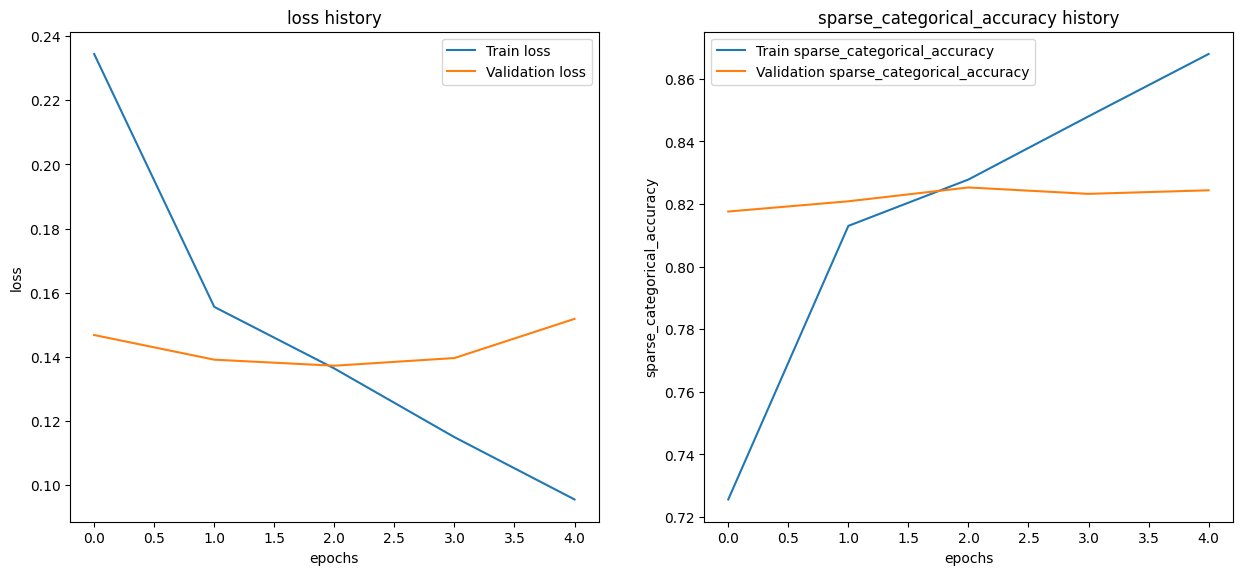

In [16]:
def plot_keras_history(history, measures):
    """
    history: Keras training history
    measures = list of names of measures
    """
    rows = len(measures) // 2 + len(measures) % 2
    fig, panels = plt.subplots(rows, 2, figsize=(15, 5))
    plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.4, wspace=0.2)
    try:
        panels = [item for sublist in panels for item in sublist]
    except:
        pass
    for k, measure in enumerate(measures):
        panel = panels[k]
        panel.set_title(measure + ' history')
        panel.plot(history.epoch, history.history[measure], label="Train "+measure)
        panel.plot(history.epoch, history.history["val_"+measure], label="Validation "+measure)
        panel.set(xlabel='epochs', ylabel=measure)
        panel.legend()
        
    plt.show(fig)
    
plot_keras_history(history, measures=["loss", "sparse_categorical_accuracy"])

In [17]:
y_pred = predict(X_test, gemma_lm)
evaluate(y_true, y_pred)

Accuracy: 0.836
Accuracy for label 0: 0.933
Accuracy for label 1: 0.803
Accuracy for label 2: 0.770

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.93      0.94       300
           1       0.75      0.80      0.77       300
           2       0.82      0.77      0.80       300

    accuracy                           0.84       900
   macro avg       0.84      0.84      0.84       900
weighted avg       0.84      0.84      0.84       900


Confusion Matrix:
[[280  17   3]
 [ 13 241  46]
 [  5  64 231]]


The following code will create a Pandas DataFrame called evaluation containing the text, true labels, and predicted labels from the test set. This is expectially useful for understanding the errors that the fine-tuned model makes, and gettting insights on how to improve the prompt.

In [18]:
evaluation = pd.DataFrame({'text': X_test["text"], 
                           'y_true':y_true, 
                           'y_pred': y_pred},
                         )
evaluation.to_csv("test_predictions.csv", index=False)